In [0]:
import json
import os
import pandas as pd
import pprint
import time
import numpy as np

%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split



import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping


try:
  from pyforest import *
except:
  !pip install pyforest
  from pyforest import *

print(tf.test.gpu_device_name())

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

from keras import backend as K
print(K.tensorflow_backend._get_available_gpus())

/device:GPU:0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4830651402836235396
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 5857416407297951505
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 10383489722720345689
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11330115994
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11032527717142553794
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]
['/job:localhost/replica:0/task:0/device:GPU:0']


## ConvLSTM Encoder-Decoder Model With Univariate Input (non è vero lol)

In [0]:
#from google.colab import files

#uploaded = files.upload()

!wget https://gitlab.com/DBertazioli/enercibiddding/raw/master/PyScripts/dumps/q_p_list.pickle
    
with open("q_p_list.pickle", "rb") as infile:
  S=pickle.load(infile)
!rm q_p_list.pickle
S1=S[1]
#S1.head()

S1=pd.Series(S1)
S_series=[pd.Series(elem) for elem in S]
scaler = MinMaxScaler(feature_range=(0,1))
S1 = scaler.fit_transform(S1.values.reshape(-1,1))

S=[scaler.fit_transform(S1.values.reshape(-1,1)) for S1 in S_series]

#plt.plot(S1)
#X_train, X_test, y_train, y_test = train_test_split(S1[:-1], S1[1:], test_size=0.33, random_state=None, shuffle=False)

--2019-09-06 08:54:58--  https://gitlab.com/DBertazioli/enercibiddding/raw/master/PyScripts/dumps/q_p_list.pickle
Resolving gitlab.com (gitlab.com)... 35.231.145.151
Connecting to gitlab.com (gitlab.com)|35.231.145.151|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3283745 (3.1M) [application/octet-stream]
Saving to: ‘q_p_list.pickle’

q_p_list.pickle     100%[===================>]   3.13M  11.7MB/s    in 0.3s    

2019-09-06 08:54:58 (11.7 MB/s) - ‘q_p_list.pickle’ saved [3283745/3283745]



In [0]:
#Callback function for online plot while fitting

from IPython.display import clear_output


class TrainingPlot(keras.callbacks.Callback):
    
    # This function is called when the training begins
    def on_train_begin(self, logs={}):
        # Initialize the lists for holding the logs, losses and accuracies
        self.losses = []
        self.acc = []
        self.val_losses = []
        self.val_acc = []
        self.logs = []
    
    # This function is called at the end of each epoch
    def on_epoch_end(self, epoch, logs={}):
        
        n_step=100
        # Append the logs, losses and accuracies to the lists
        self.logs.append(logs)
        self.losses.append(logs.get('loss'))
        self.acc.append(logs.get('acc'))
        self.val_losses.append(logs.get('val_loss'))
        self.val_acc.append(logs.get('val_acc'))
        
        # Before plotting ensure at least 2 epochs have passed
        if len(self.losses)%n_step==0:
            
            %matplotlib inline
            # Clear the previous plot
            clear_output(wait=True)
            N = np.arange(0, len(self.losses))
            
            # You can chose the style of your preference
            # print(plt.style.available) to see the available options
            plt.style.use("seaborn")
            
            # Plot train loss, train acc, val loss and val acc against epochs passed
            plt.figure()
            plt.plot(N, self.losses, label = "train_loss")
            plt.plot(N, self.acc, label = "train_acc")
            plt.plot(N, self.val_losses, label = "val_loss")
            plt.plot(N, self.val_acc, label = "val_acc")
            plt.title("Training Loss and Accuracy [Epoch {}]".format(epoch+1))
            plt.xlabel("Epoch #")
            plt.ylabel("Loss/Accuracy")
            plt.legend()
            plt.show()

plot_losses = TrainingPlot()

In [0]:
def split_multi_sequence(seq_list, n_steps, n_target_serie):
    main_X, main_y, X, y = list(), list(), list(),list()
    target_seq=seq_list[n_target_serie]
    append=True
    for i in range(len(target_seq)):
        X=[]
        y=[]
        for sequence in seq_list:
            # find the end of this pattern
            end_ix = i + n_steps
            # check if we are beyond the sequence
            if end_ix > len(sequence)-1:
                append=False
                break
            else:
                append=True
            # gather input and output parts of the pattern
            seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
            X.append(np.array(seq_x))
            y.append(seq_y)
        if append==True:
            main_X.append(np.array(X))
            main_y.append(y)
    #return np.array(X), np.array(y)
    return main_X, main_y

In [0]:
def shaper(X):
    arr=np.ndarray(shape=(len(X),X[0].shape[1],X[0].shape[0]))
    for i in range(arr.shape[0]):
        for j in range(arr.shape[1]):
            for k in range(arr.shape[2]):
                    try:
                        arr[i][j][k]=X[i][k][j]
                    except Exception as e:
                        print(e)
                        print(i,j,k)
                        #break
    return arr

In [0]:
# choose a number of time steps
n_steps = 24
n_target_serie=0
# split into samples
X, y = split_multi_sequence([elem[:-100] for elem in S], n_steps,n_target_serie)
# reshape from [samples, timesteps] into [samples, timesteps, features]
#X=np.ndarray(X, shape=(len(X), X[0].shape[1], len(X)))

n_features = 51
#X = X.reshape((X.shape[0], X.shape[1], n_features))
#X = X.reshape((X.shape[0], X[0].shape[1], n_features))
X=shaper(X)
y=np.array(y)
#X
#y[0]

y=y.reshape(y.shape[0],y.shape[1])
#y.shape


Xt, yt=split_multi_sequence([elem[-100:] for elem in S], n_steps, n_target_serie)
Xt=shaper(Xt)
#Xt = Xt.reshape((Xt.shape[0], Xt.shape[1], n_features))
#yt=S1[-100+1:]

In [0]:
load=False
colab=True
if load:
    from keras.models import model_from_json
    
    if colab:
        from google.colab import files
        files.upload()
        model_name="LSTM_multivar_multidim"
    else:
      model_name="lstm_models/LSTM_multivar_multidim"
    model_weights=model_name+"_weigths.h5"

    json_file = open(model_name+".json", 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights(model_weights)
    print("Loaded model from disk")

    recompile=True
    if recompile:
      loaded_model.compile(loss='mse', optimizer="adam")
      model=loaded_model
define=False
if define:
  # define model
  model = Sequential()
  model.add(LSTM(204, activation='relu', input_shape=(n_steps, n_features),return_sequences=True,dropout=0.1))
  model.add(LSTM(units=51, activation='relu', return_sequences=True, dropout=0.1))
  model.add(LSTM(units=25, activation='relu',dropout=0.1))
  model.add(Dense(units=102, activation="relu"))
  model.add(Dense(units=51, activation="softmax"))
  #model.compile(loss='mean_squared_error', optimizer=tf.train.AdamOptimizer())#, metrics=["acc"])
  model.compile(loss='mae', optimizer="adam")#, metrics=["acc"])



In [0]:
model.fit(X, y, epochs=1000, batch_size=1024, verbose=2,shuffle=False, callbacks=[plot_losses])#EarlyStopping(monitor='val_loss', patience=50)])
#model.fit(X, y, epochs=100, verbose=2,shuffle=False, callbacks=[plot_losses])#EarlyStopping(monitor='val_loss', patience=50)])

#model.fit(X, y, epochs=2000, verbose=0,shuffle=False,validation_split=0.2,callbacks=[plot_losses, EarlyStopping(monitor='val_loss', patience=100)])

Epoch 1/1000
 - 1s - loss: 0.0763
Epoch 2/1000
 - 1s - loss: 0.0763
Epoch 3/1000
 - 1s - loss: 0.0763
Epoch 4/1000
 - 1s - loss: 0.0763
Epoch 5/1000
 - 1s - loss: 0.0763
Epoch 6/1000
 - 1s - loss: 0.0763
Epoch 7/1000
 - 1s - loss: 0.0763
Epoch 8/1000
 - 1s - loss: 0.0763
Epoch 9/1000
 - 1s - loss: 0.0763
Epoch 10/1000
 - 1s - loss: 0.0762
Epoch 11/1000
 - 1s - loss: 0.0762
Epoch 12/1000
 - 1s - loss: 0.0762
Epoch 13/1000
 - 1s - loss: 0.0762
Epoch 14/1000


KeyboardInterrupt: ignored

In [0]:
def unwind_y(arr_y, n_target_feature=0):
    return np.array([e[n_target_feature] for e in arr_y])

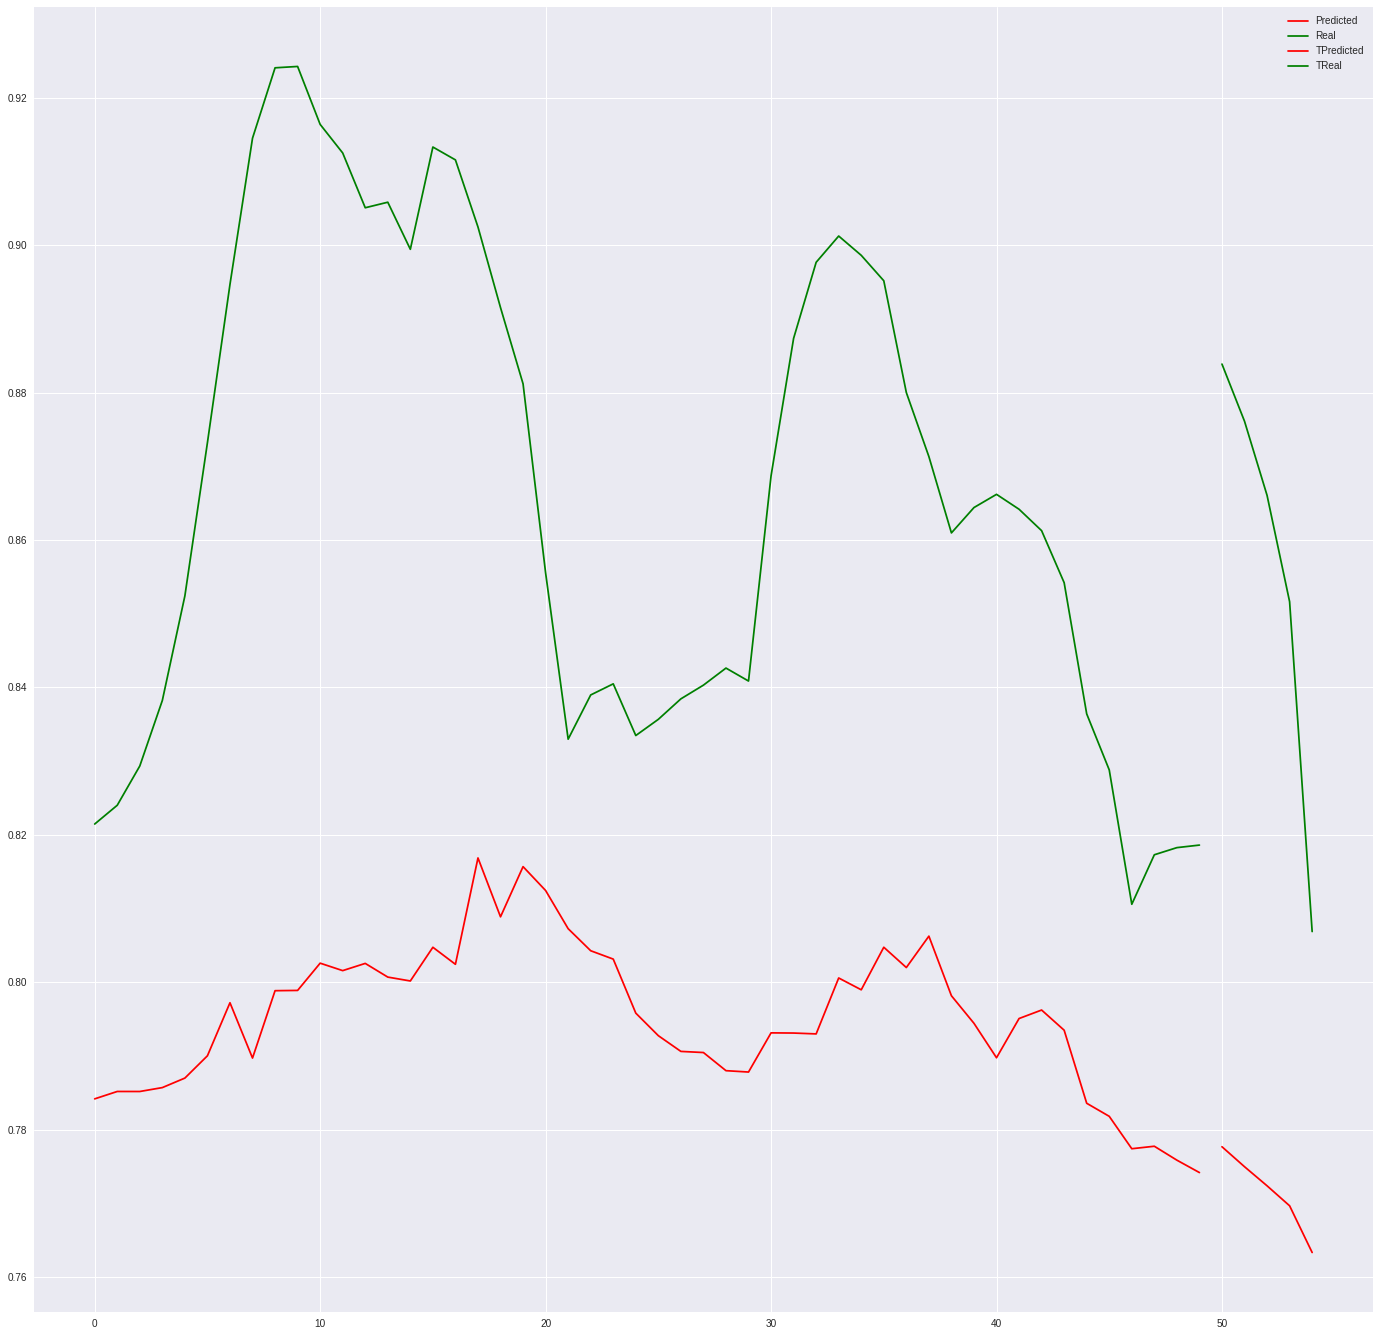

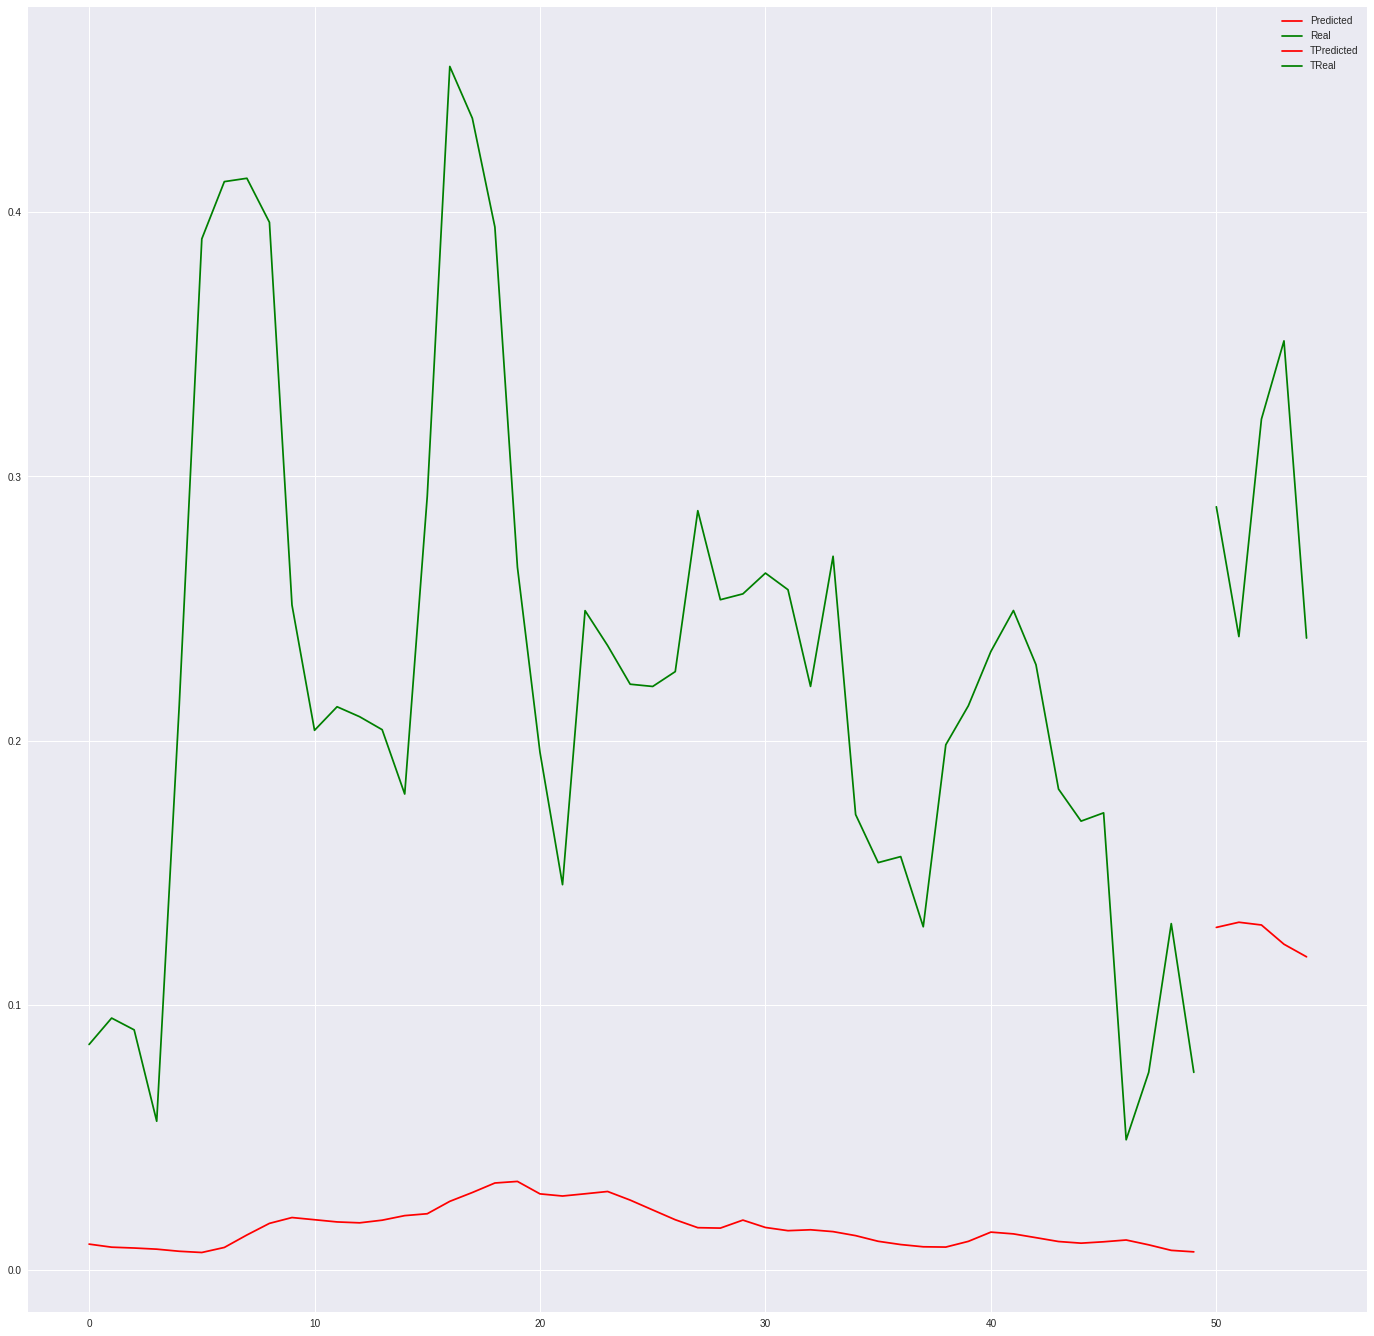

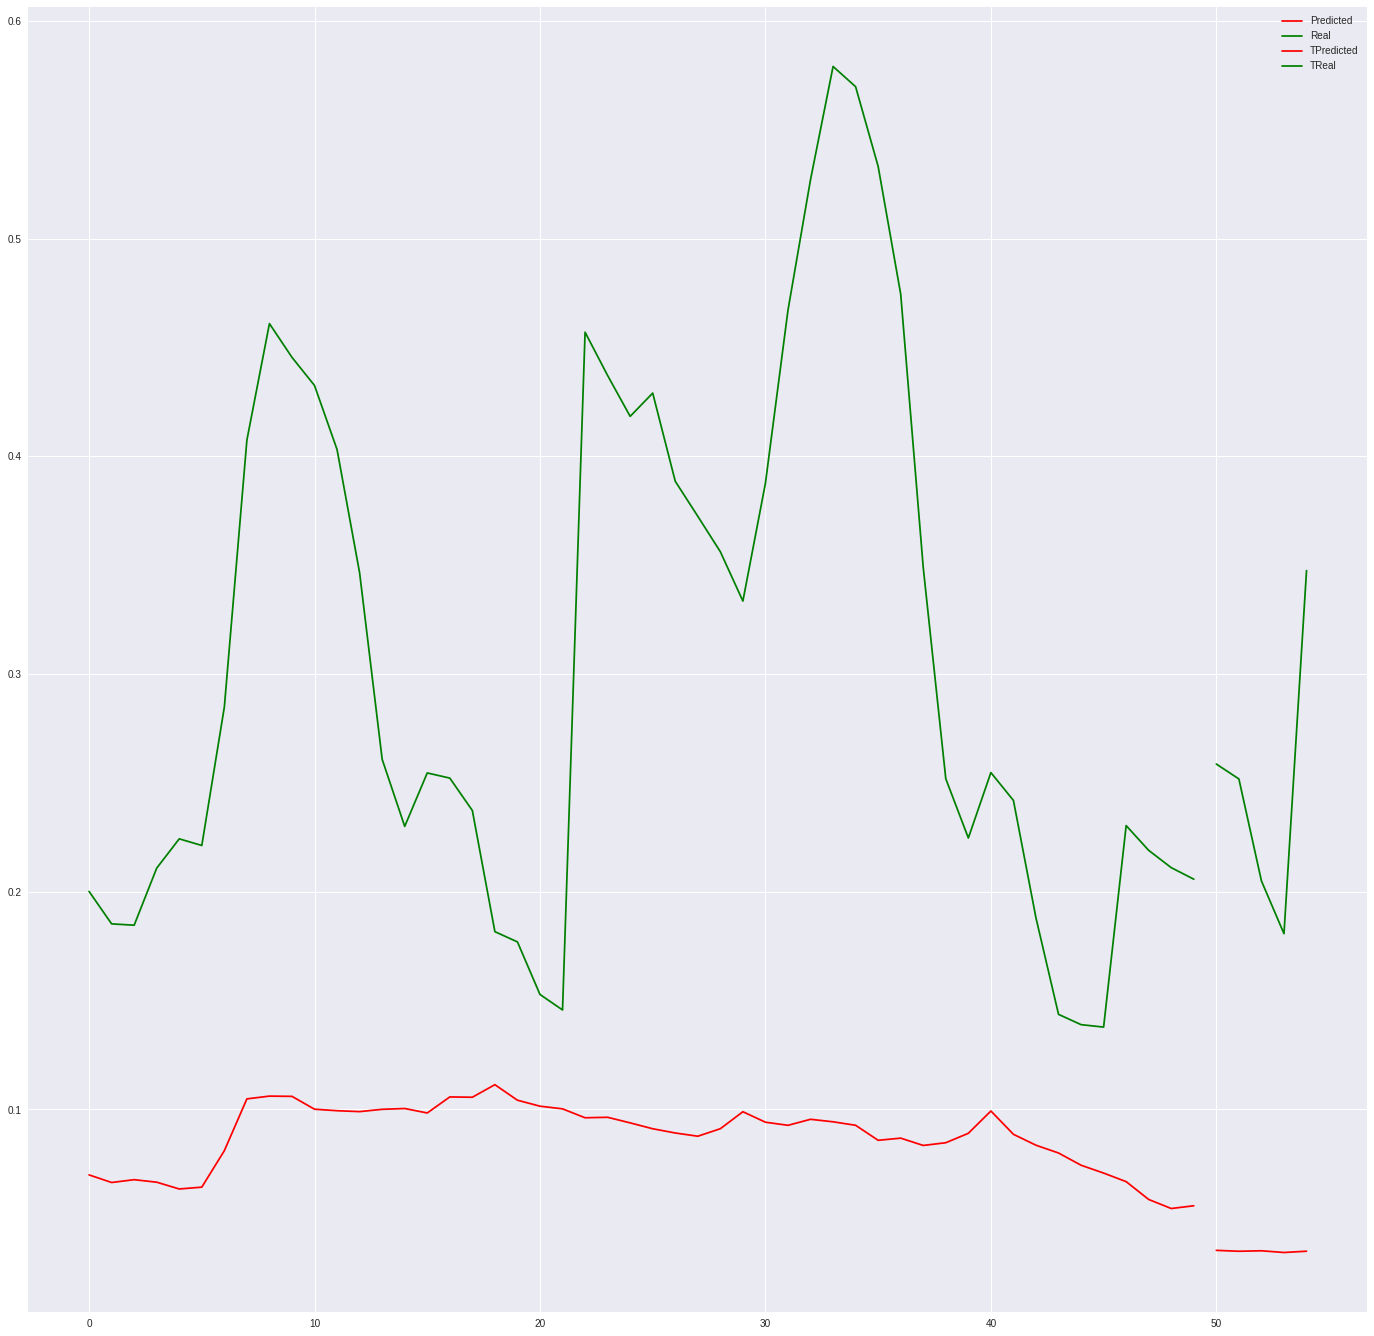

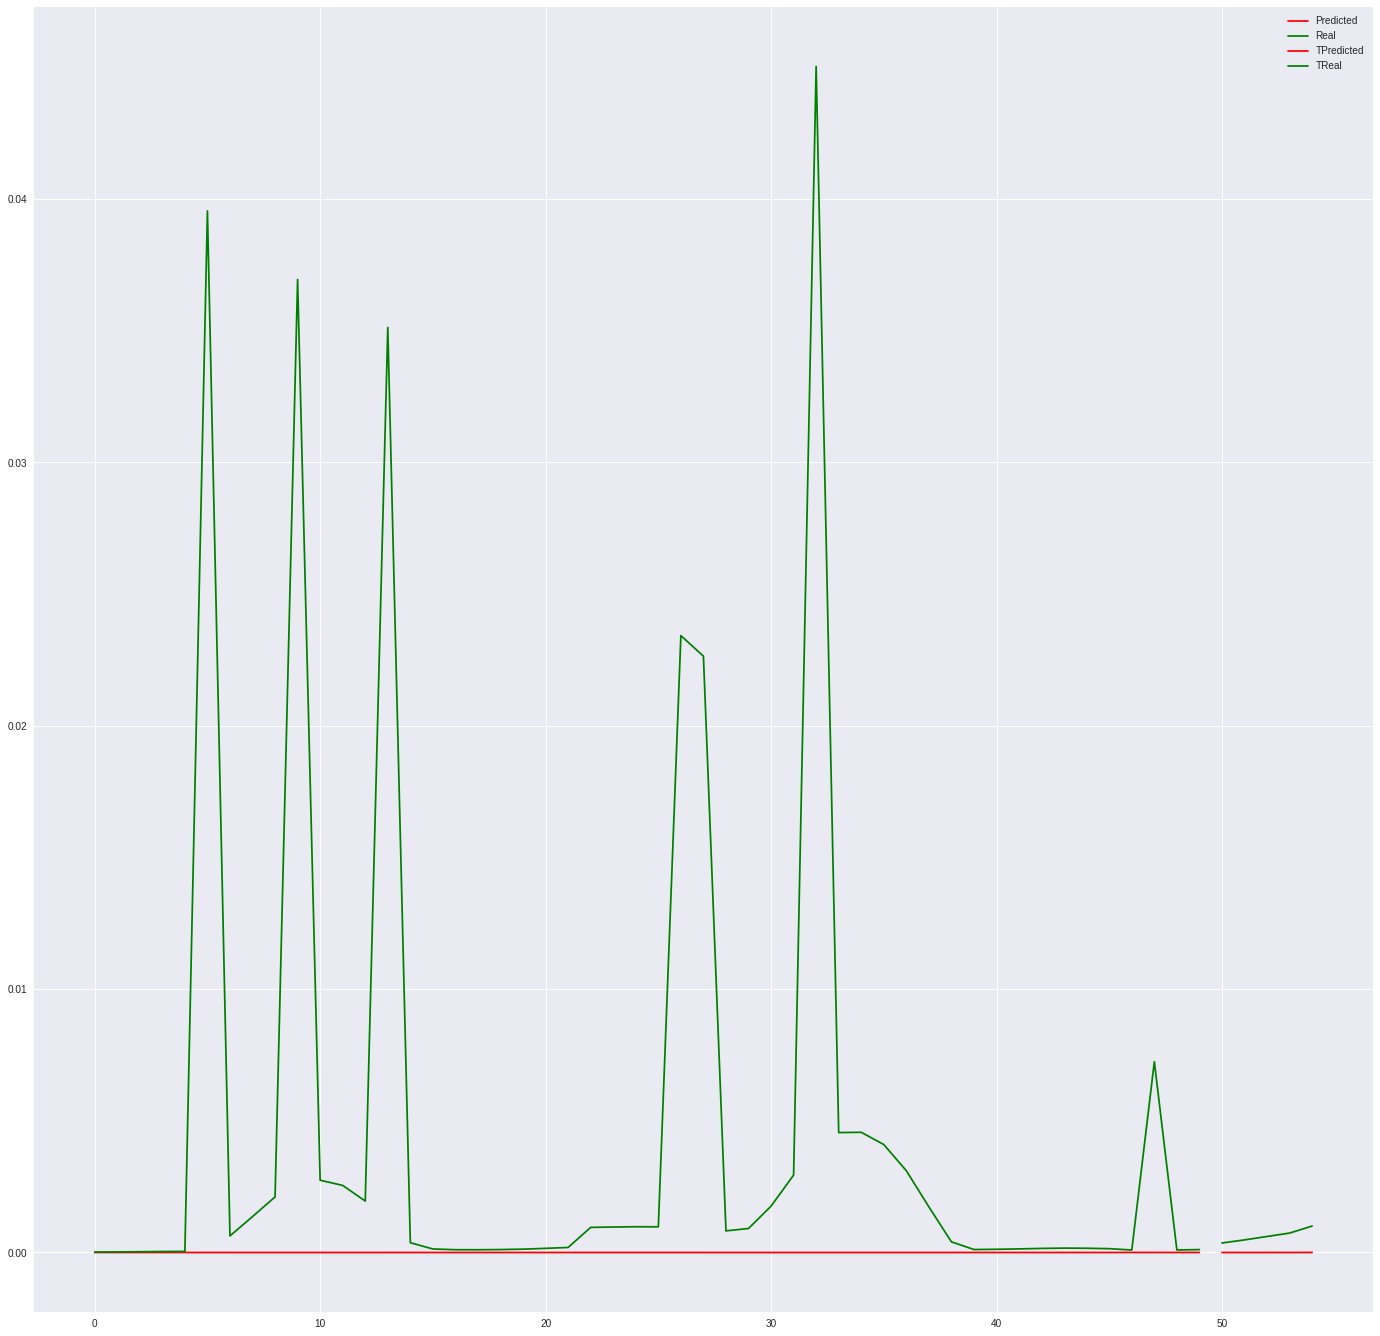

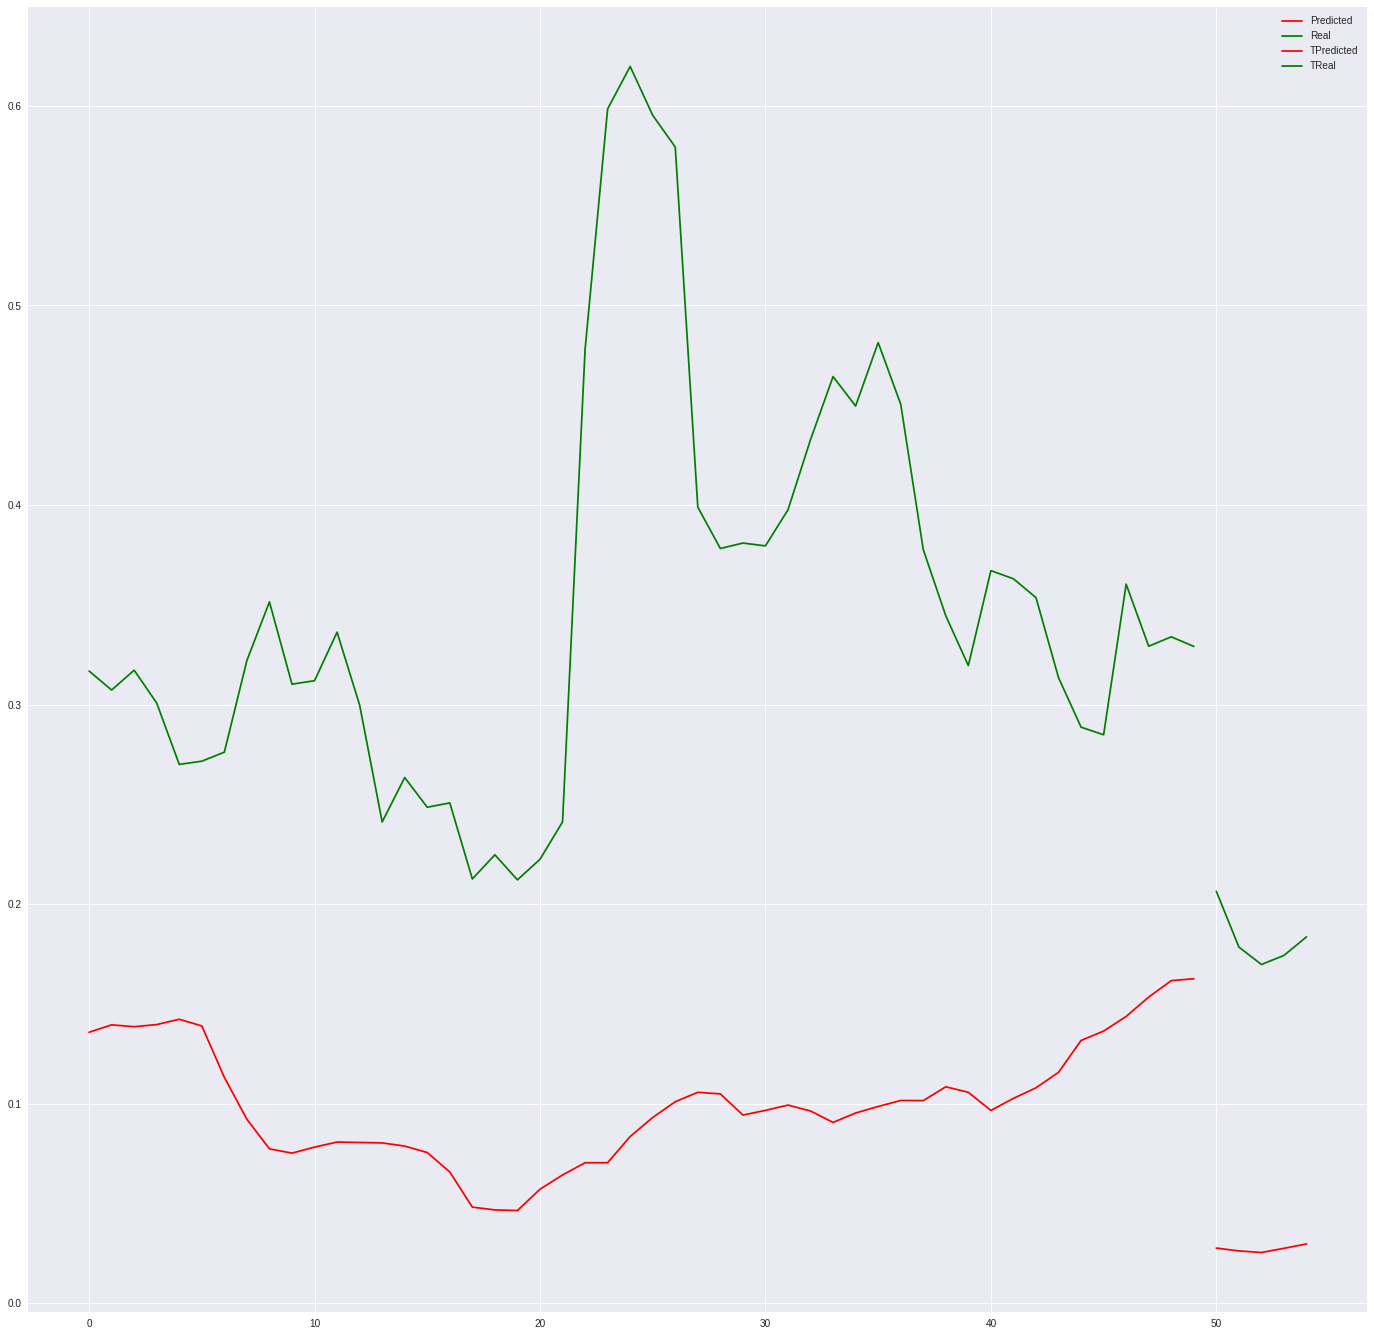

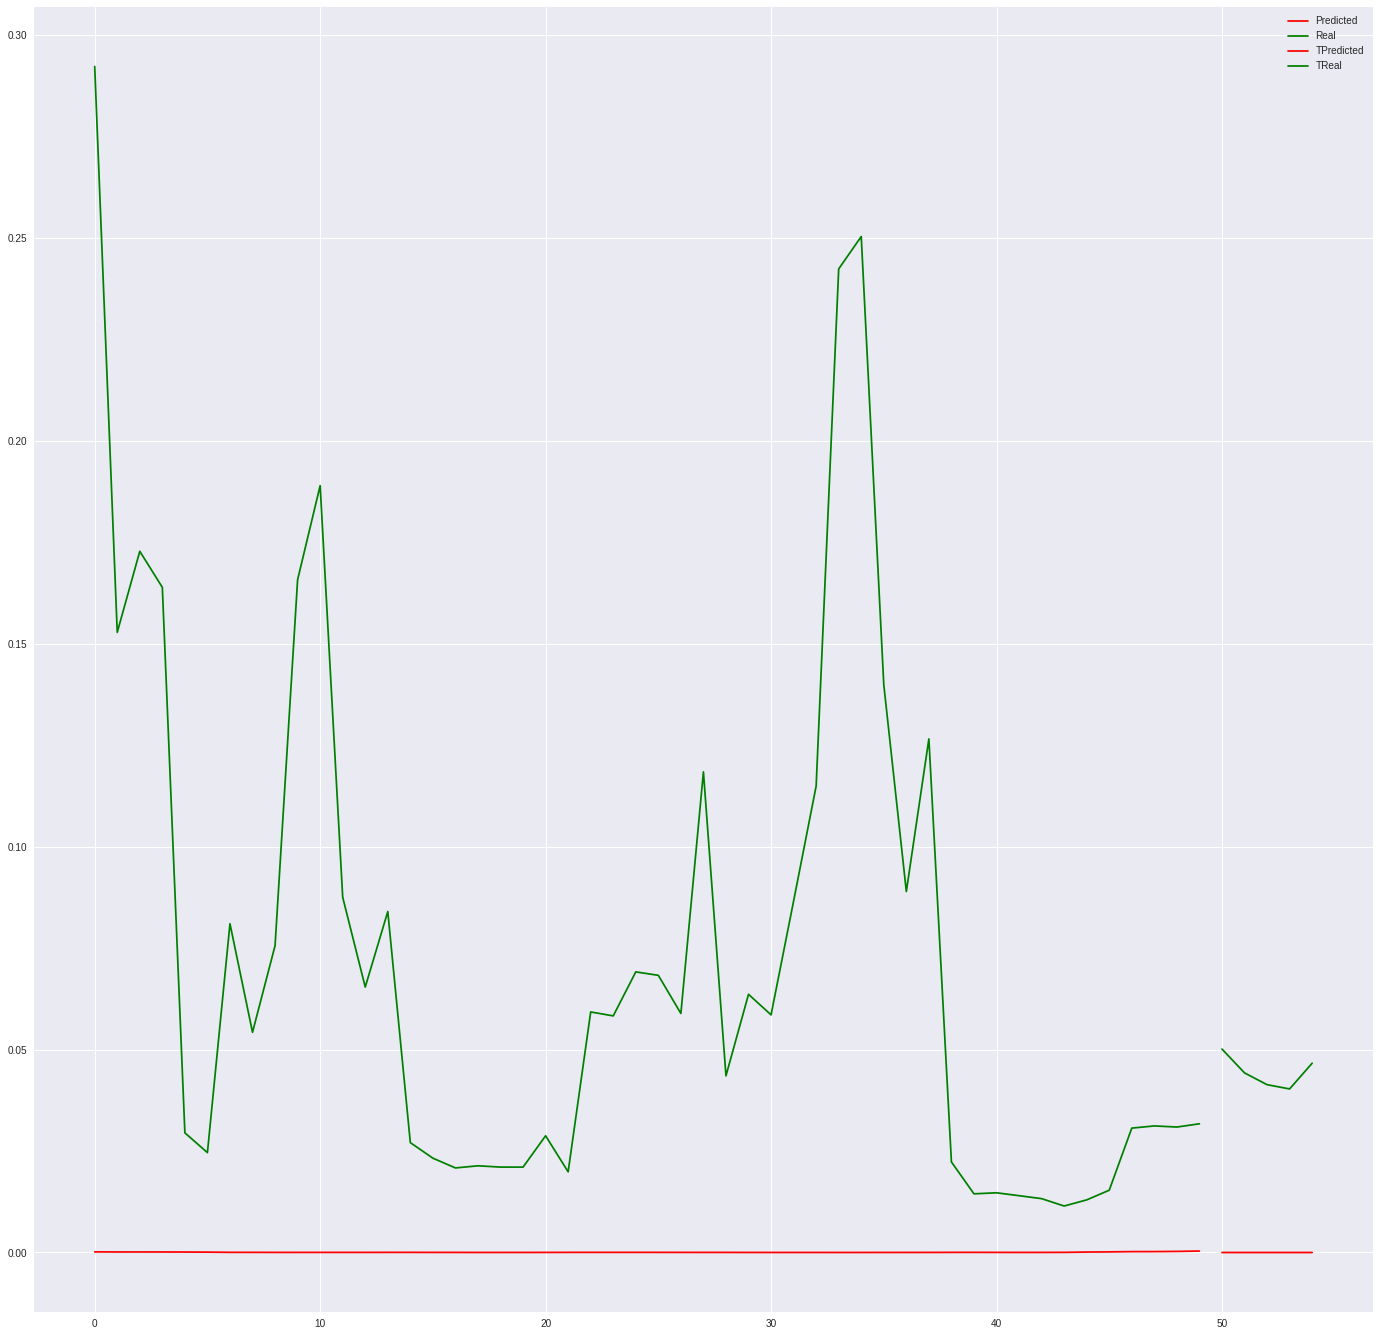

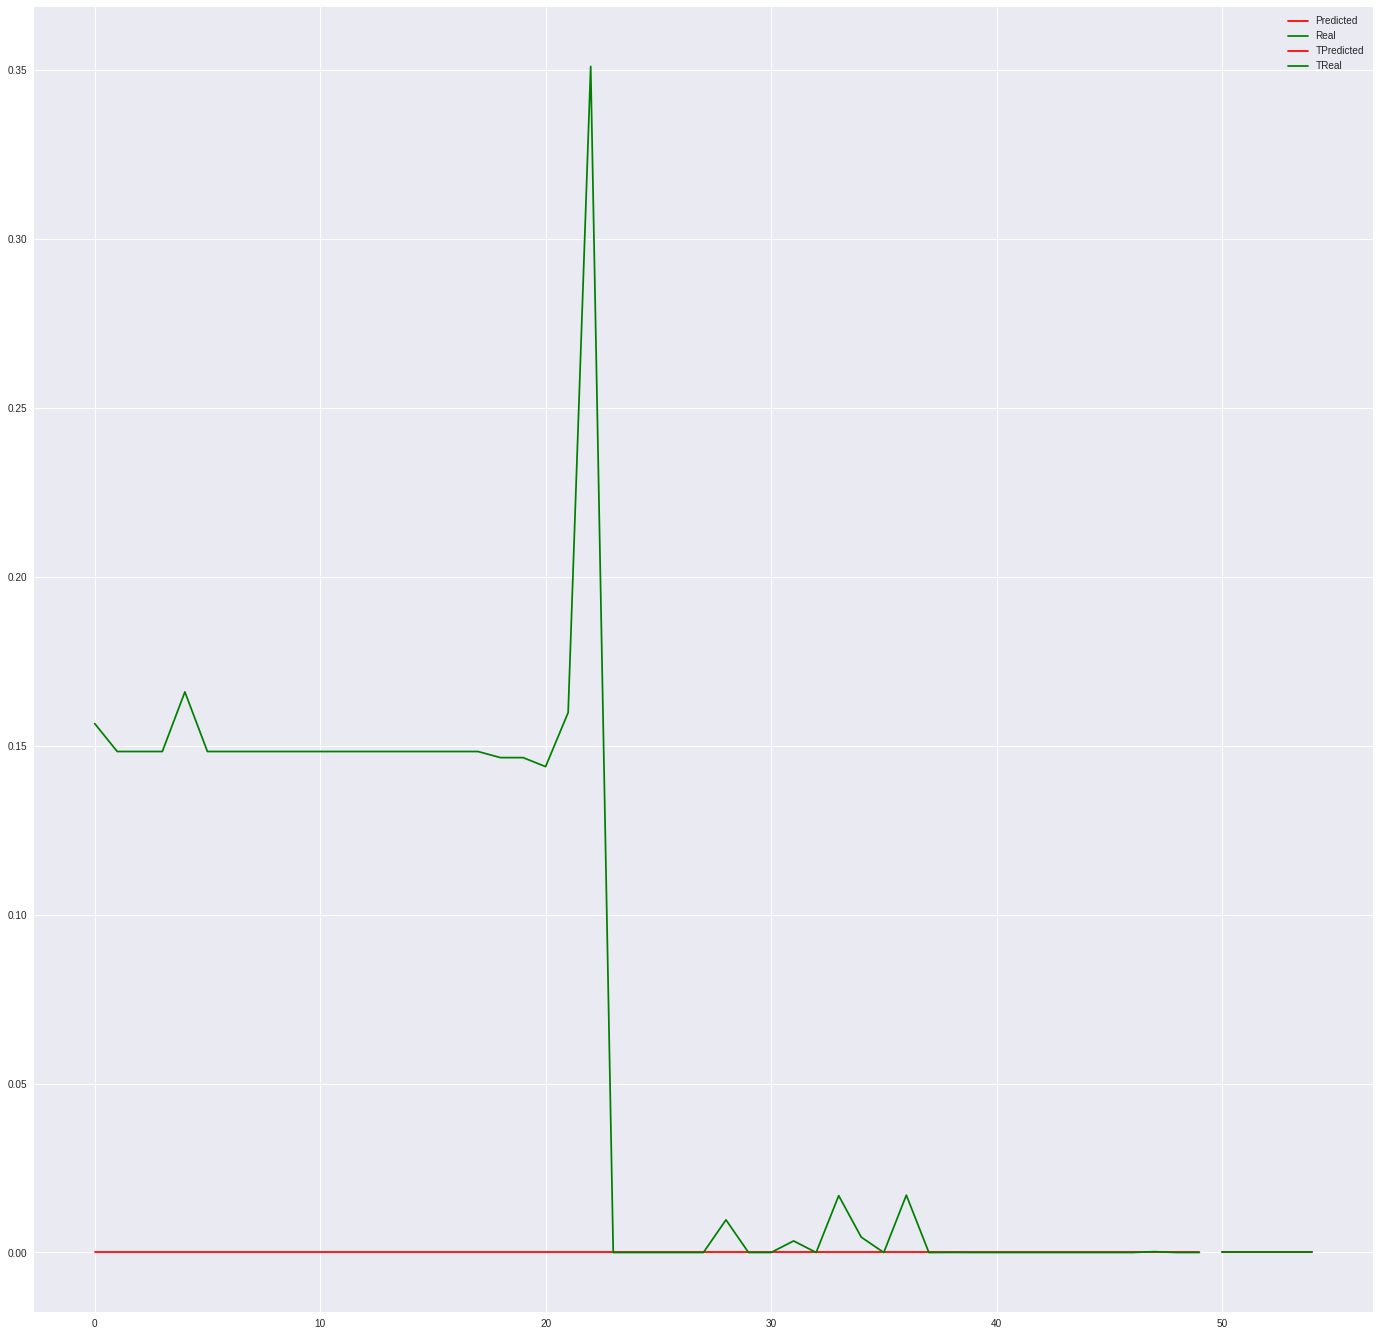

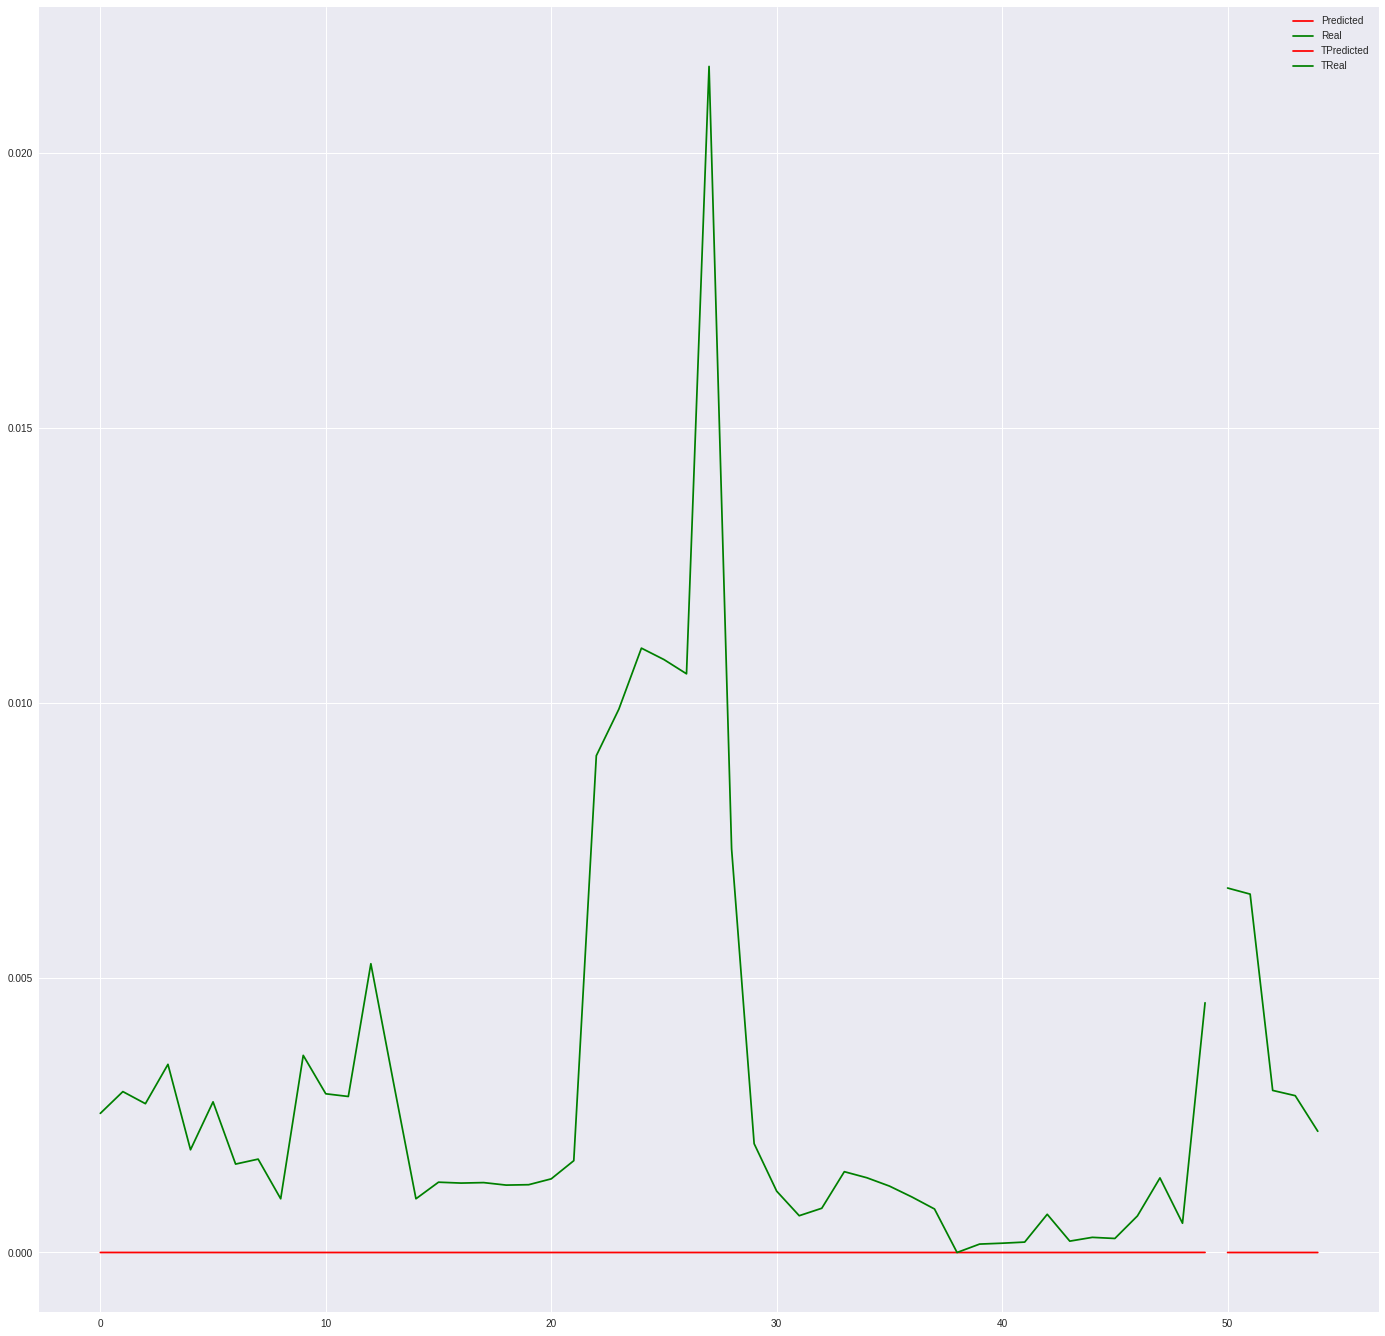

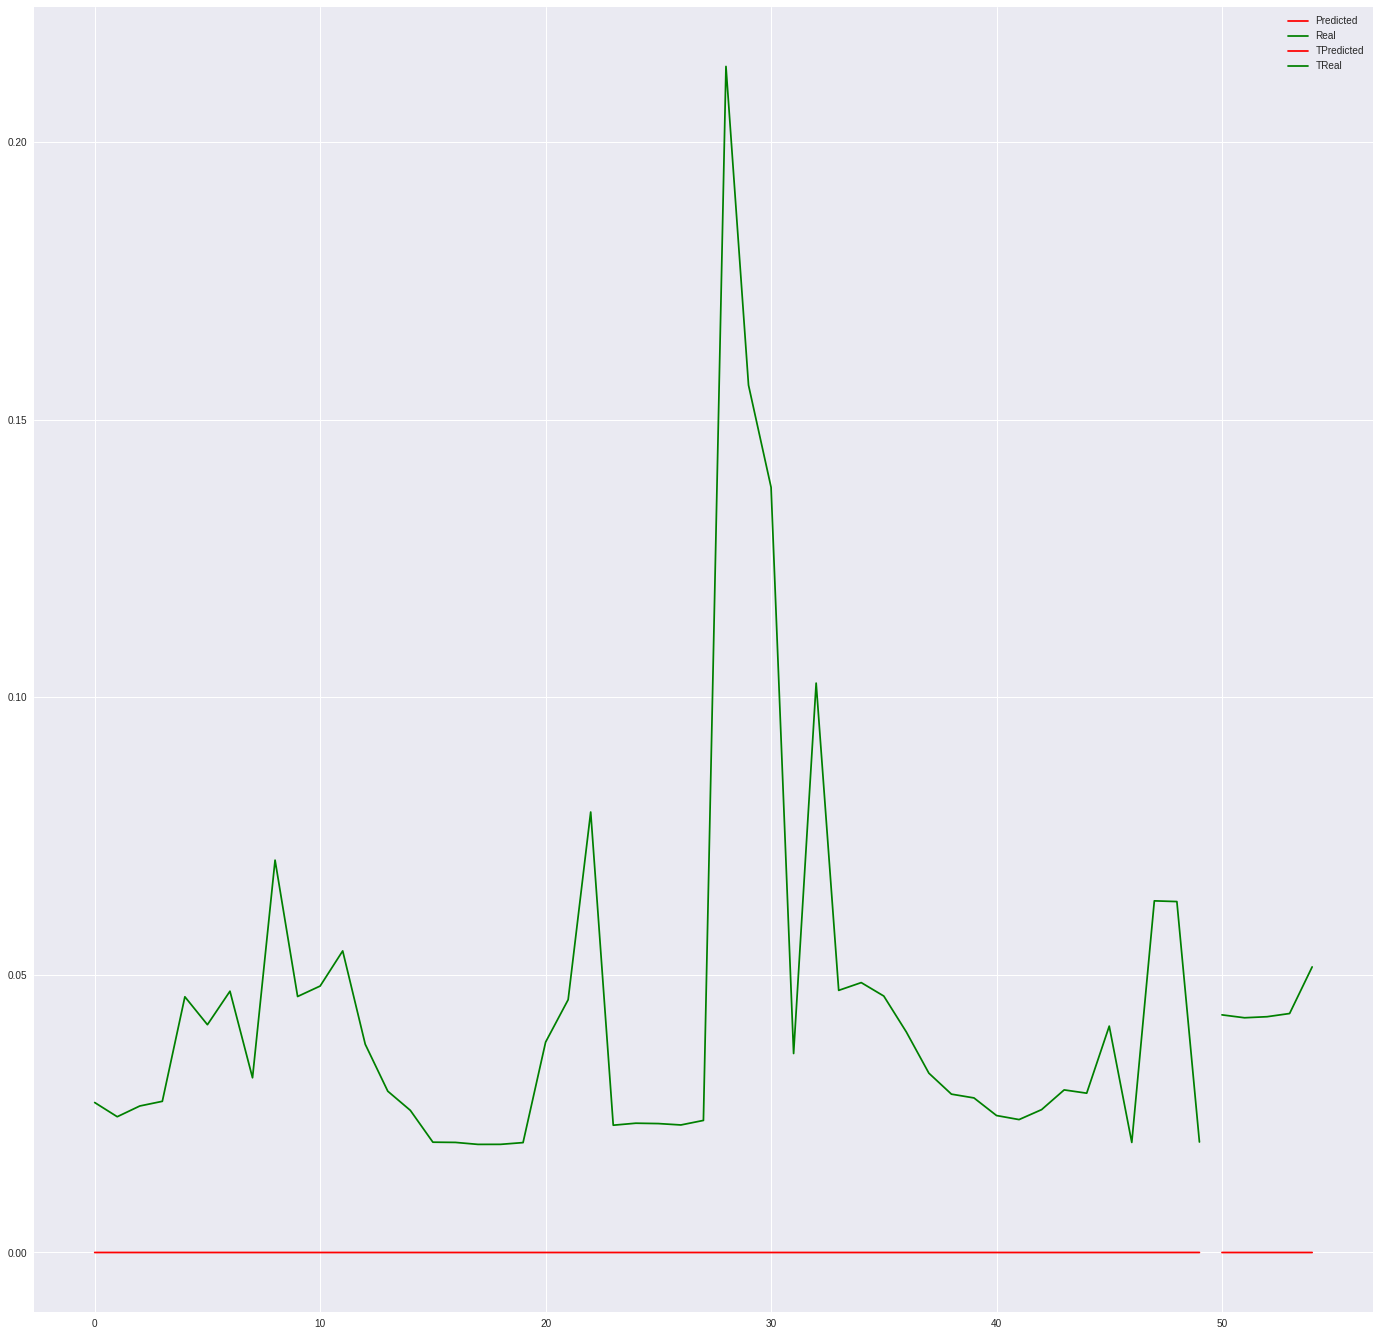

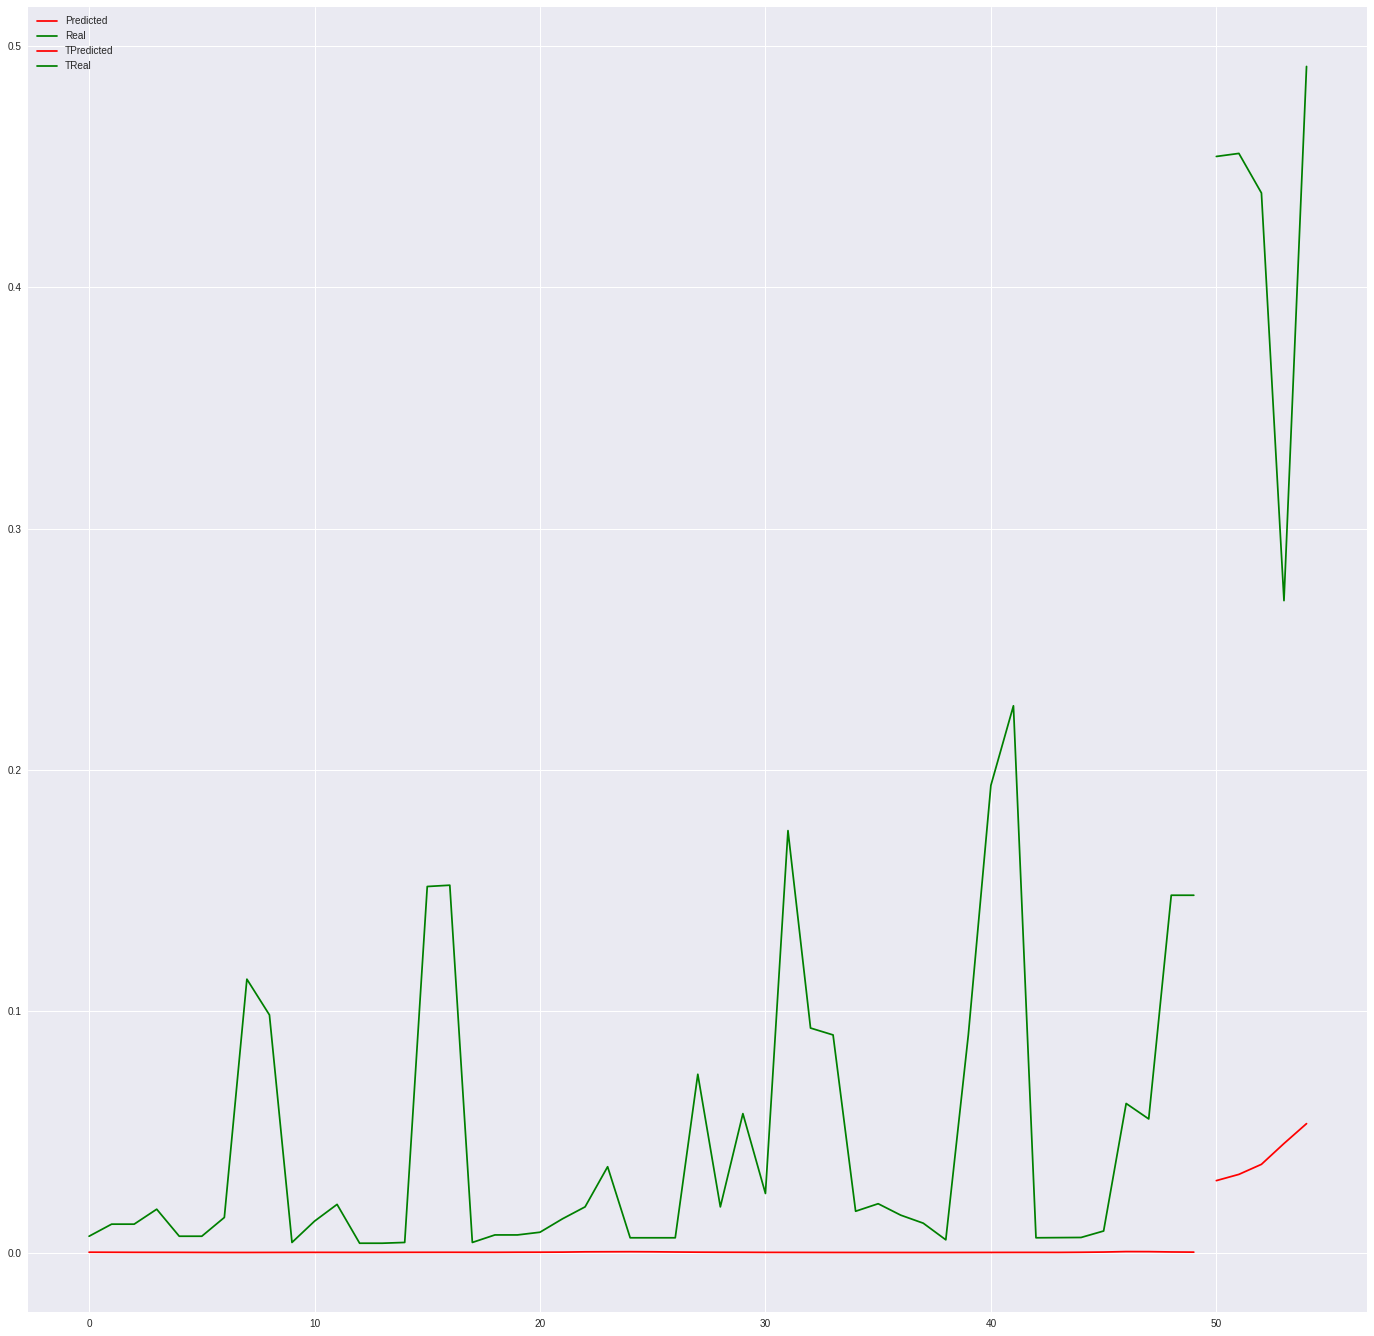

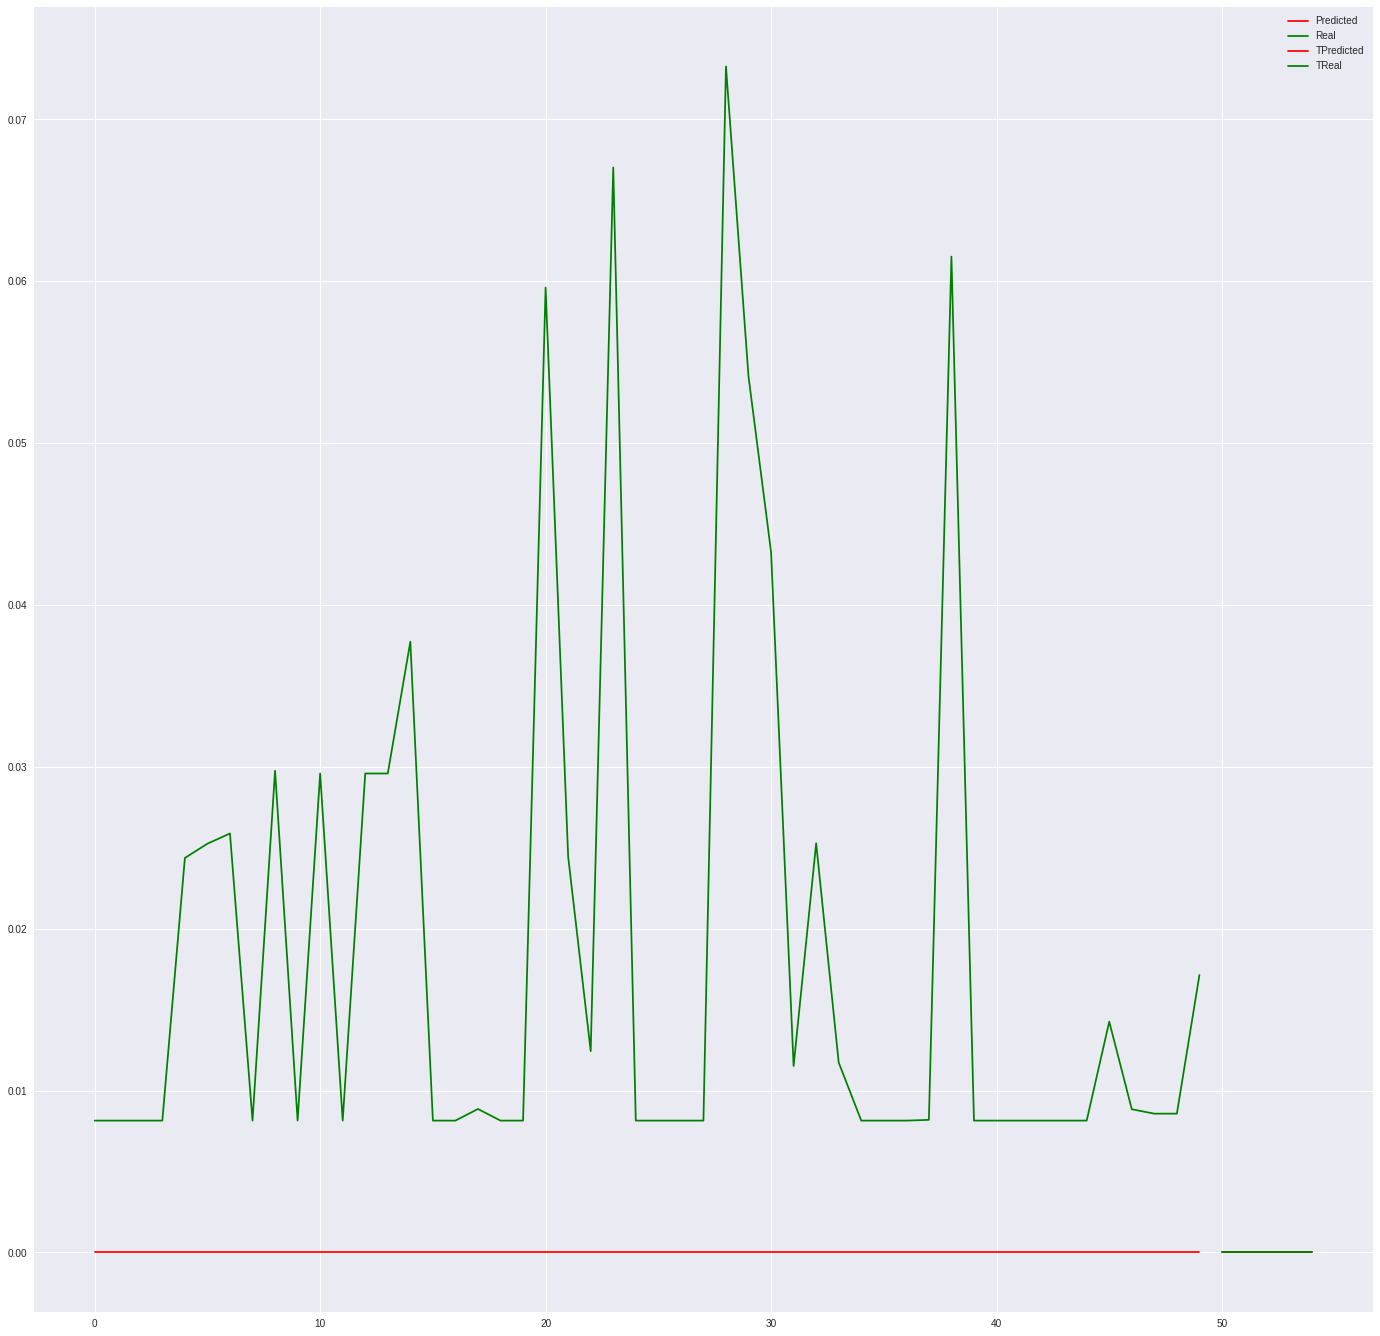

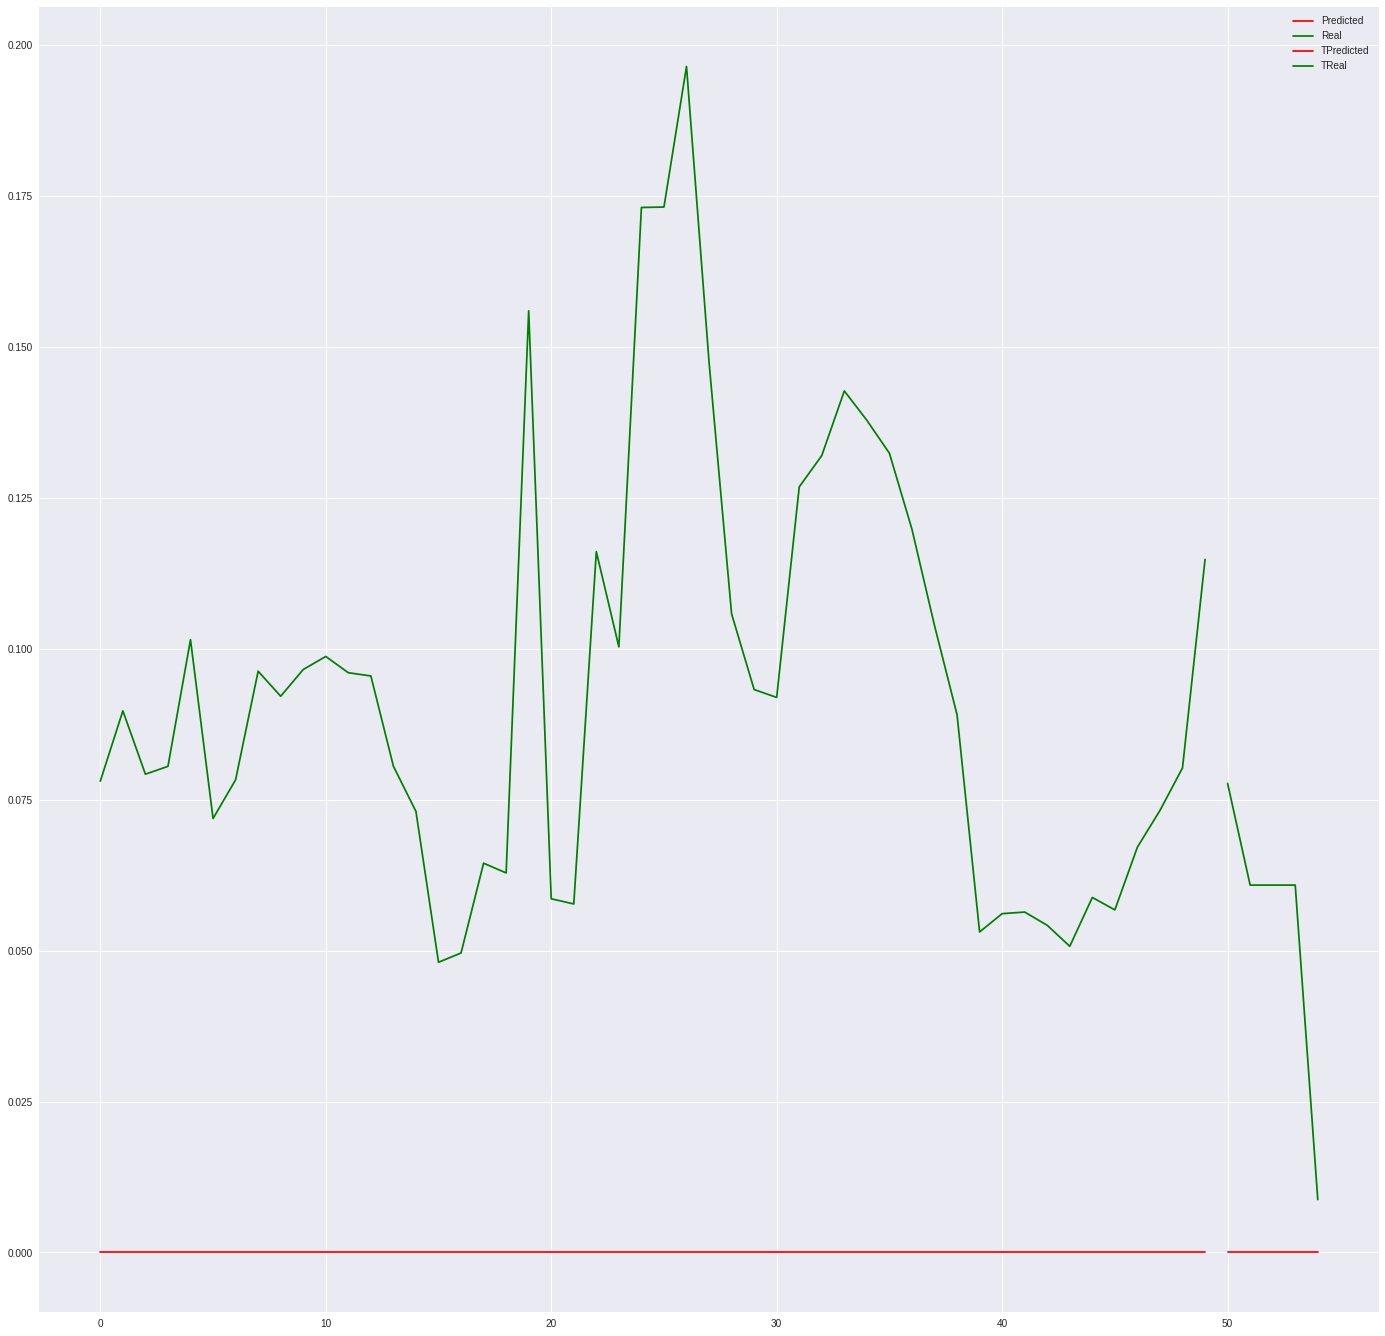

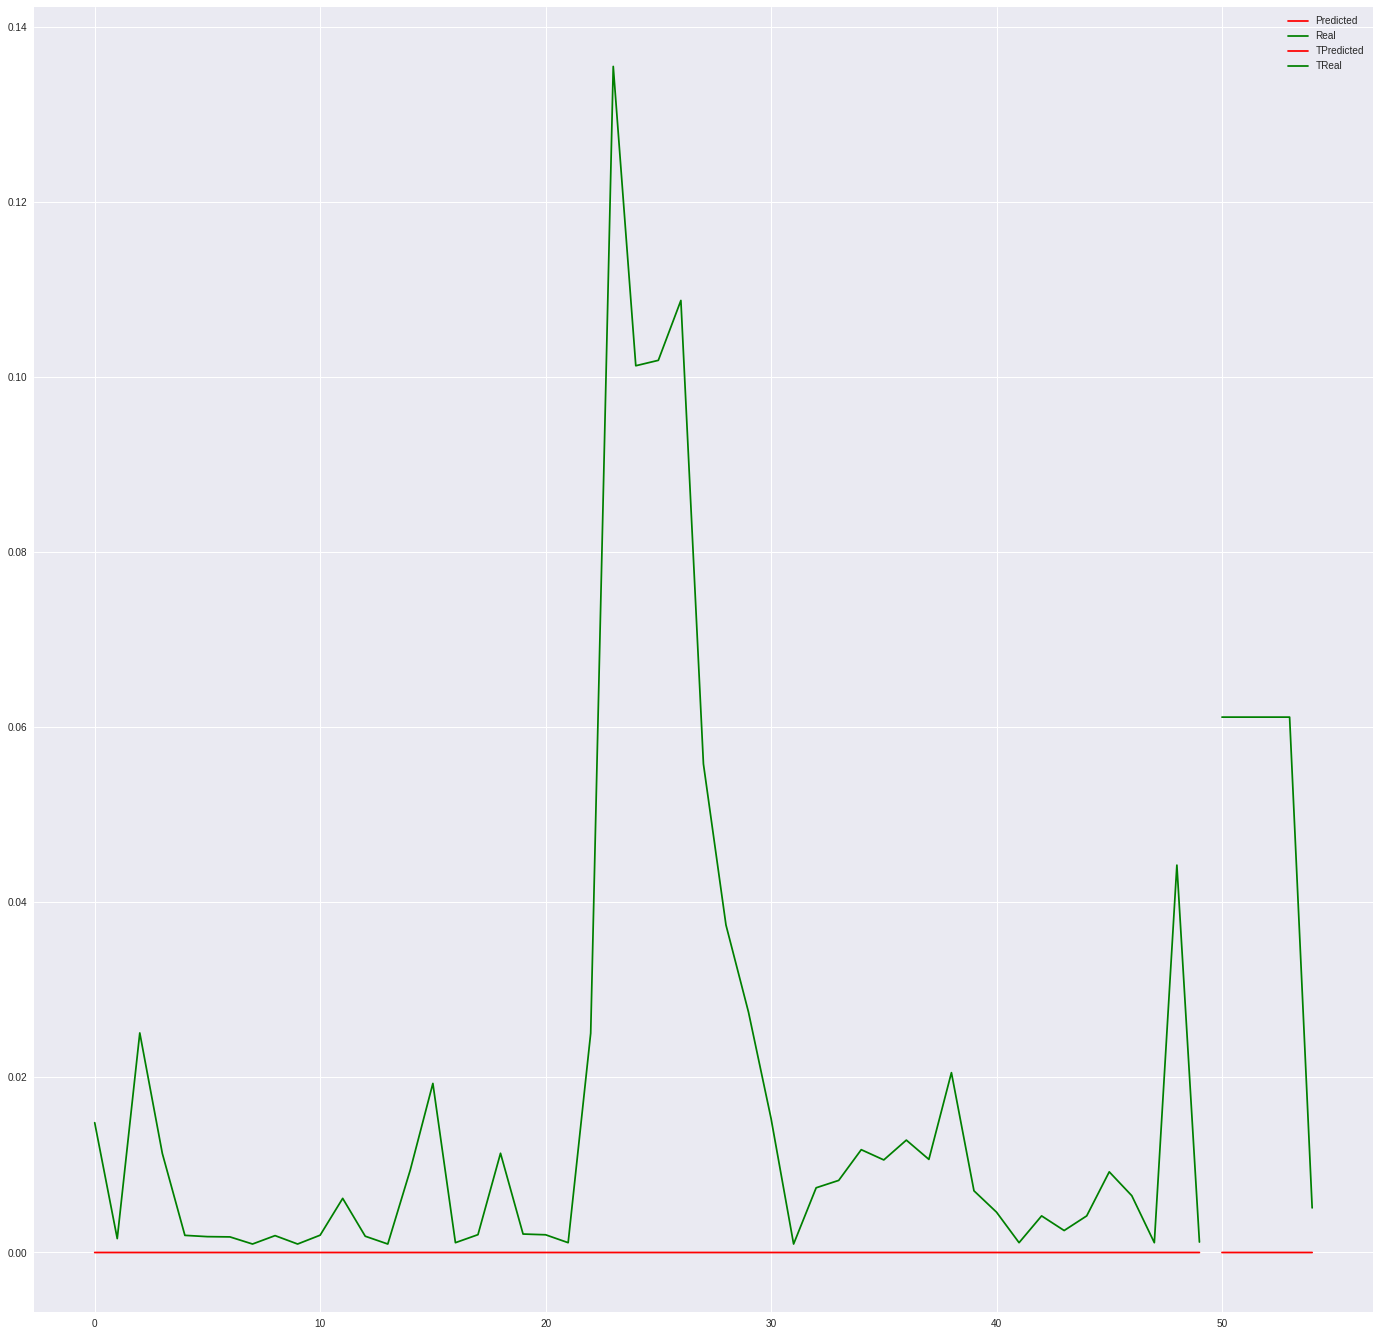

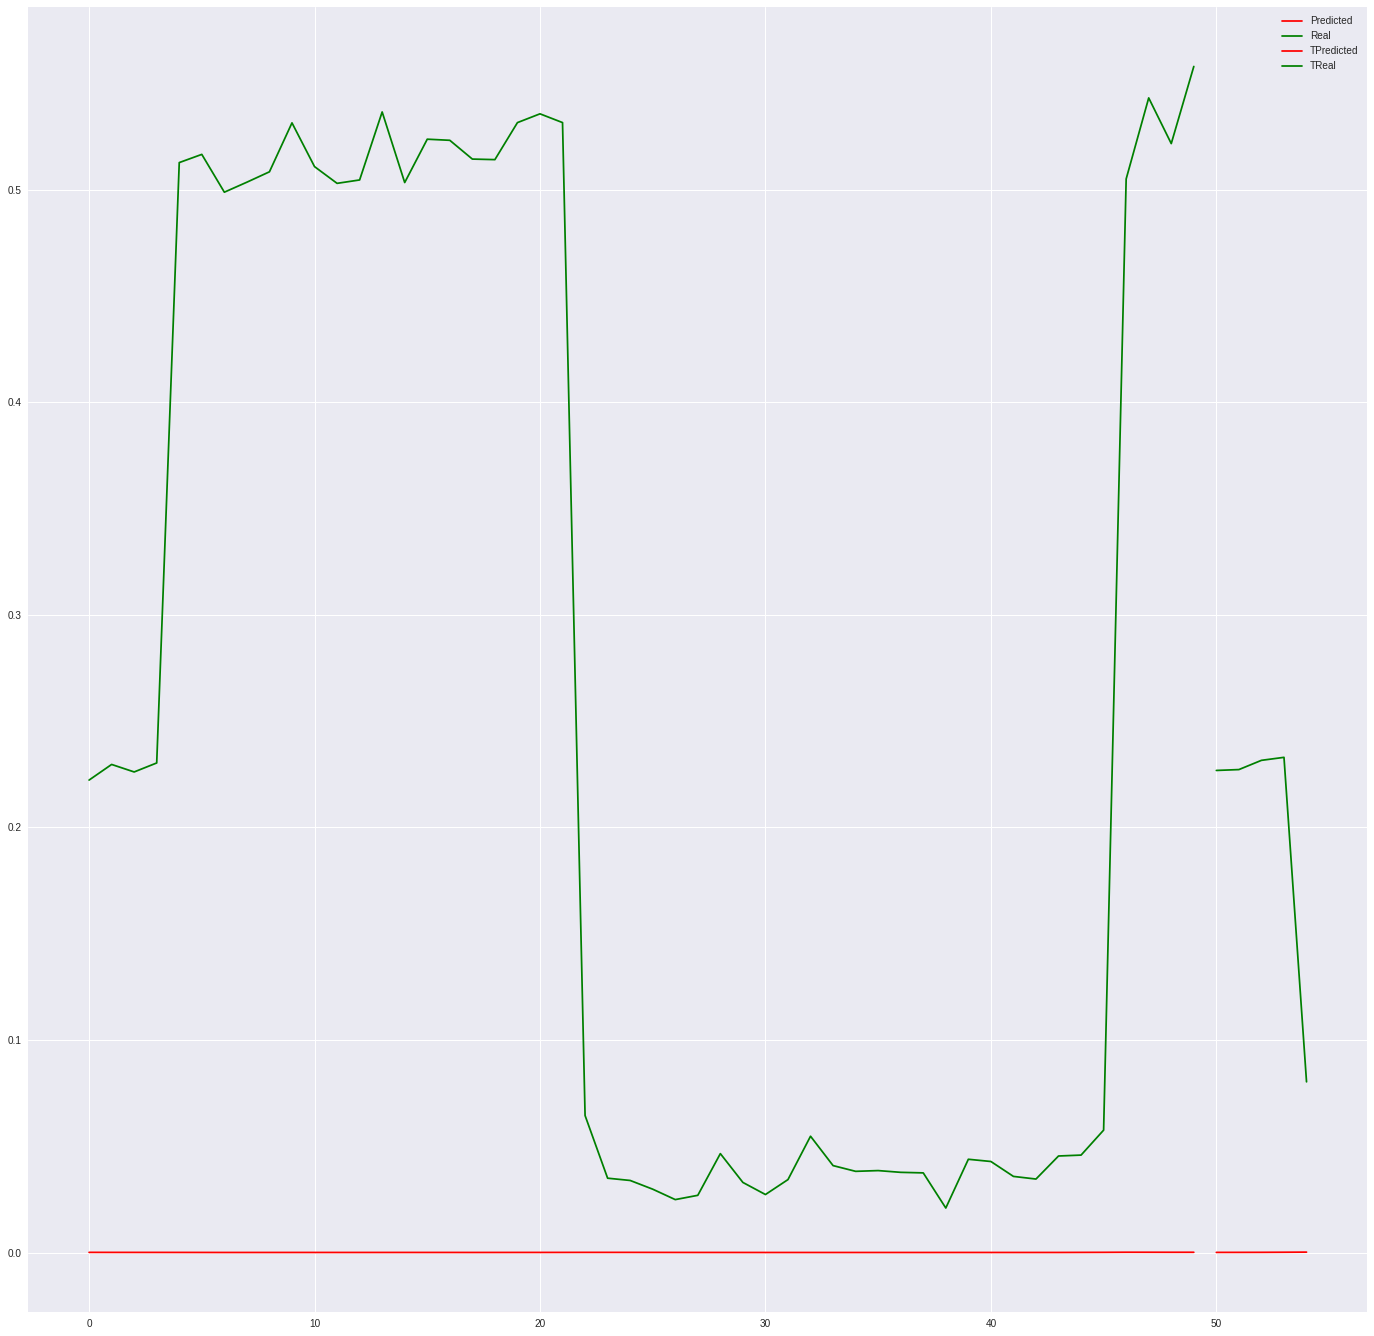

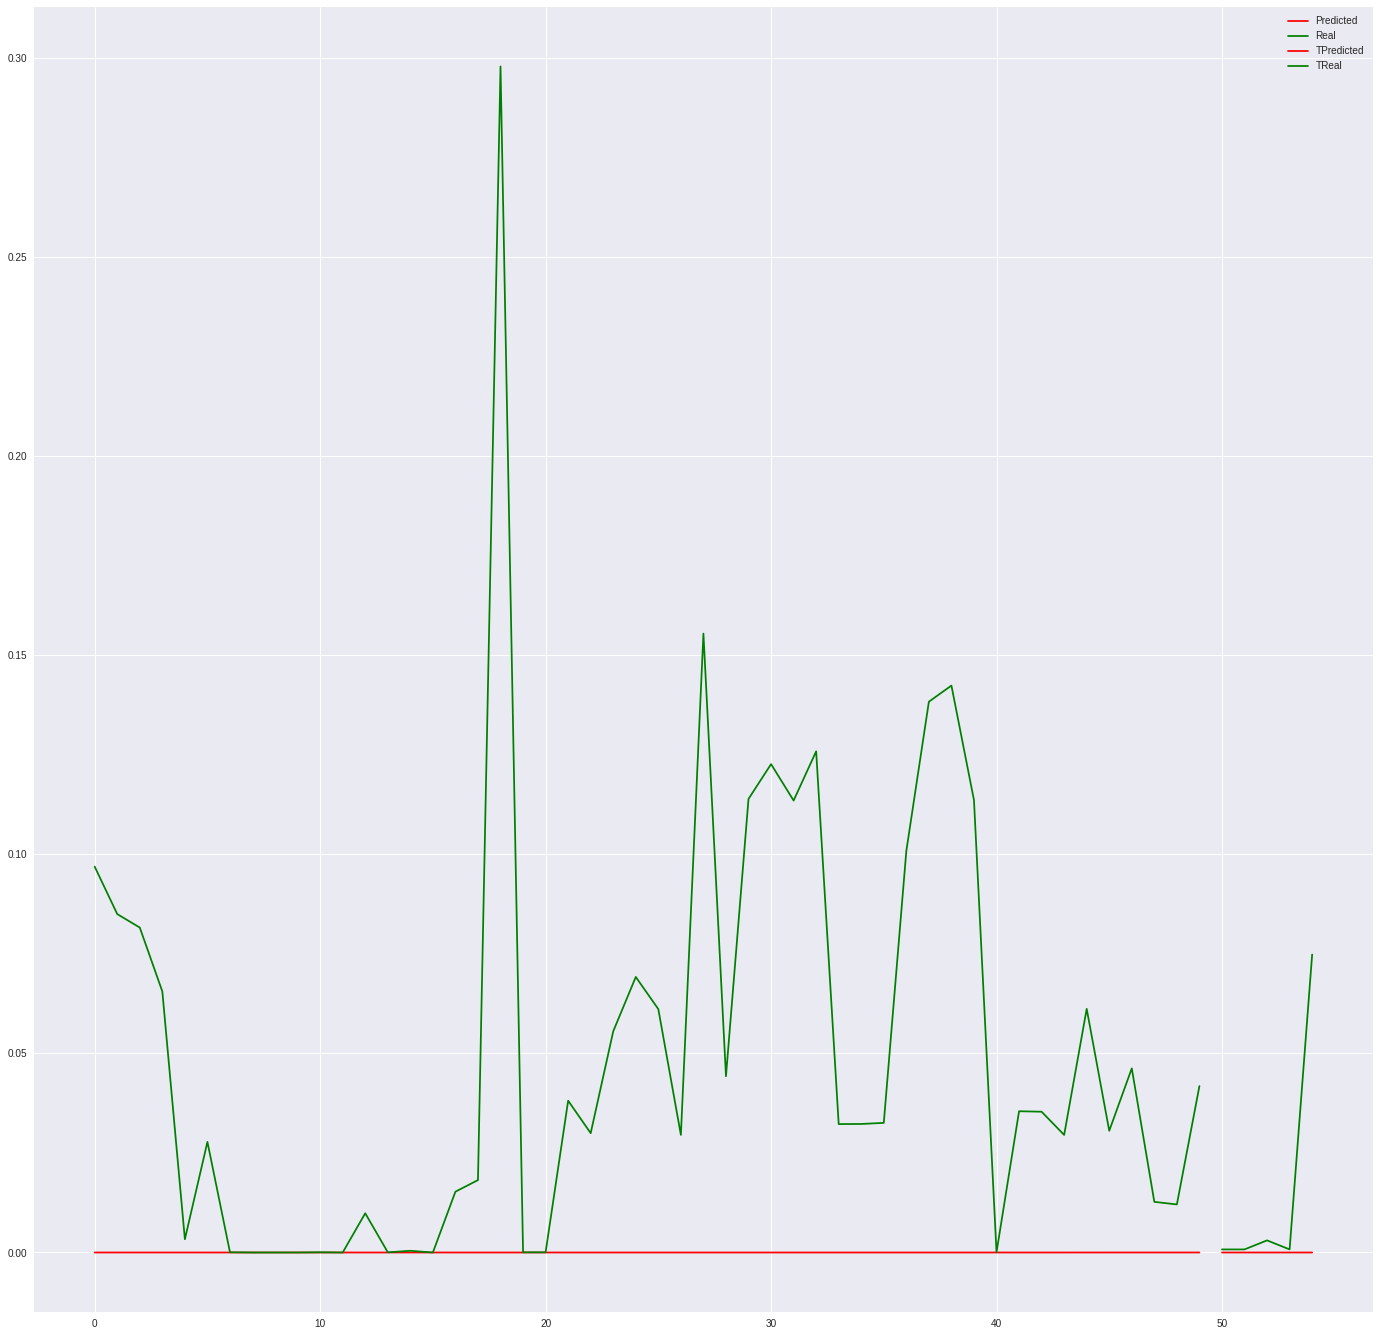

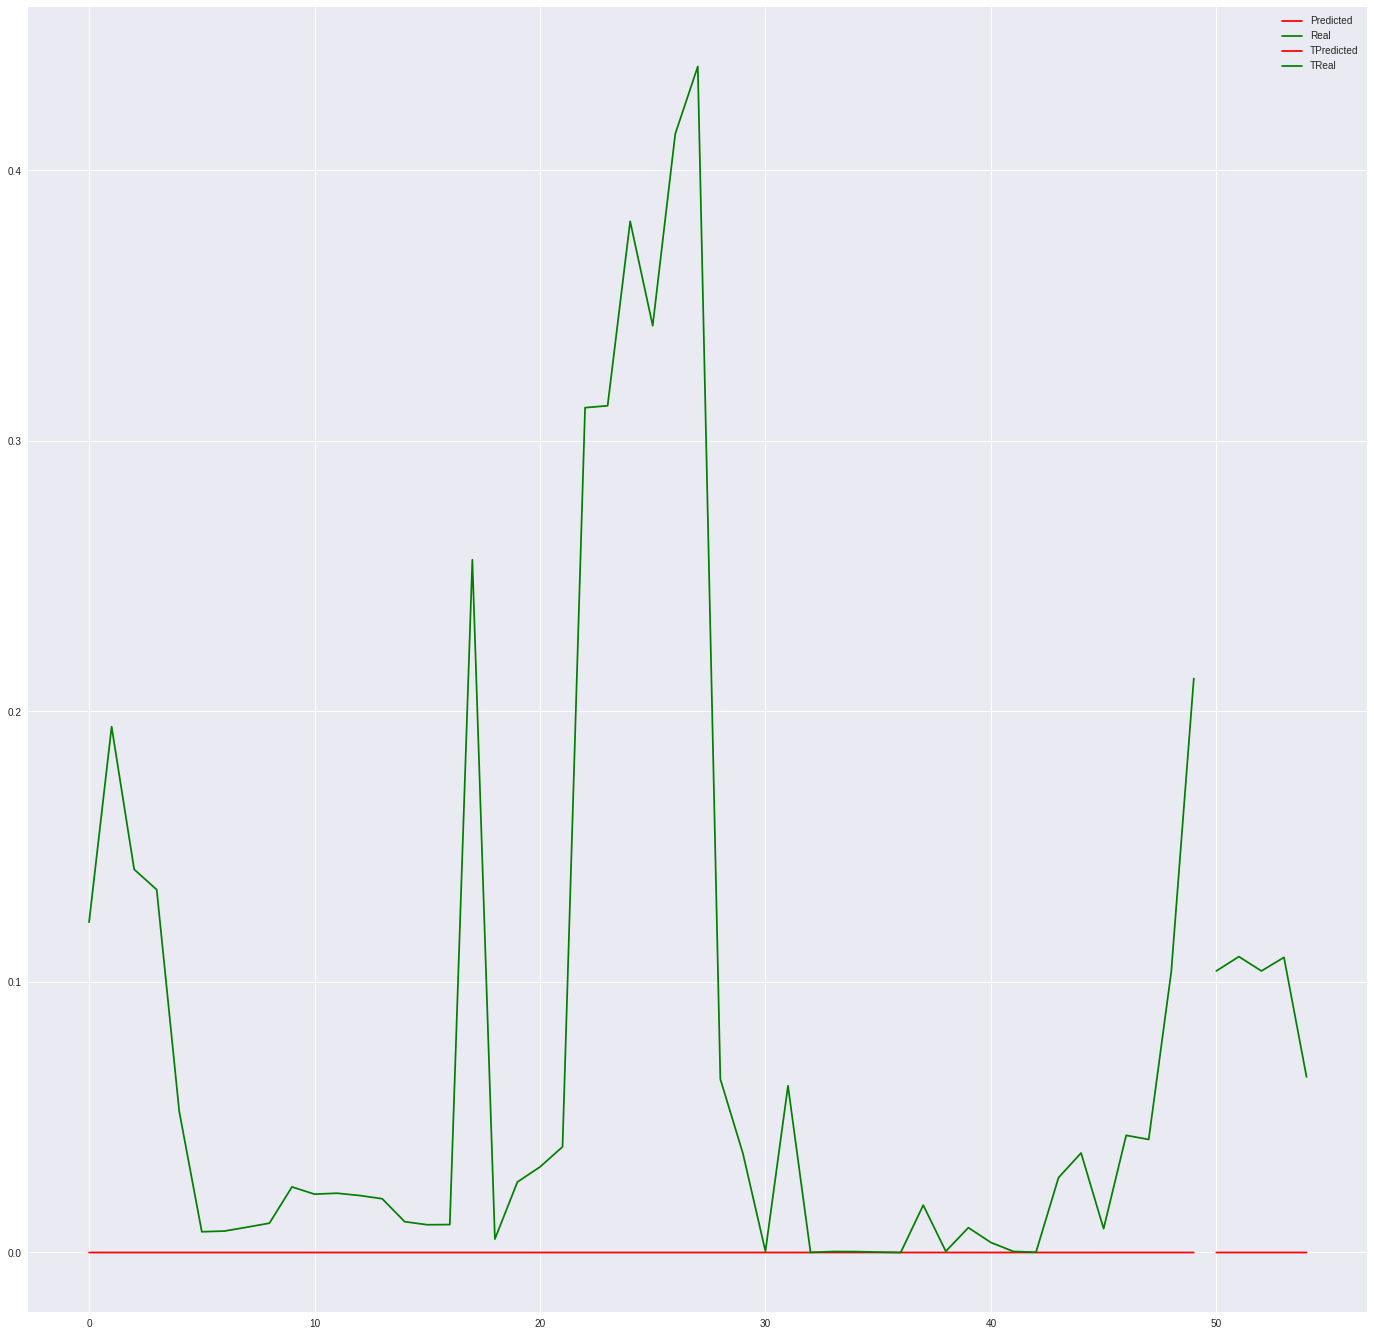

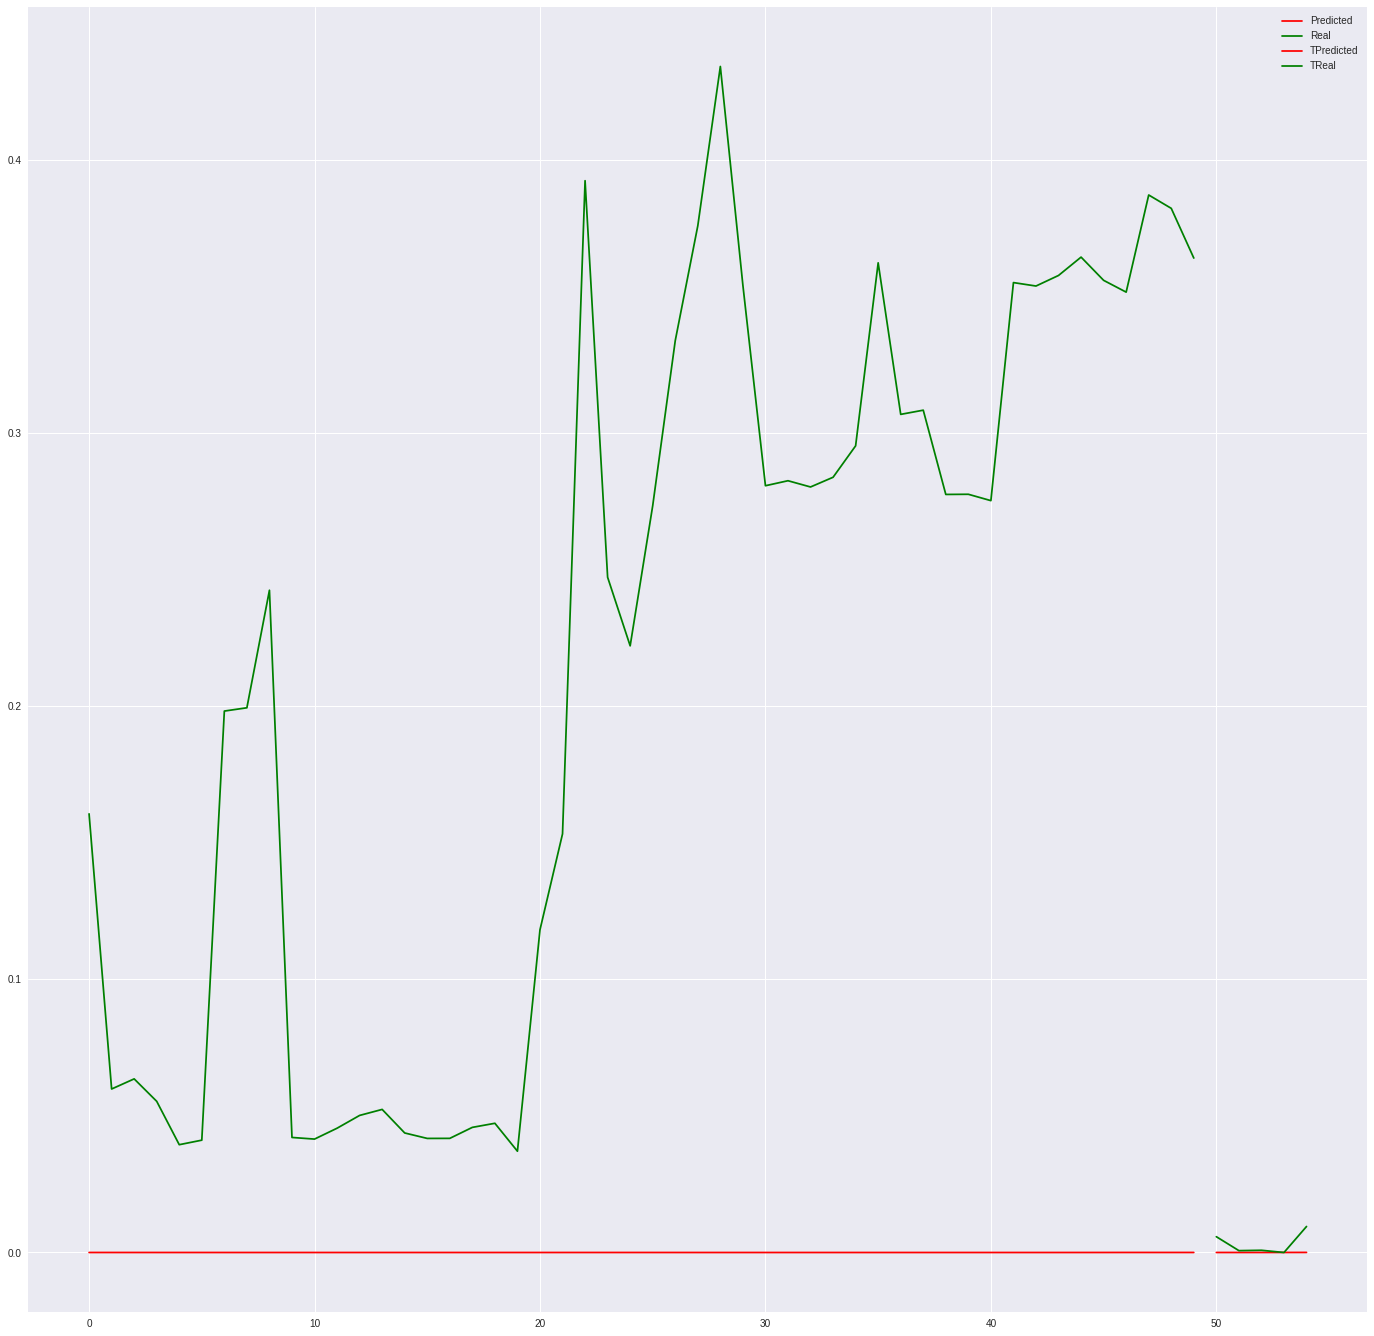

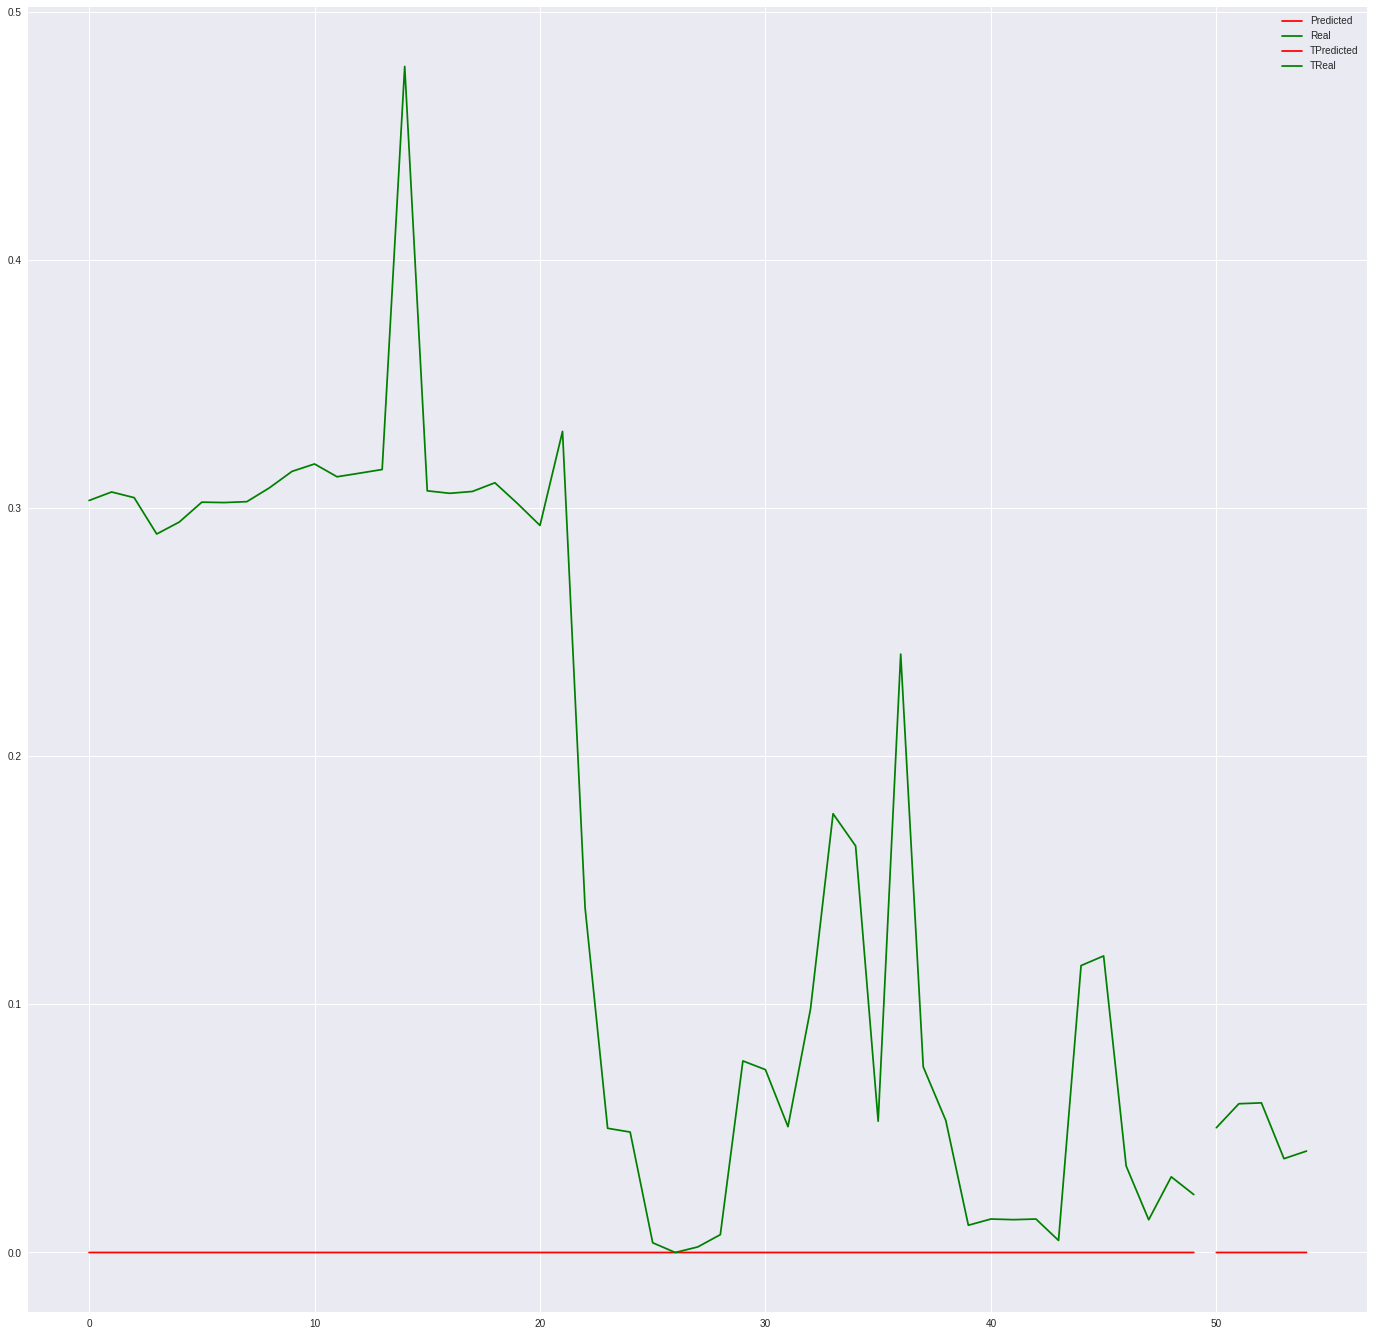

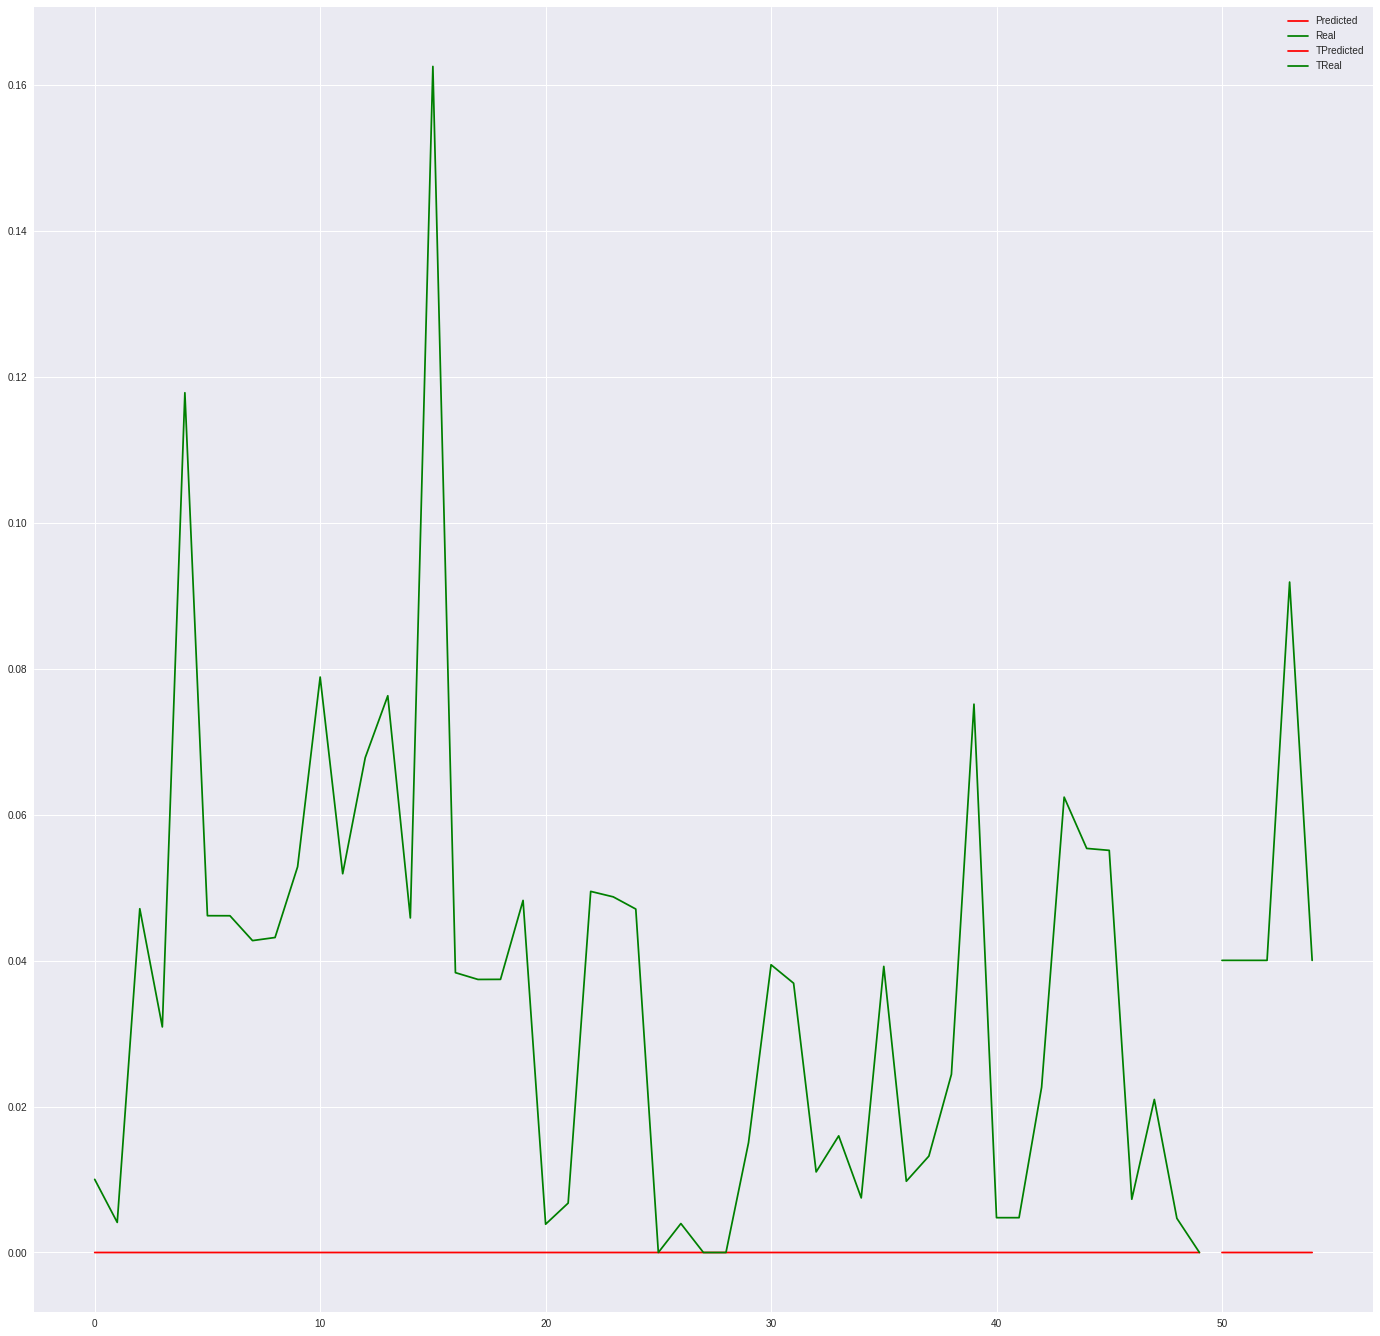

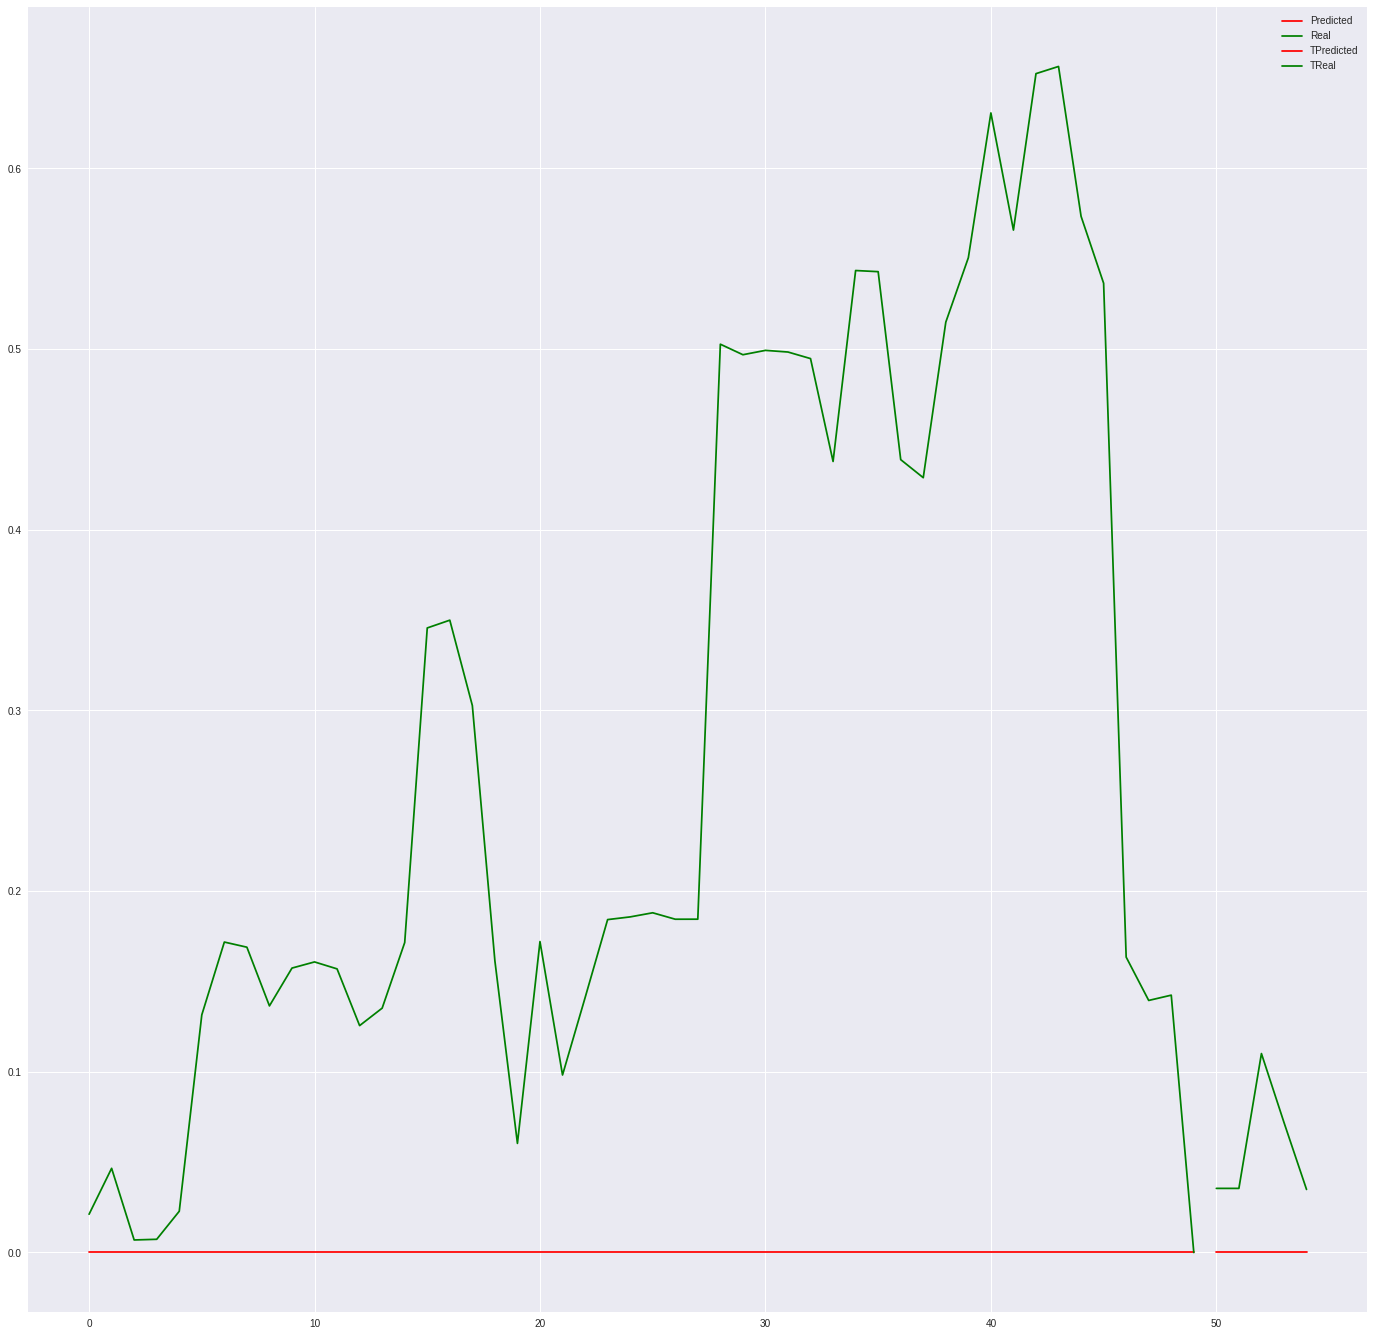

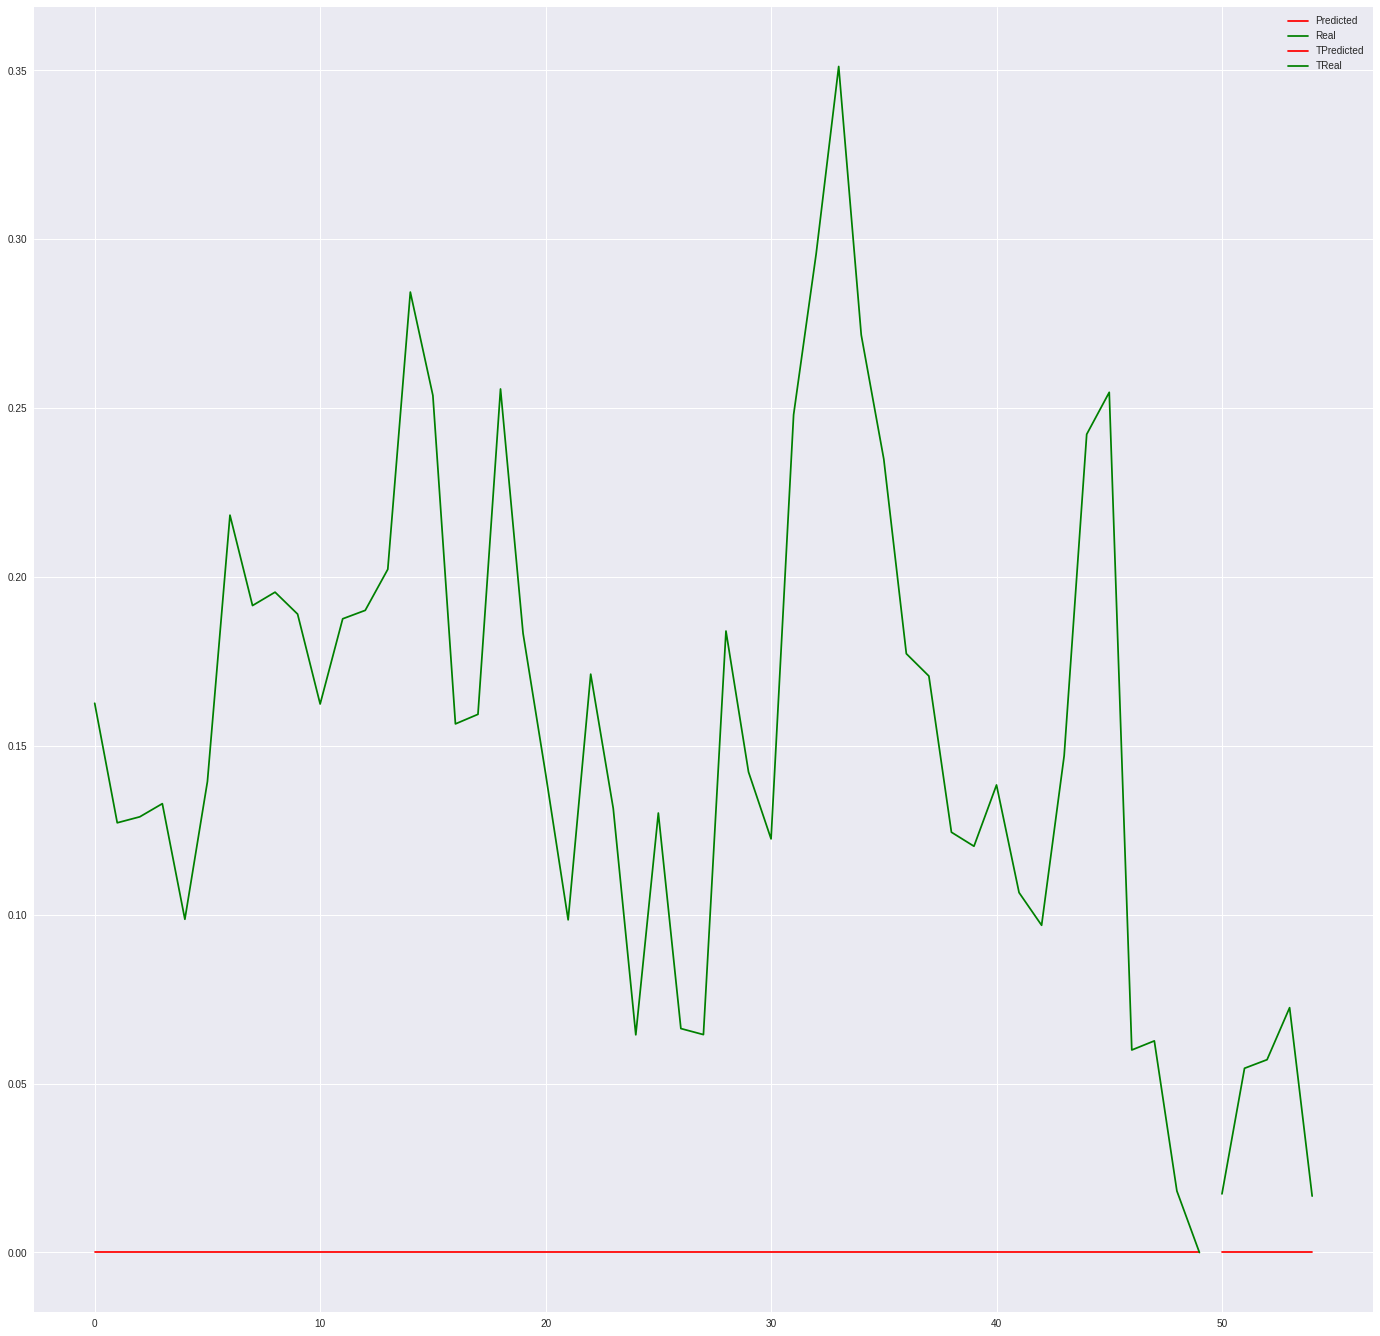

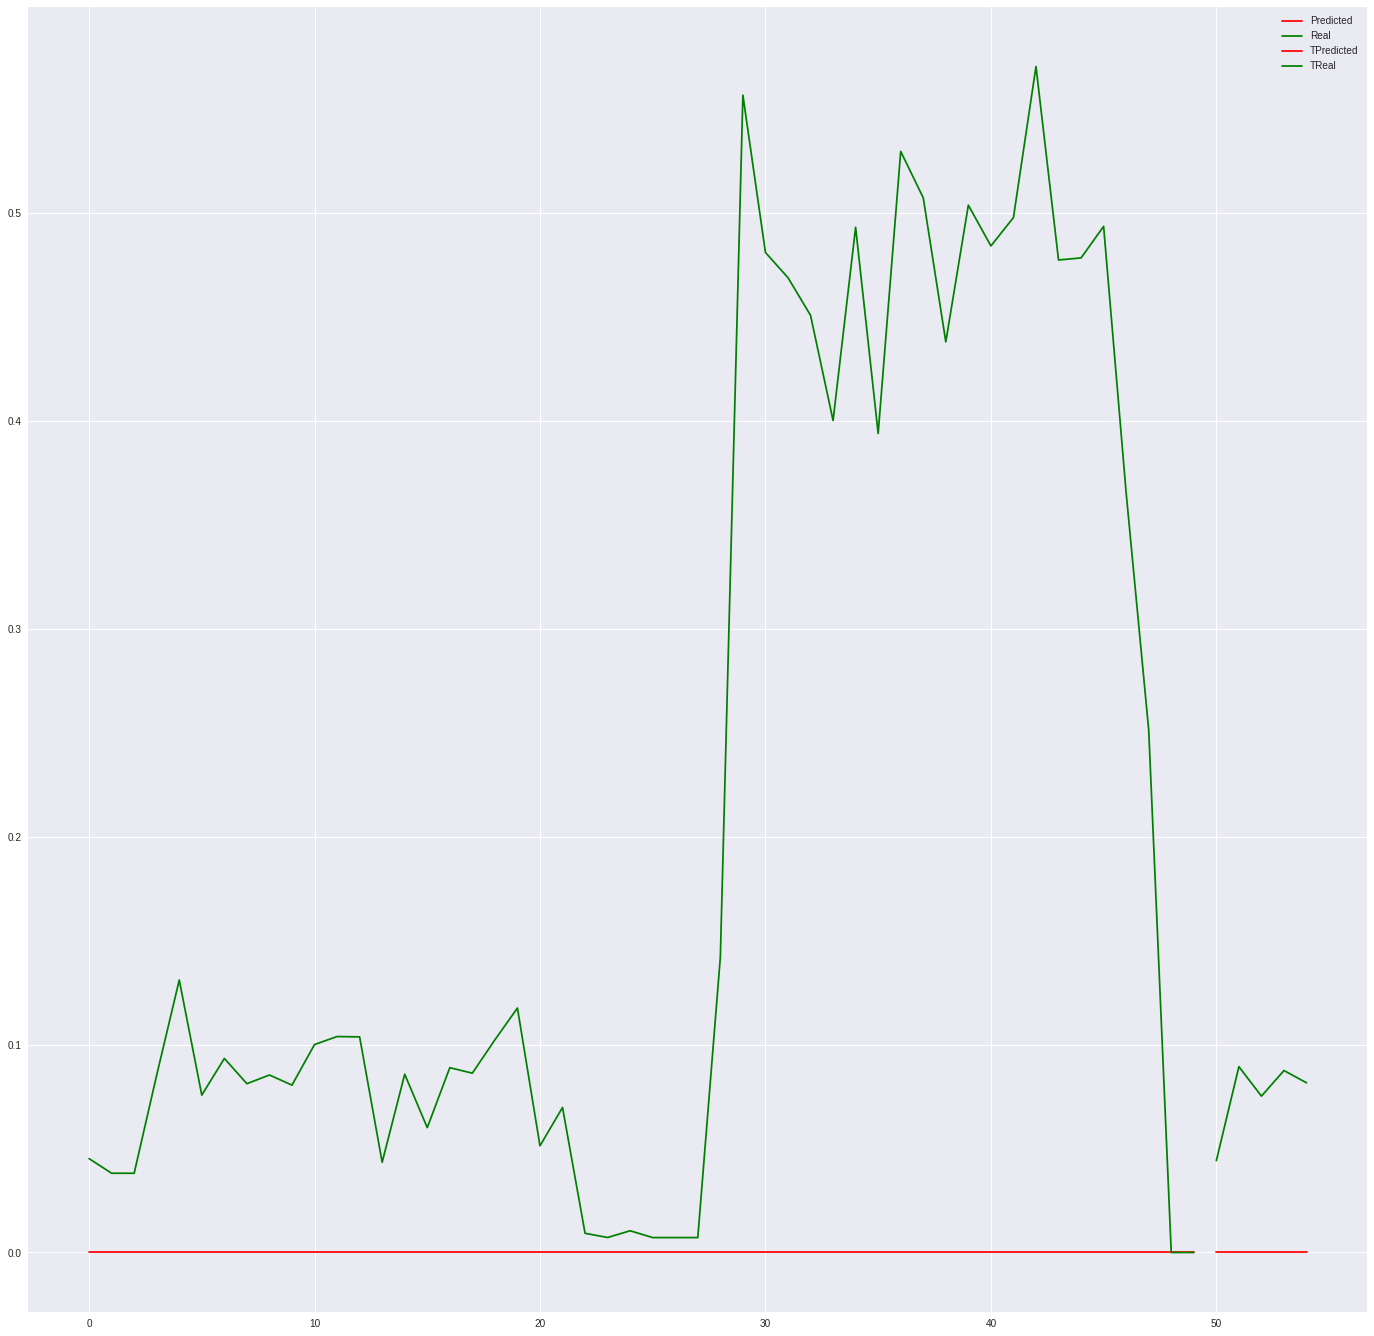

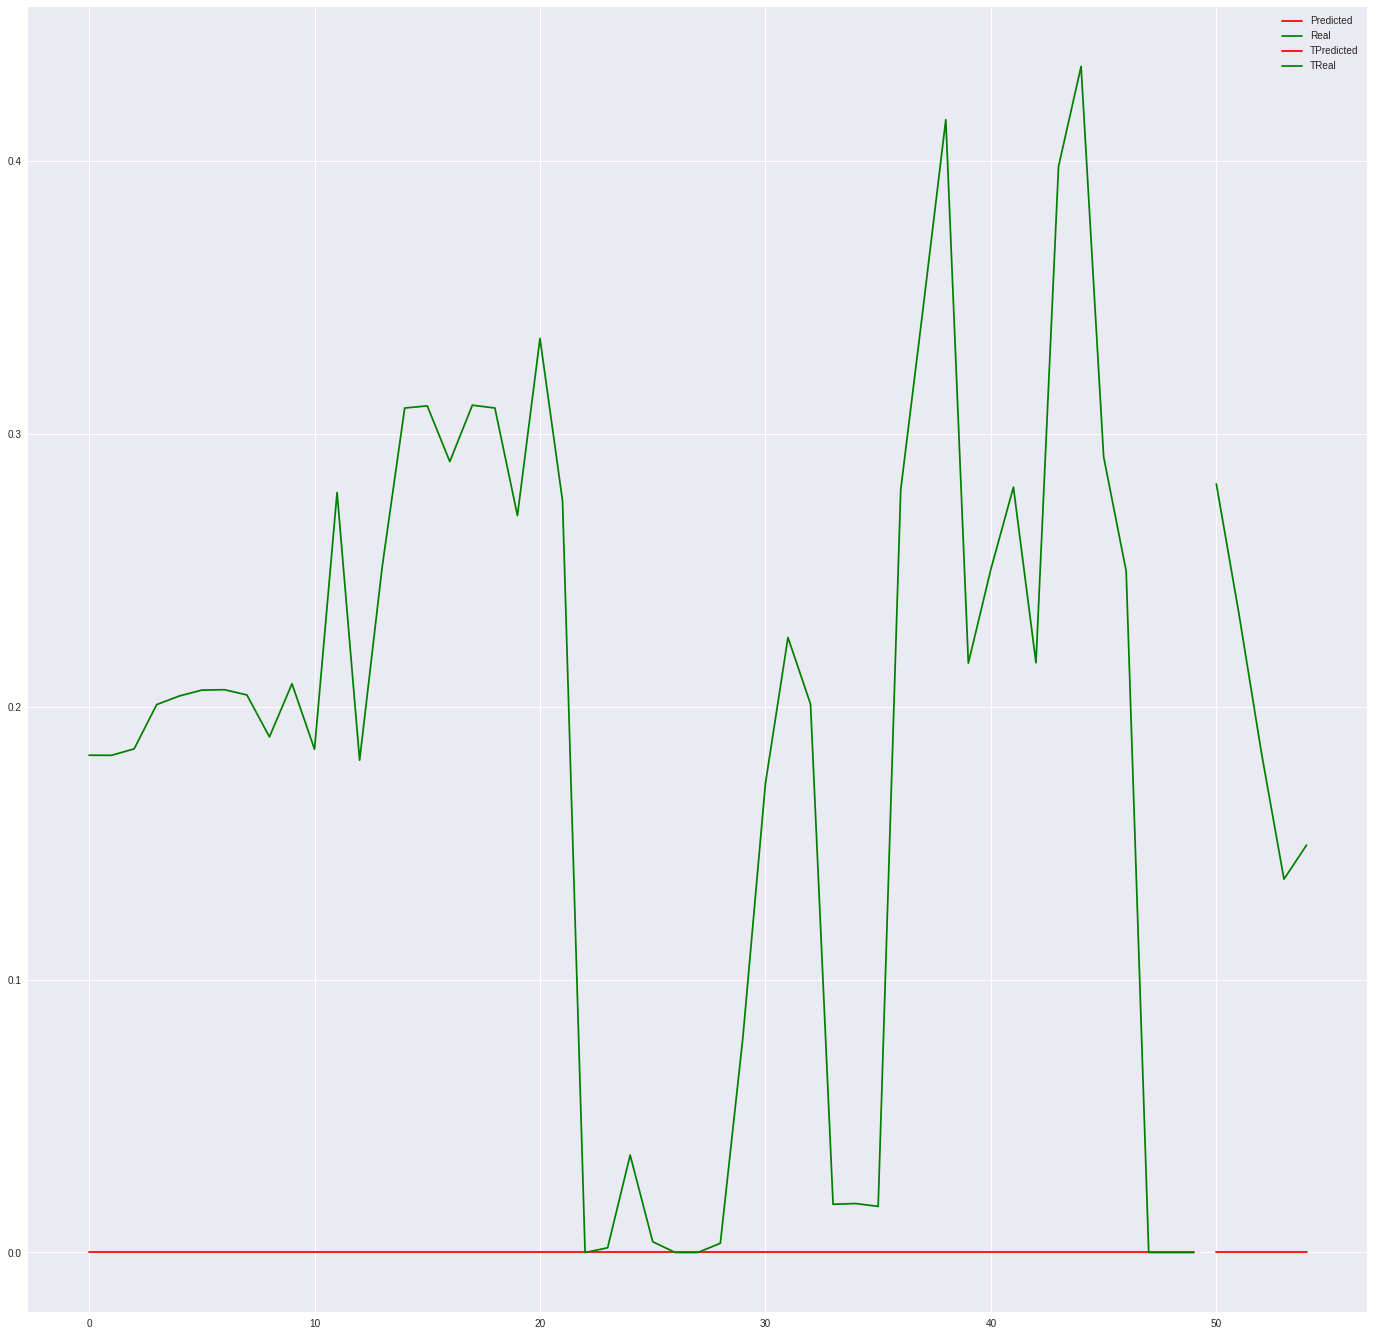

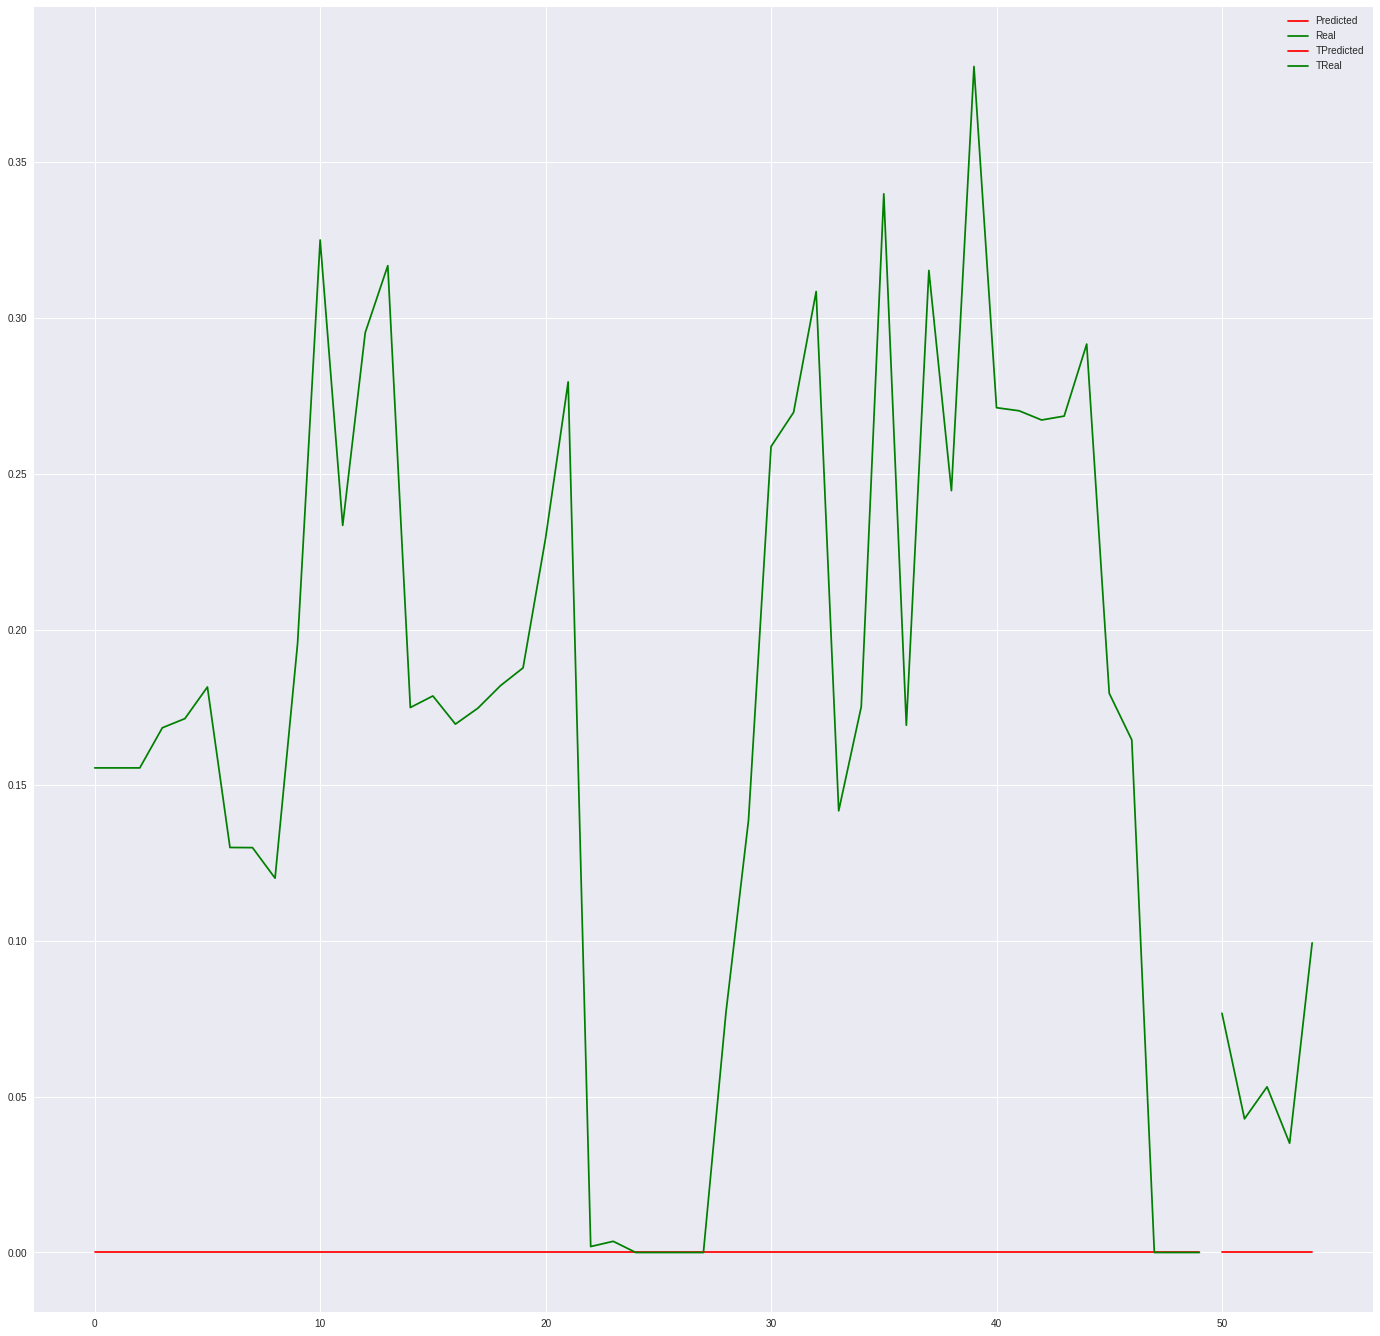

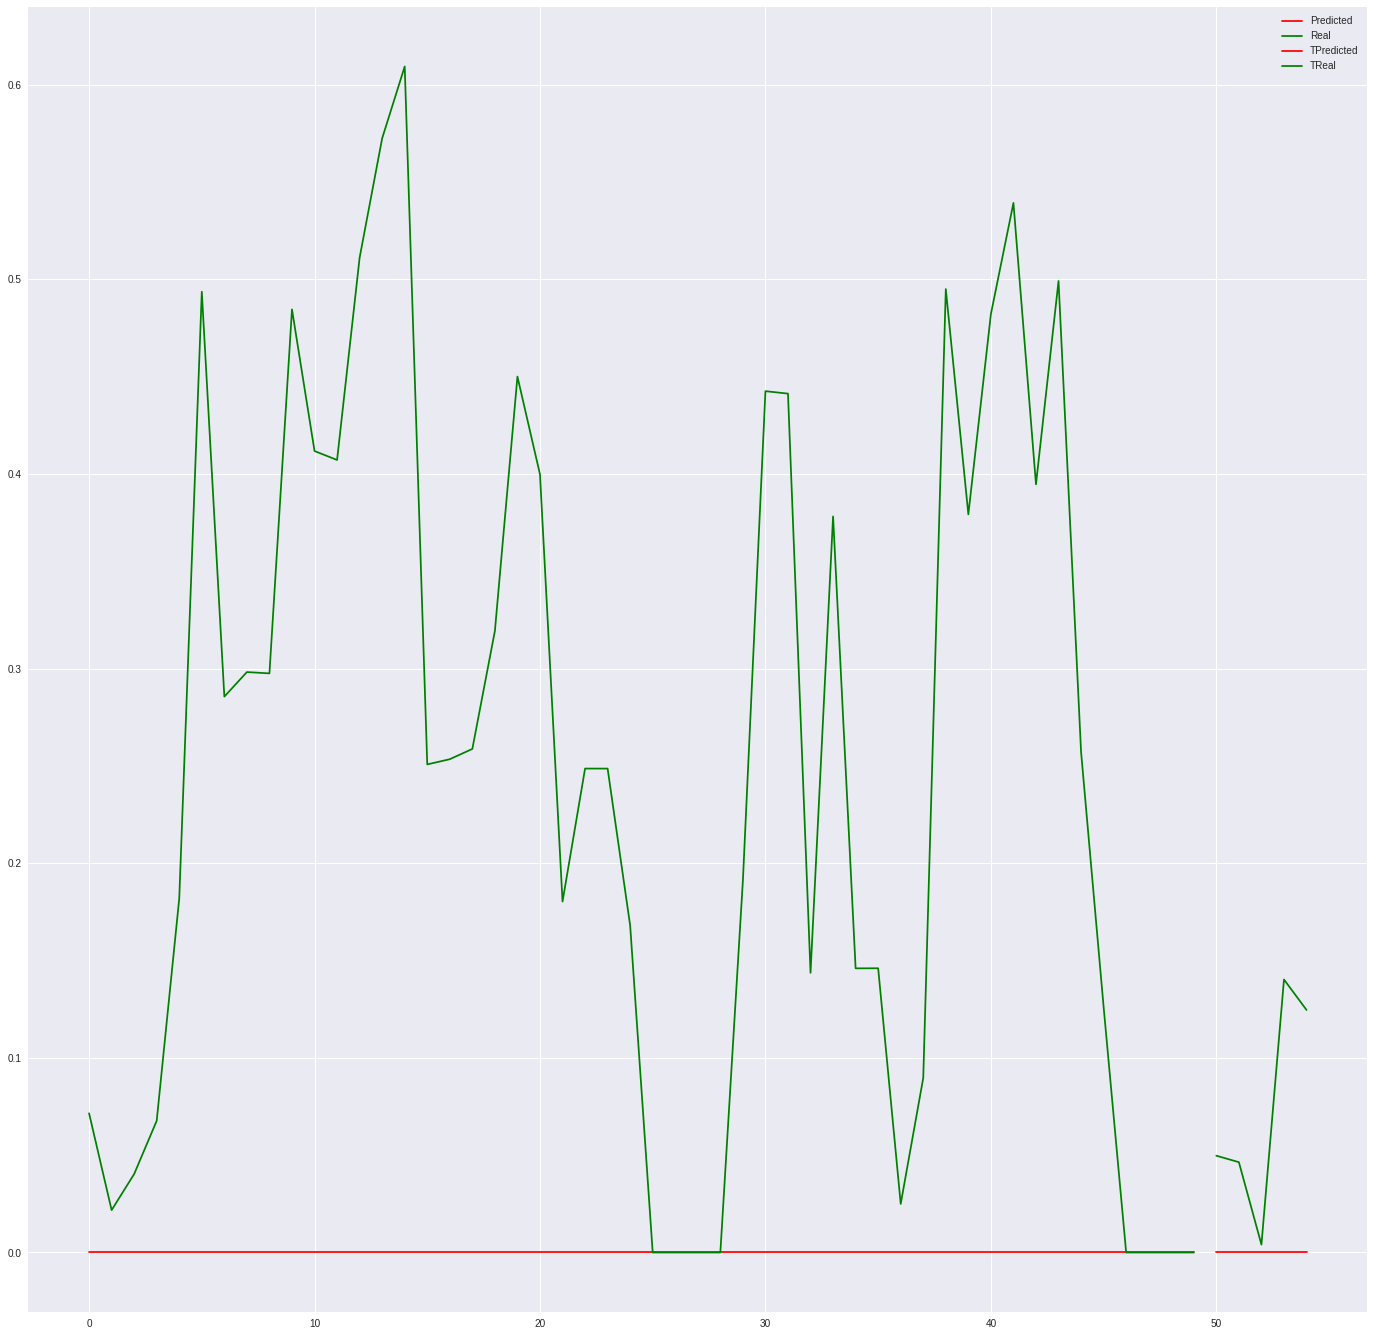

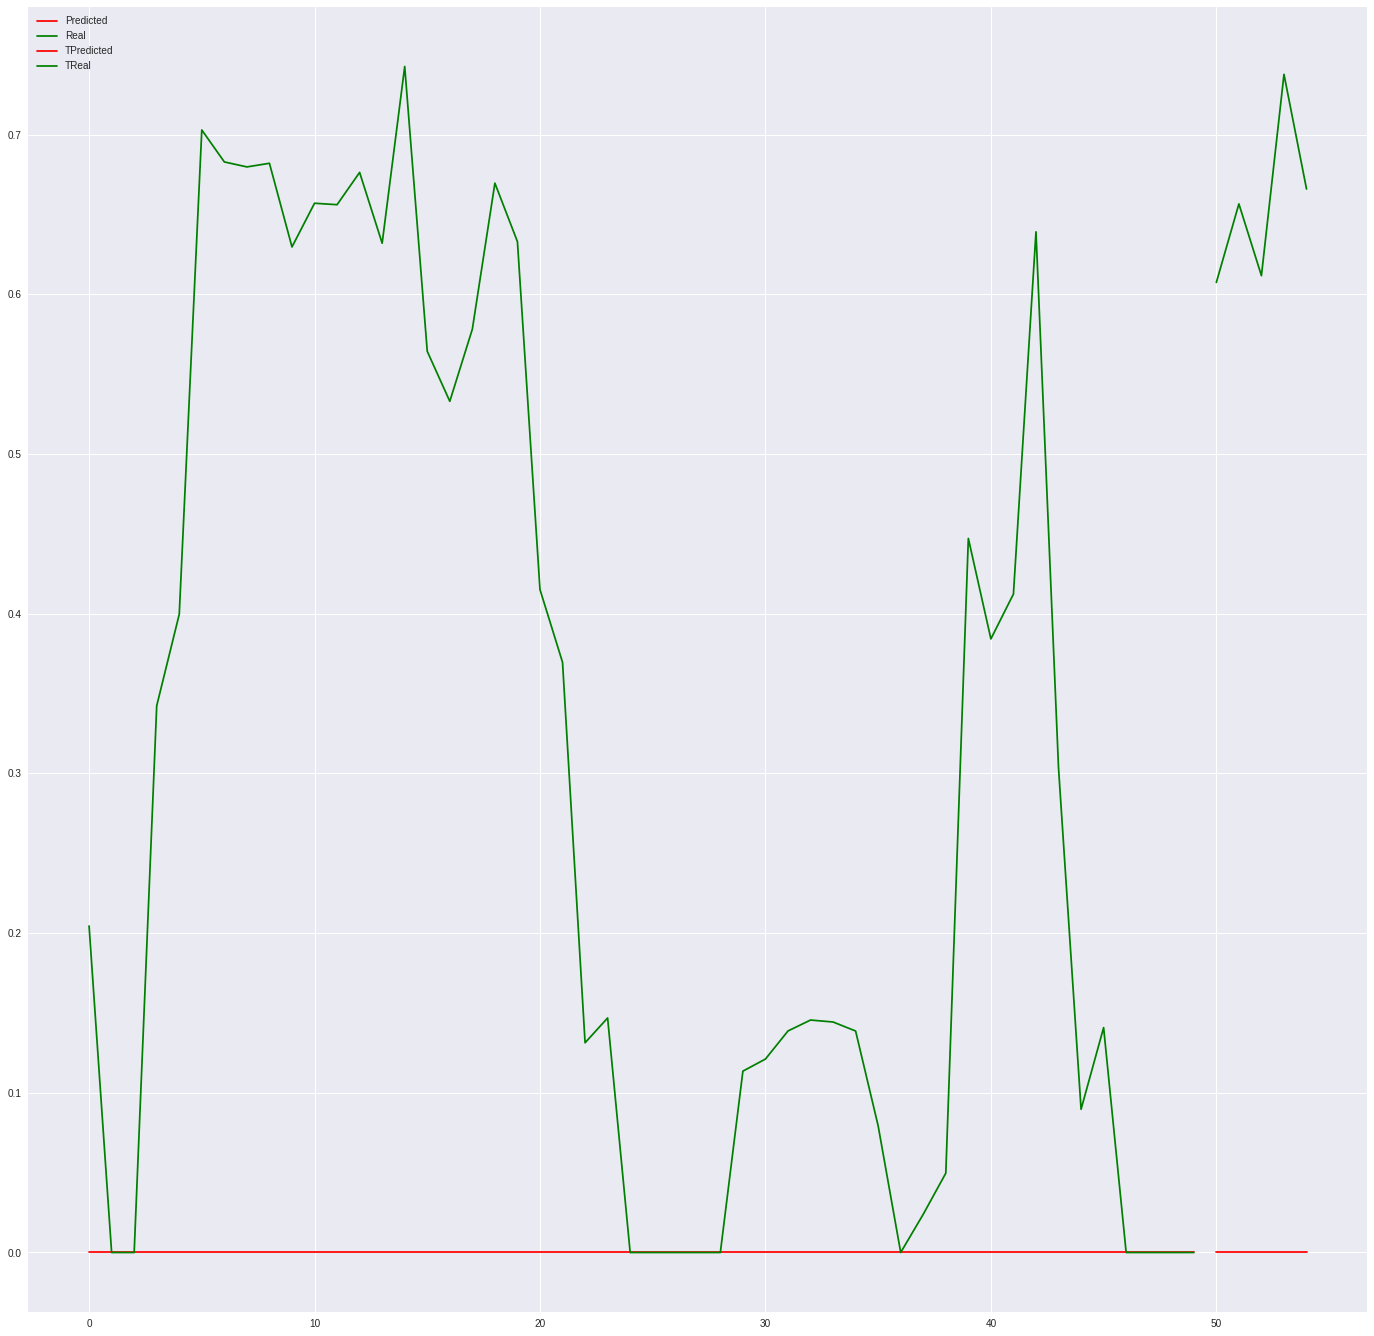

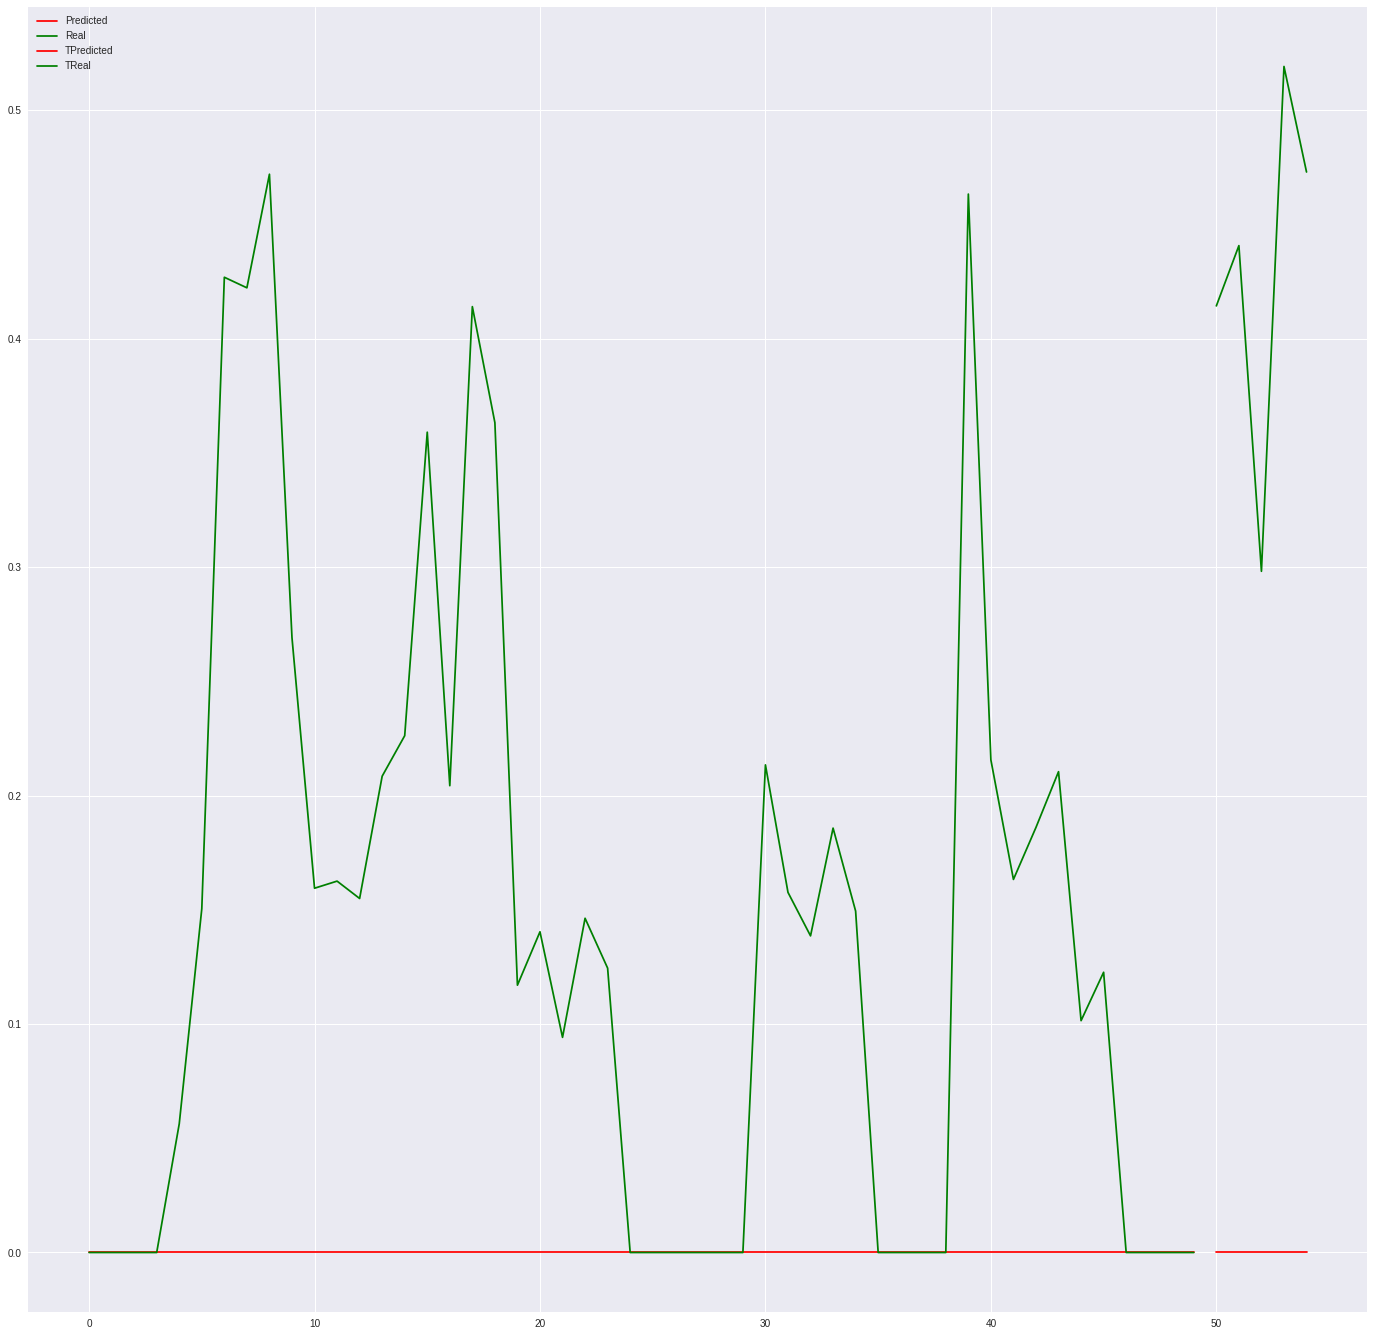

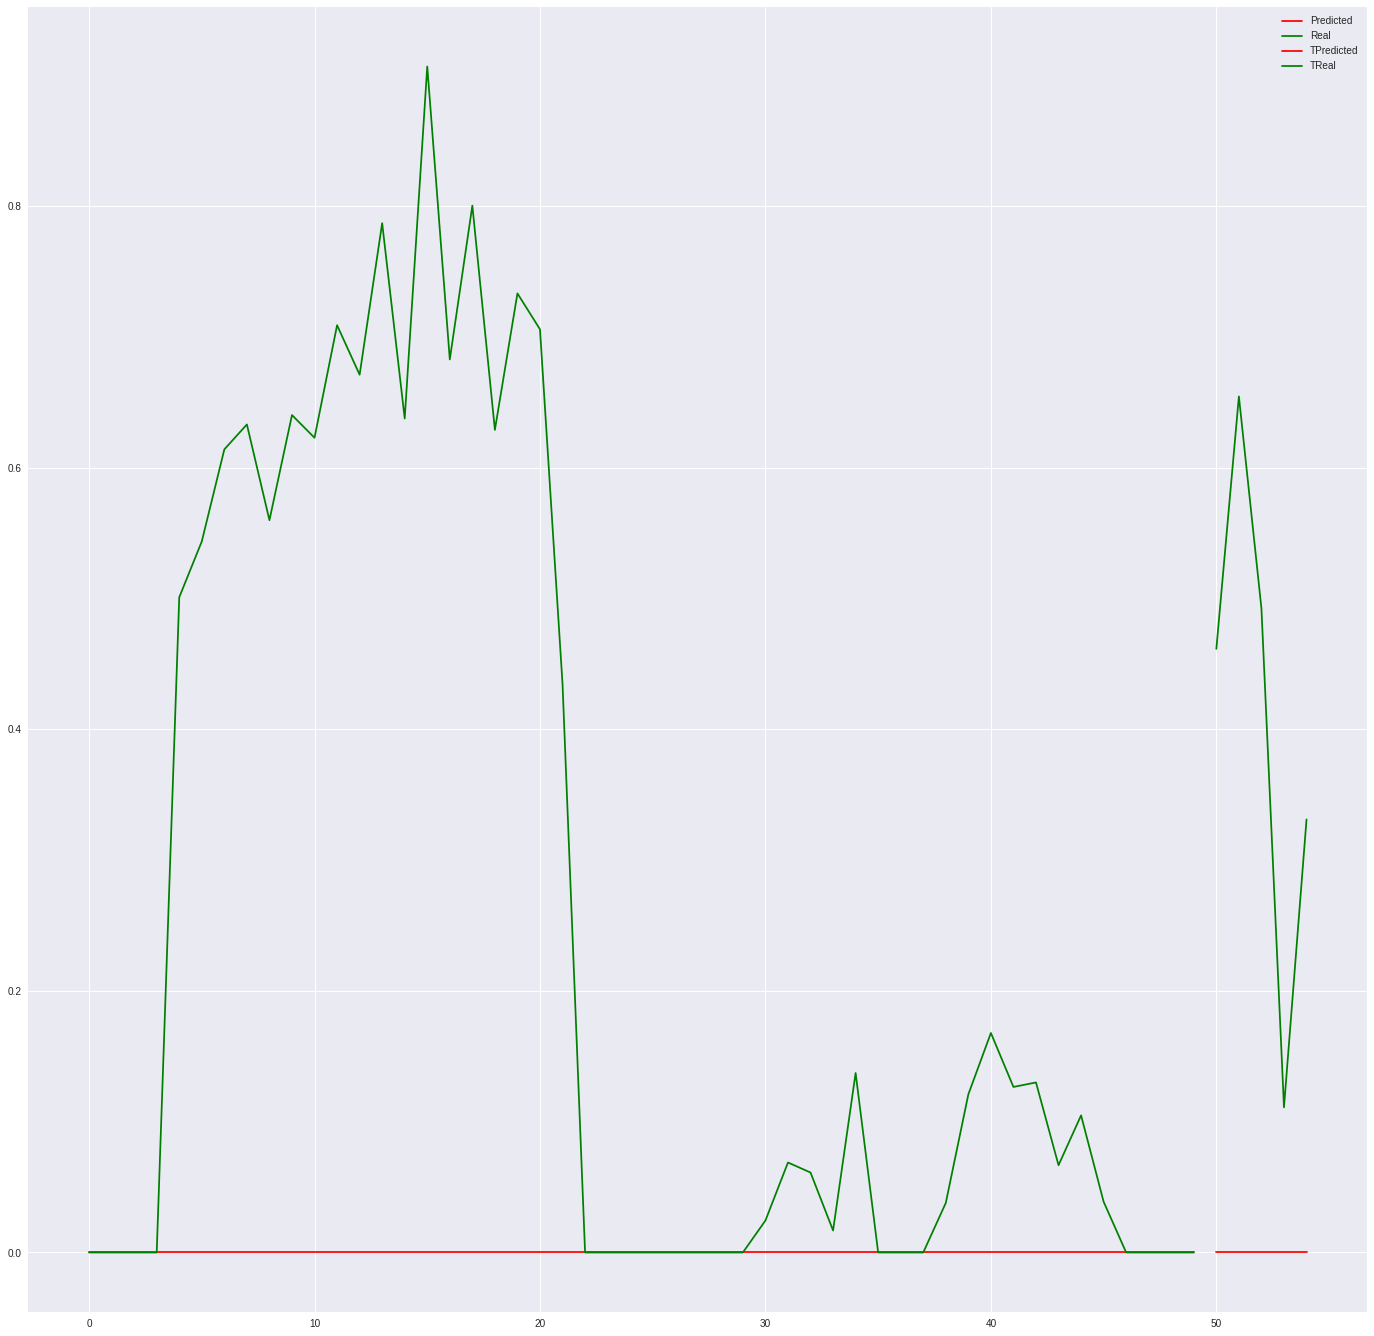

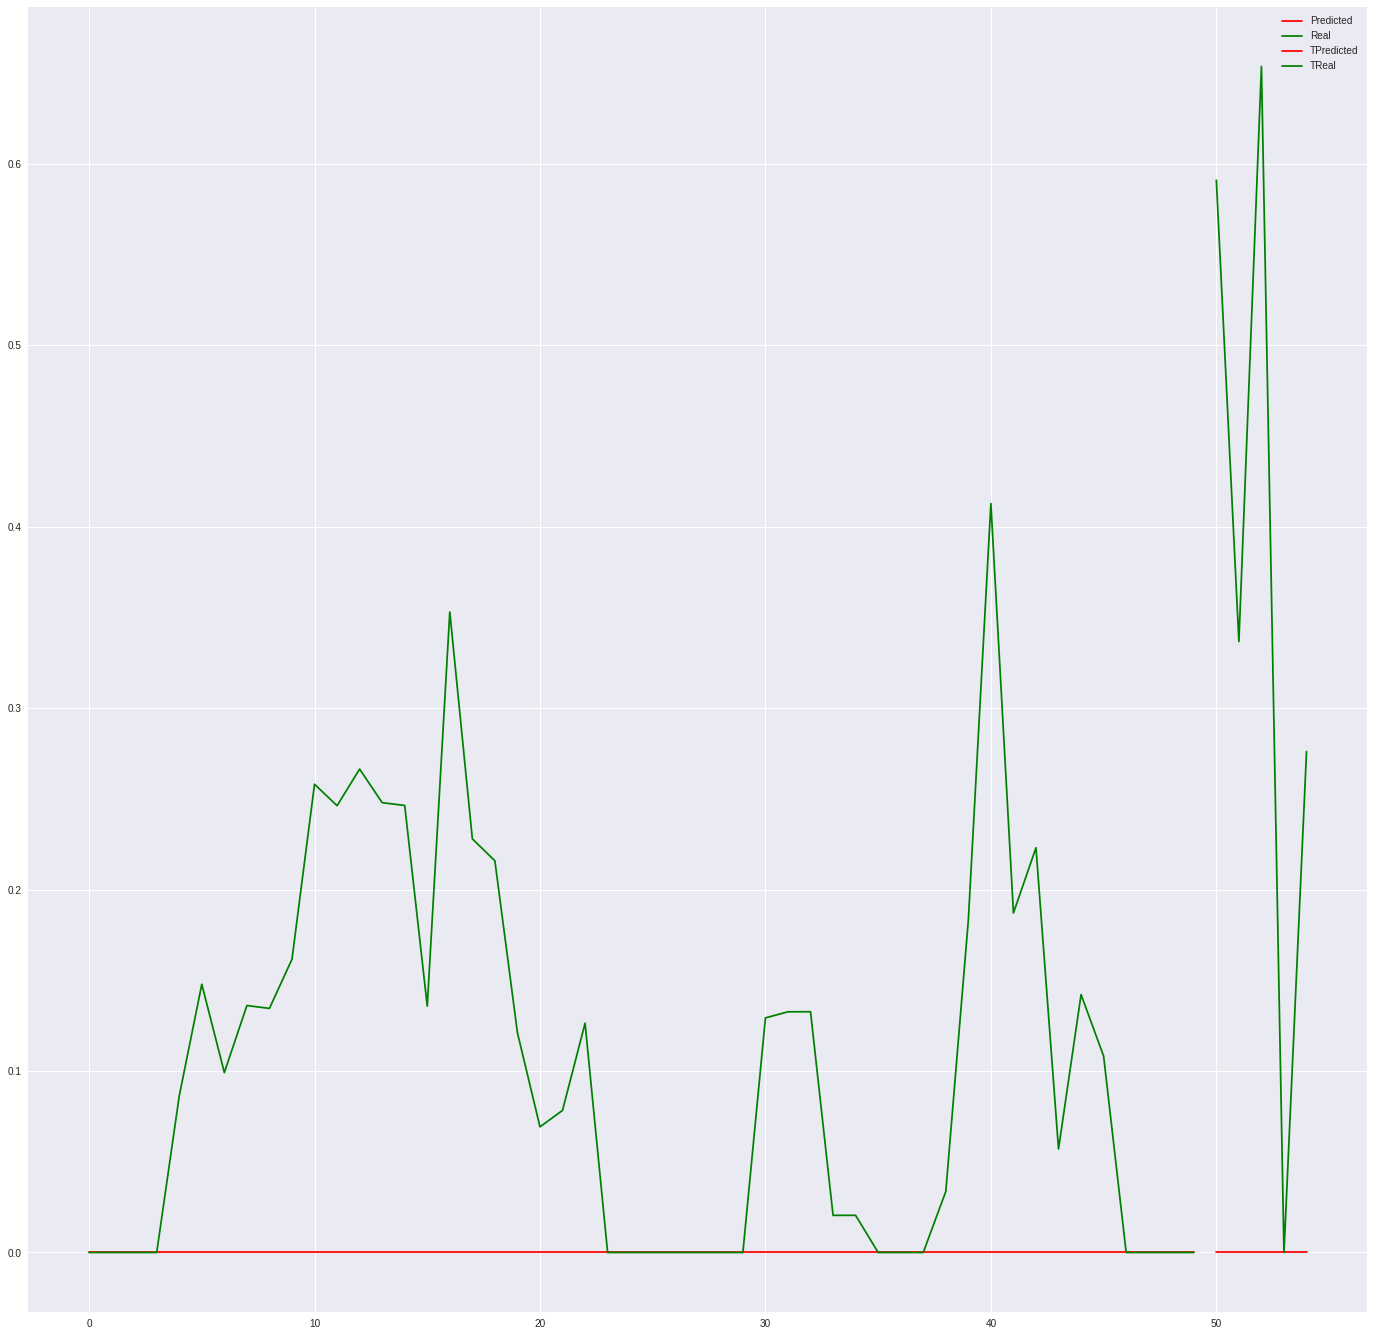

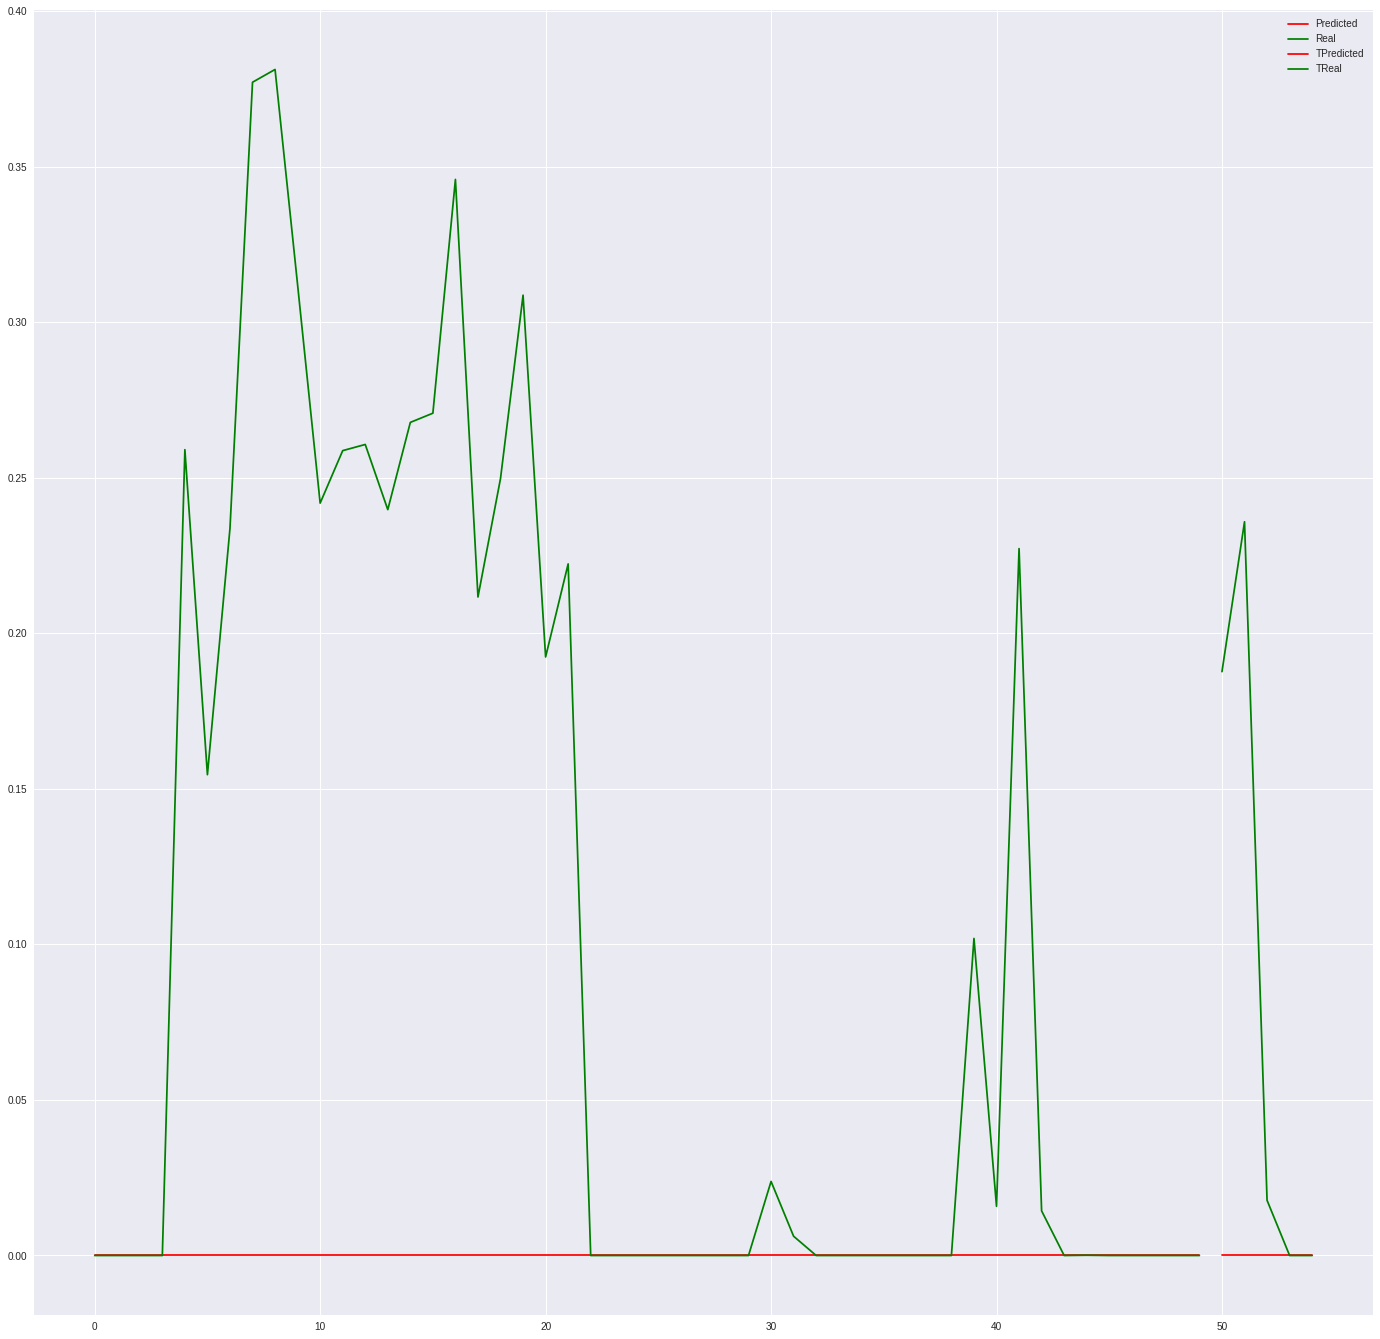

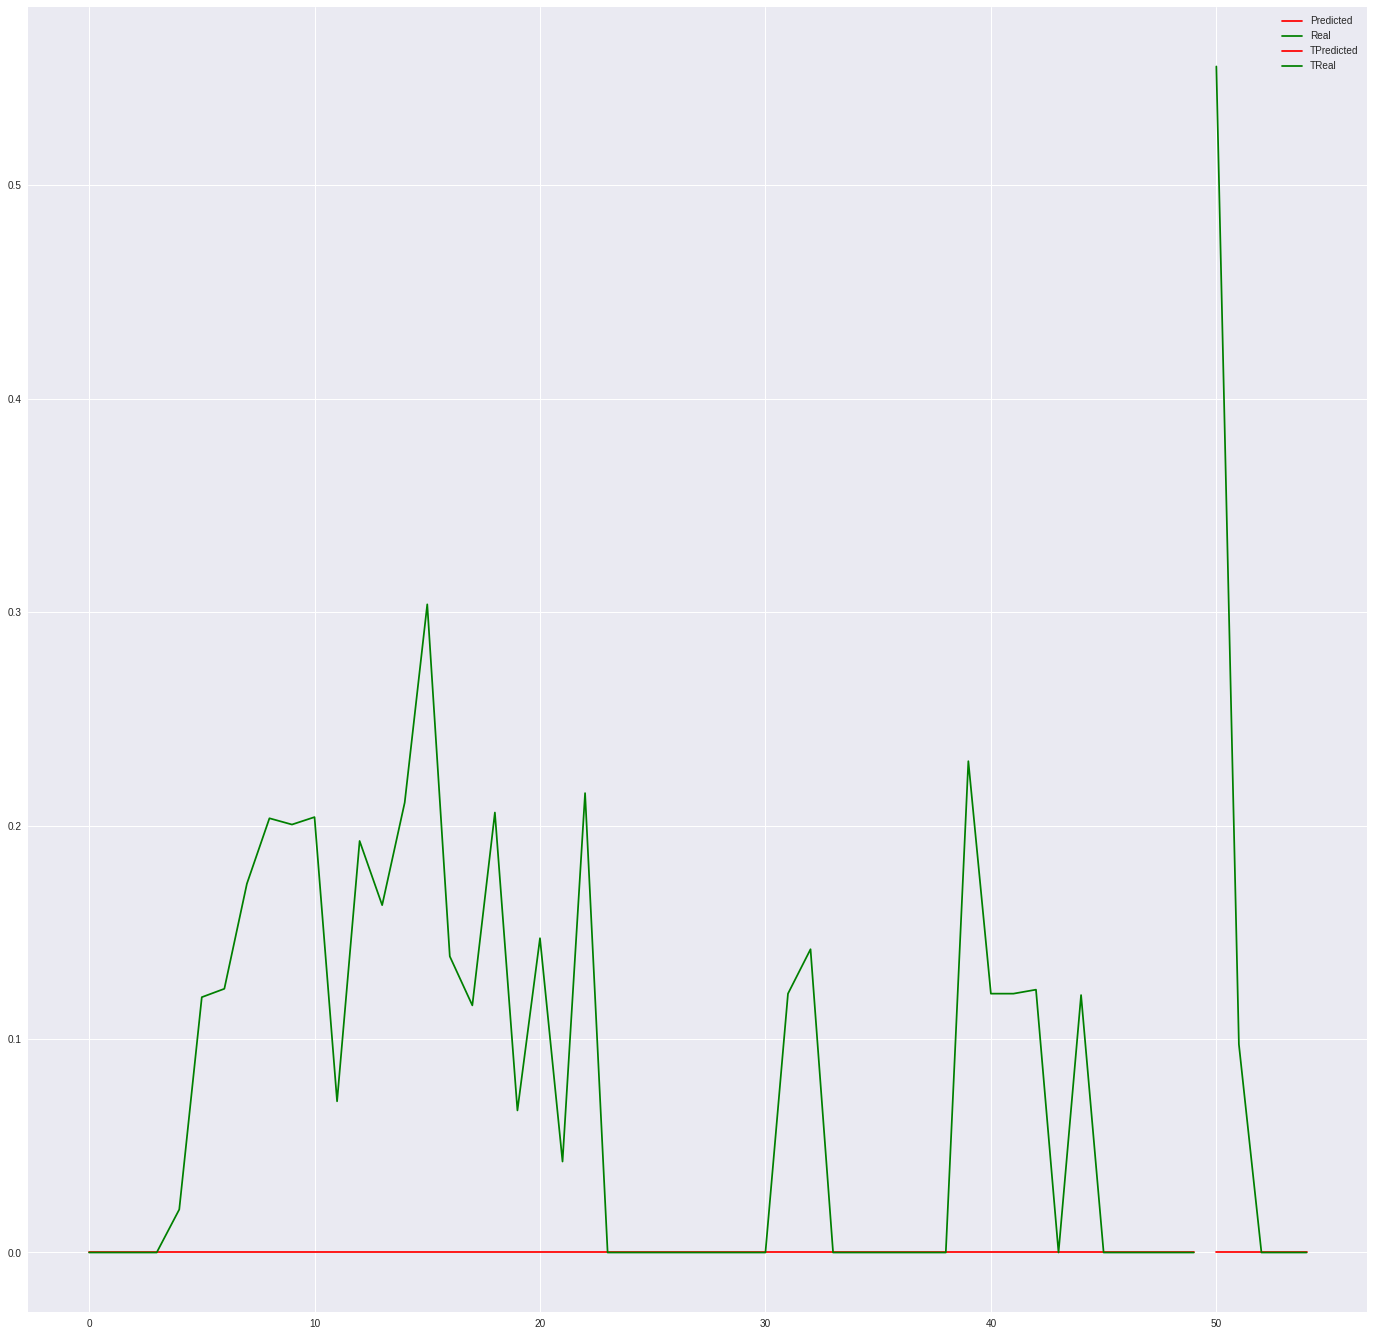

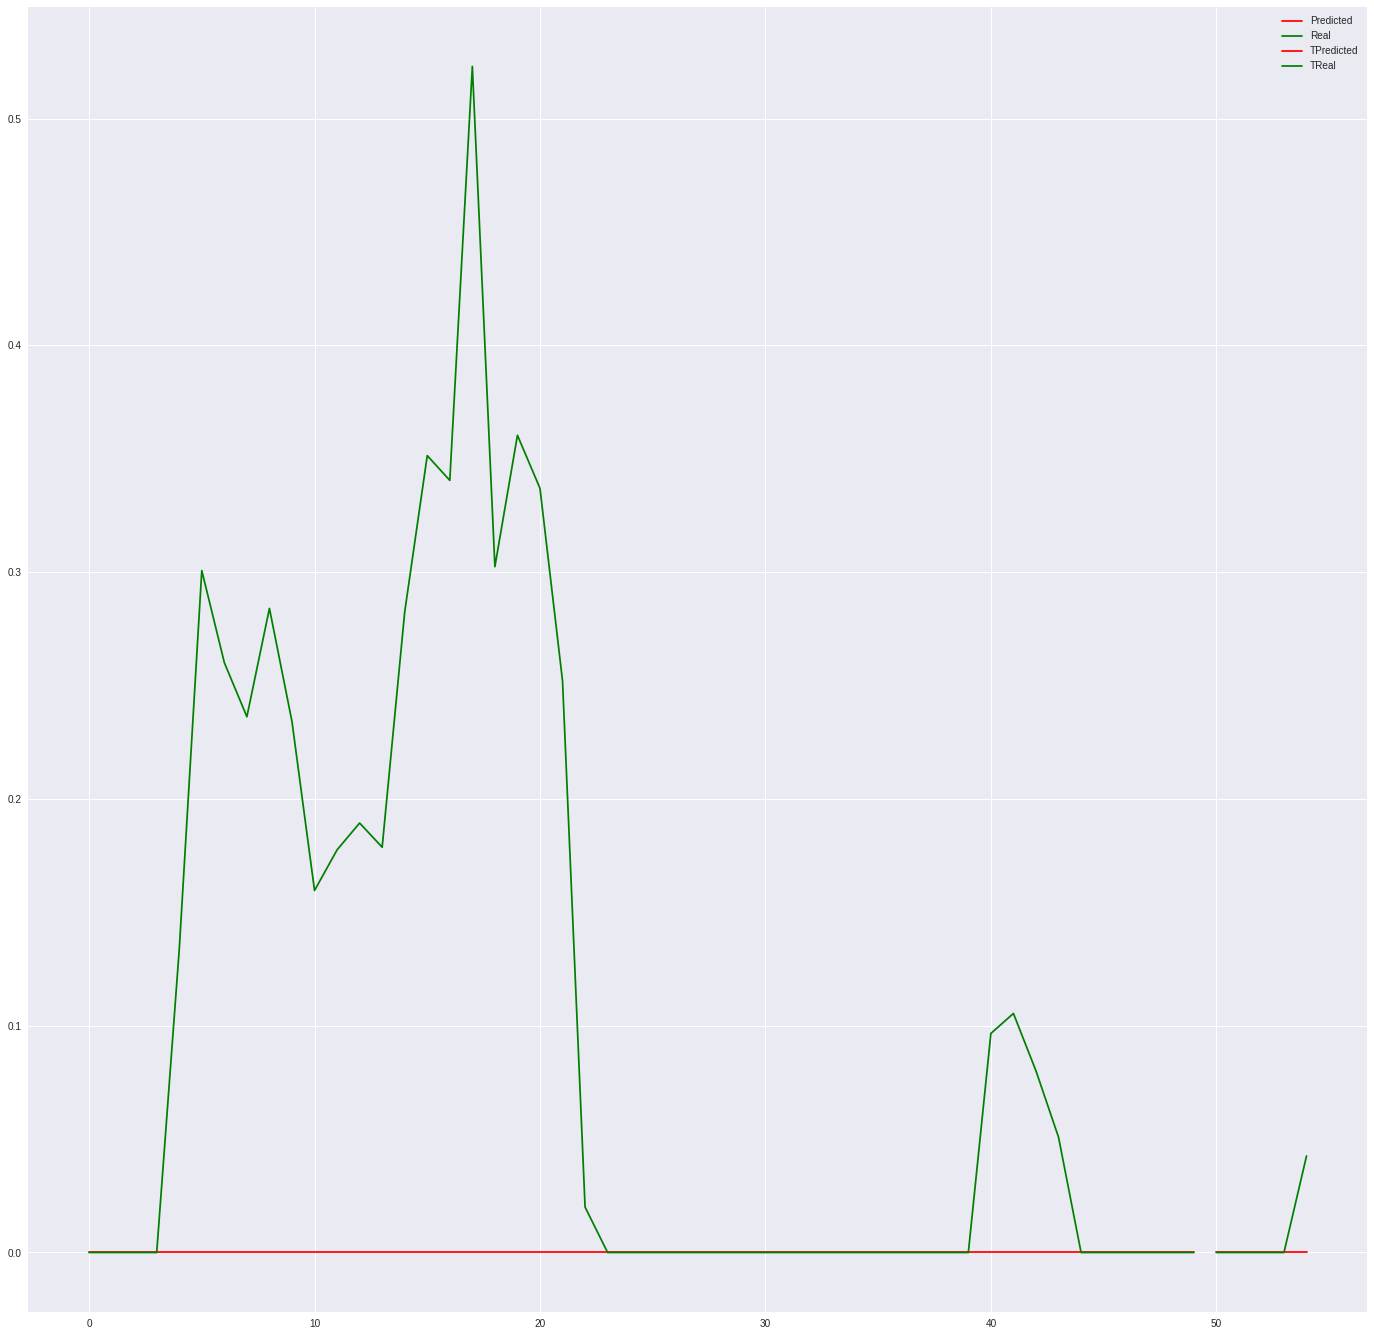

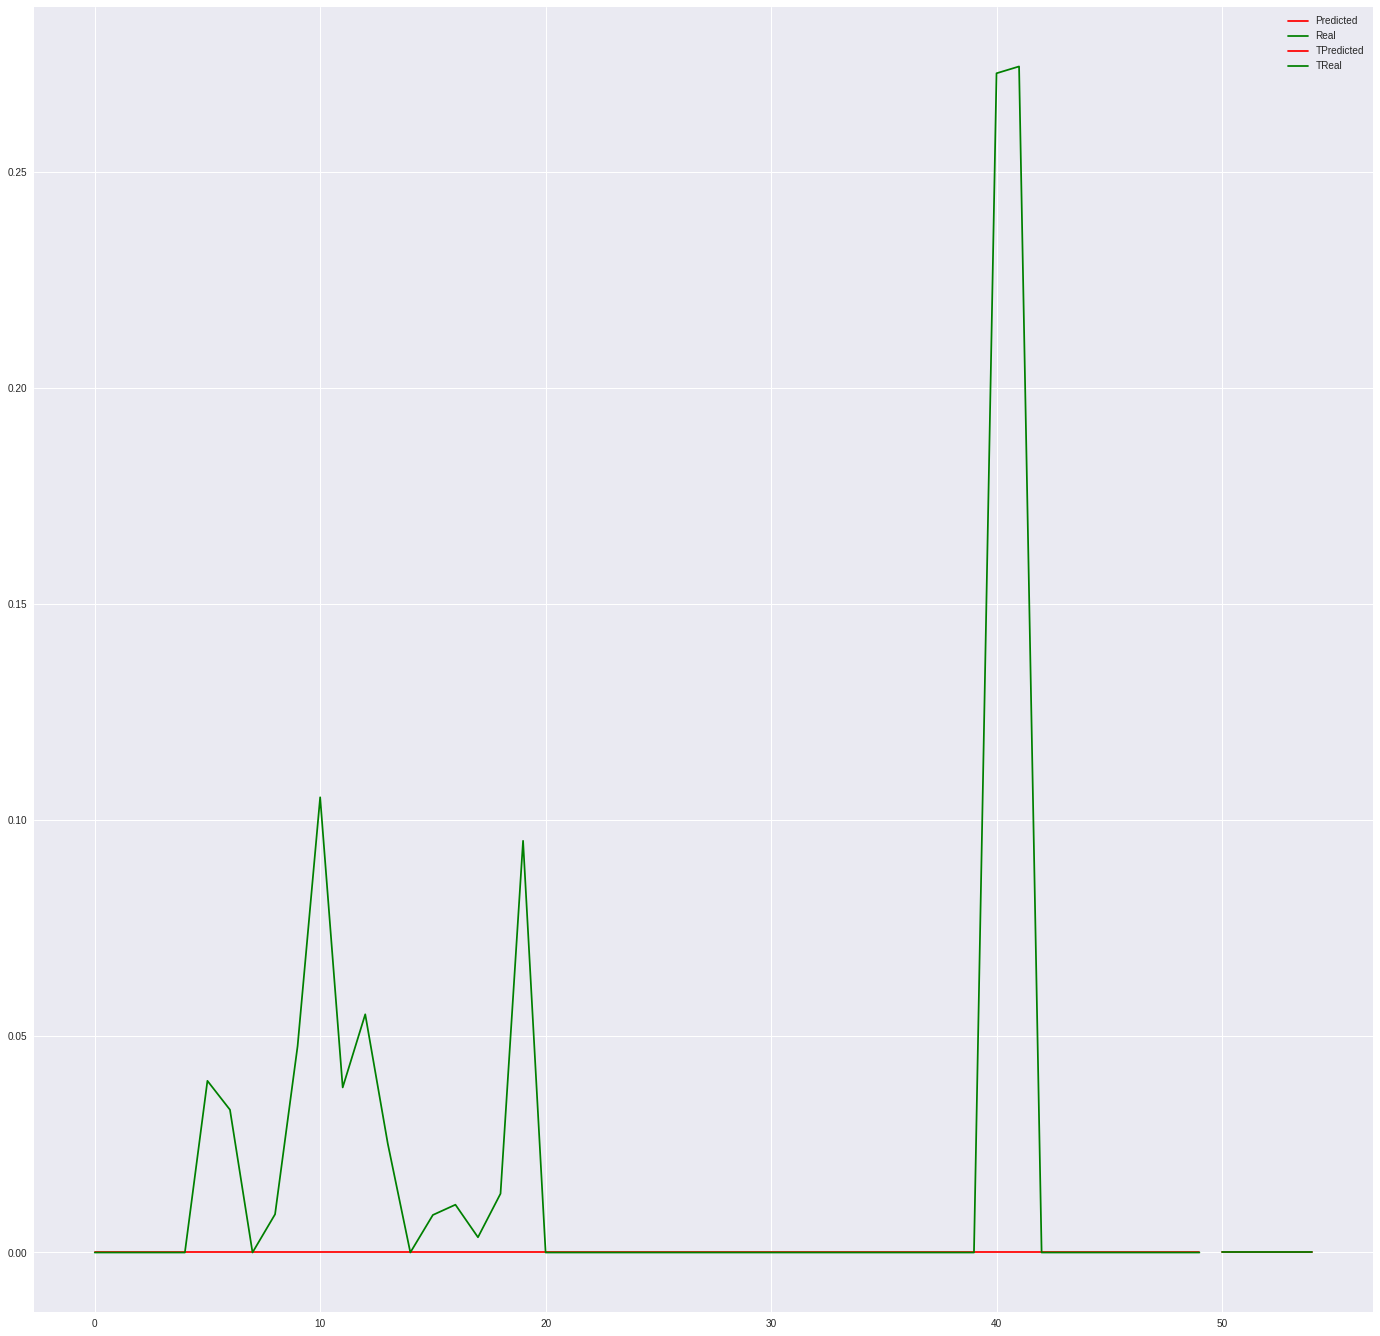

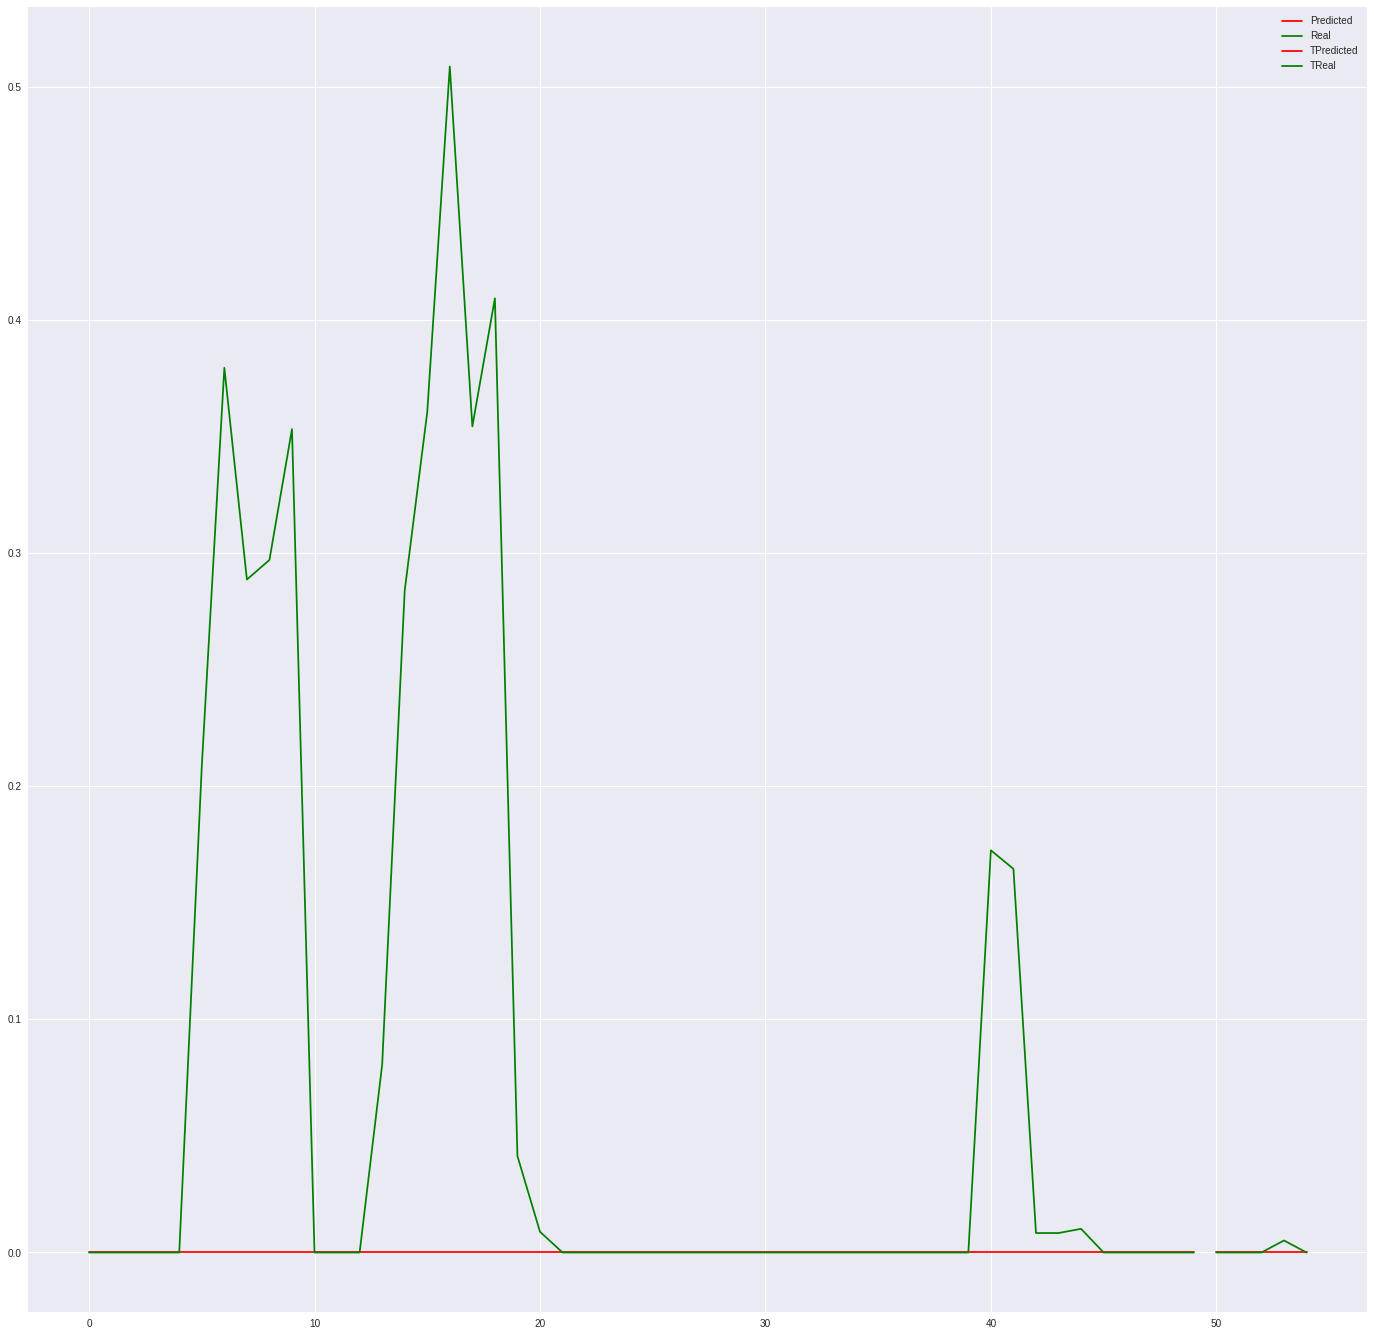

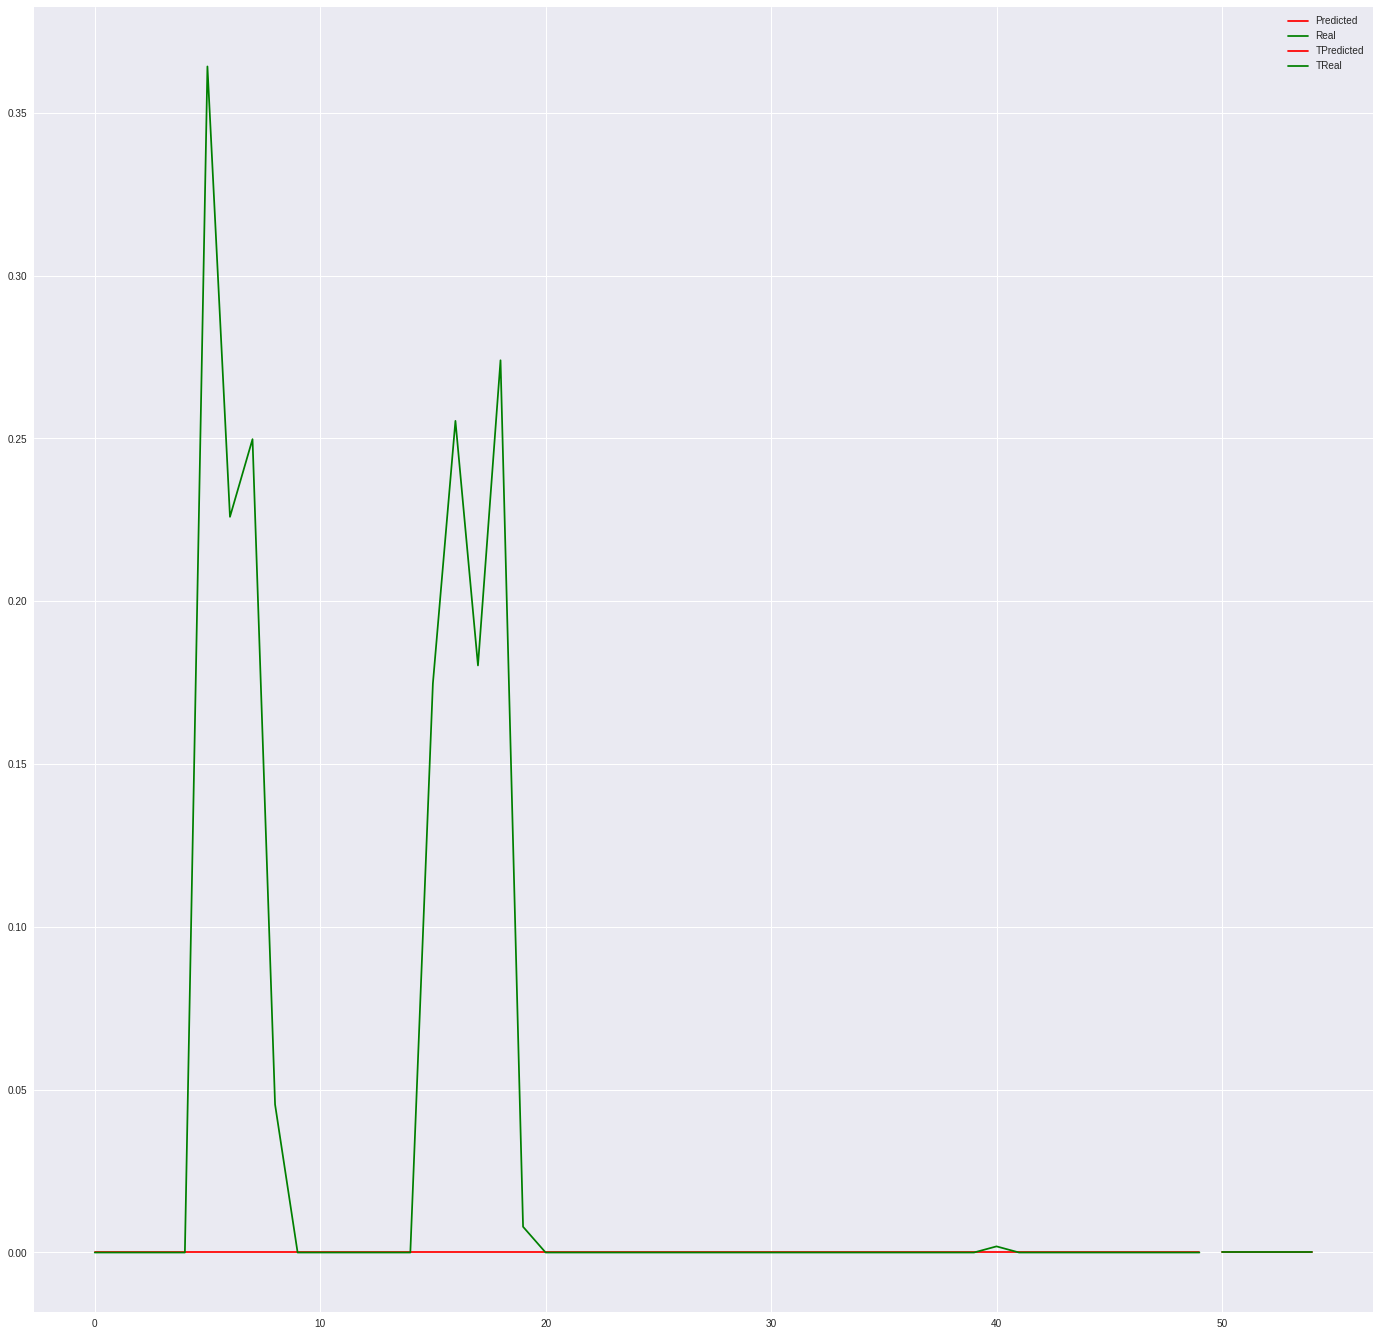

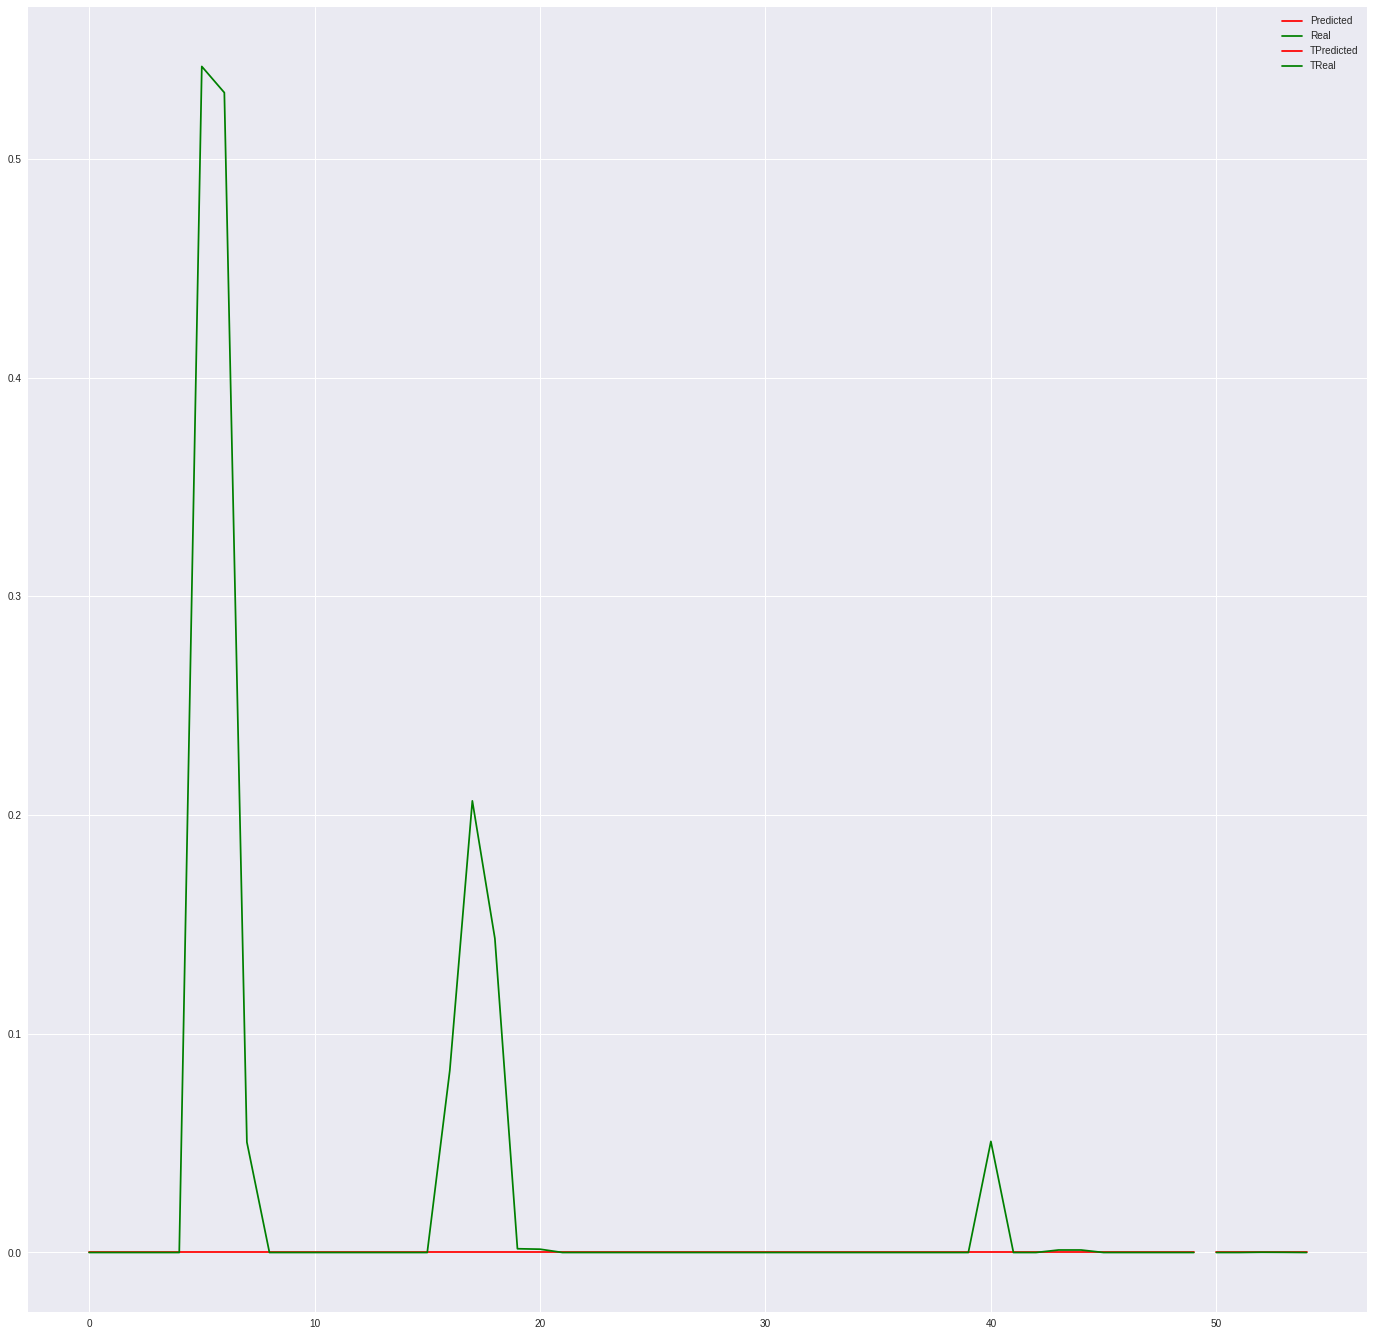

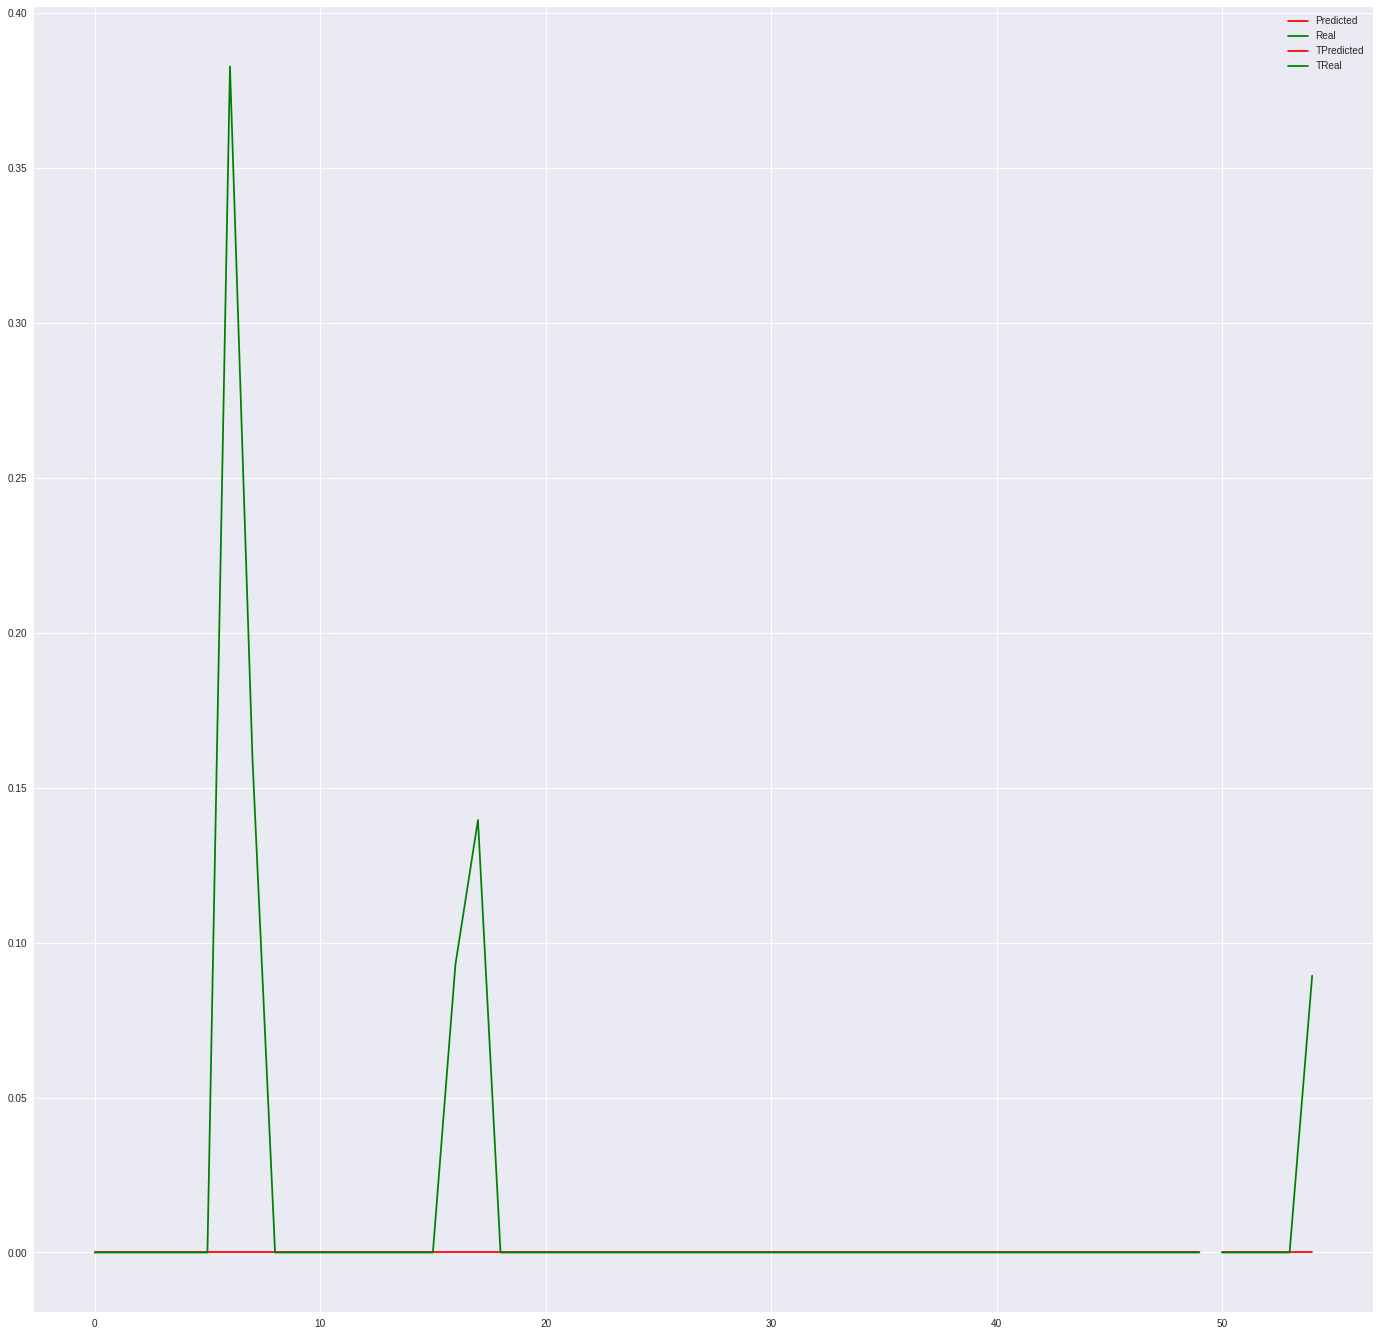

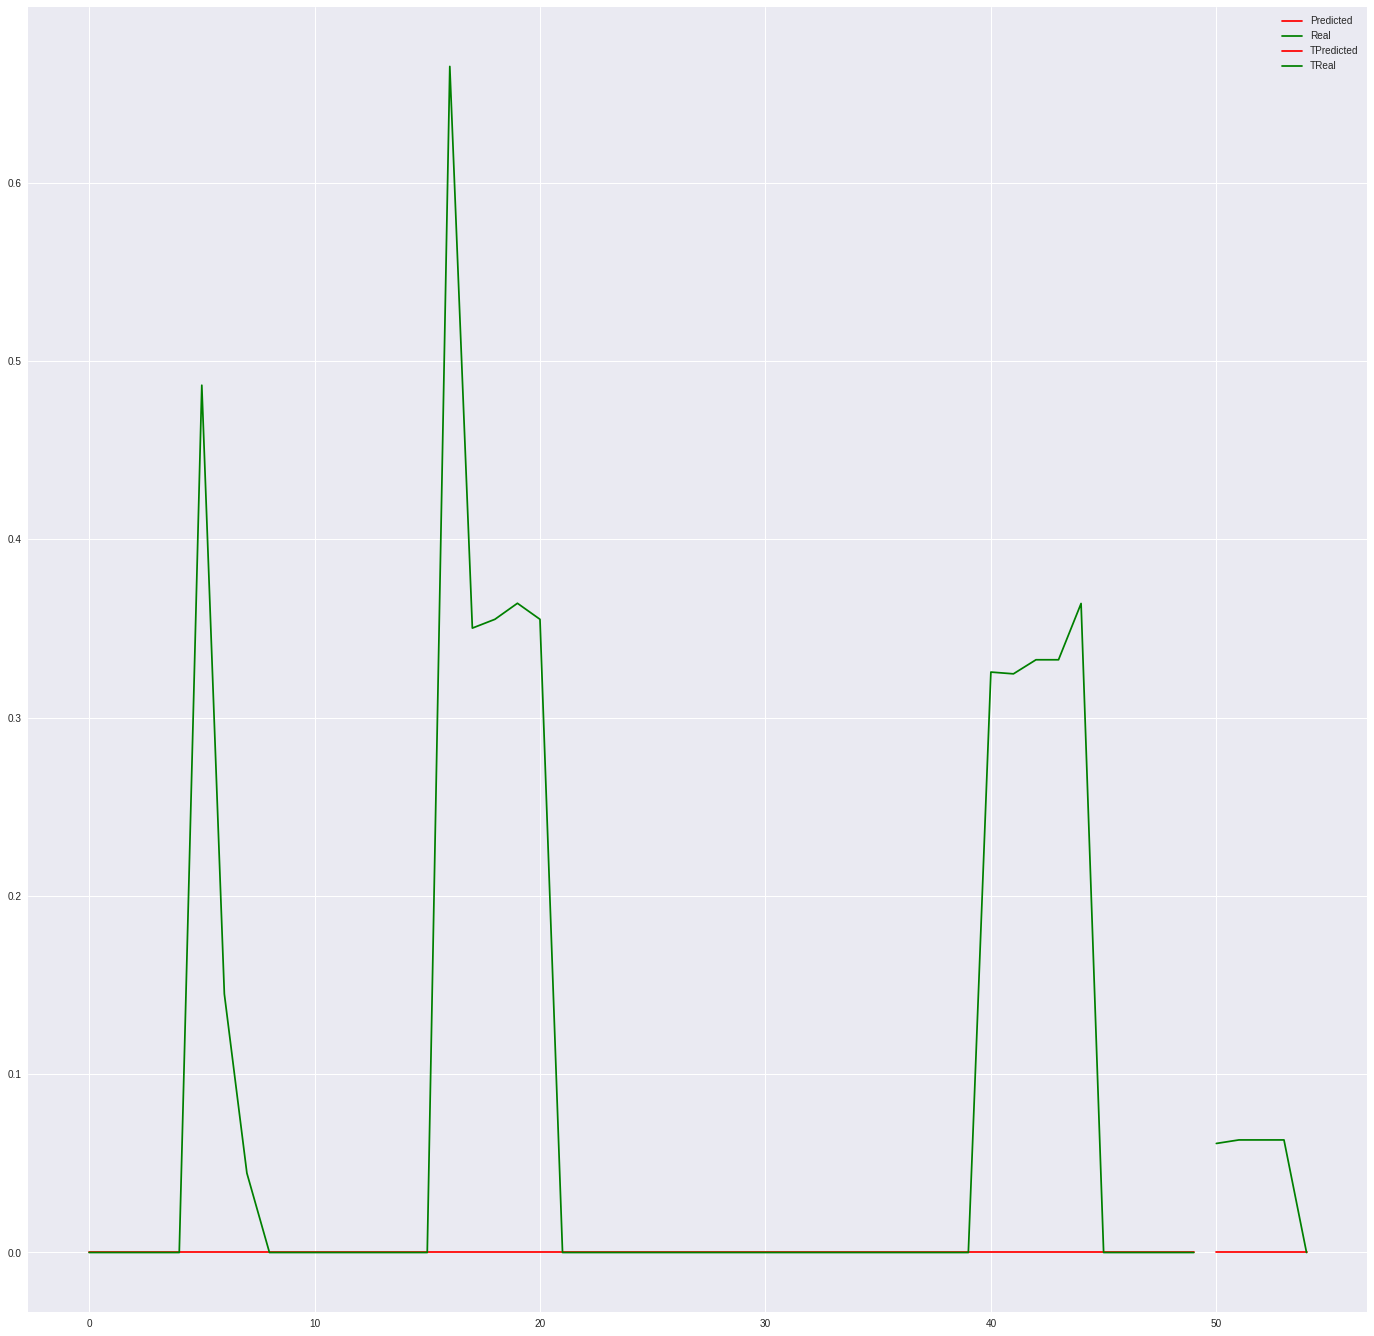

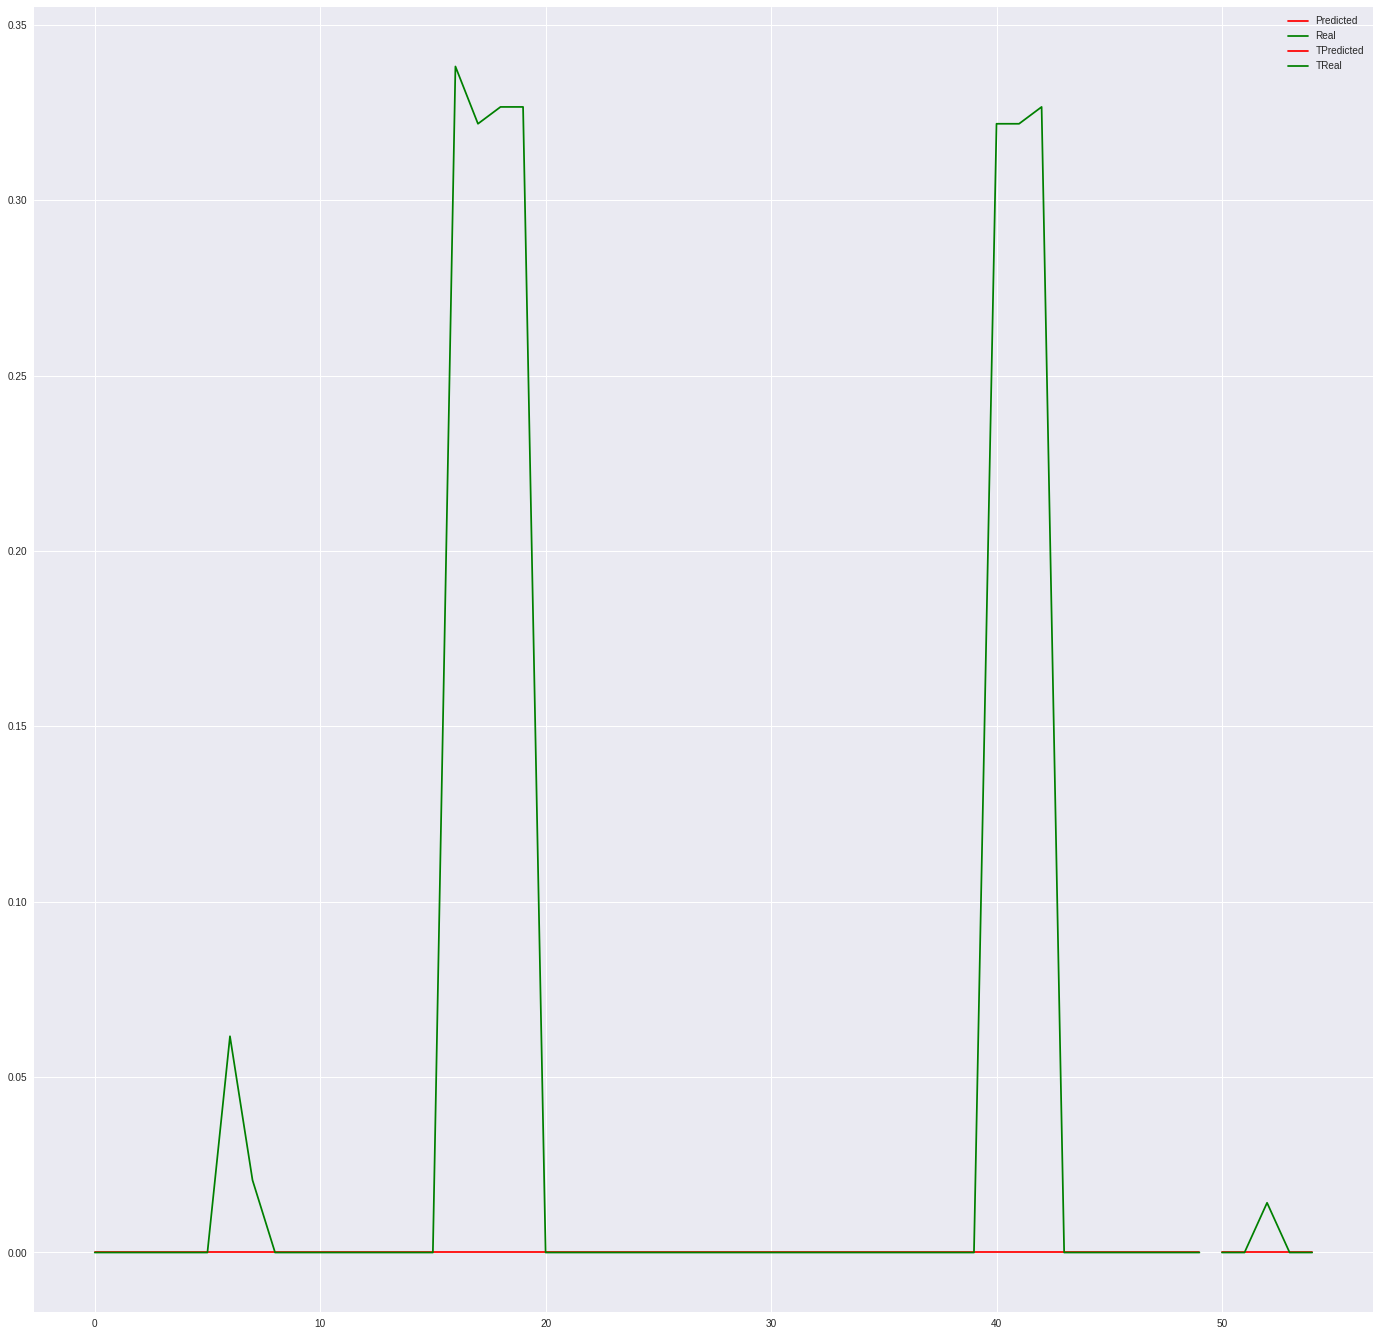

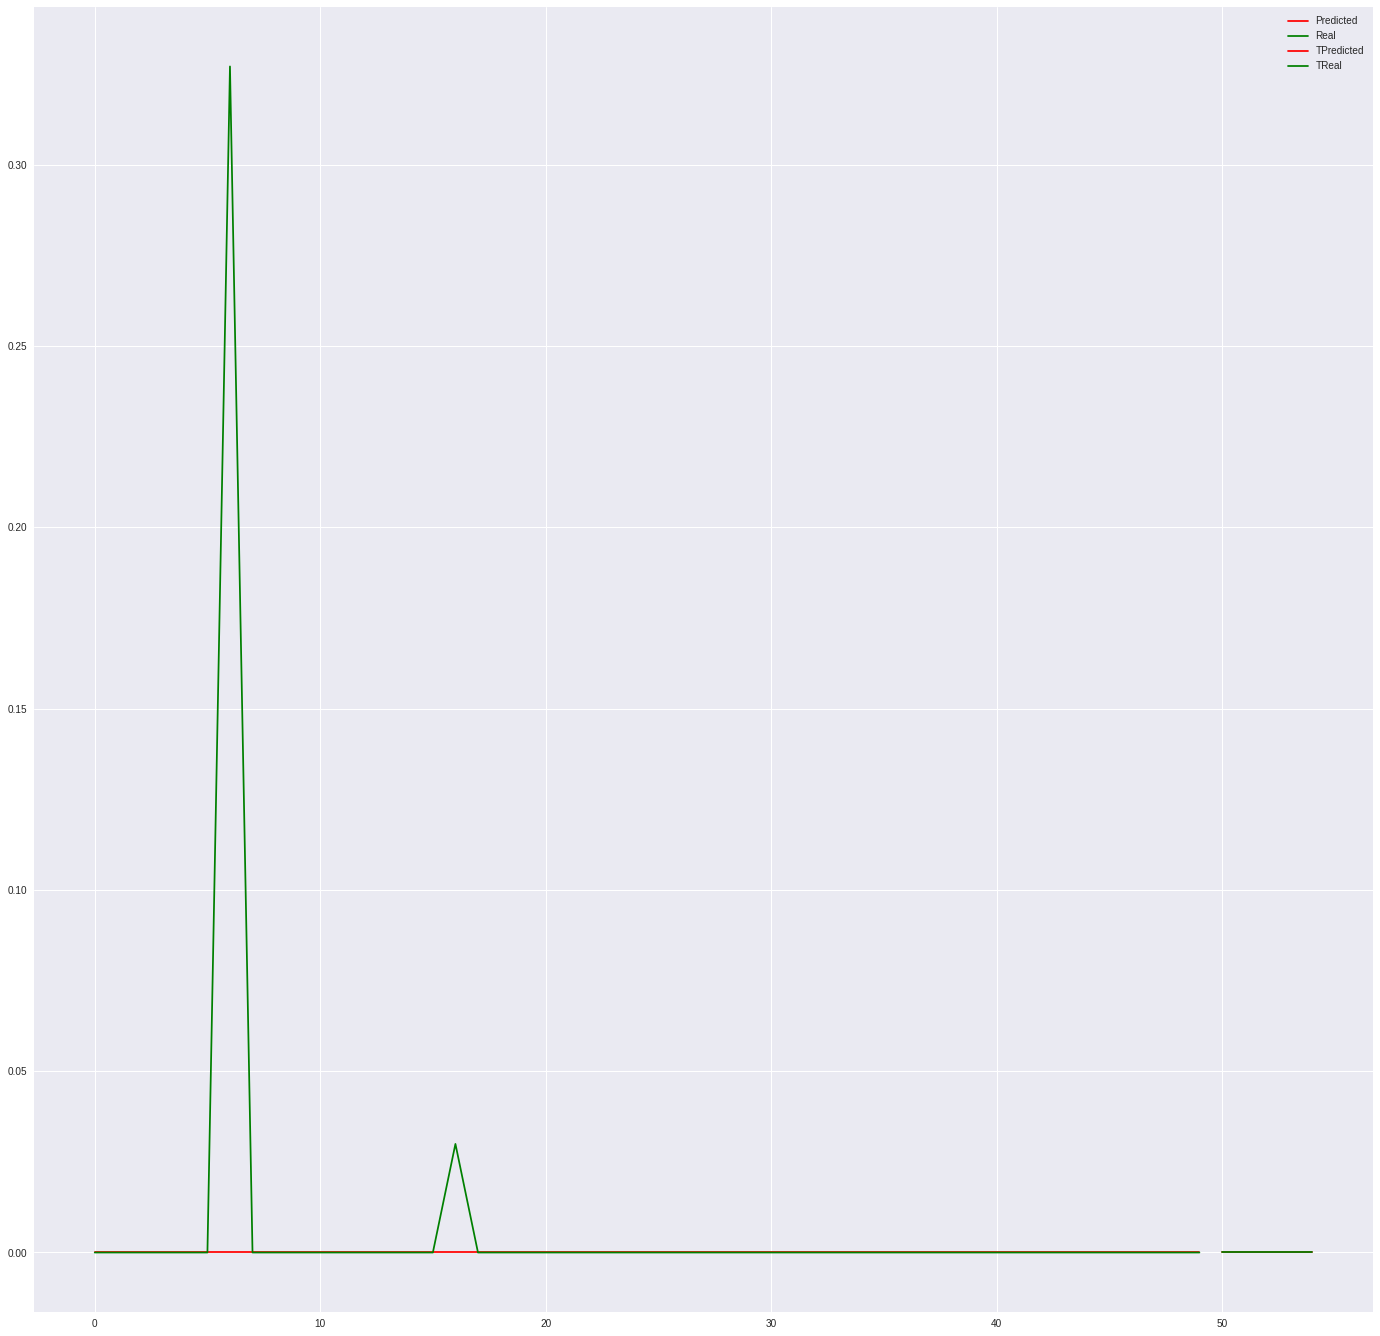

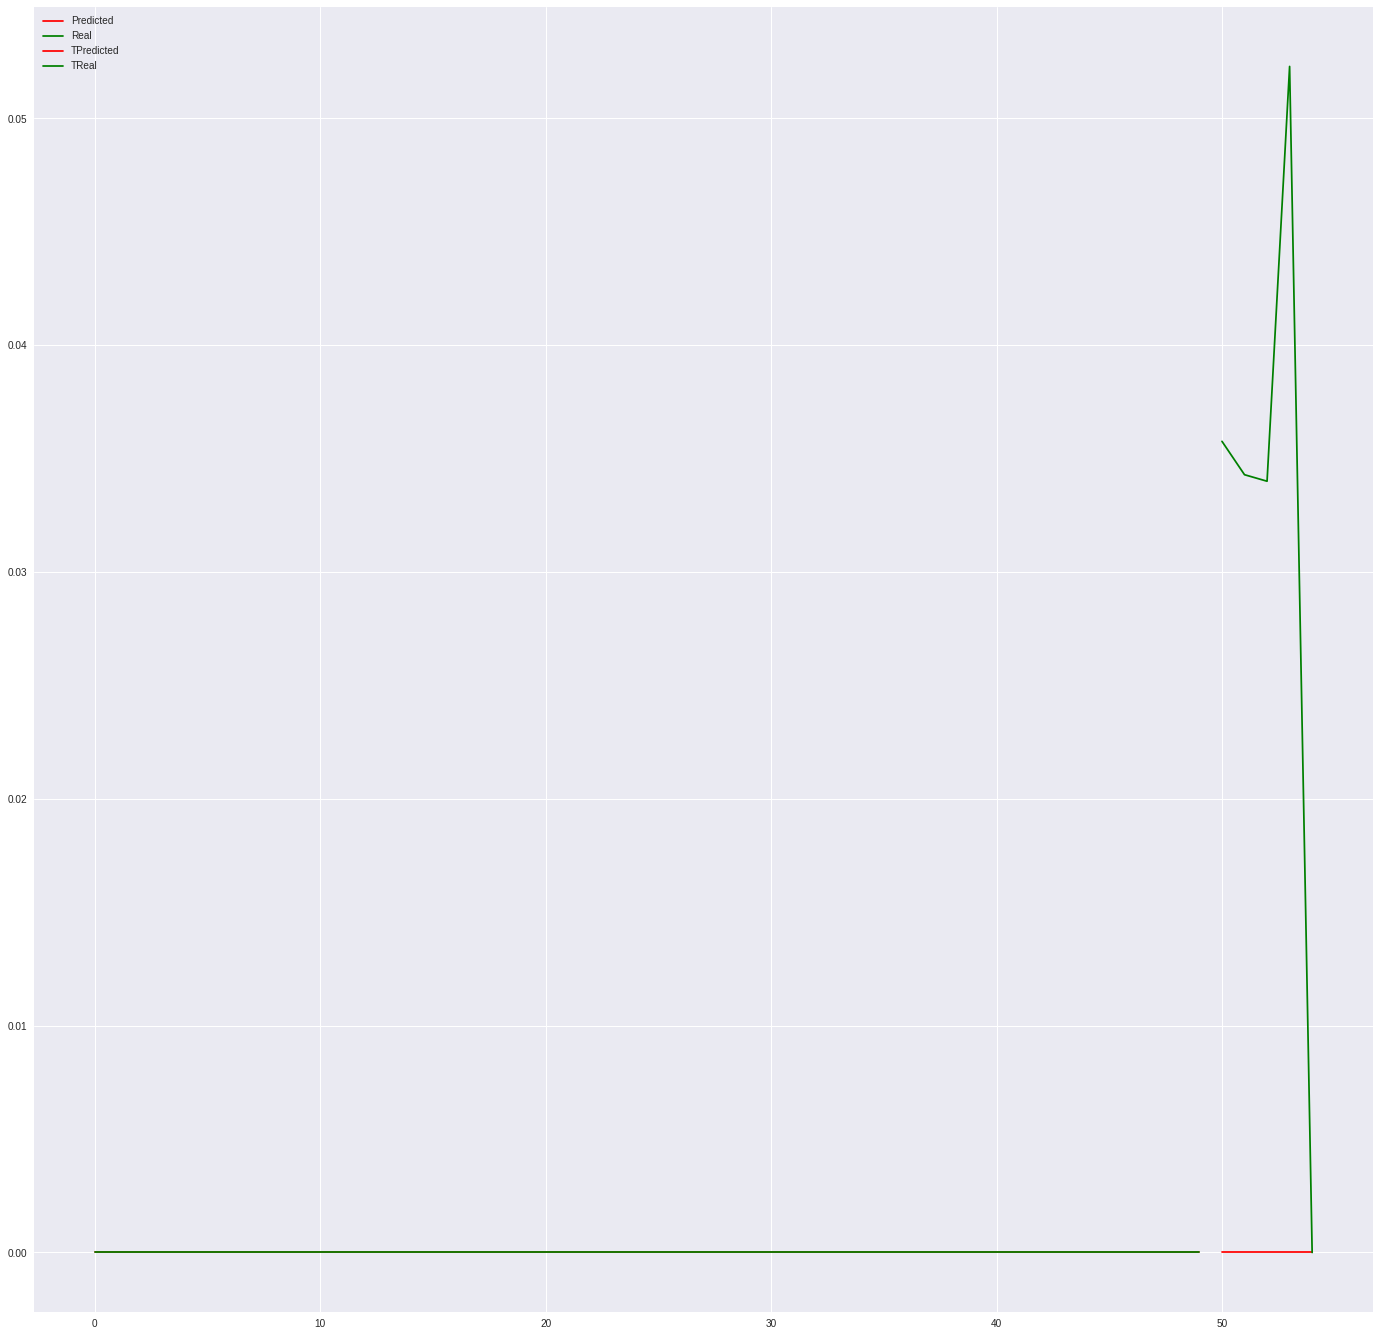

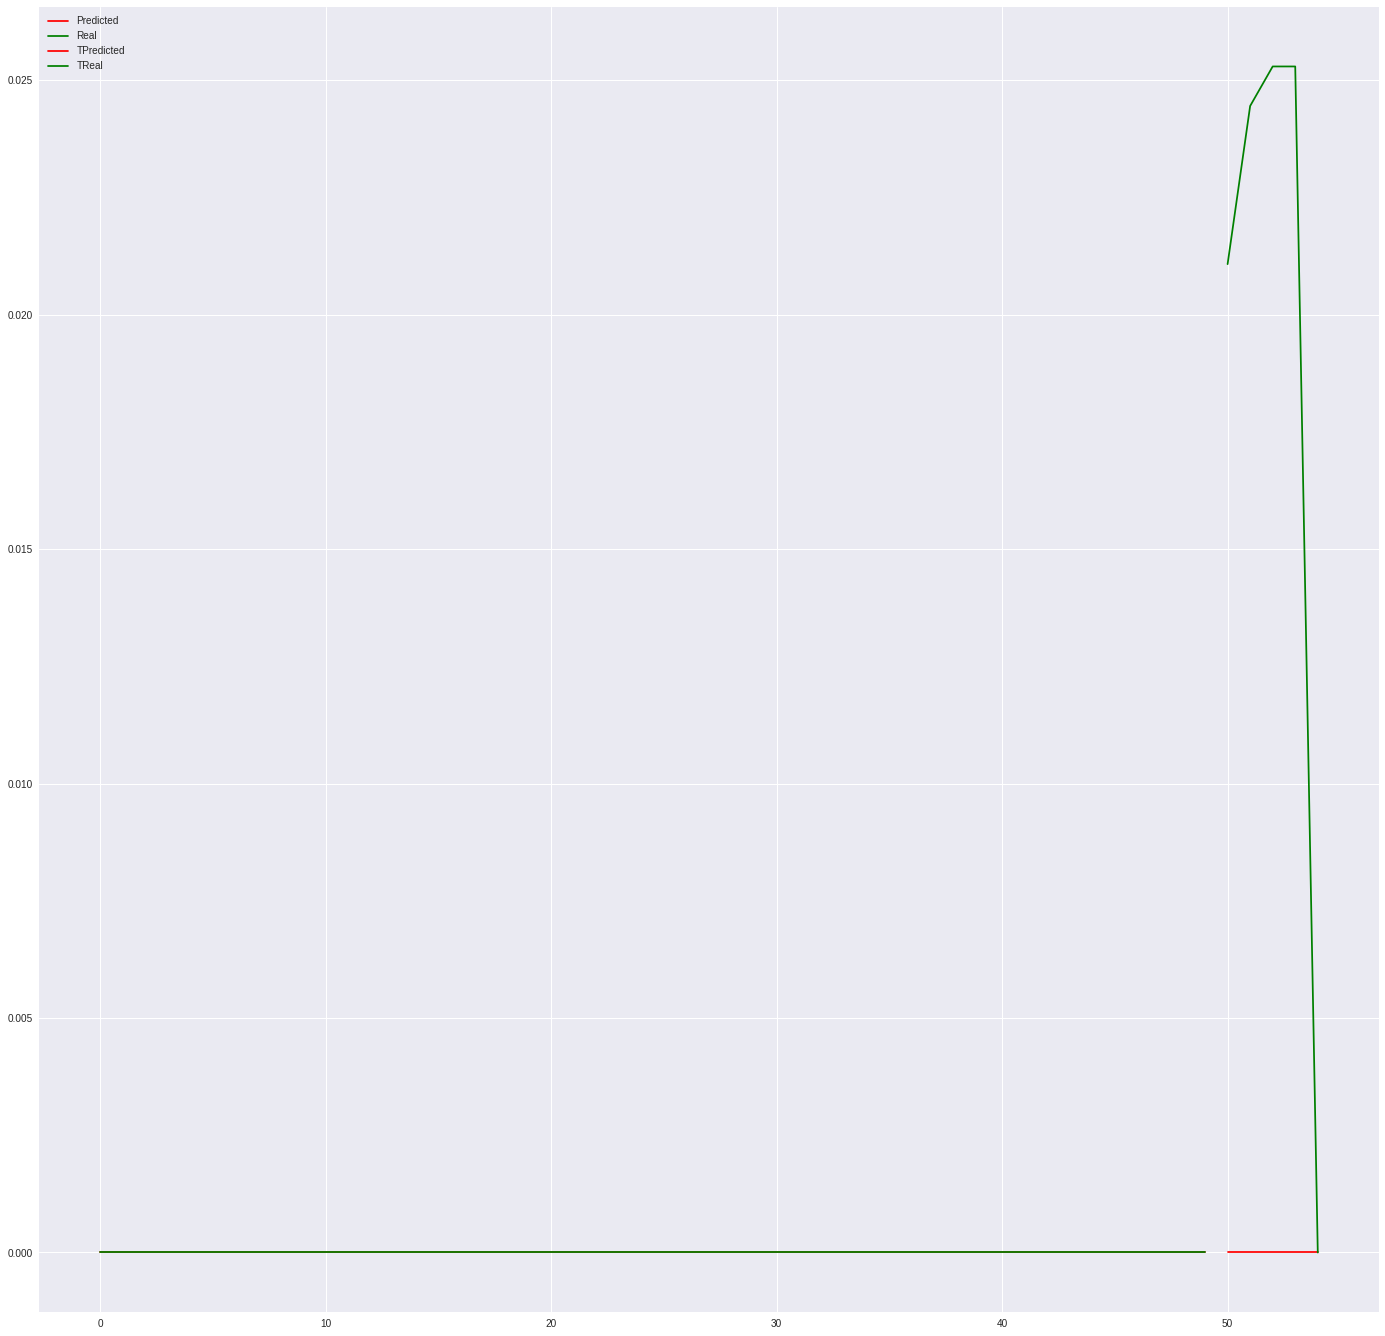

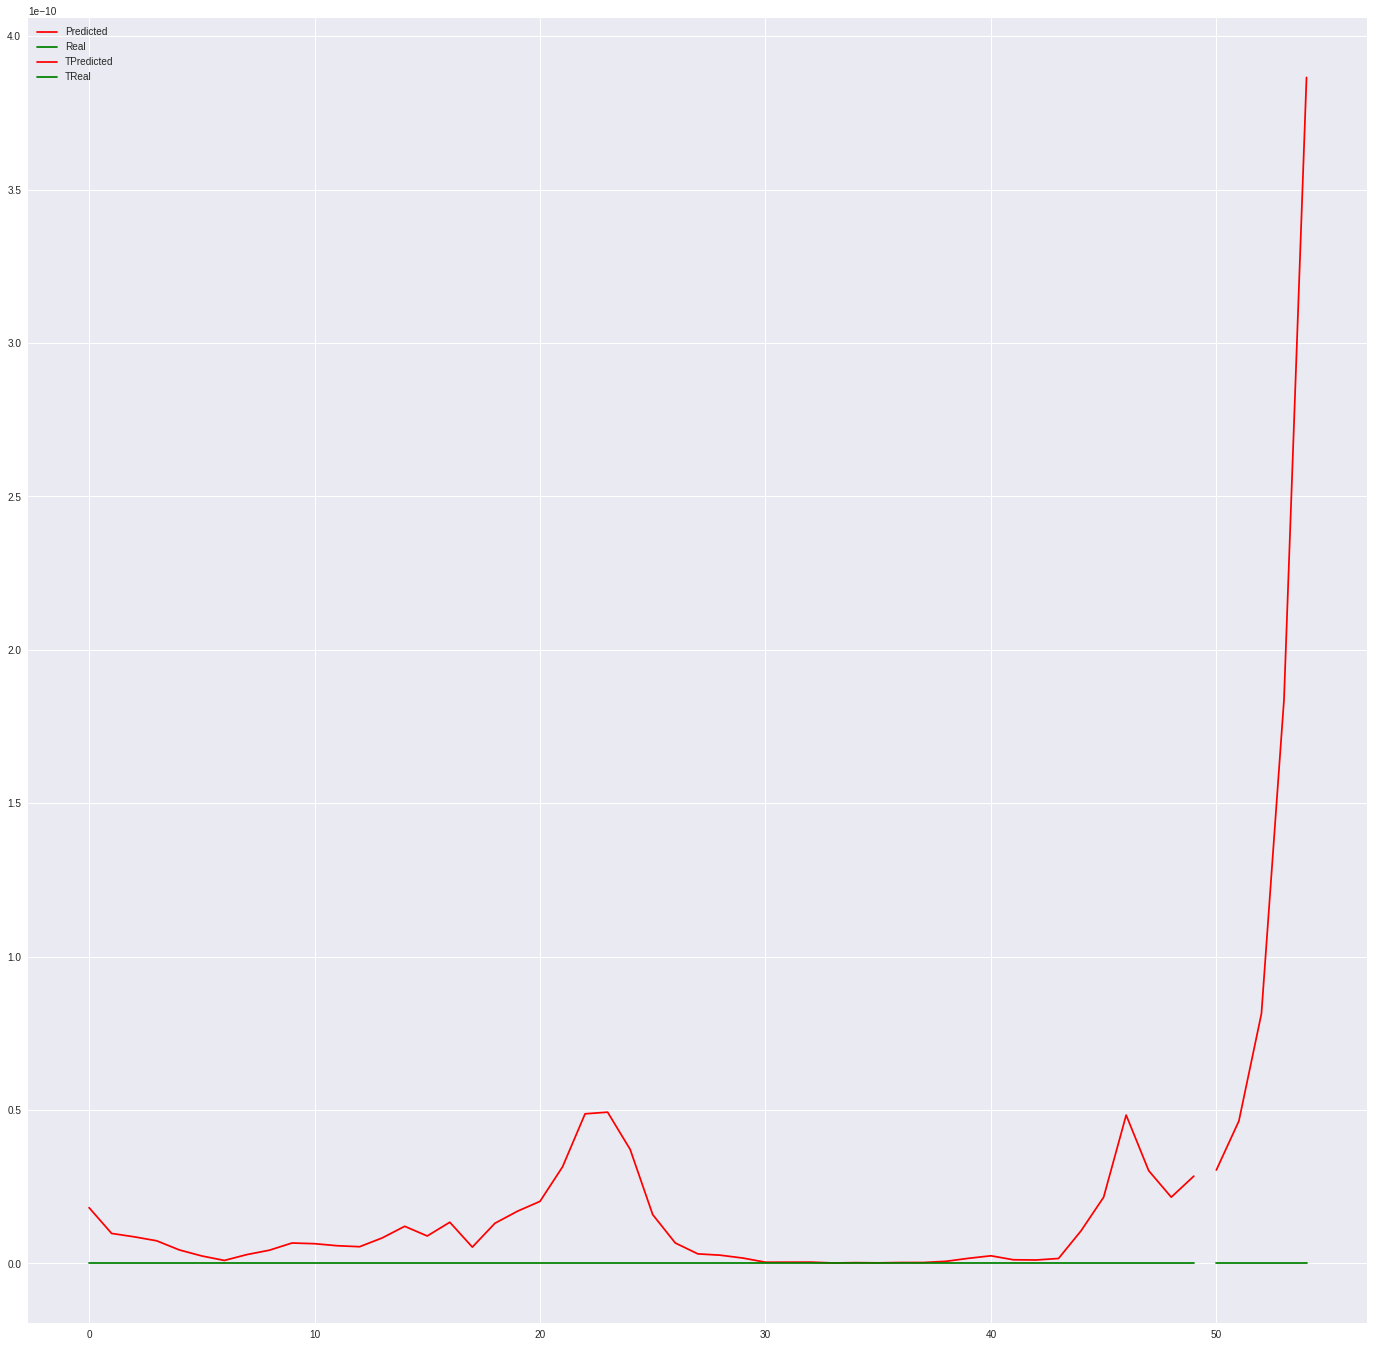

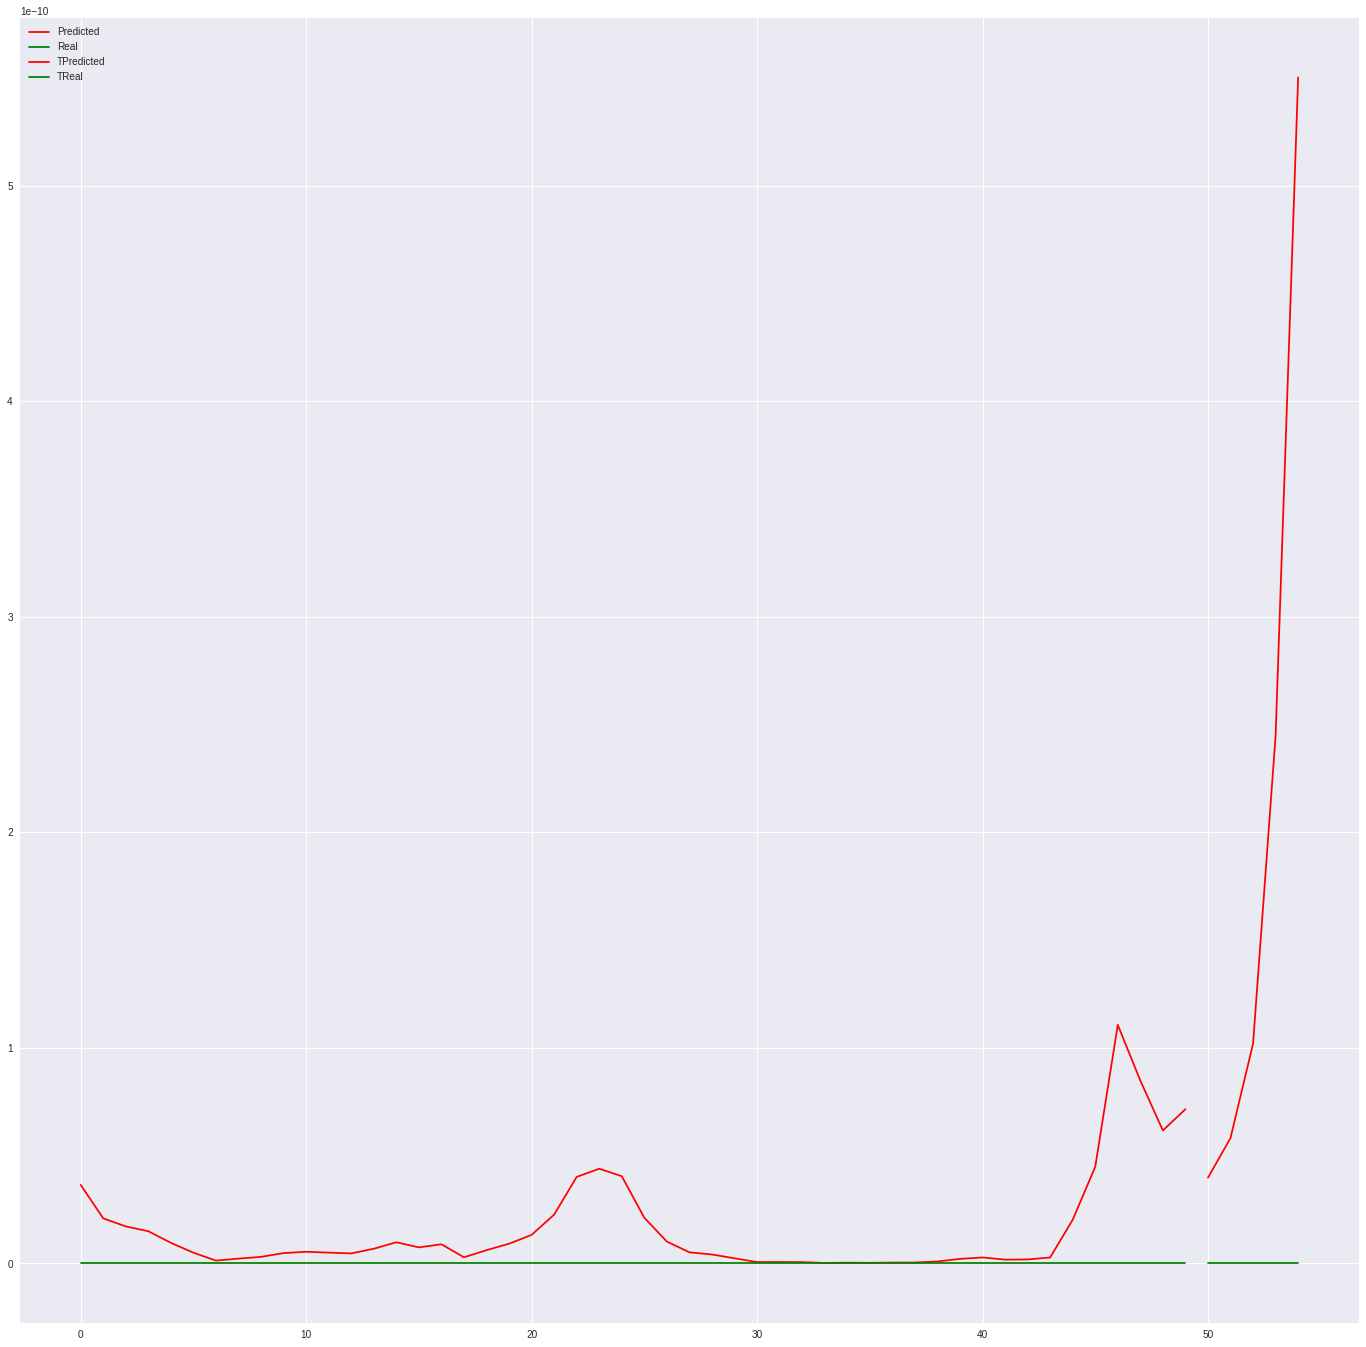

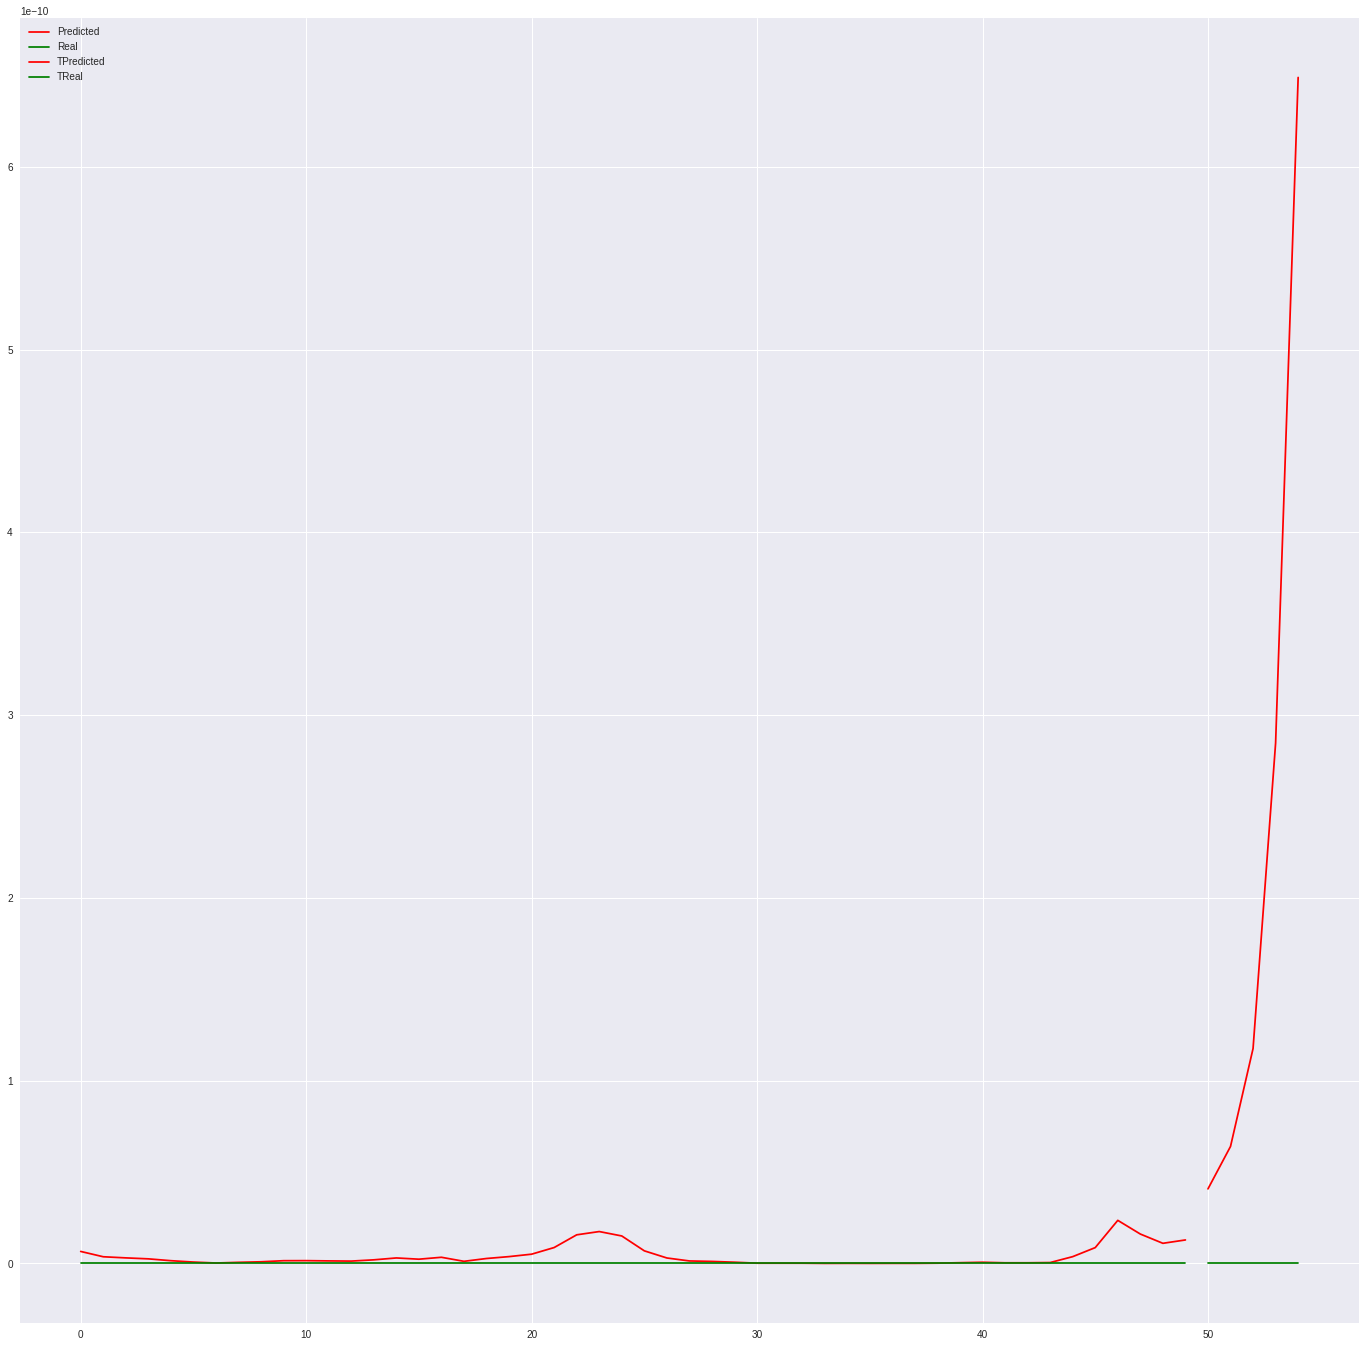

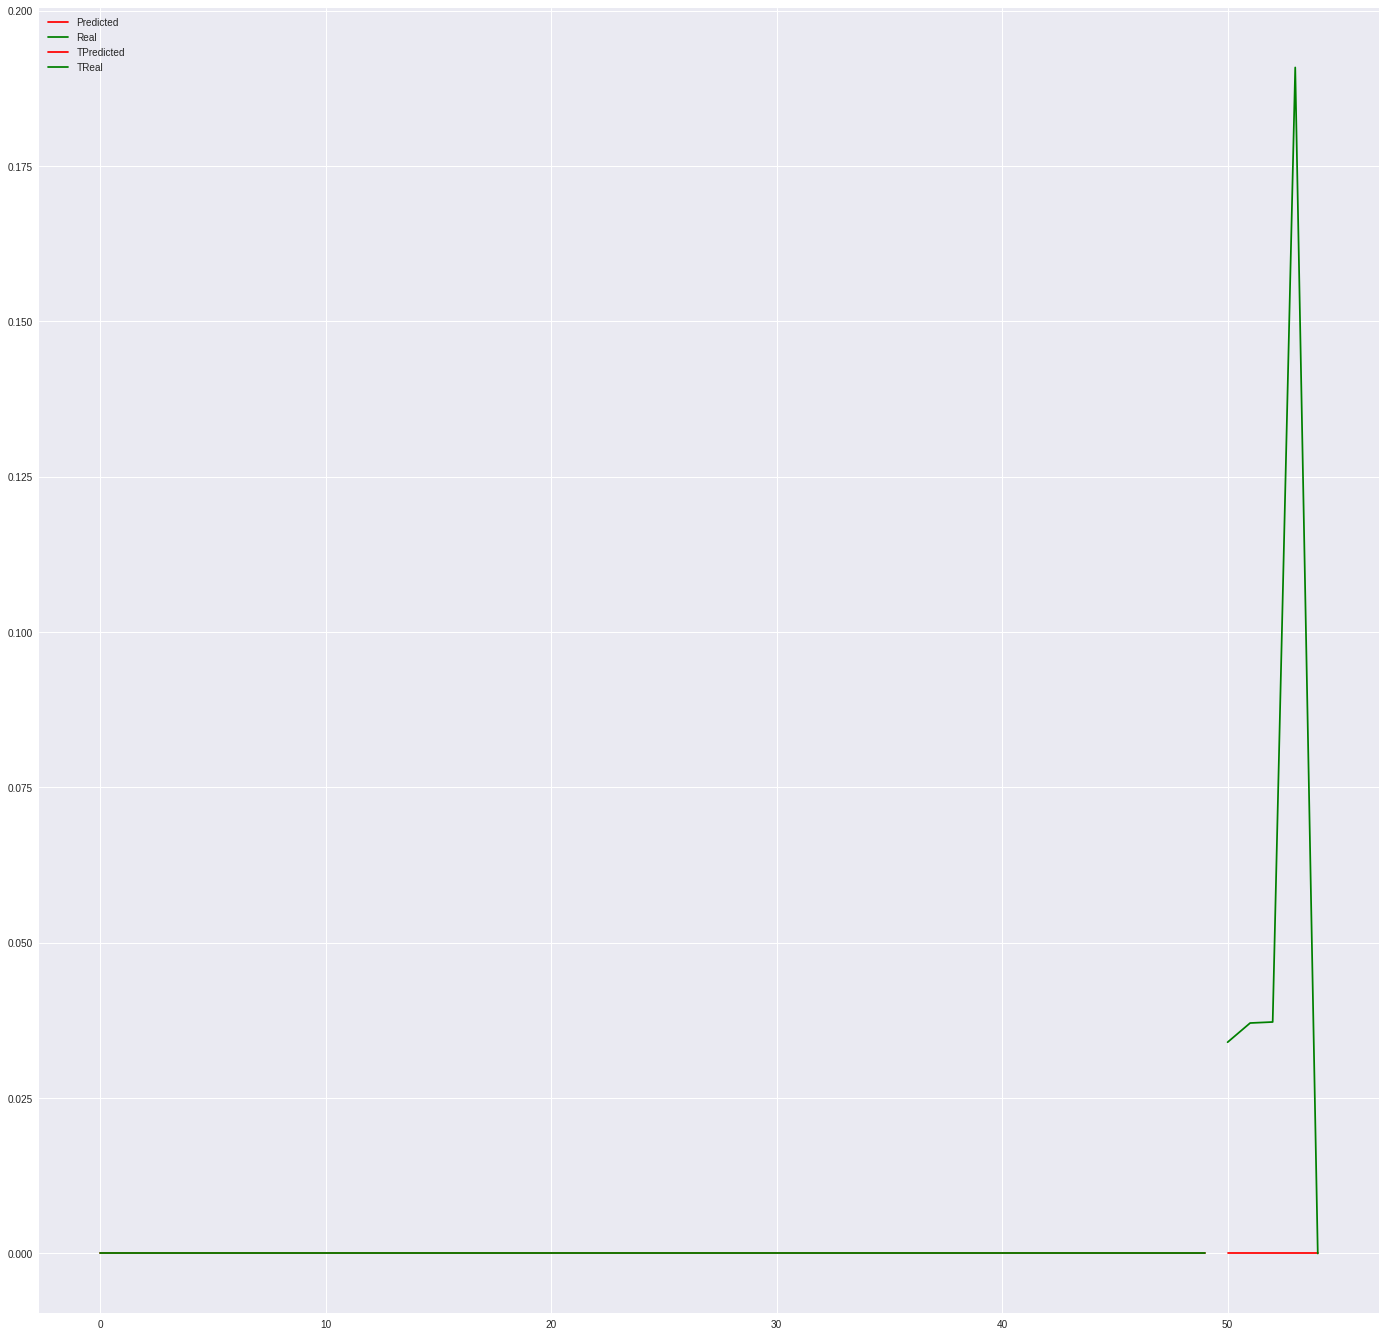

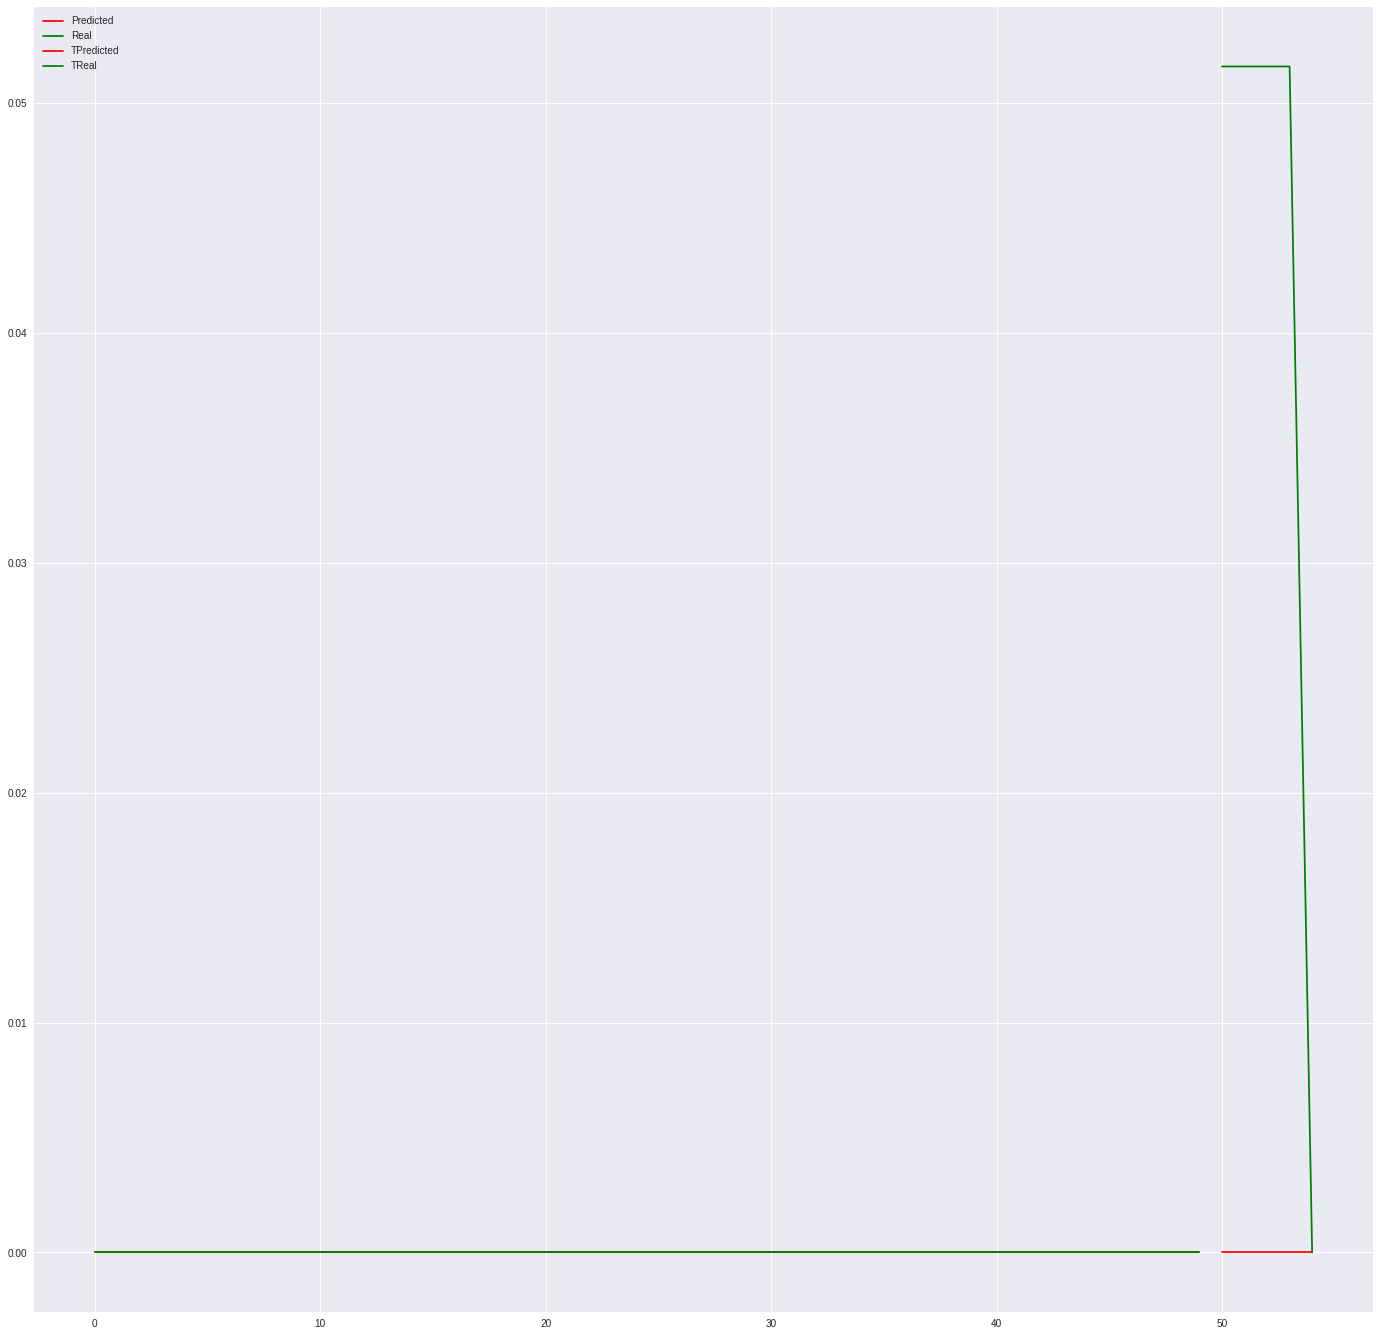

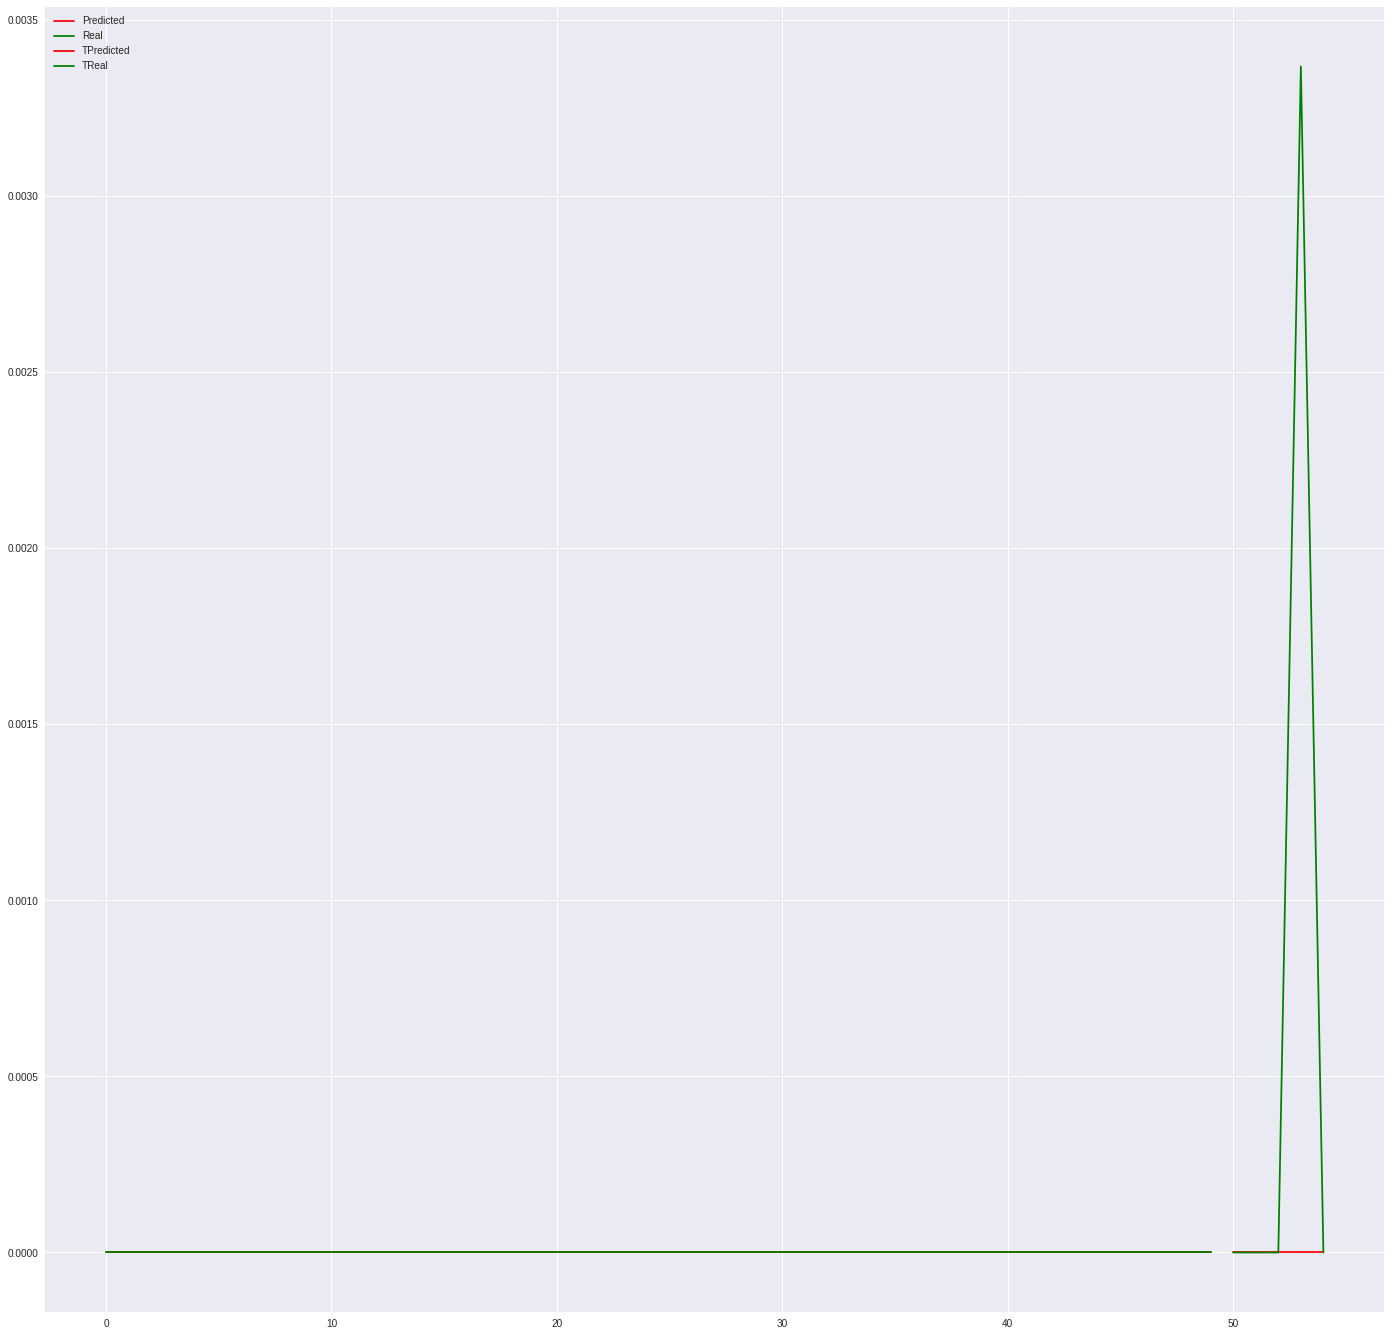

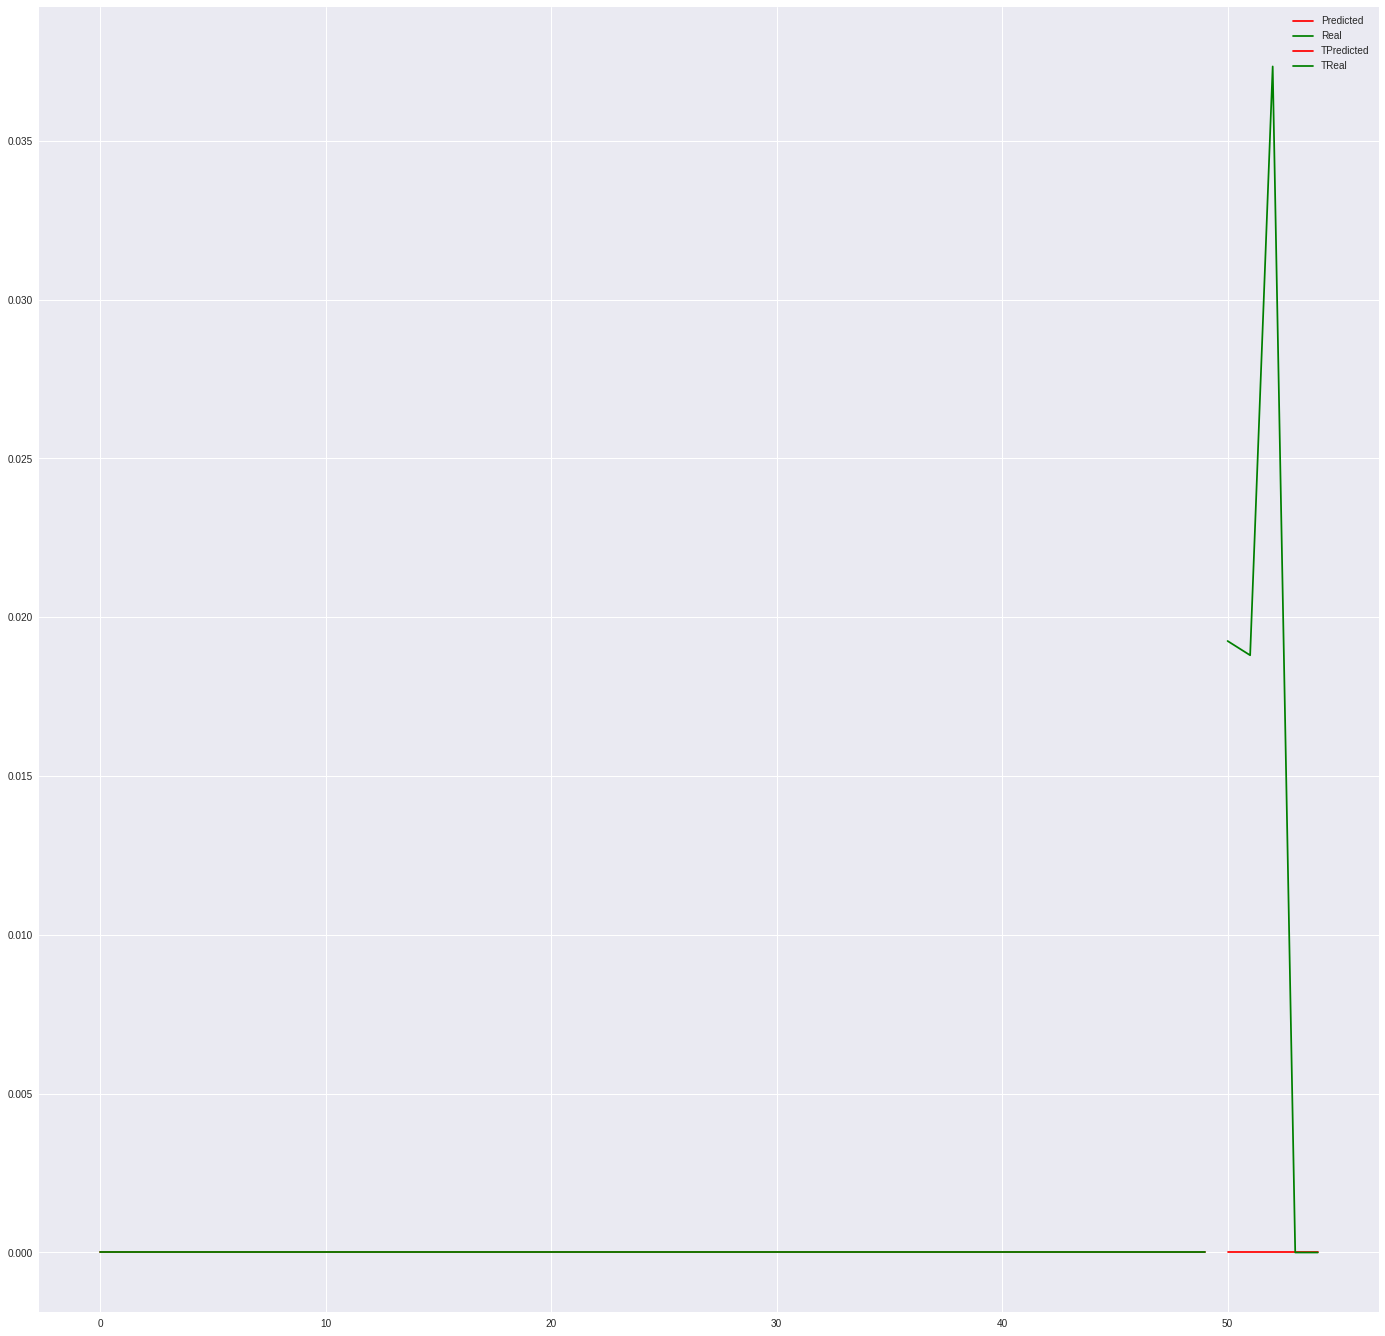

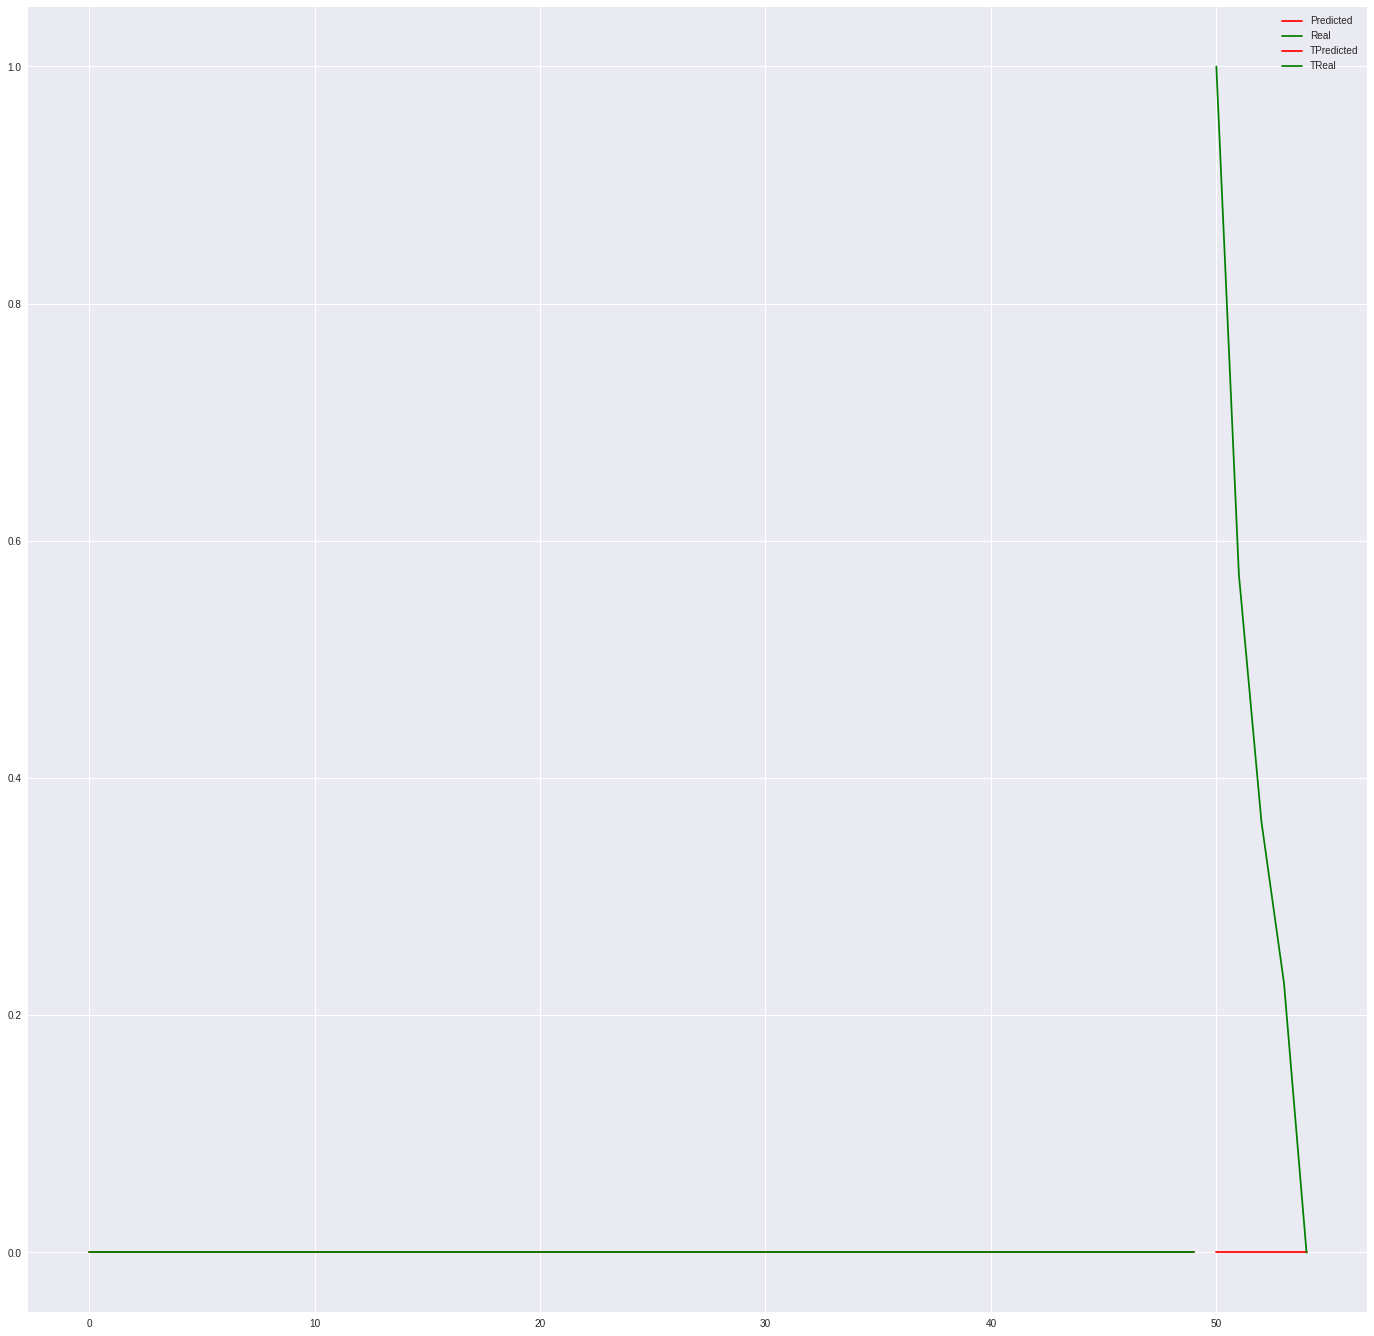

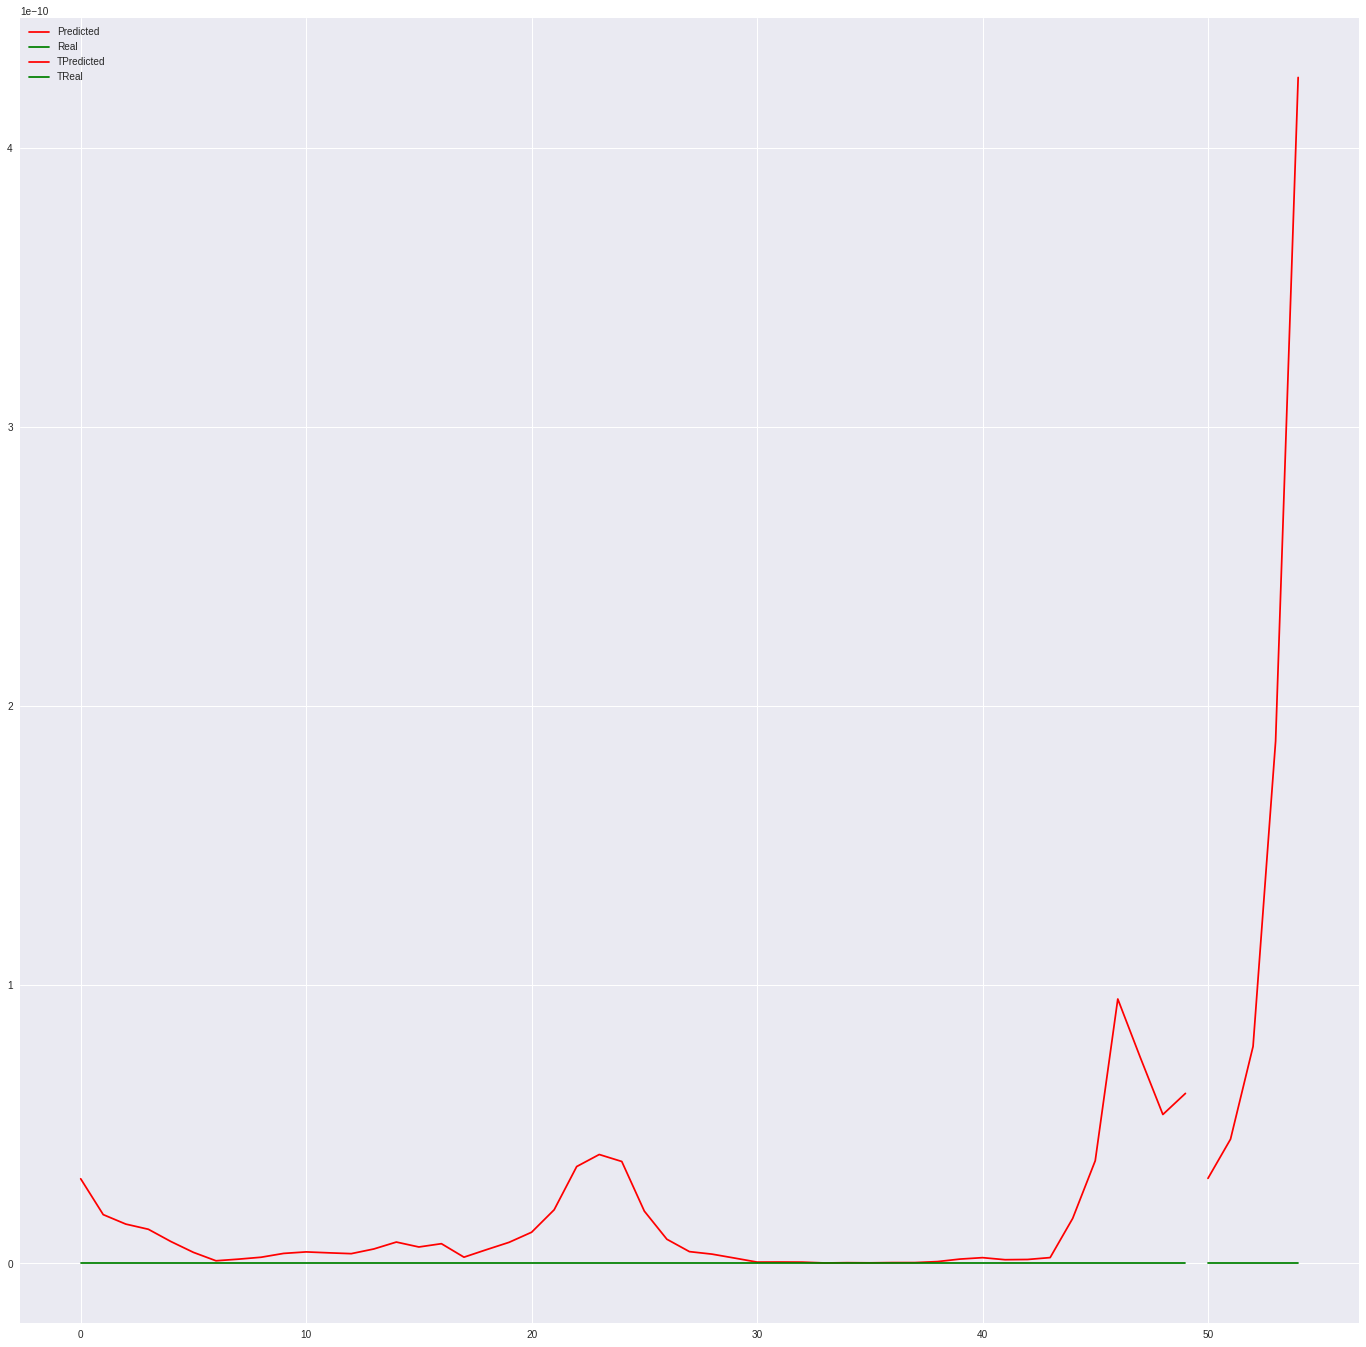

In [0]:
for target_feature in range(y.shape[1]):
    ypt = unwind_y(model.predict(Xt[:5], verbose=0), target_feature)
    yrt = unwind_y(yt[:5],target_feature)


    yp = unwind_y(model.predict(X[50:100], verbose=0),target_feature)
    yr = unwind_y(y[50:100],target_feature)


    plt.figure(figsize=(24,24))
    n=100

    multi=False
    if multi:
        for i in range(10):
            plt.plot(yp[i], color= 'red', label="Predicted")
            plt.plot(yr[i], color='green', label="Real")
    else:
        plt.plot(yp, color= 'red', label="Predicted")
        plt.plot(yr, color='green', label="Real")
        plt.plot(range(len(yp),len(yp)+len(ypt)),ypt,color="red", label="TPredicted")
        plt.plot(range(len(yp),len(yp)+len(yrt)),yrt,color="green",  label="TReal")

    #plt.plot(X[50:100,n_steps-1], color='blue', label="Lagged-0")
    #plt.plot(Xt[:5,n_steps-1], color='blue', label="Lagged-0")

    plt.legend()
    plt.show()

In [0]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers import TimeDistributed
from keras.layers.recurrent import LSTM
from keras.layers import Dense, Conv1D, MaxPool2D, Flatten, Dropout, GRU, CuDNNLSTM
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam, SGD, Nadam
from time import time
#!pip install livelossplot
#from livelossplot import PlotLossesKeras
from keras.layers.advanced_activations import LeakyReLU, PReLU
import tensorflow as tf
from tensorflow.python.client import device_lib
from sklearn.preprocessing import StandardScaler

look_back=n_steps
def create_model():
    model = Sequential()
    model.add(CuDNNLSTM(102, input_shape=(look_back, n_features), return_sequences=True, kernel_initializer='TruncatedNormal'))
    #model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.05))

    #1
    for _ in range(1):
        model.add(CuDNNLSTM(51, kernel_initializer='TruncatedNormal', return_sequences=True))
        #model.add(BatchNormalization())
        model.add(LeakyReLU())
        model.add(Dropout(0.05))   

    #2
    model.add(CuDNNLSTM(25, kernel_initializer='TruncatedNormal', return_sequences=False))
    #model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.1))
    #3
    for _ in range(0):
        model.add(Dense(32, kernel_initializer='TruncatedNormal'))
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        model.add(Dropout(0.1))
    #3
    for _ in range(0):
        model.add(Dense(256, kernel_initializer='TruncatedNormal'))
        #model.add(BatchNormalization())
        model.add(LeakyReLU())
        model.add(Dropout(0.1))
    #4
    for _ in range(1):
        model.add(Dense(128, kernel_initializer='TruncatedNormal'))
        #model.add(BatchNormalization())
        model.add(LeakyReLU())
        model.add(Dropout(0.1))

    #5
    model.add(Dense(51))
    
    return model
  
model1=create_model()




In [0]:
for i in range(0):
  print(i)

In [0]:
epochs = 10**2
bs = 512
lr = 1e-1#5e-2

# 0.05 0.9 0 True
#sgd = SGD(lr=0.5, momentum=0.9, decay=0, nesterov=True) # sgd in general yields better results, but needs a lot of tweeking and is slower
adam = Adam(lr=lr)
nadam = Nadam(lr=lr)

# compile & fit
model1.compile(optimizer='adam', loss = ['mae'], metrics=["mae", 'mse'])



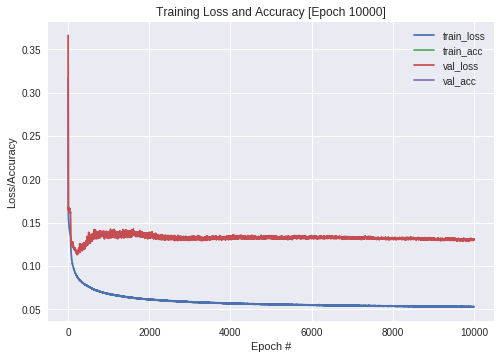

In [0]:
model1.fit(X, y, epochs=10000, batch_size=1024, validation_split=0.1,
         verbose=0, callbacks=[plot_losses])
#print(model.summary())

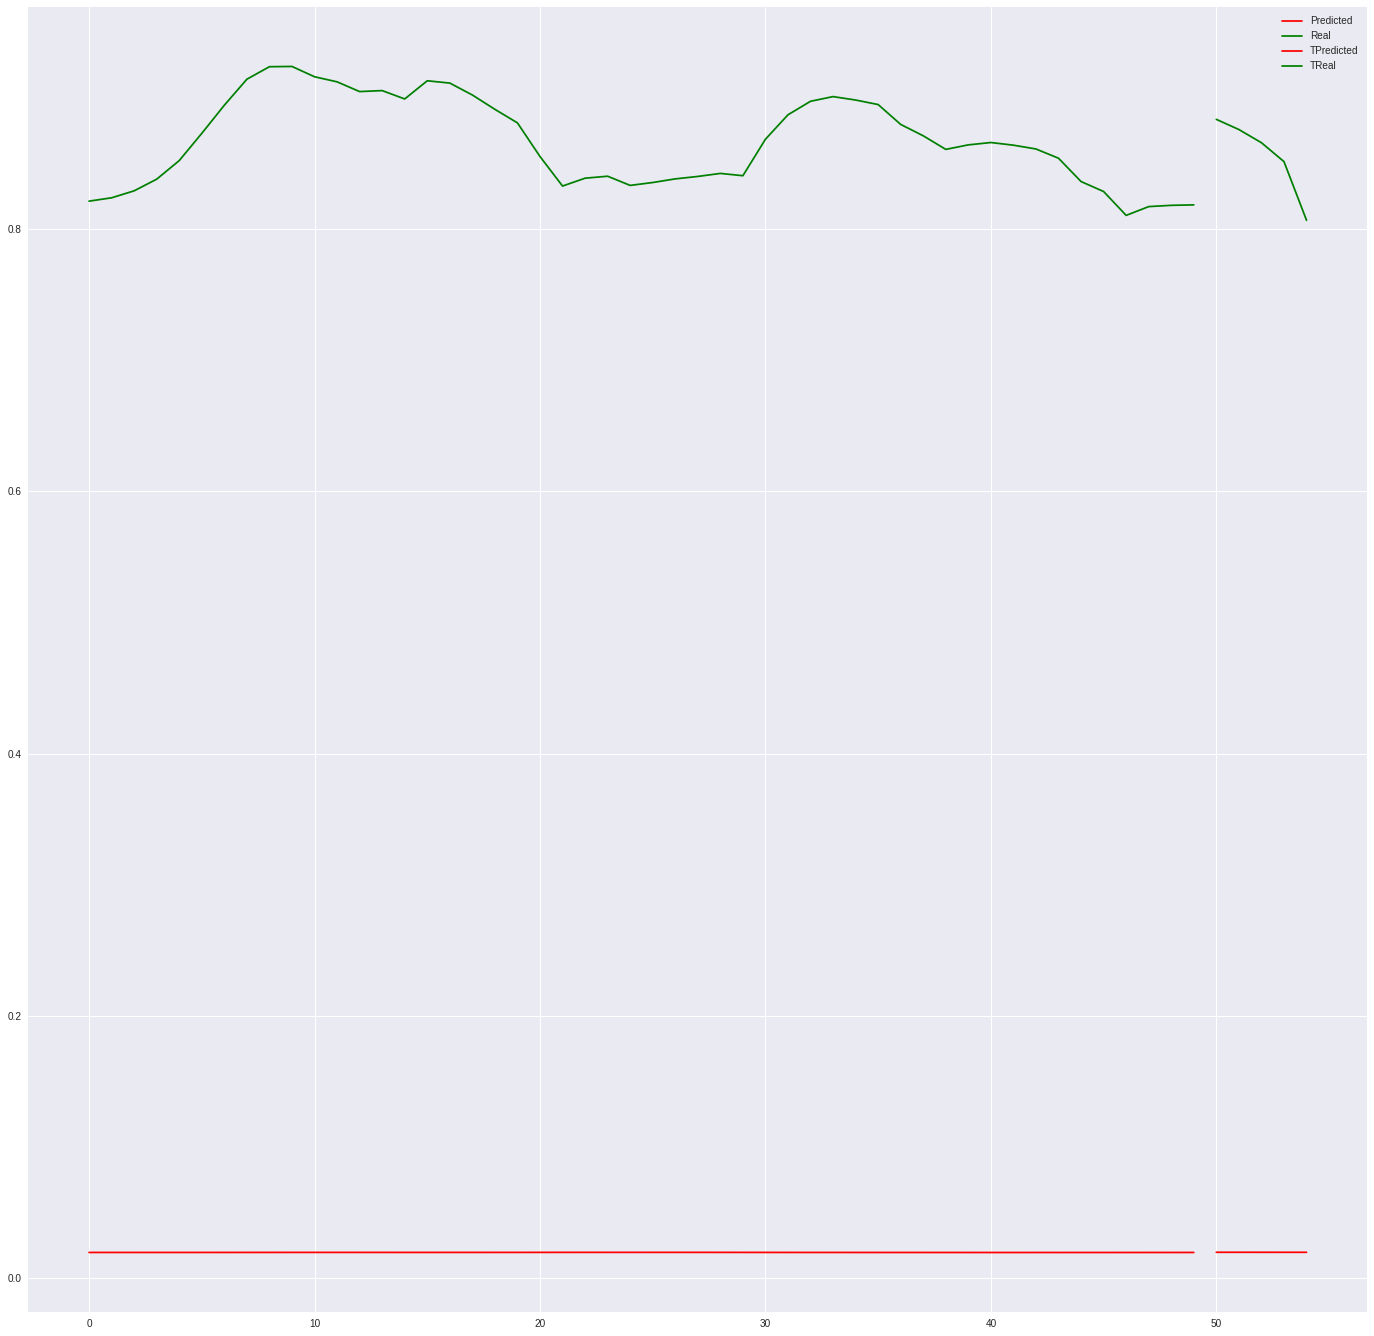

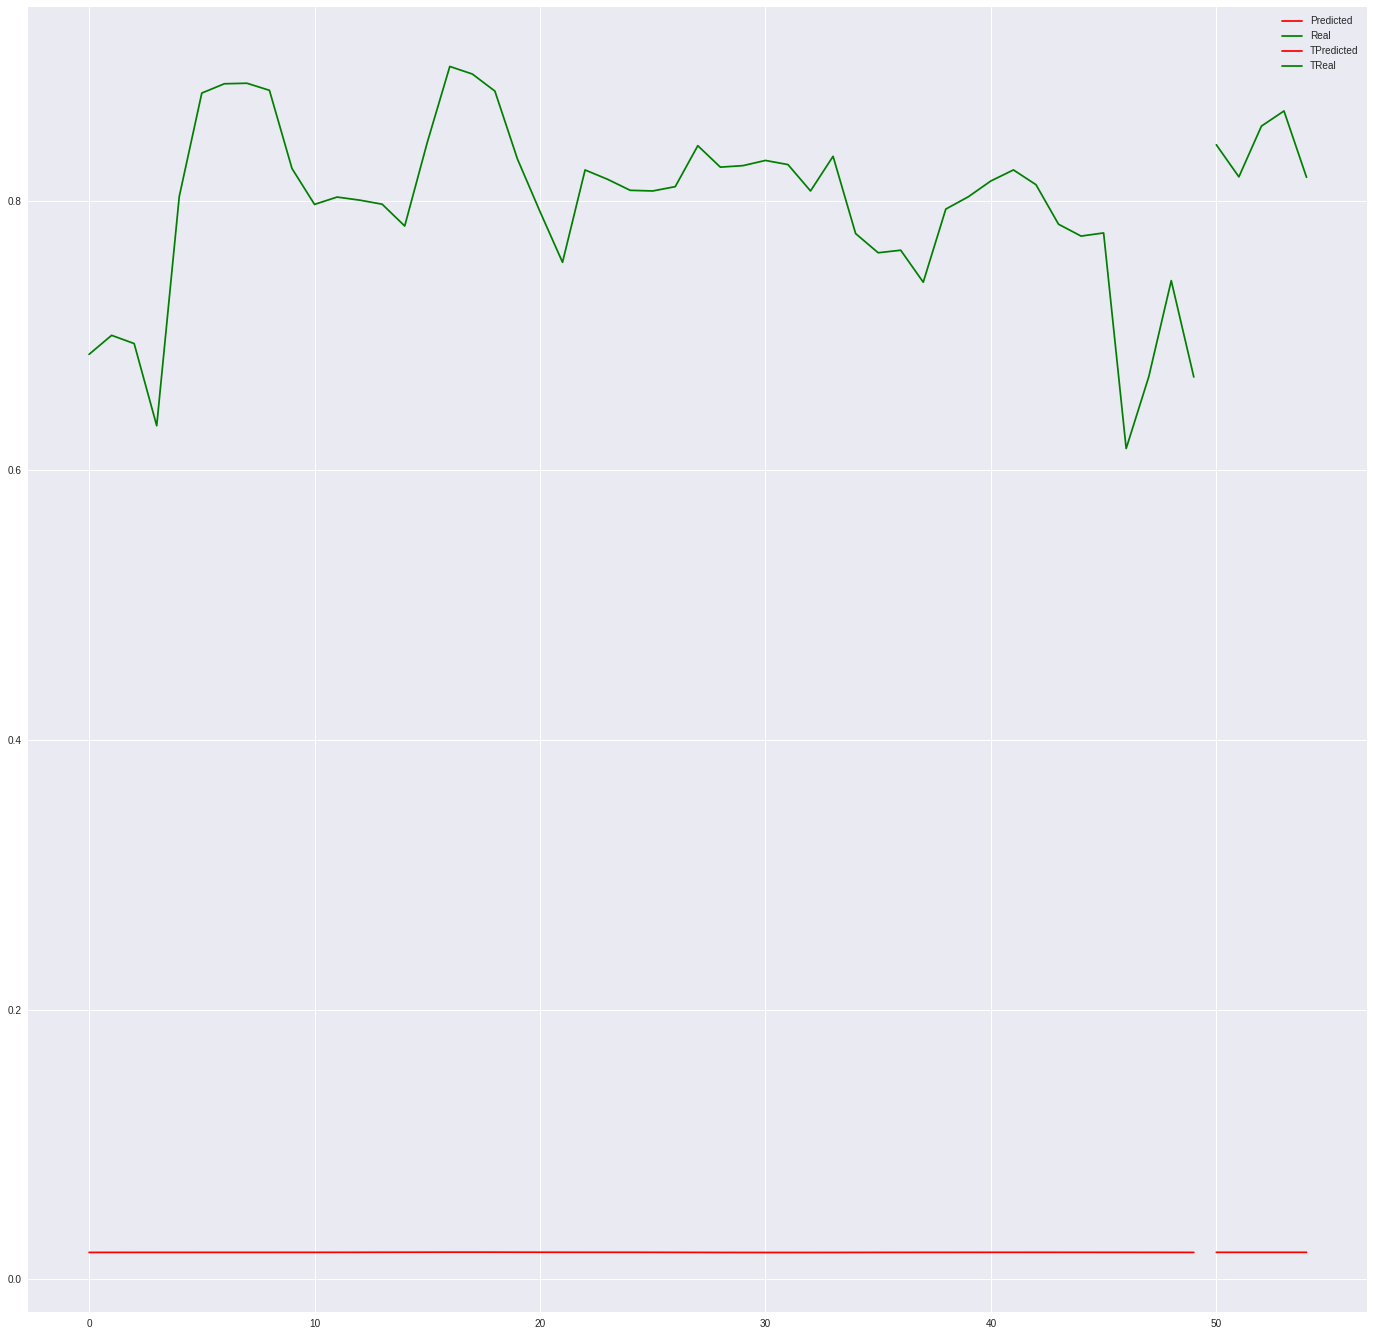

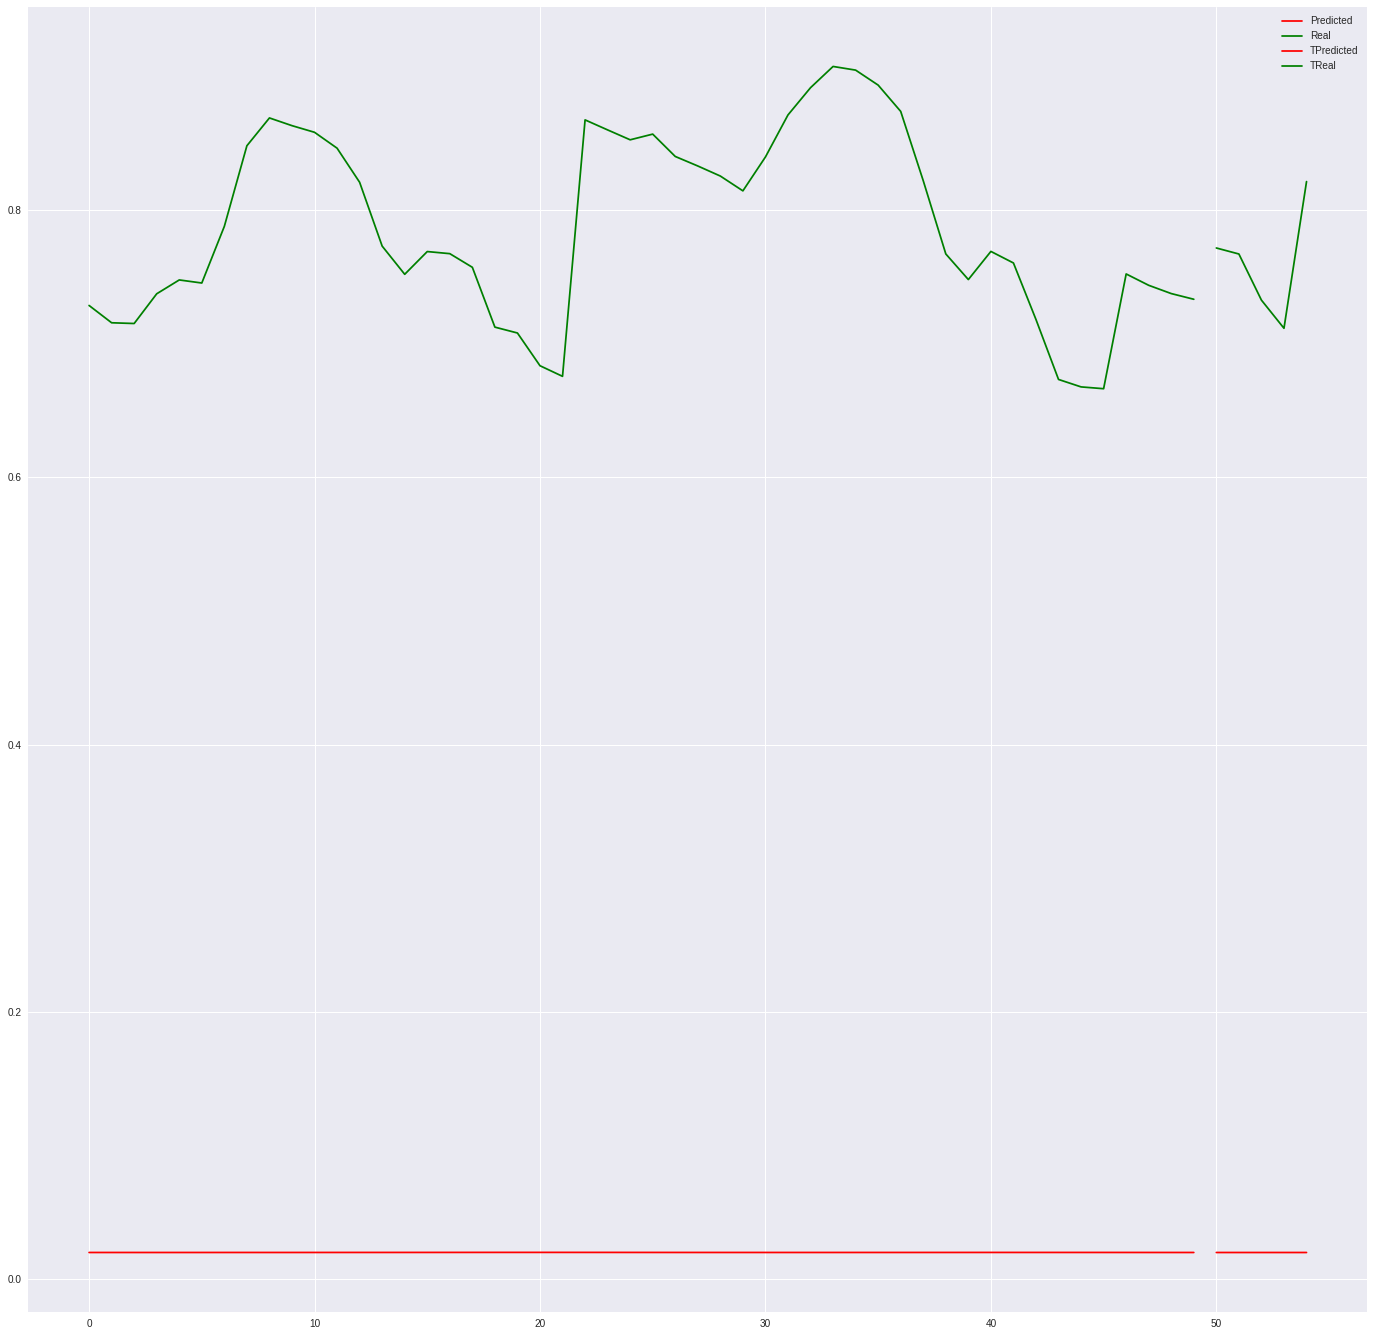

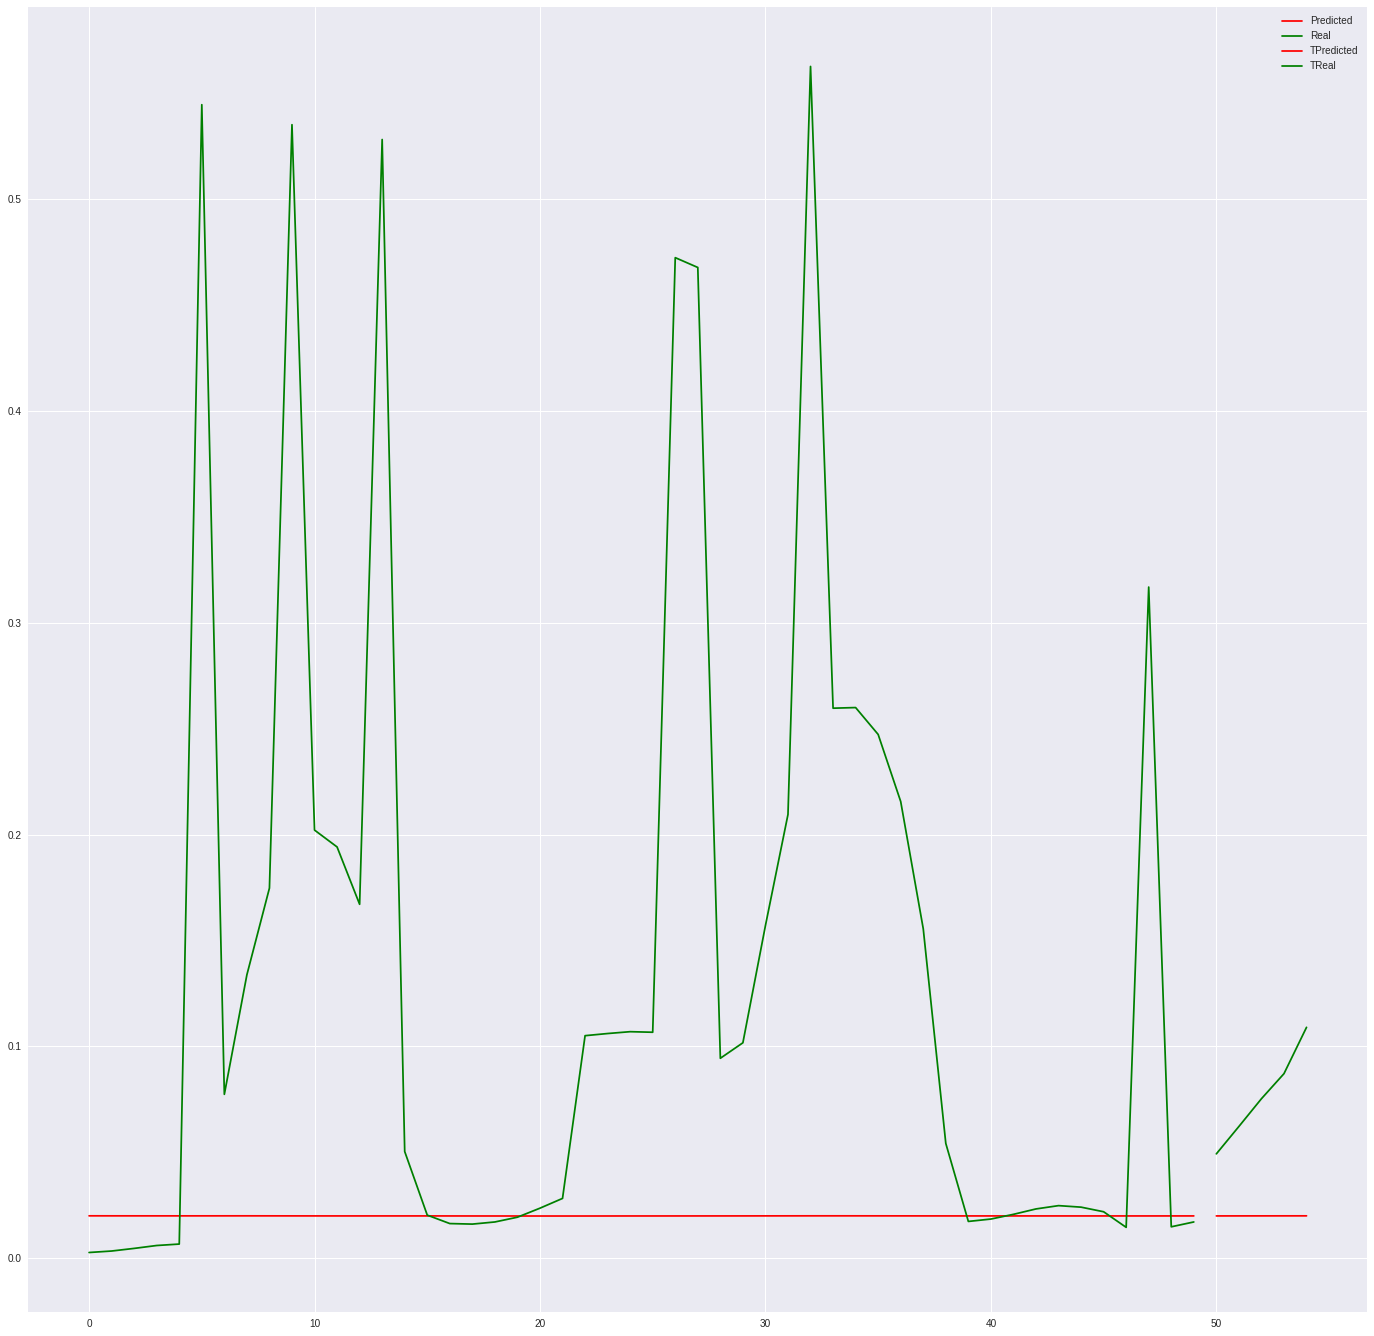

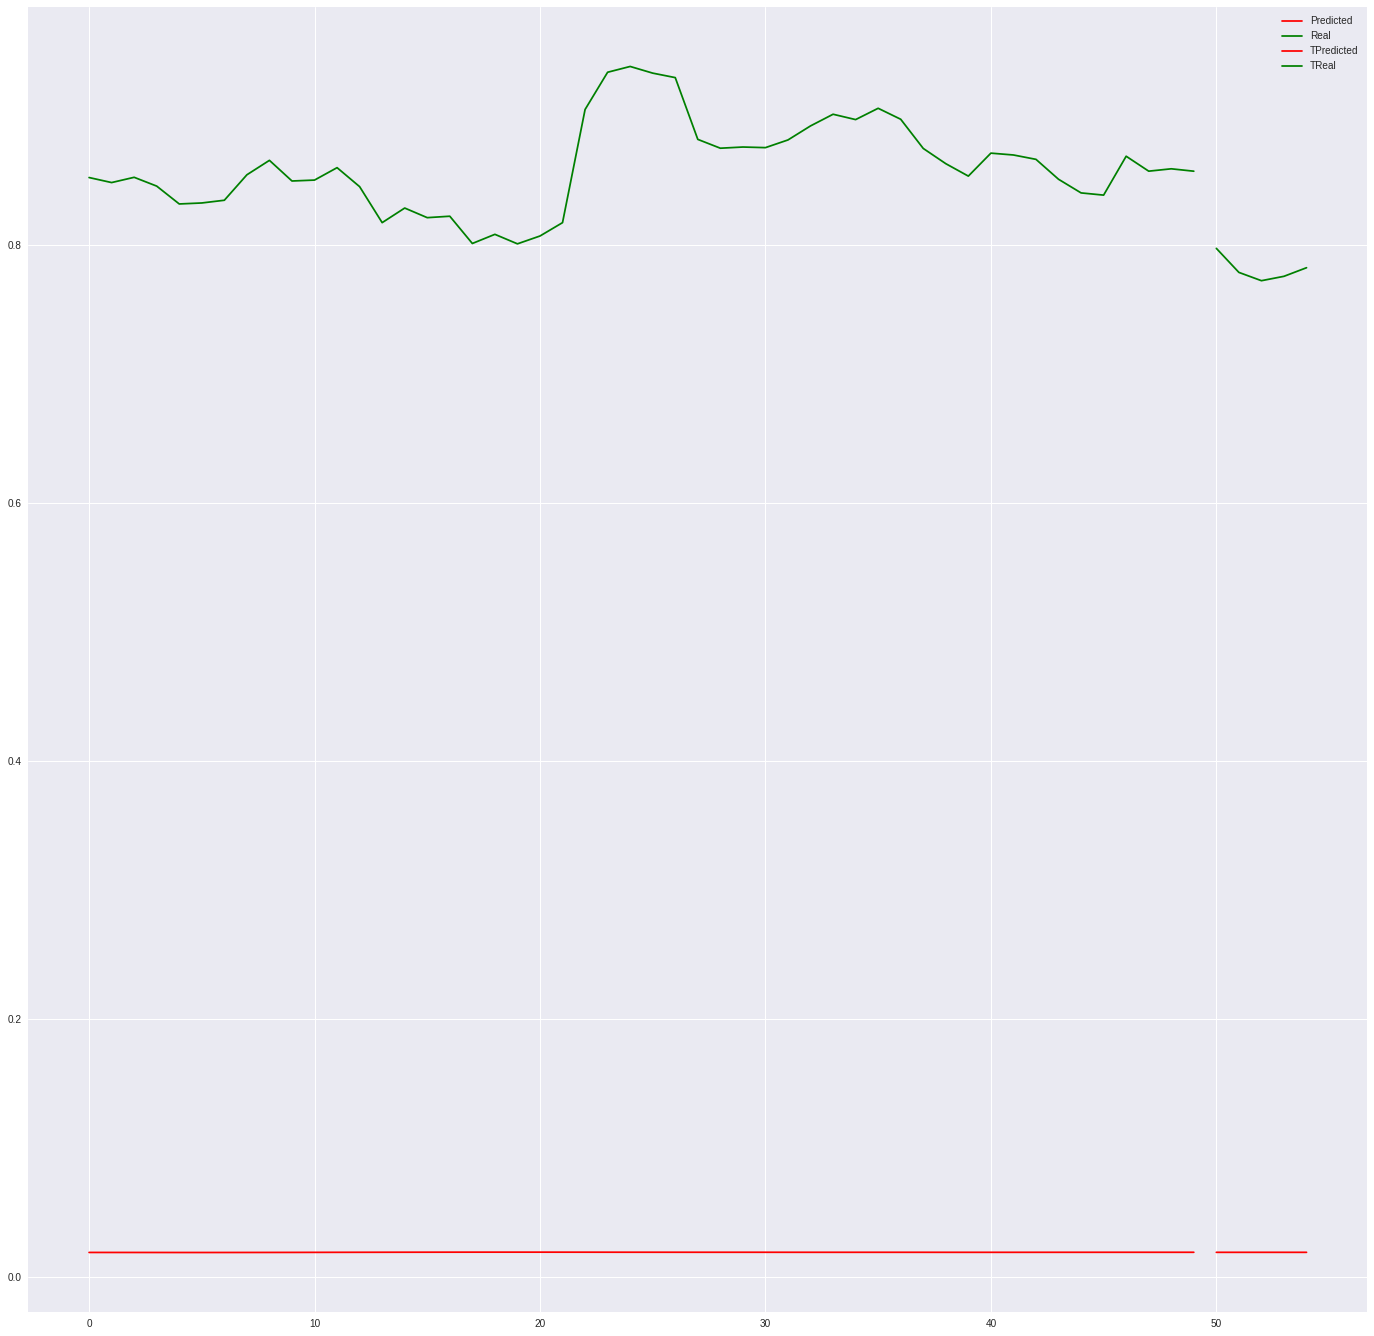

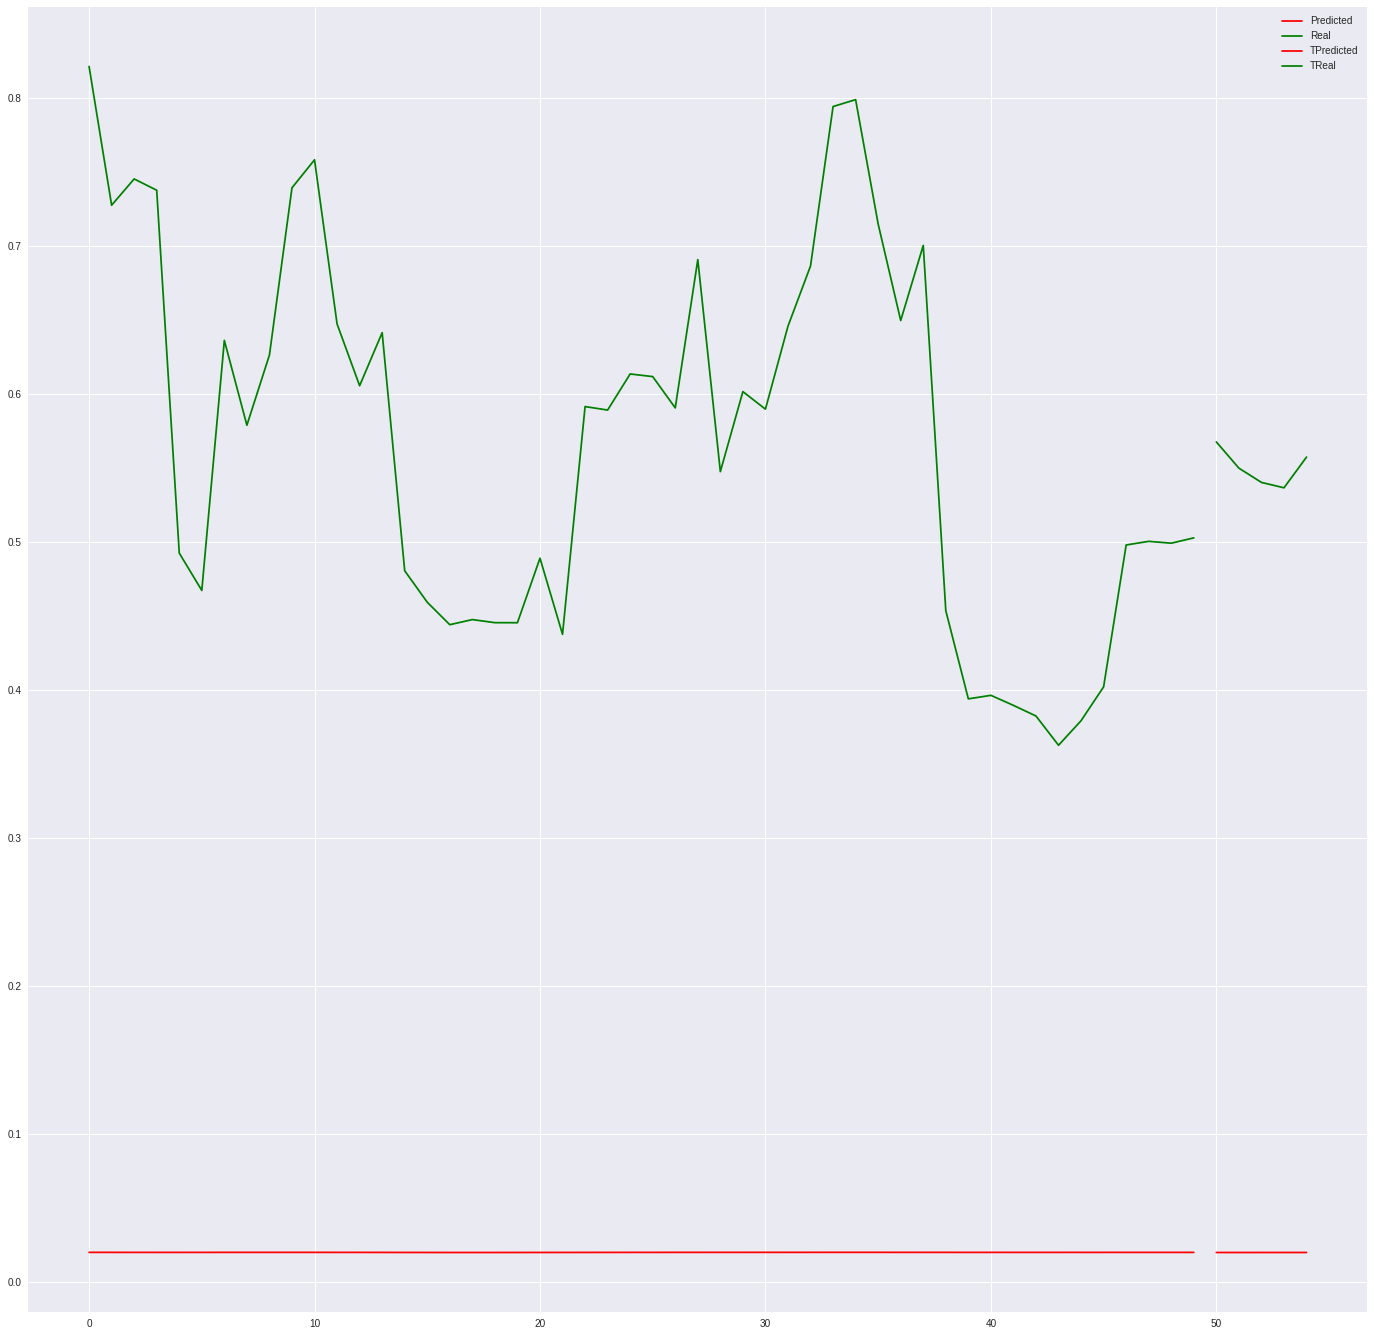

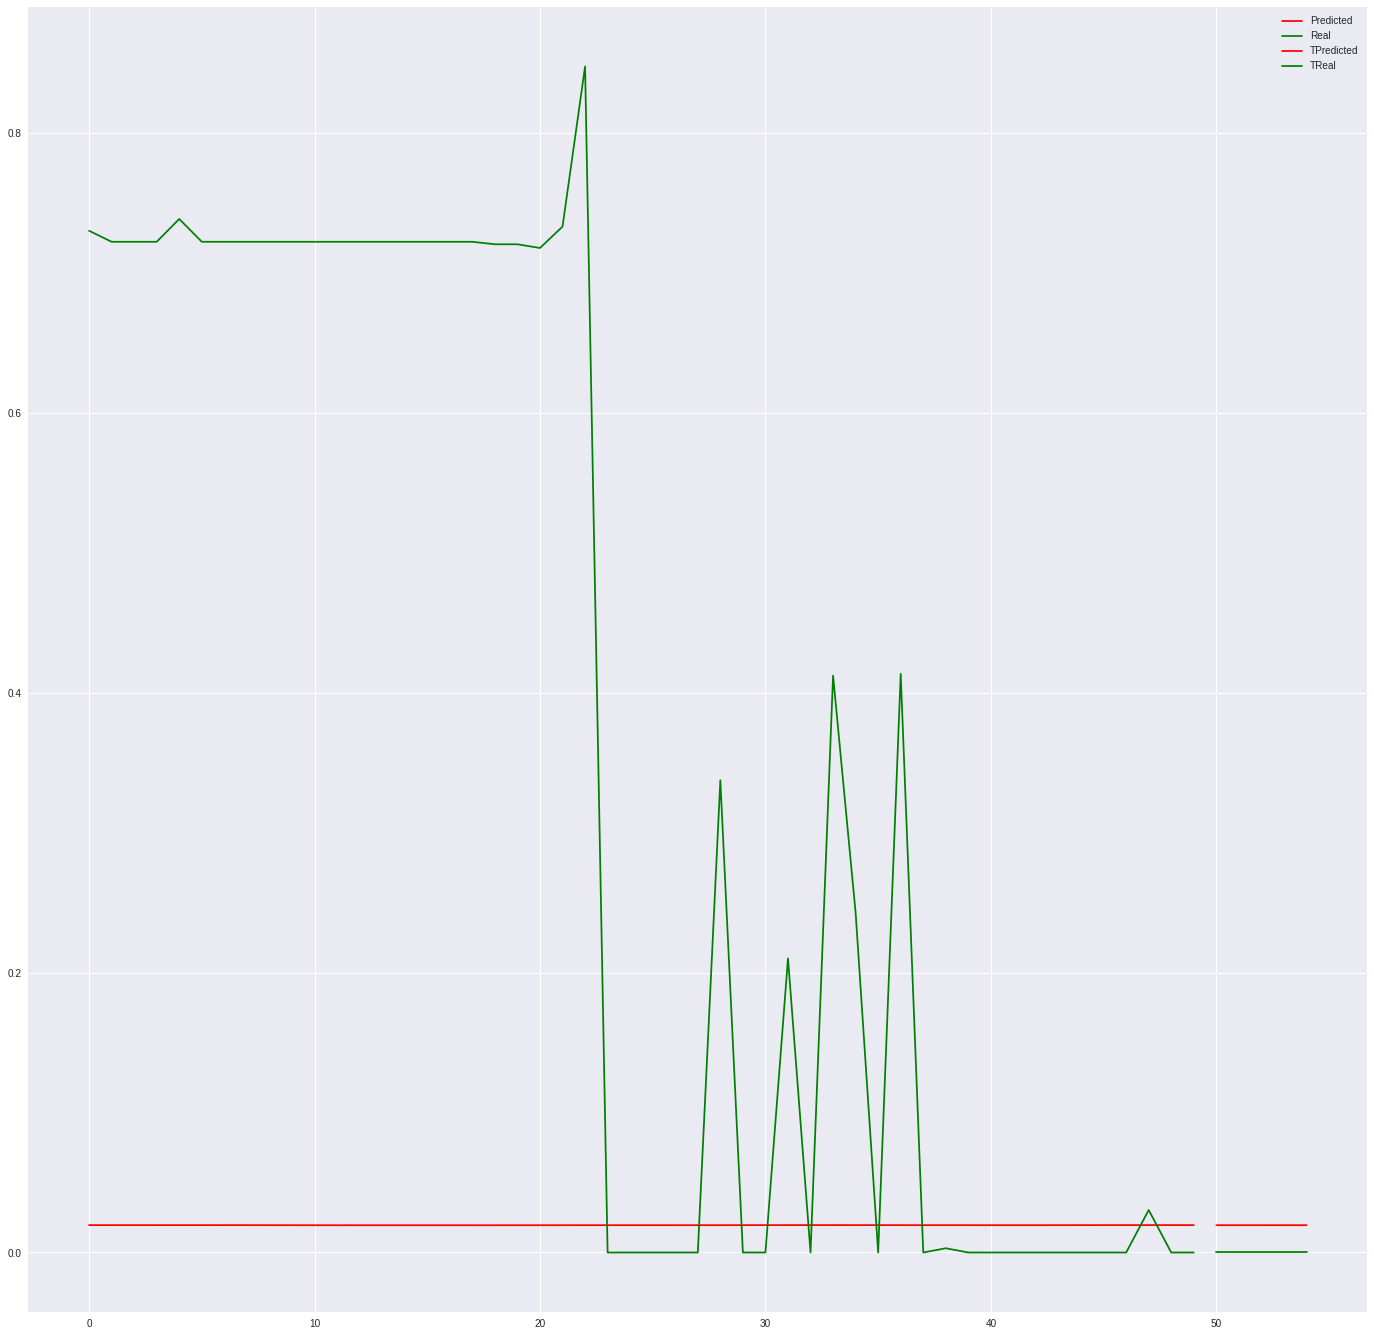

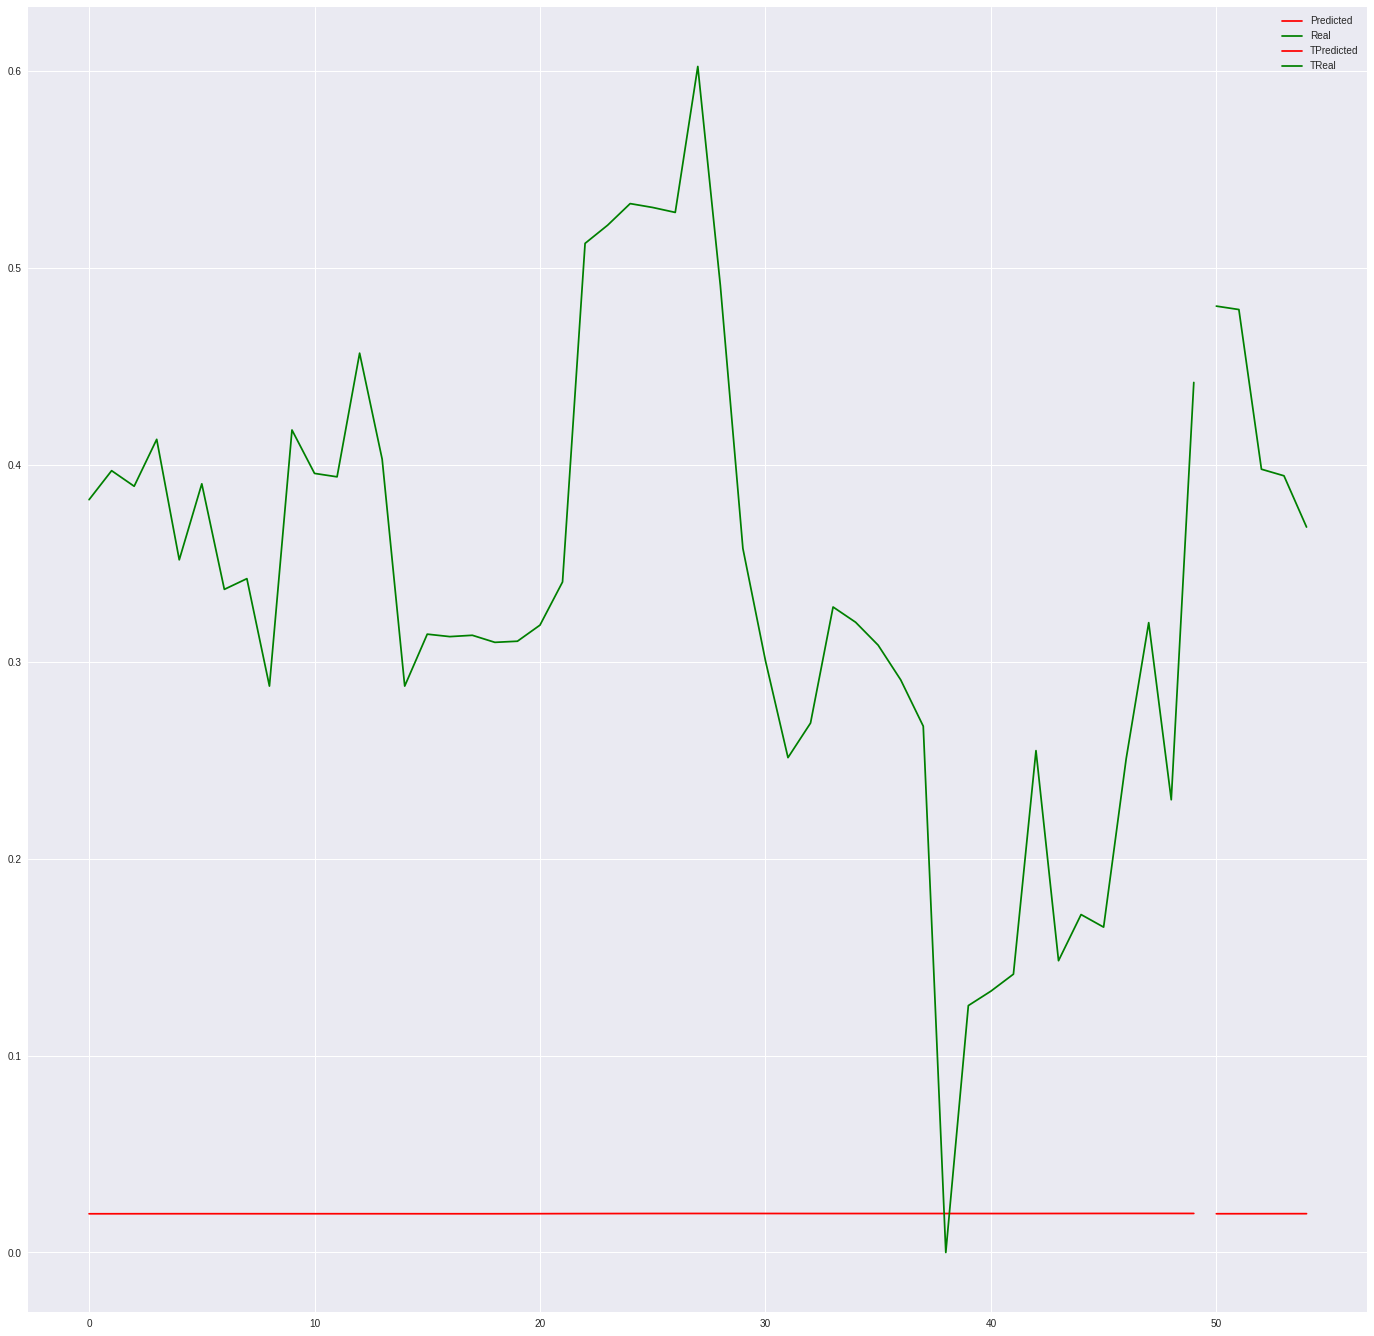

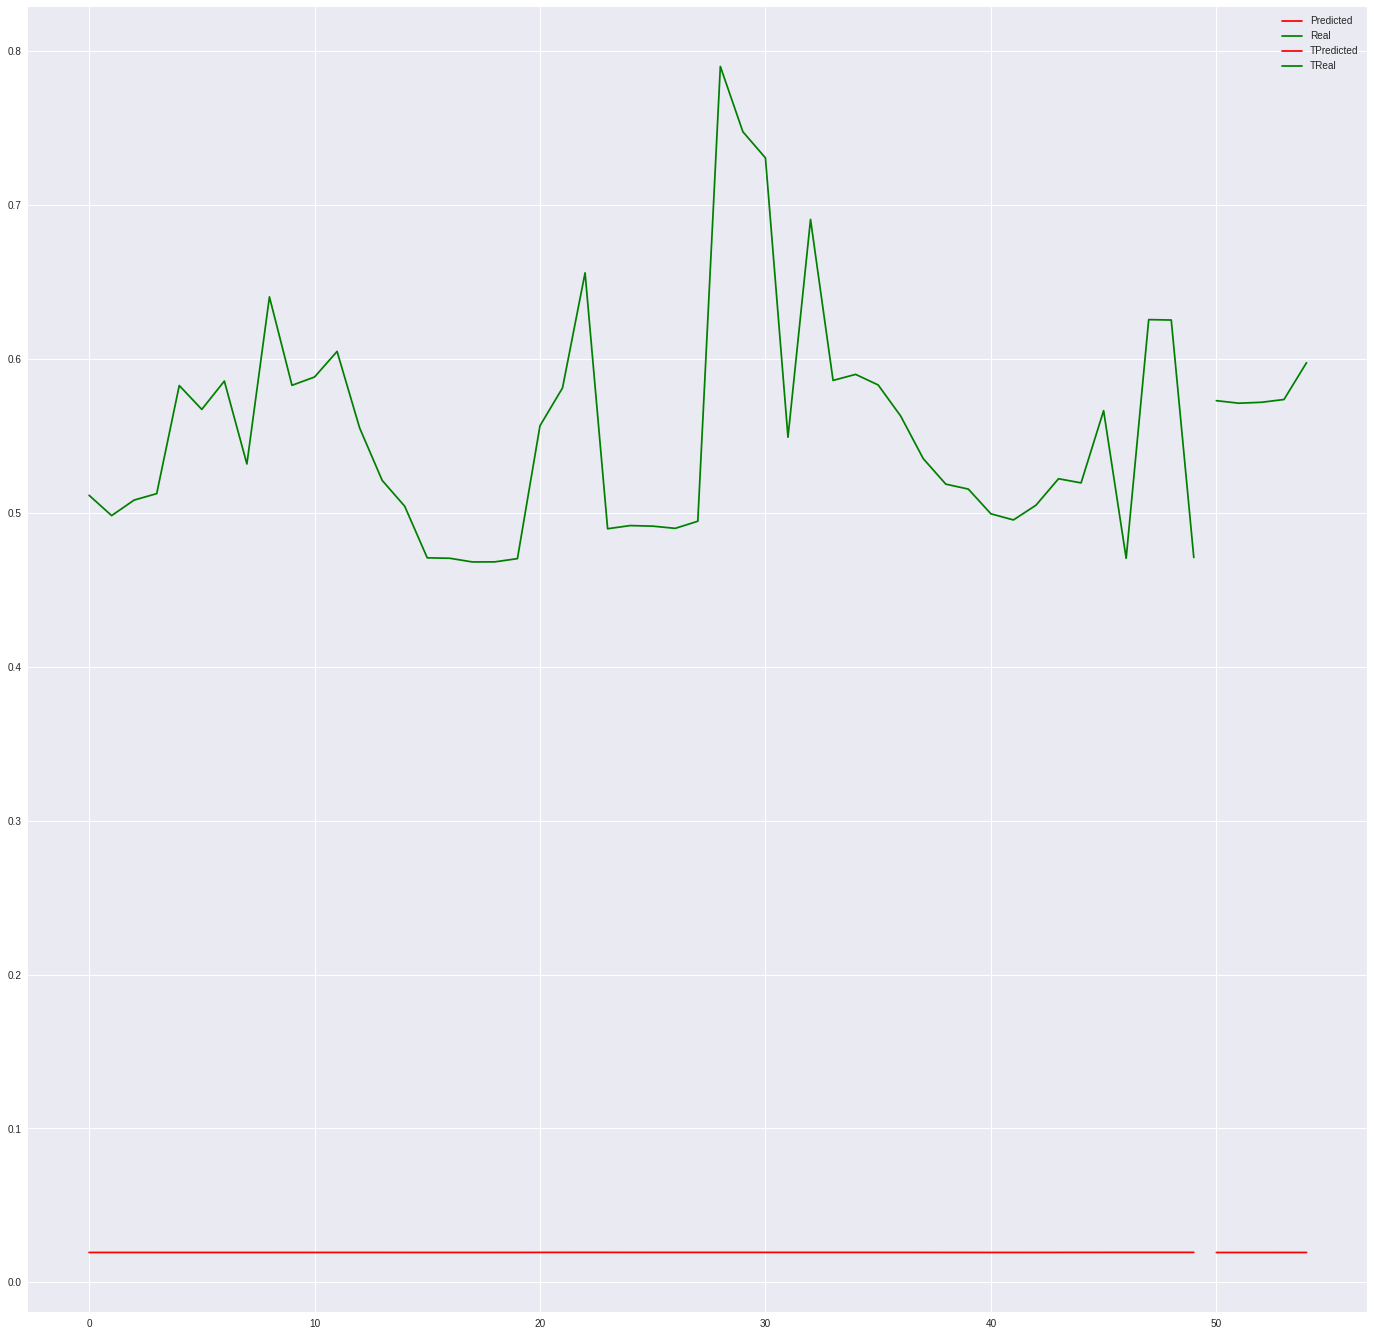

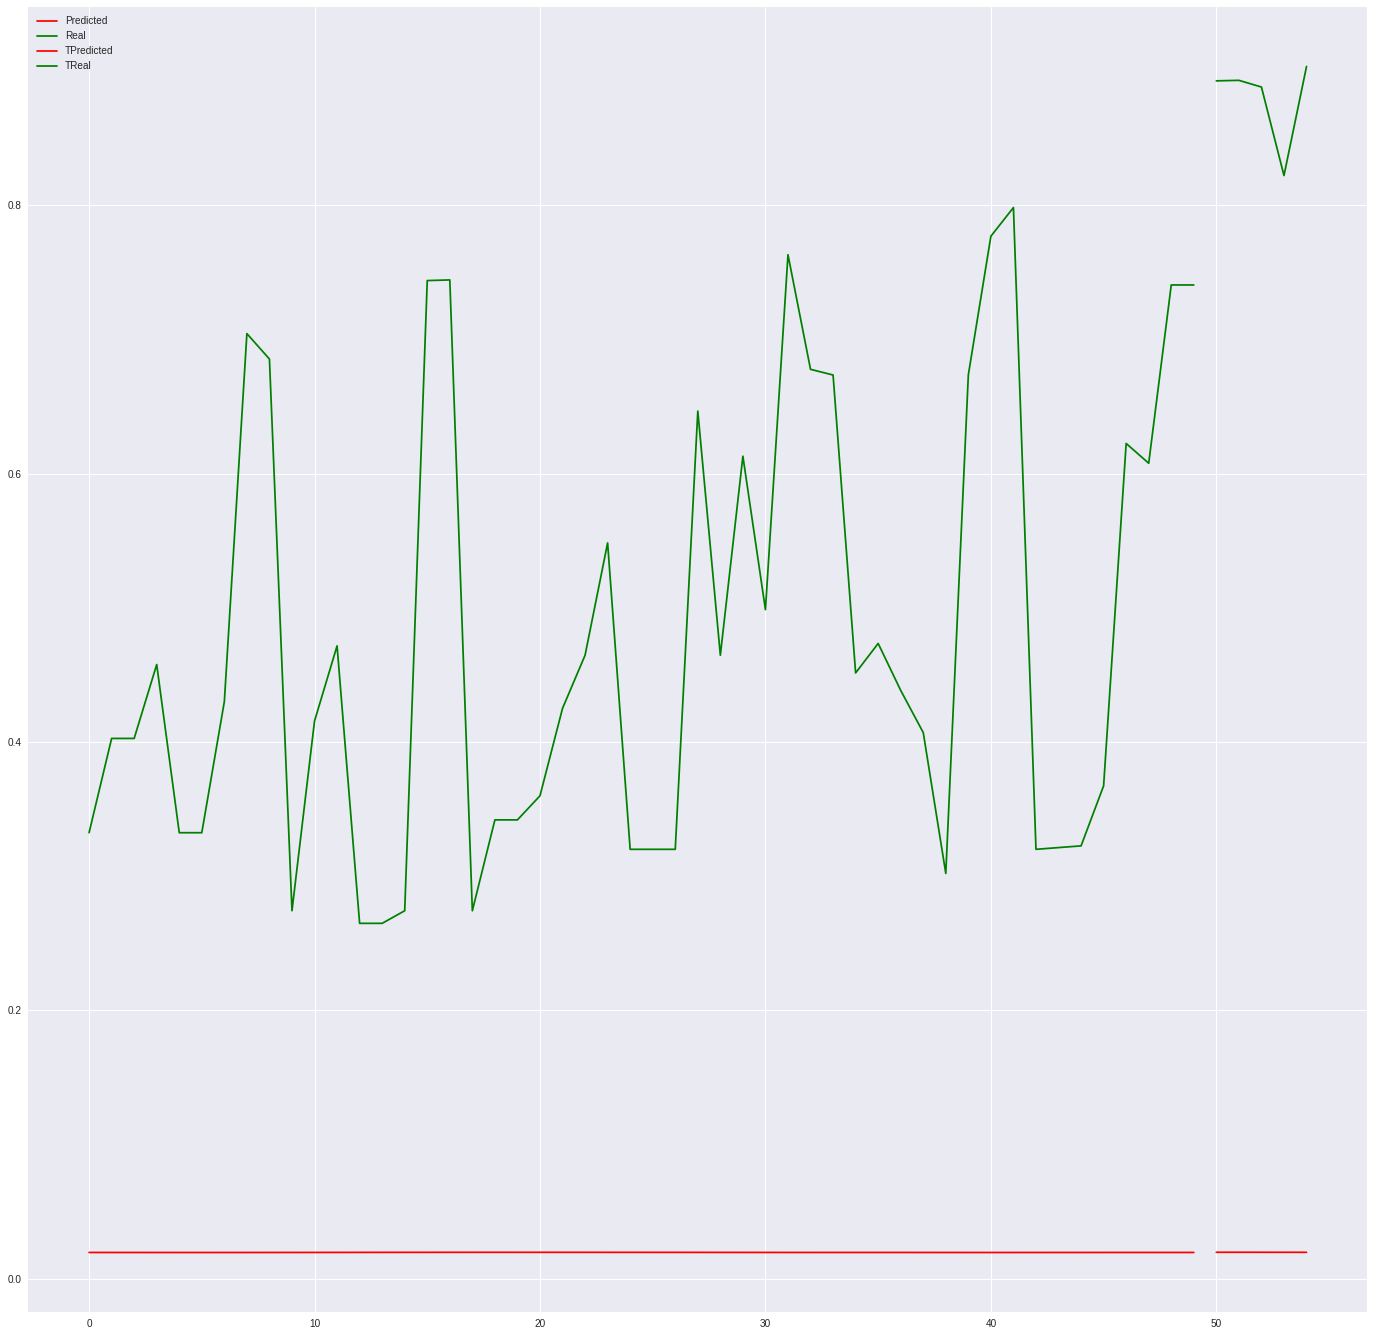

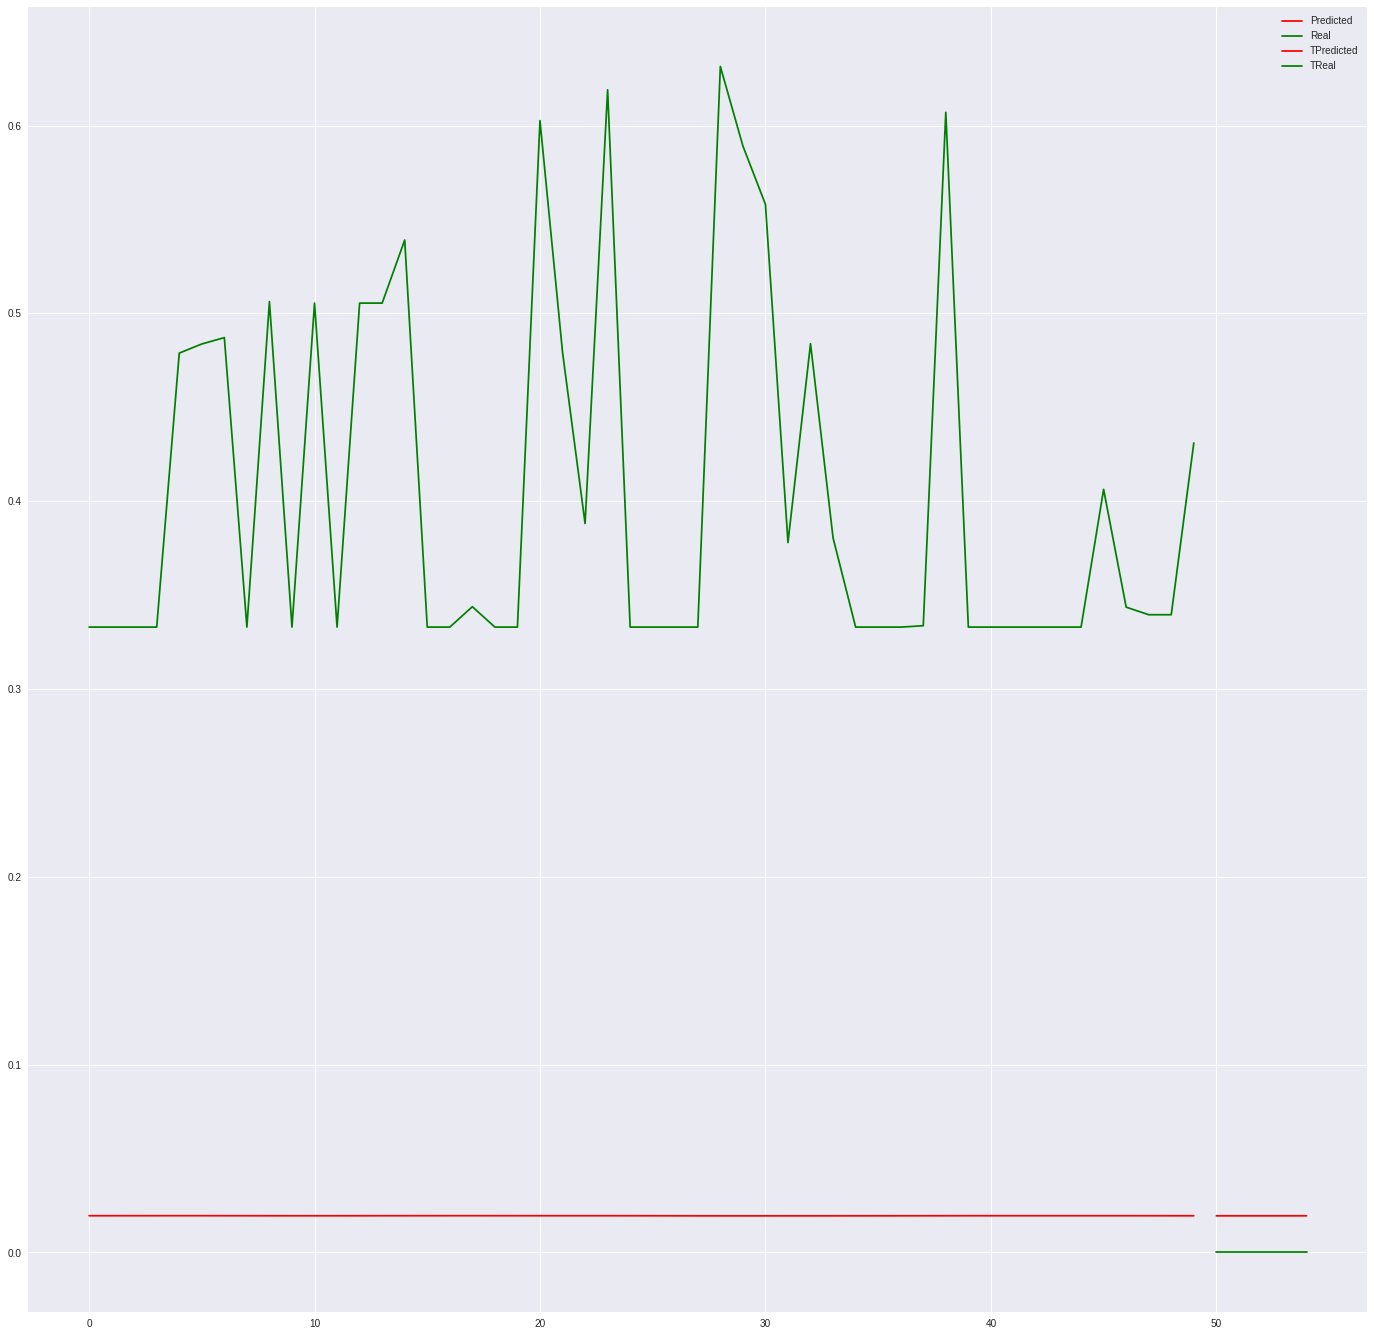

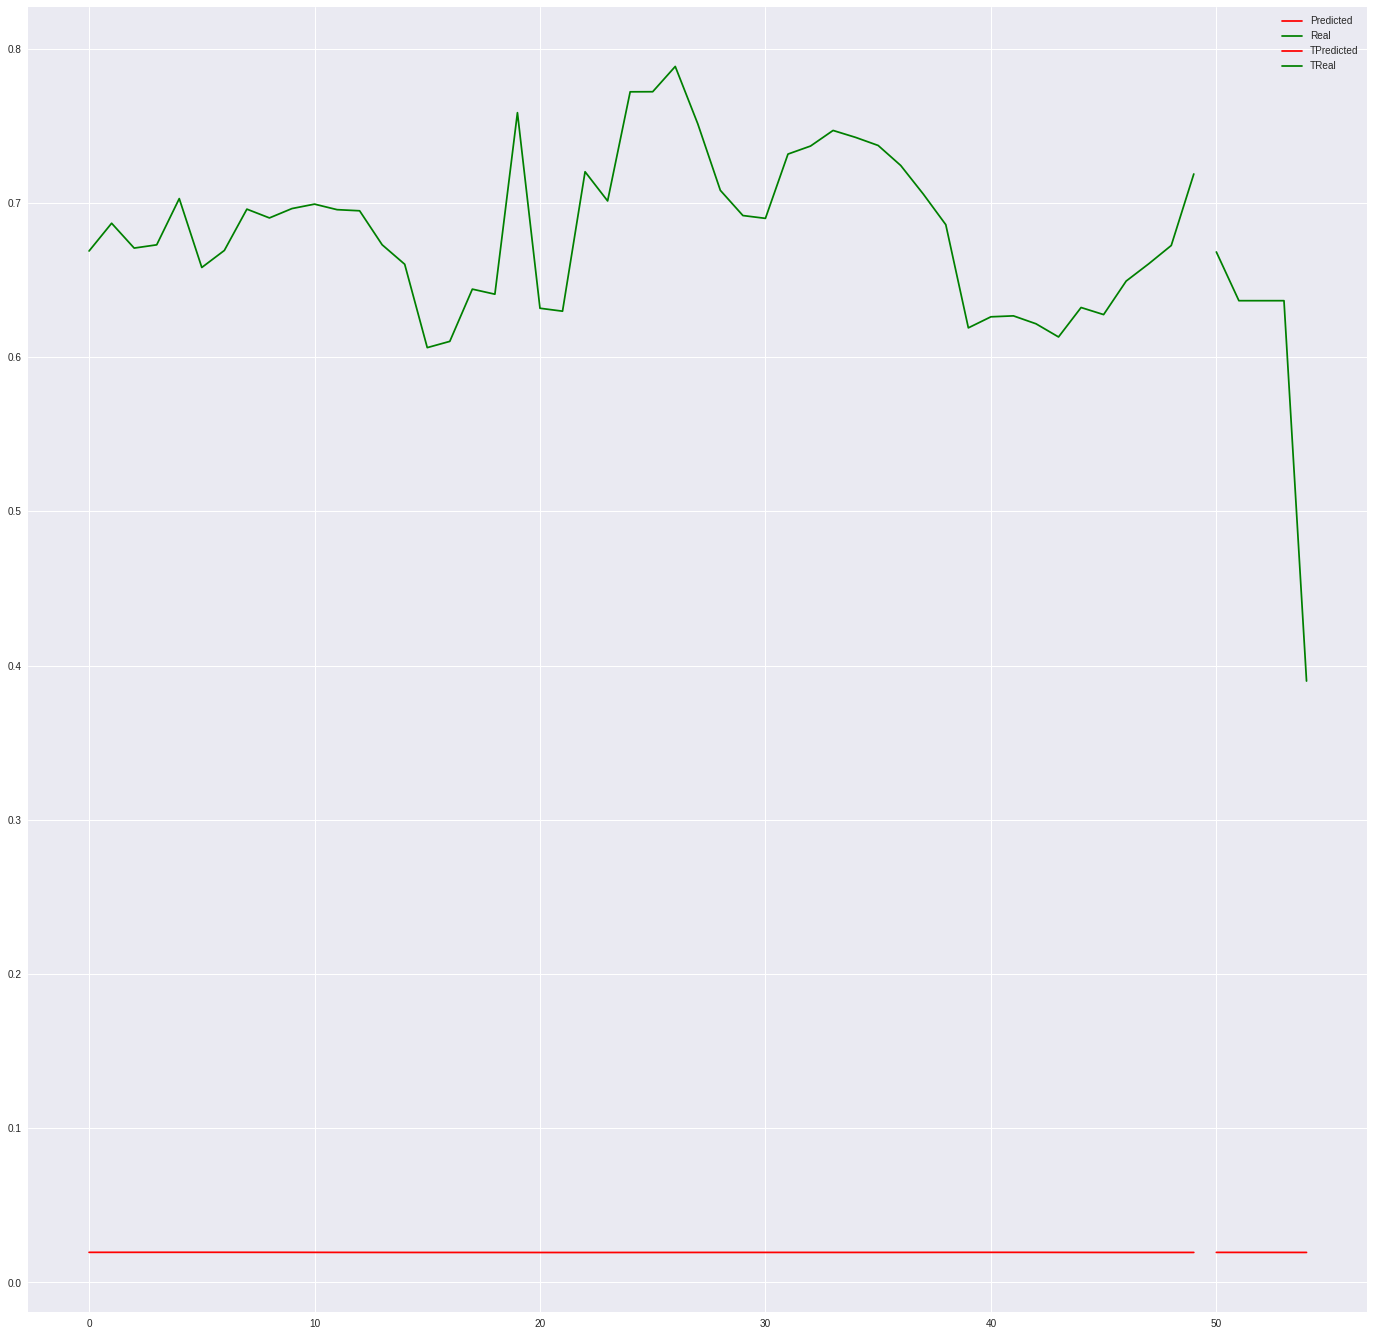

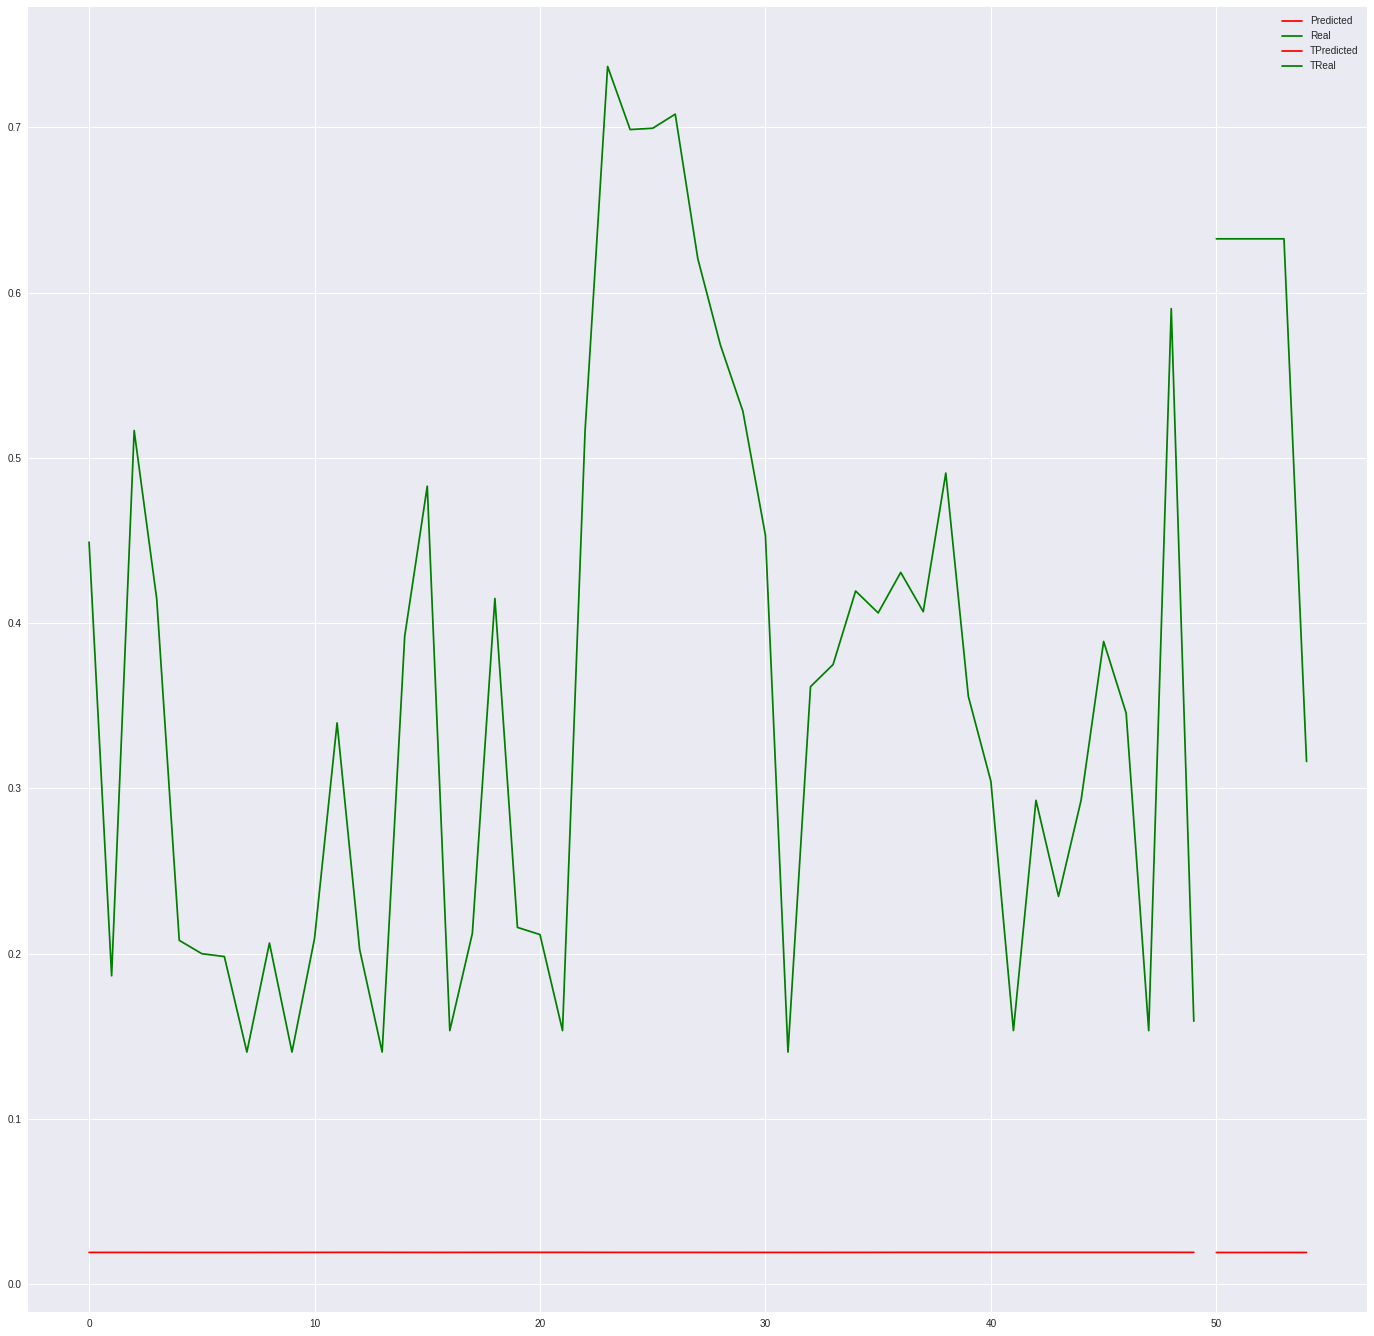

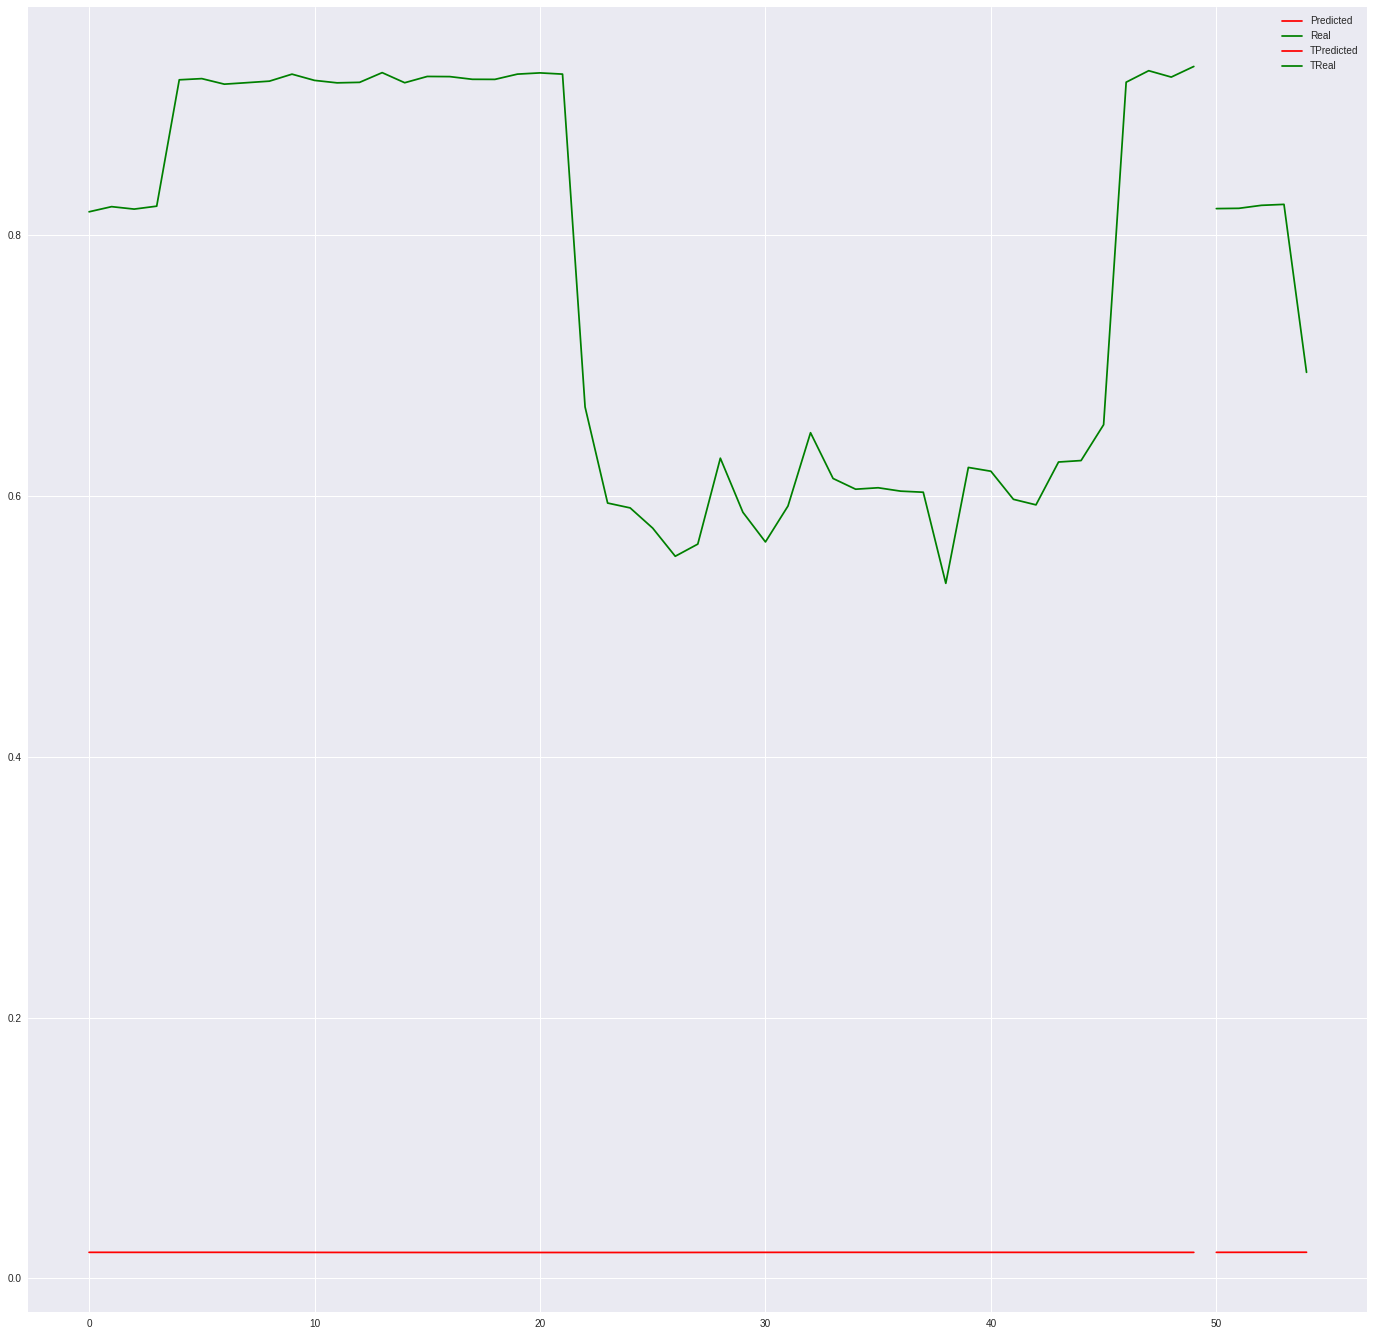

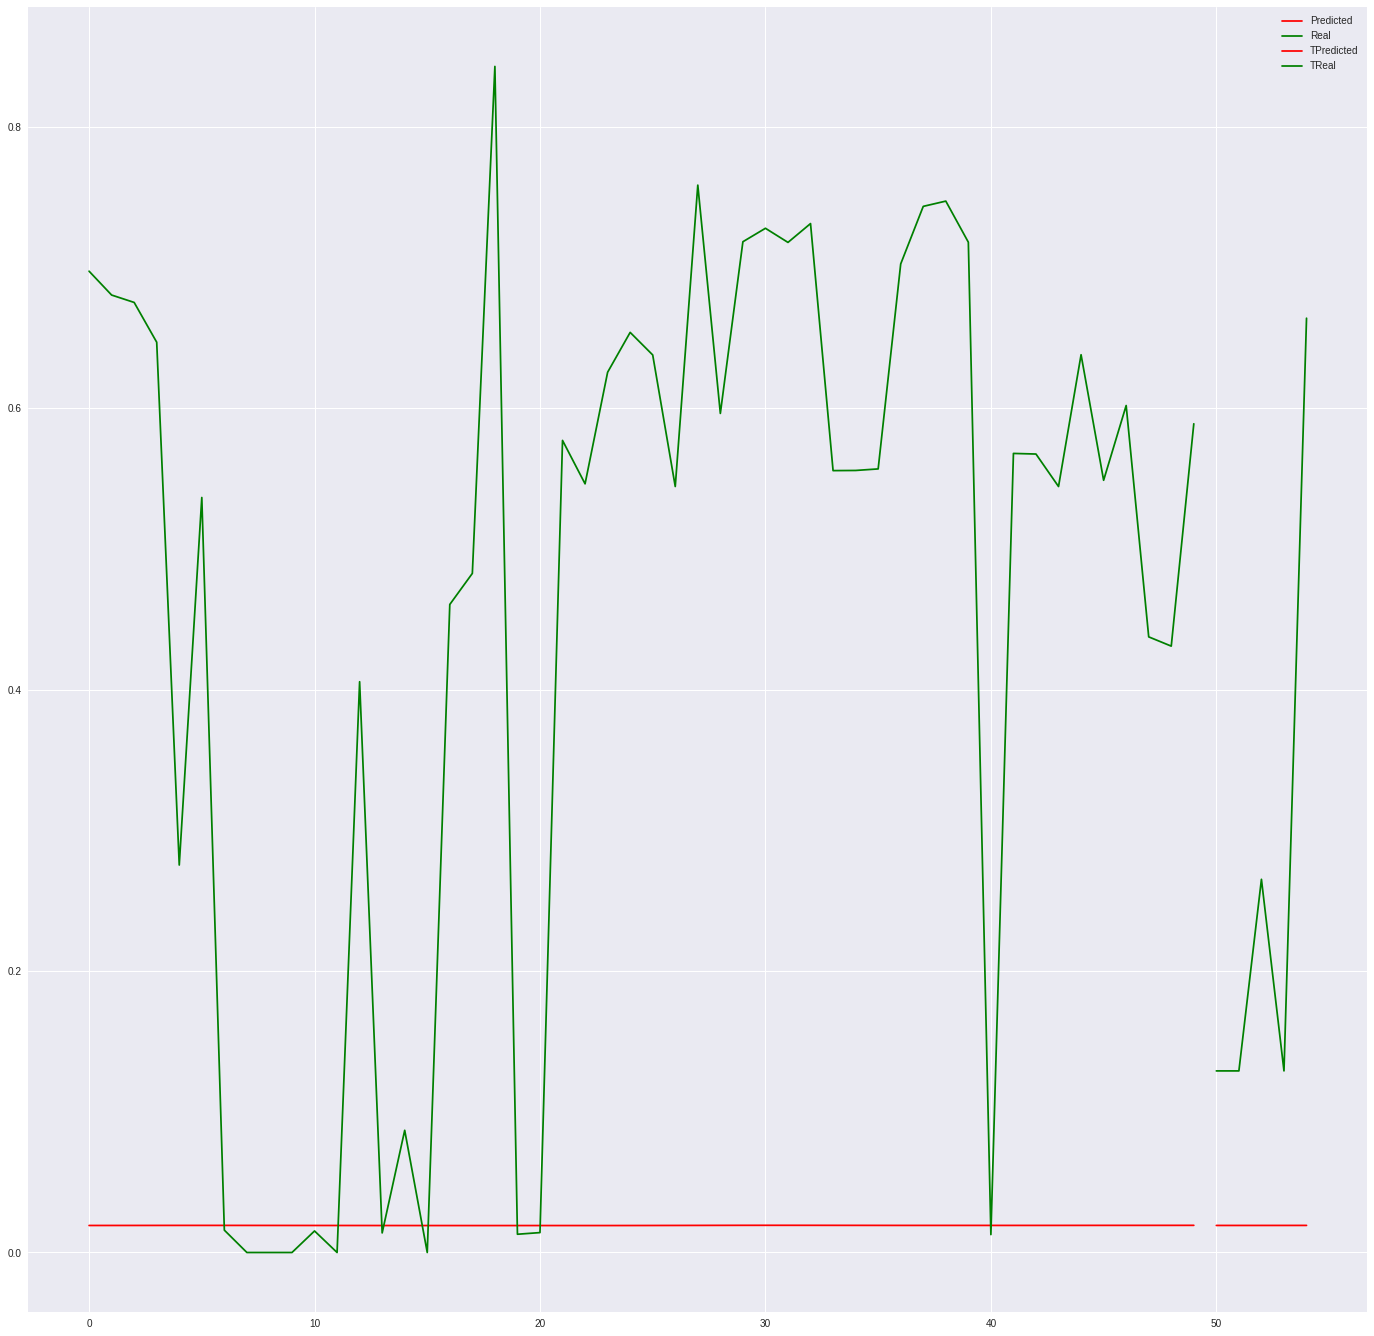

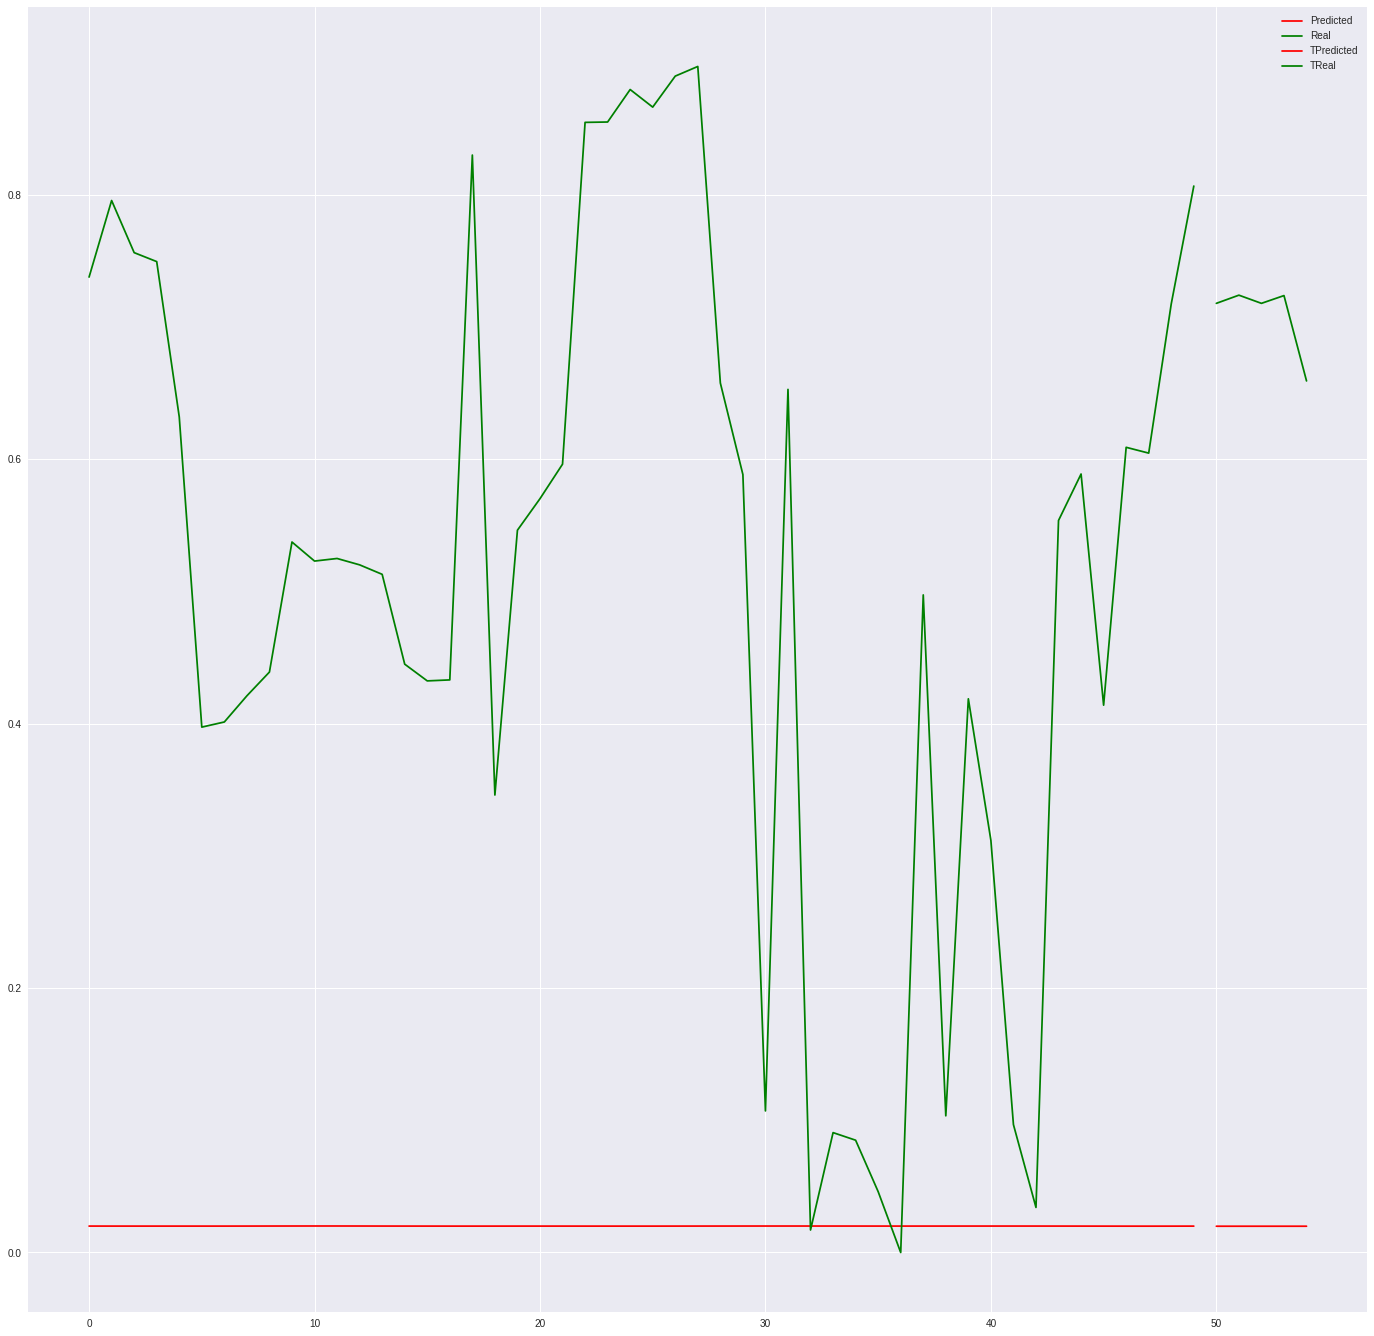

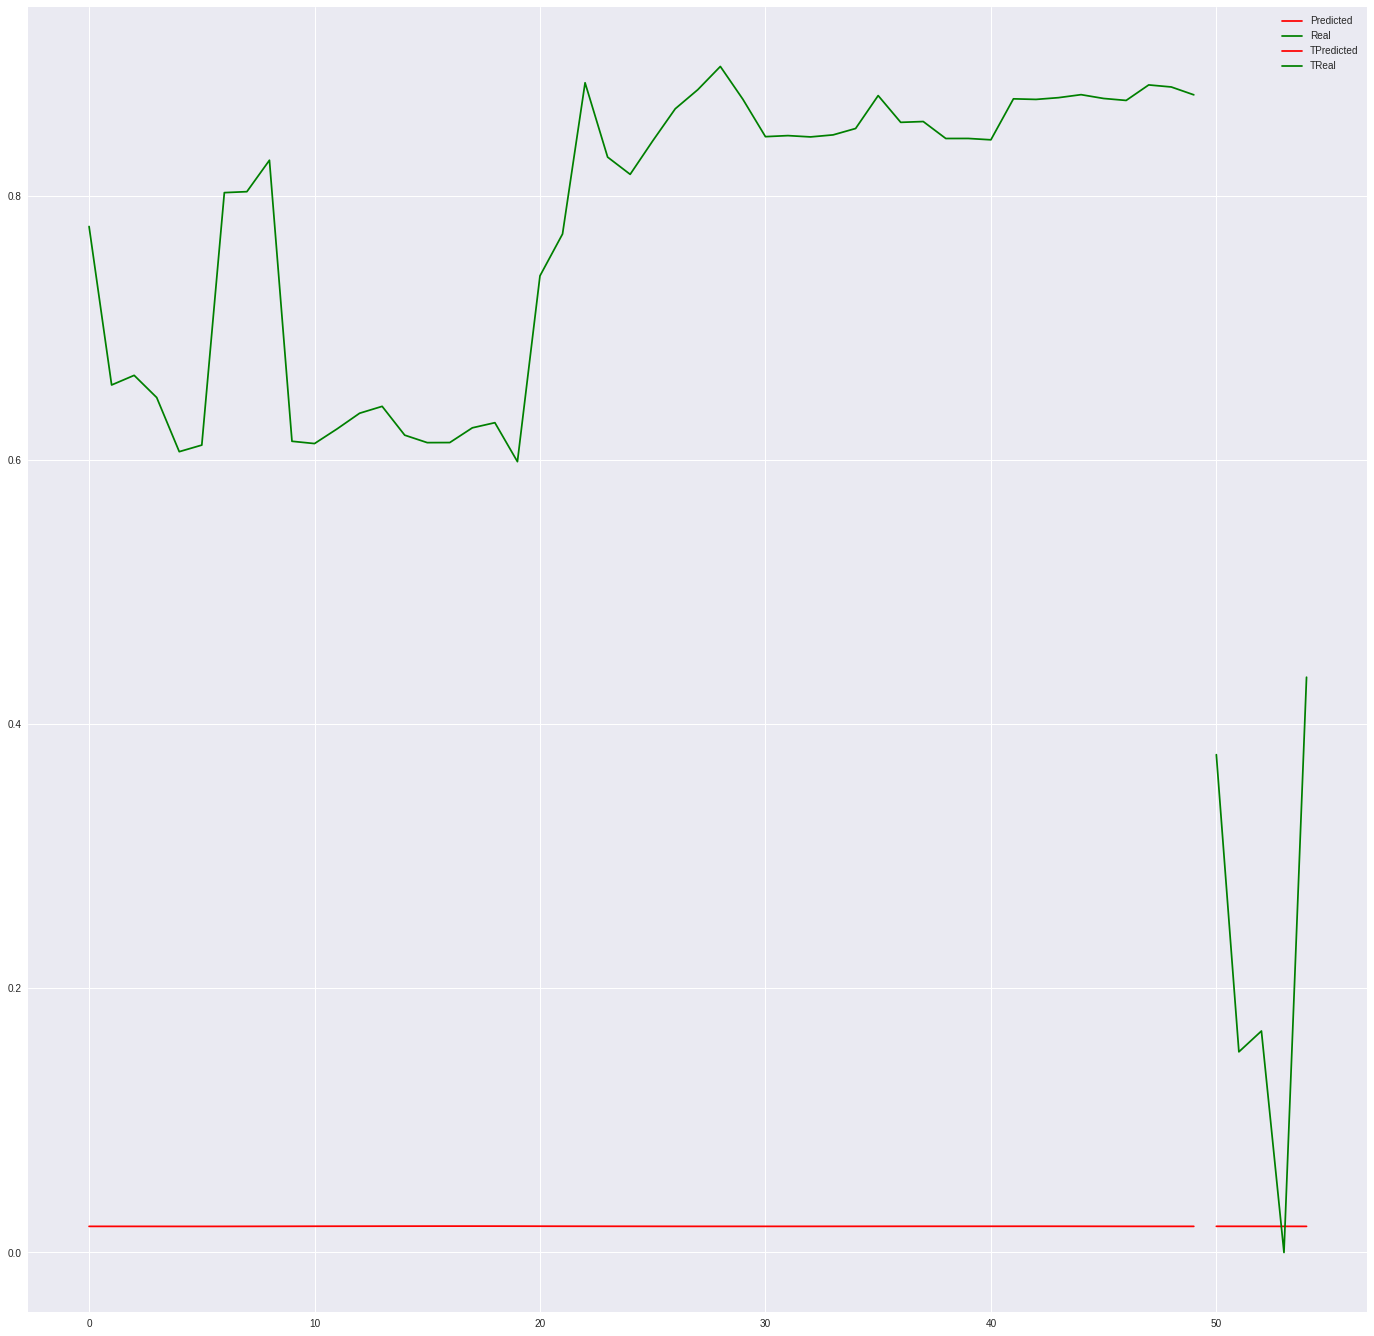

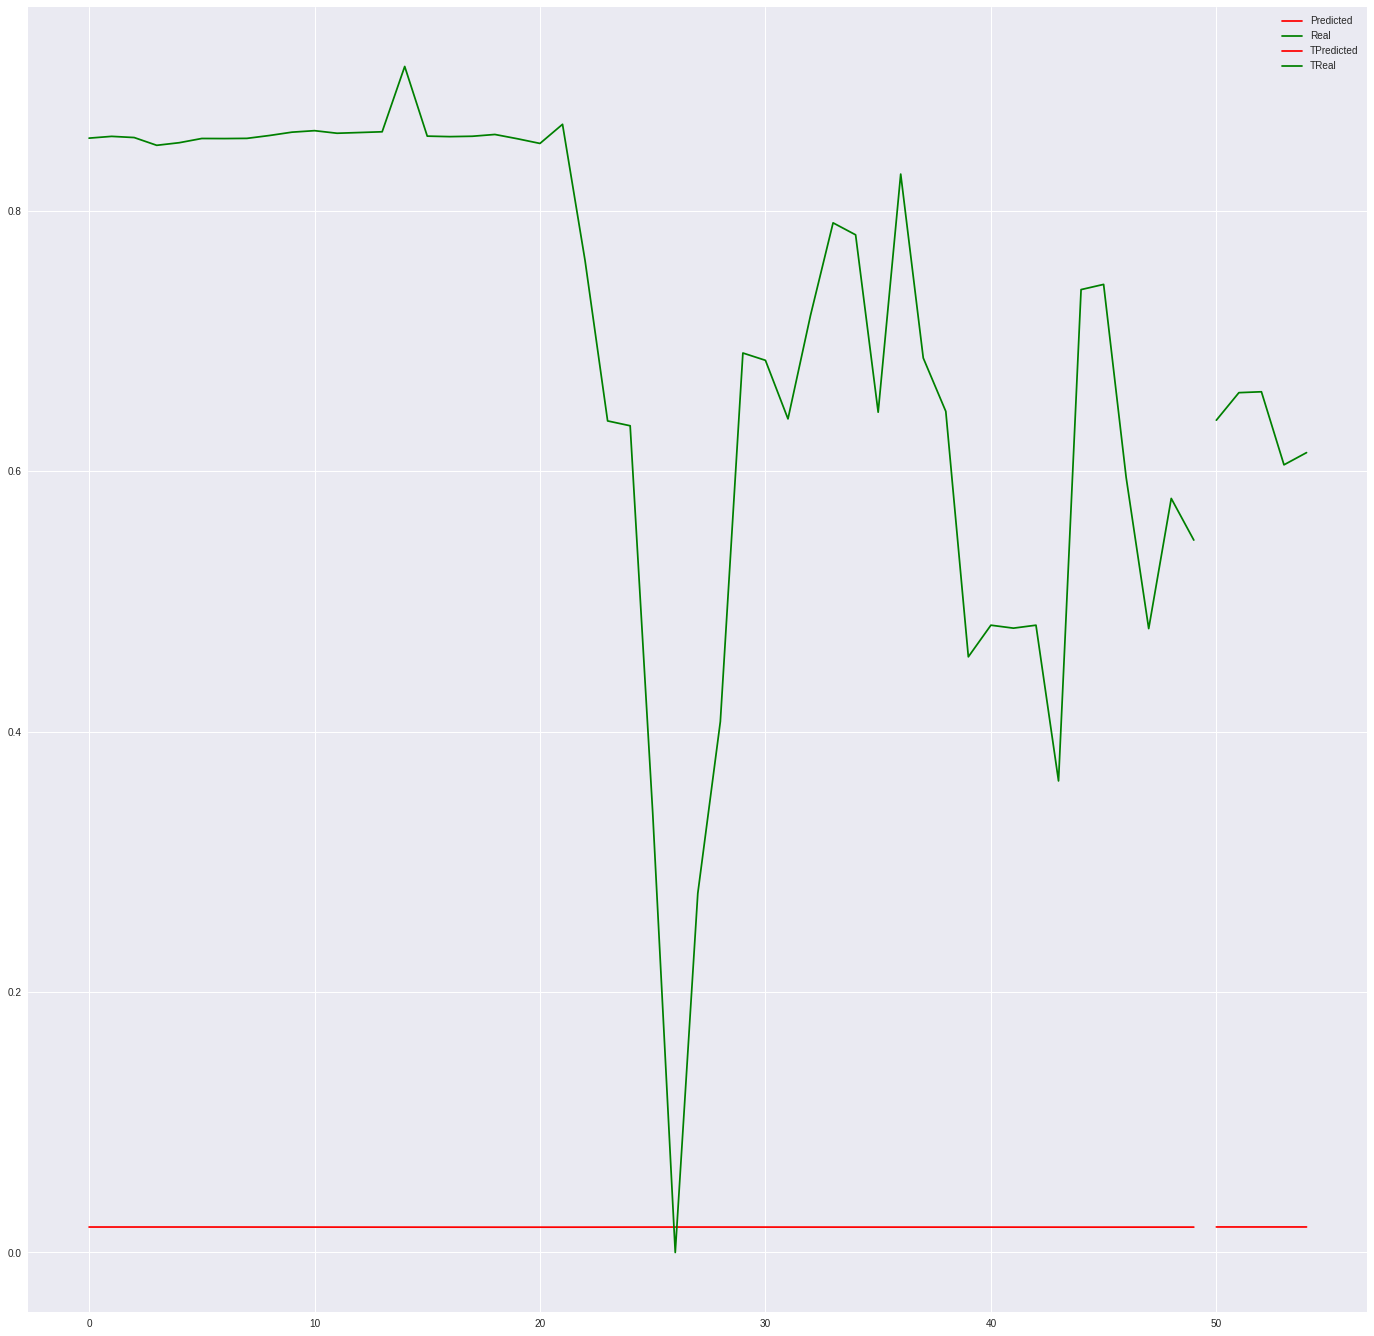

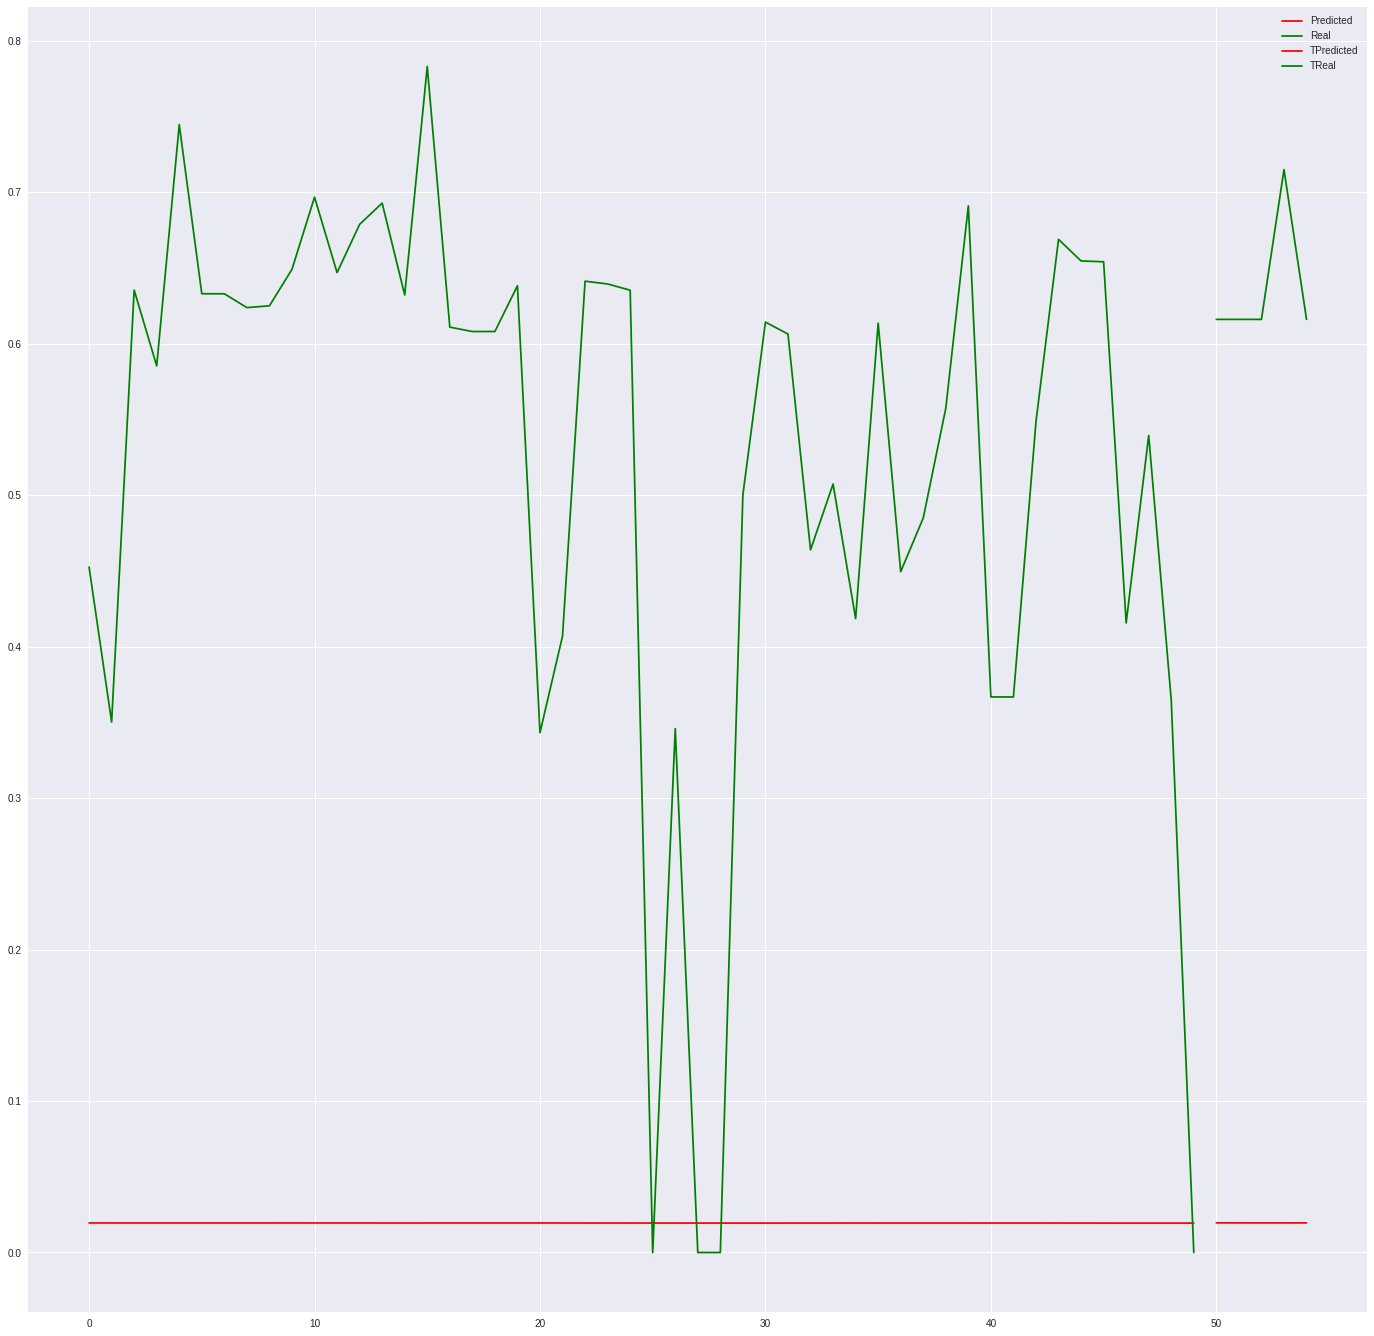

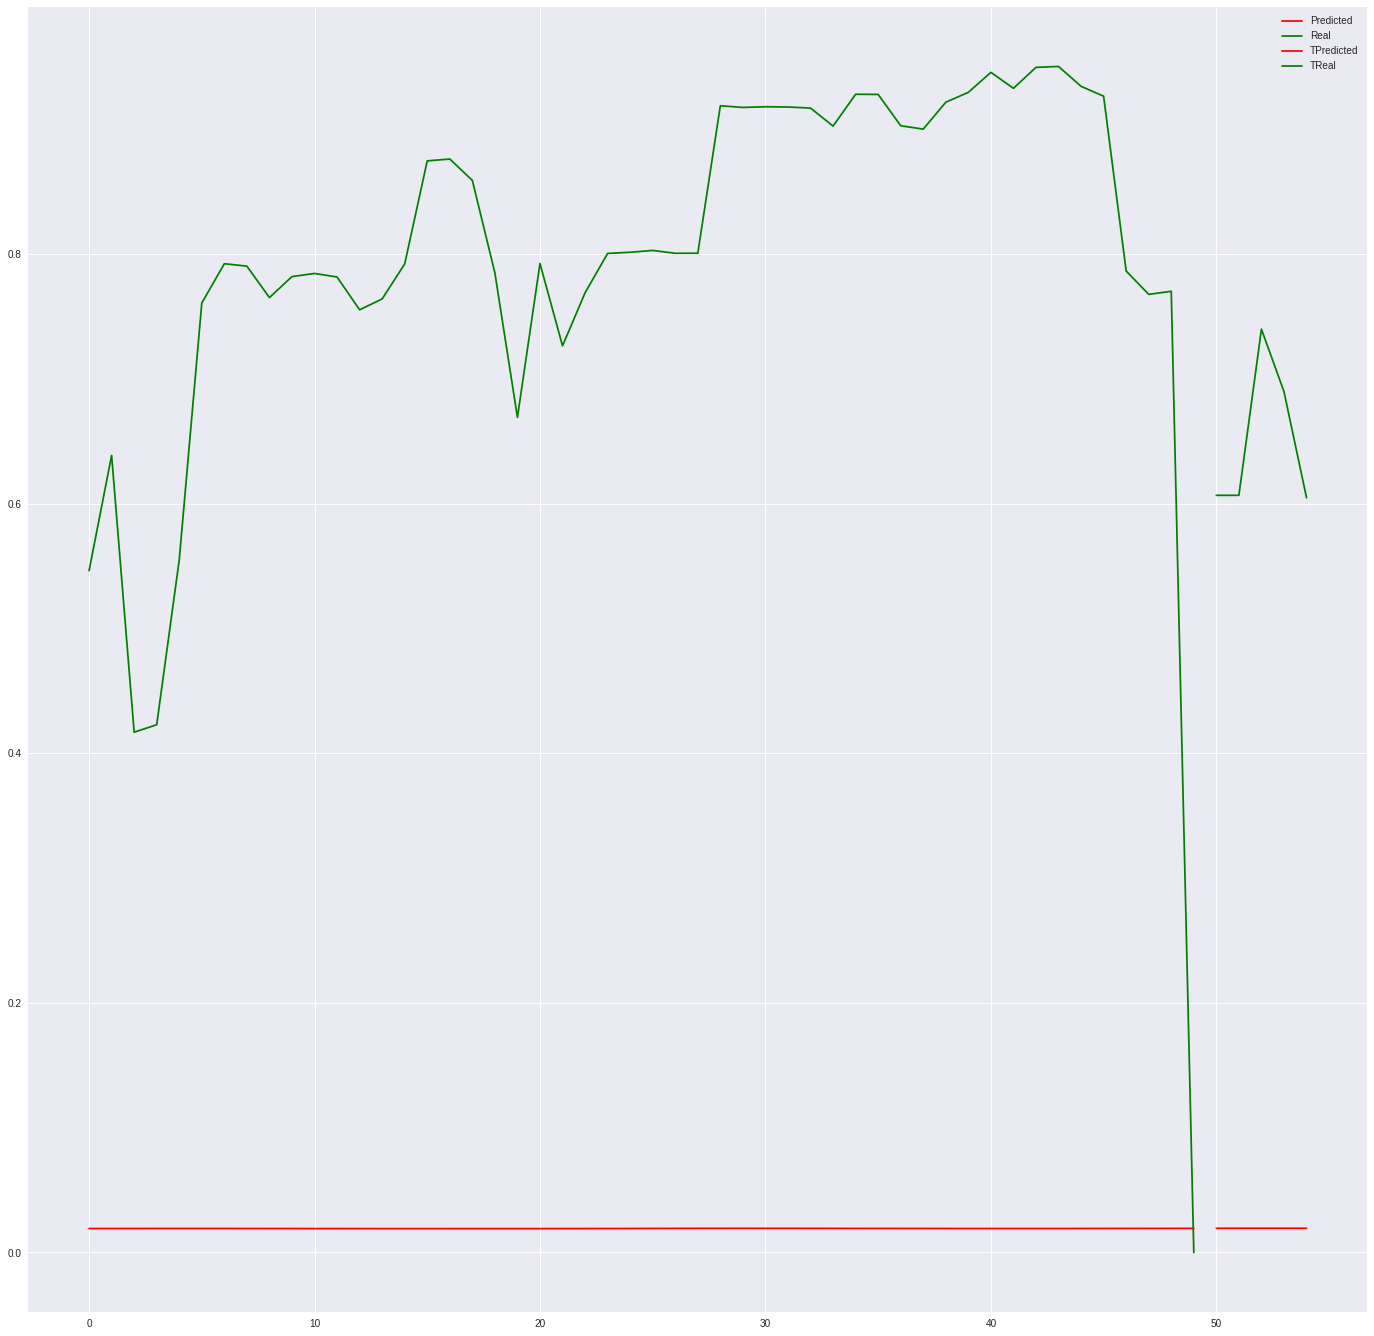

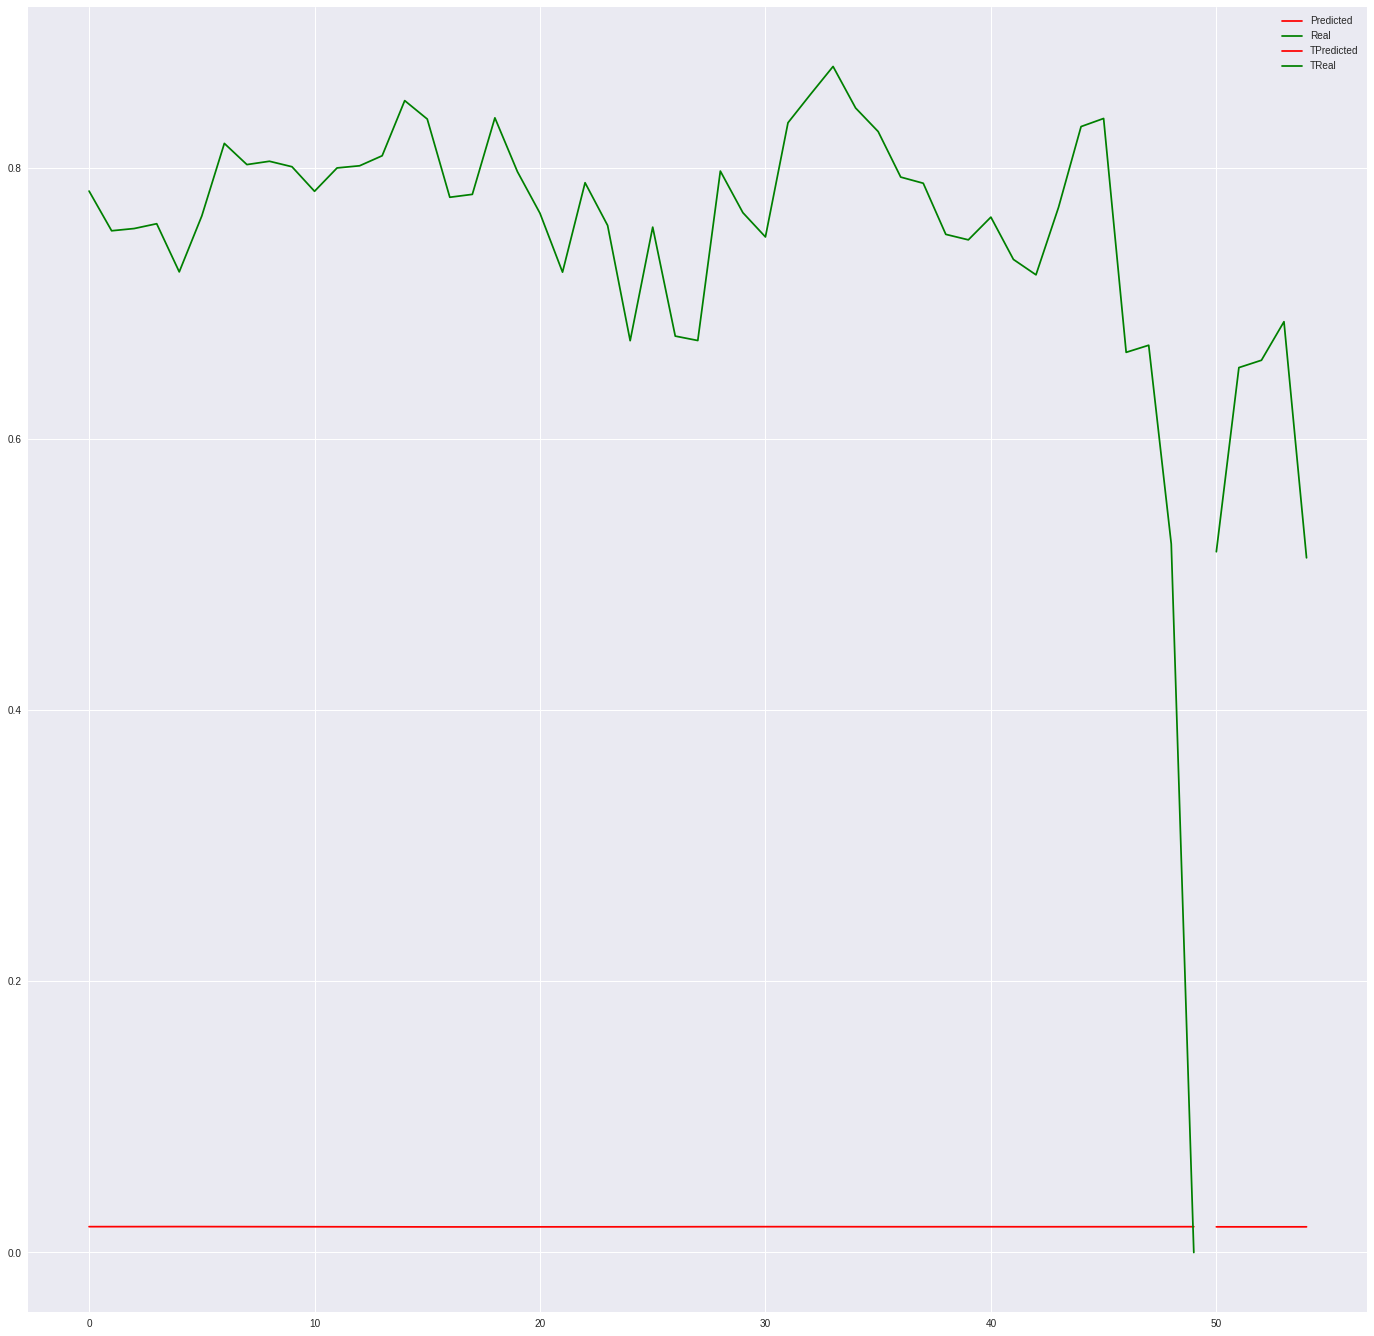

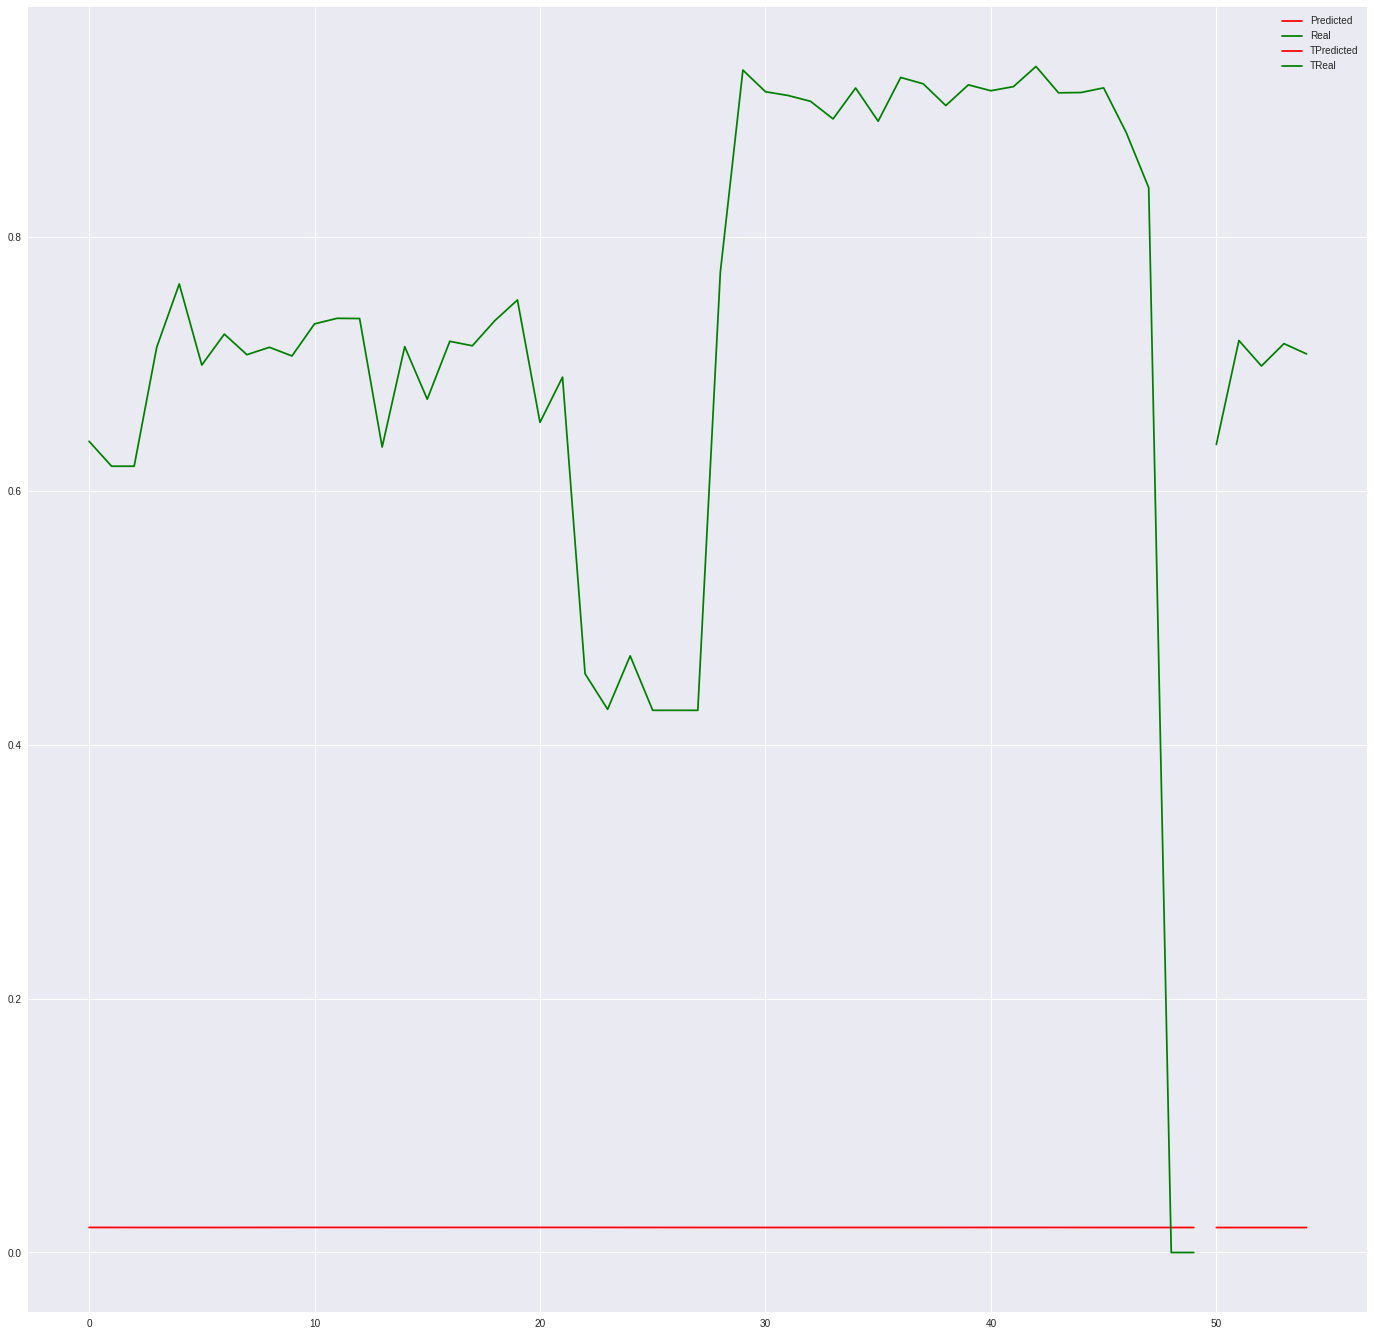

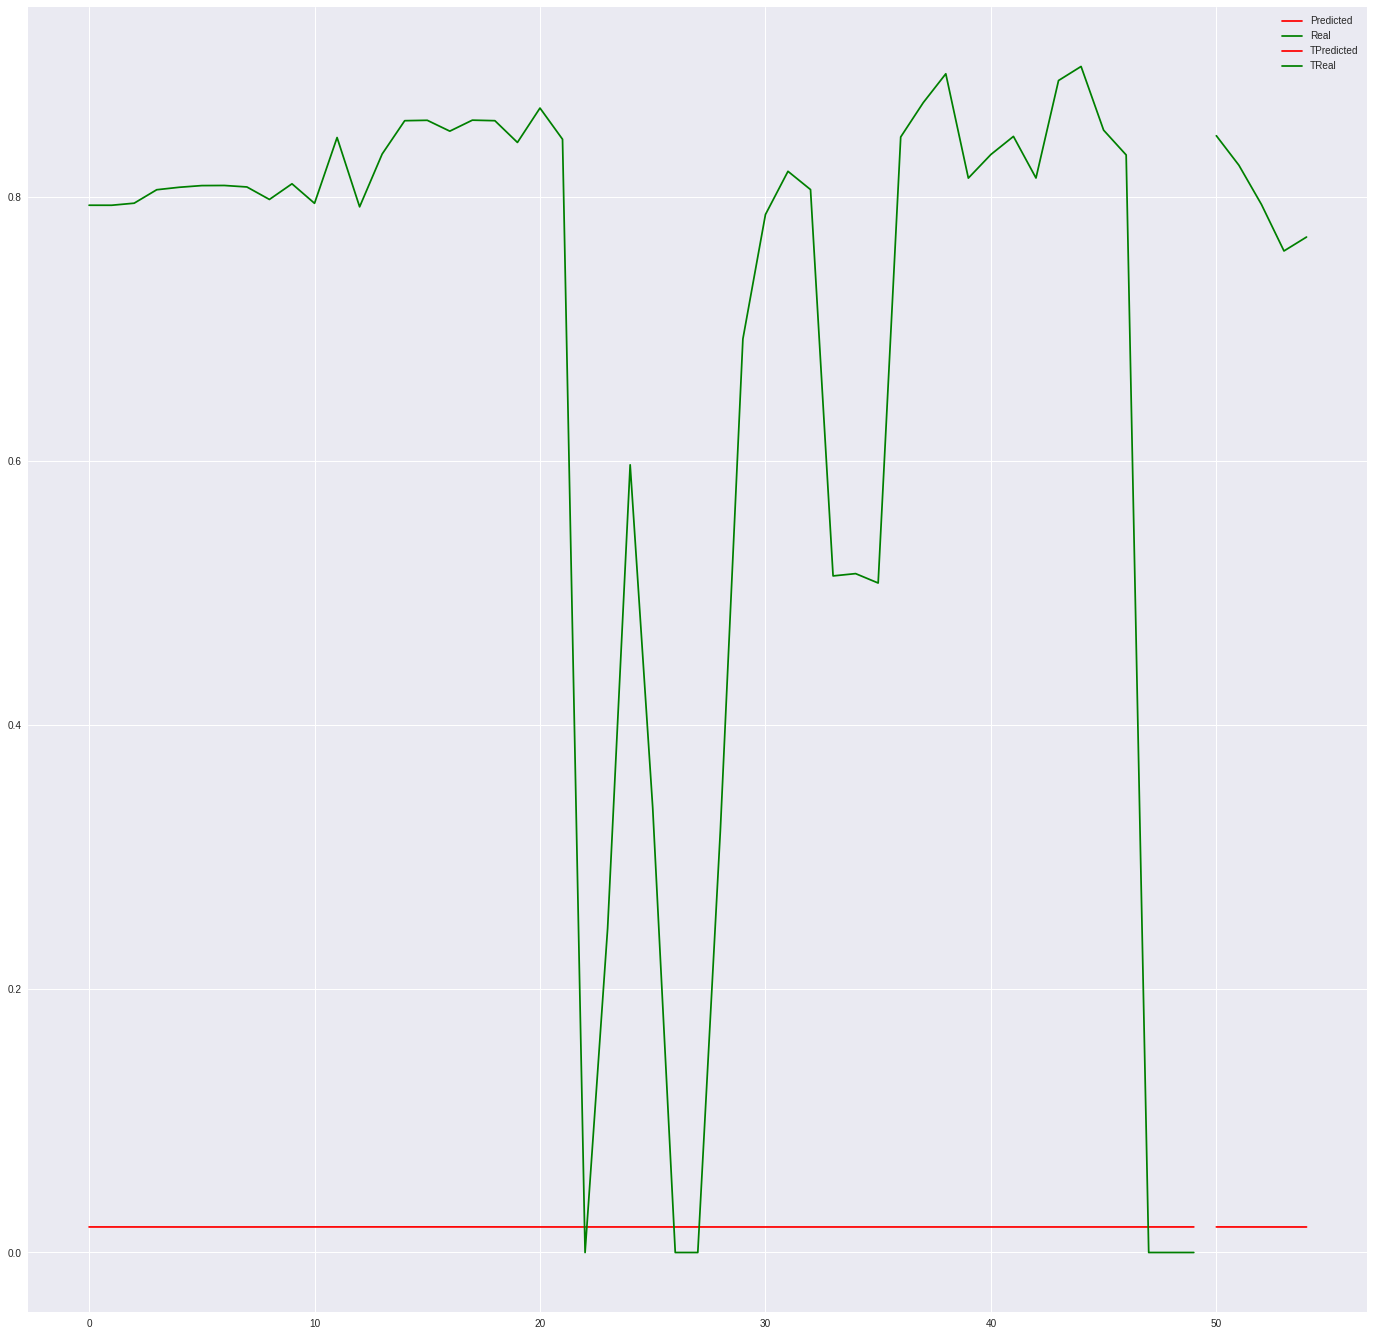

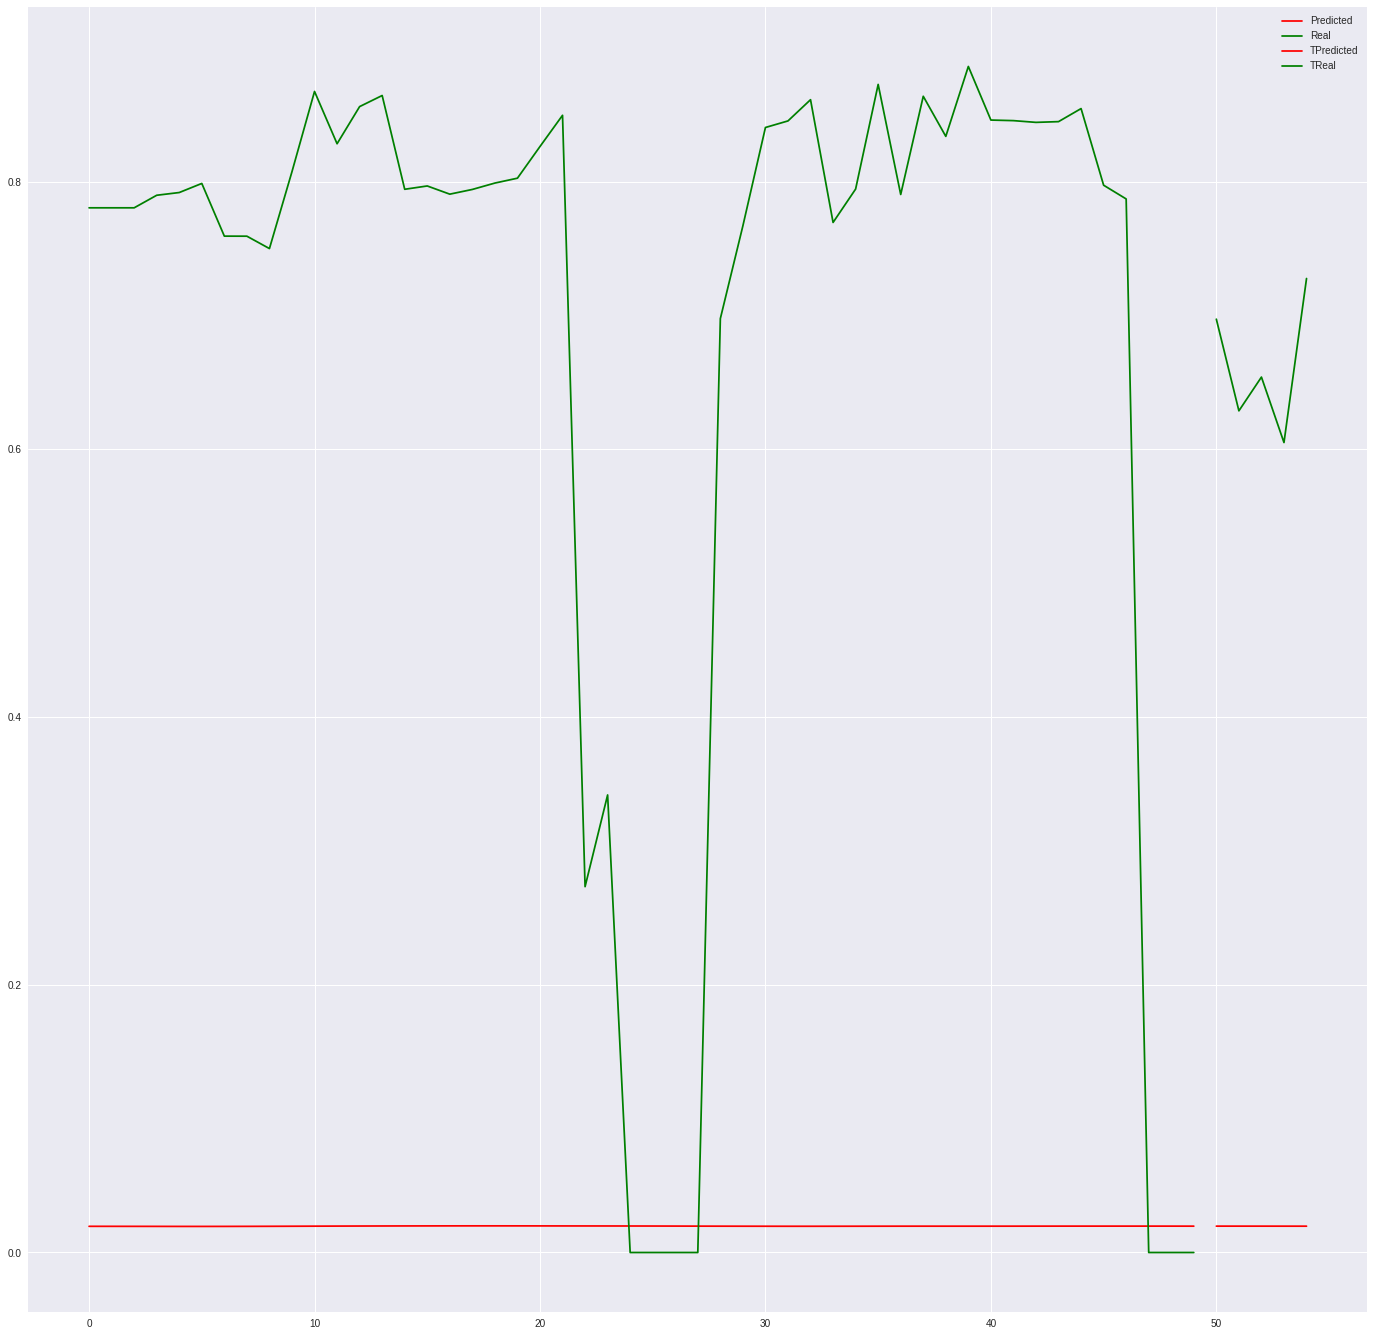

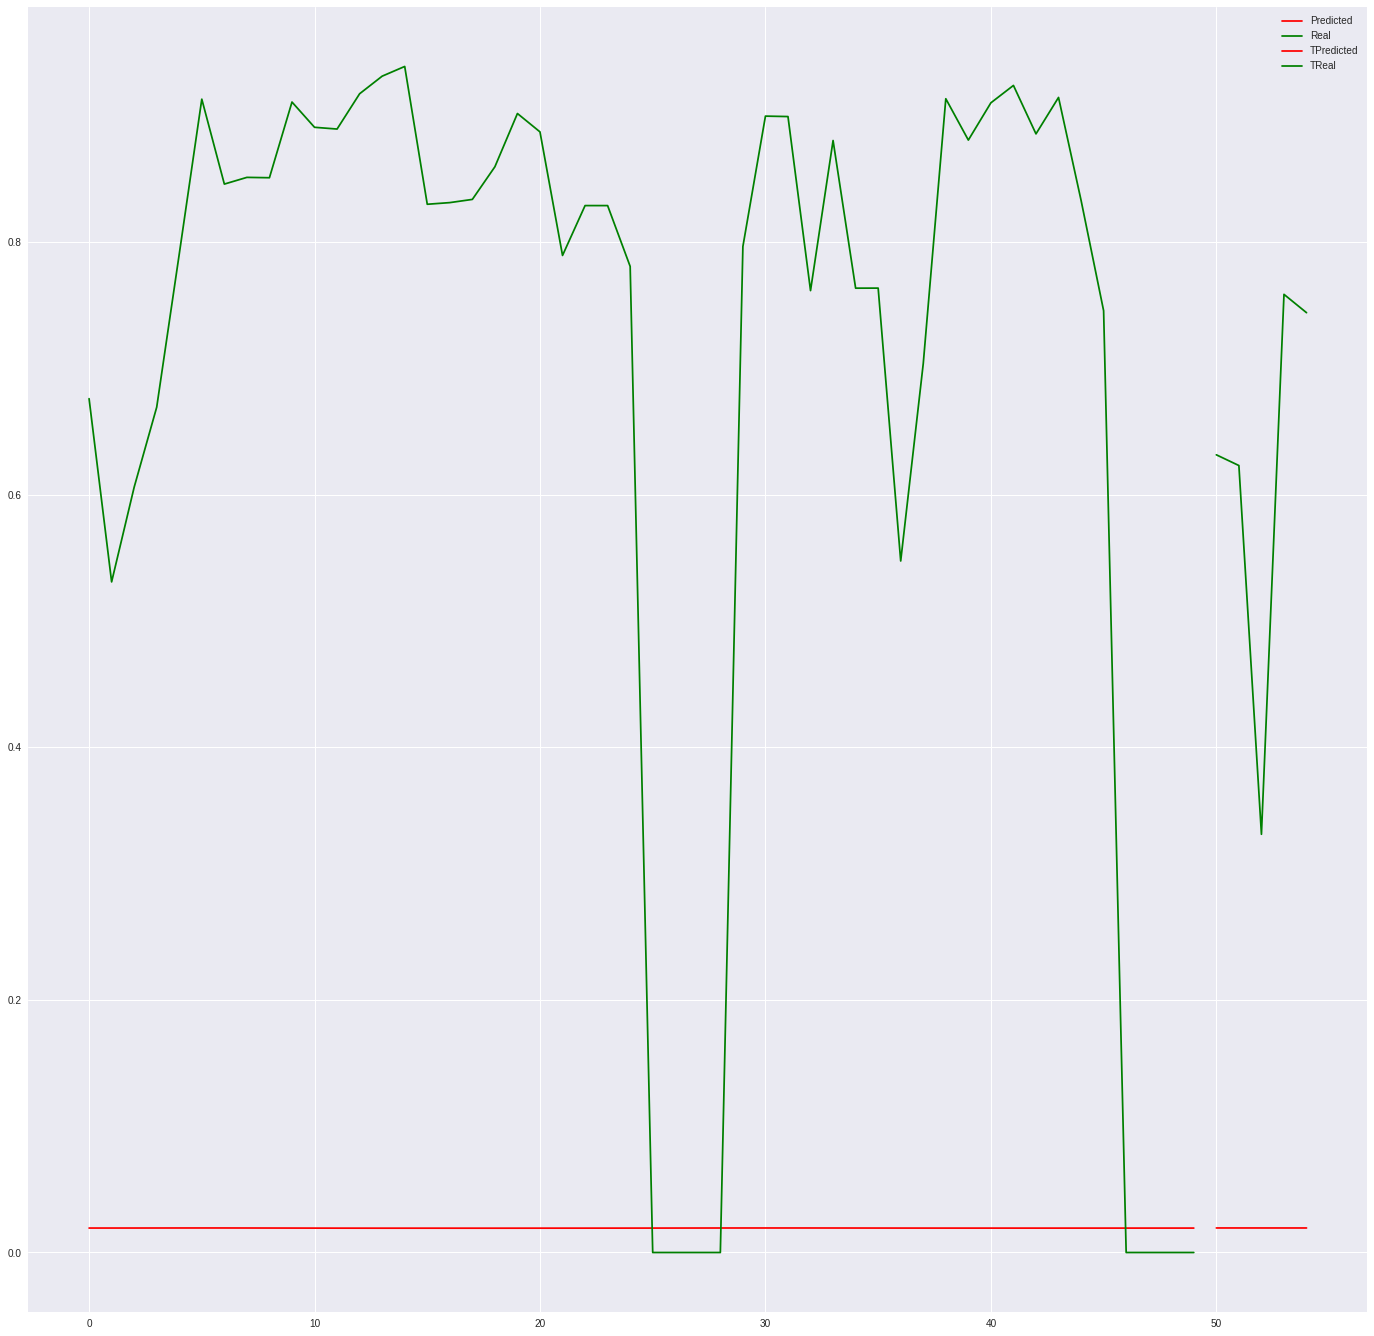

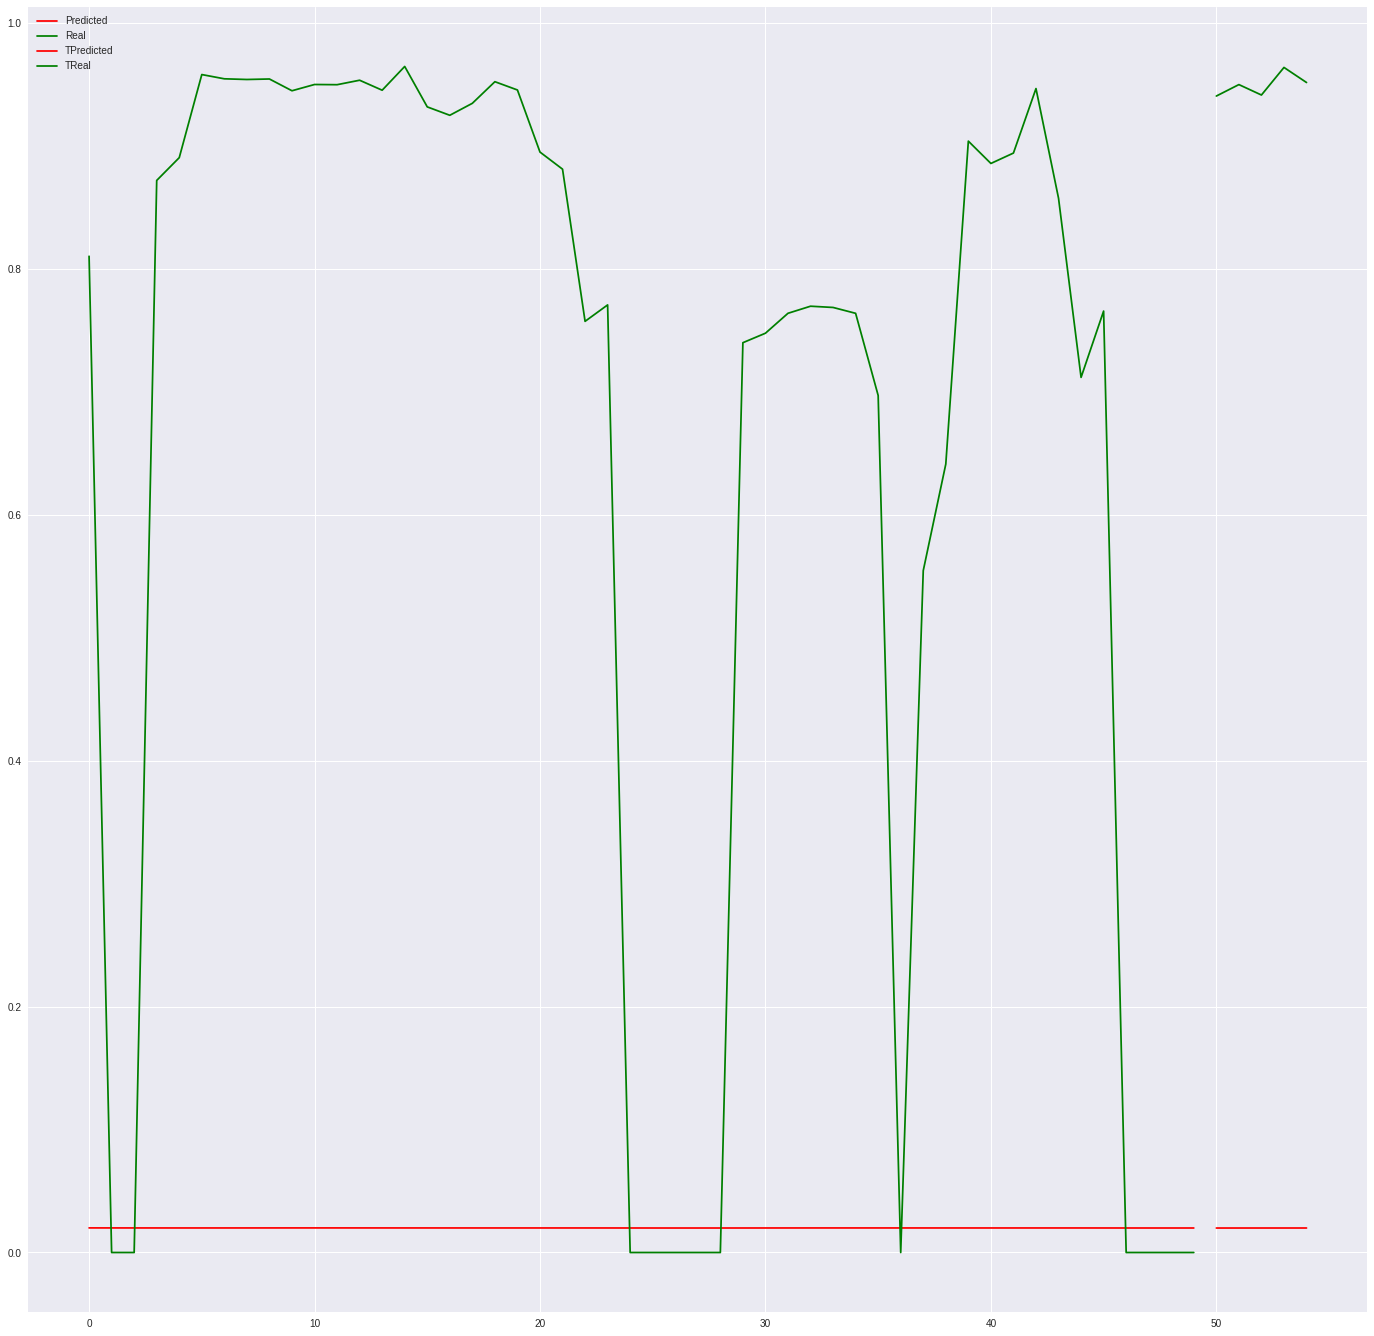

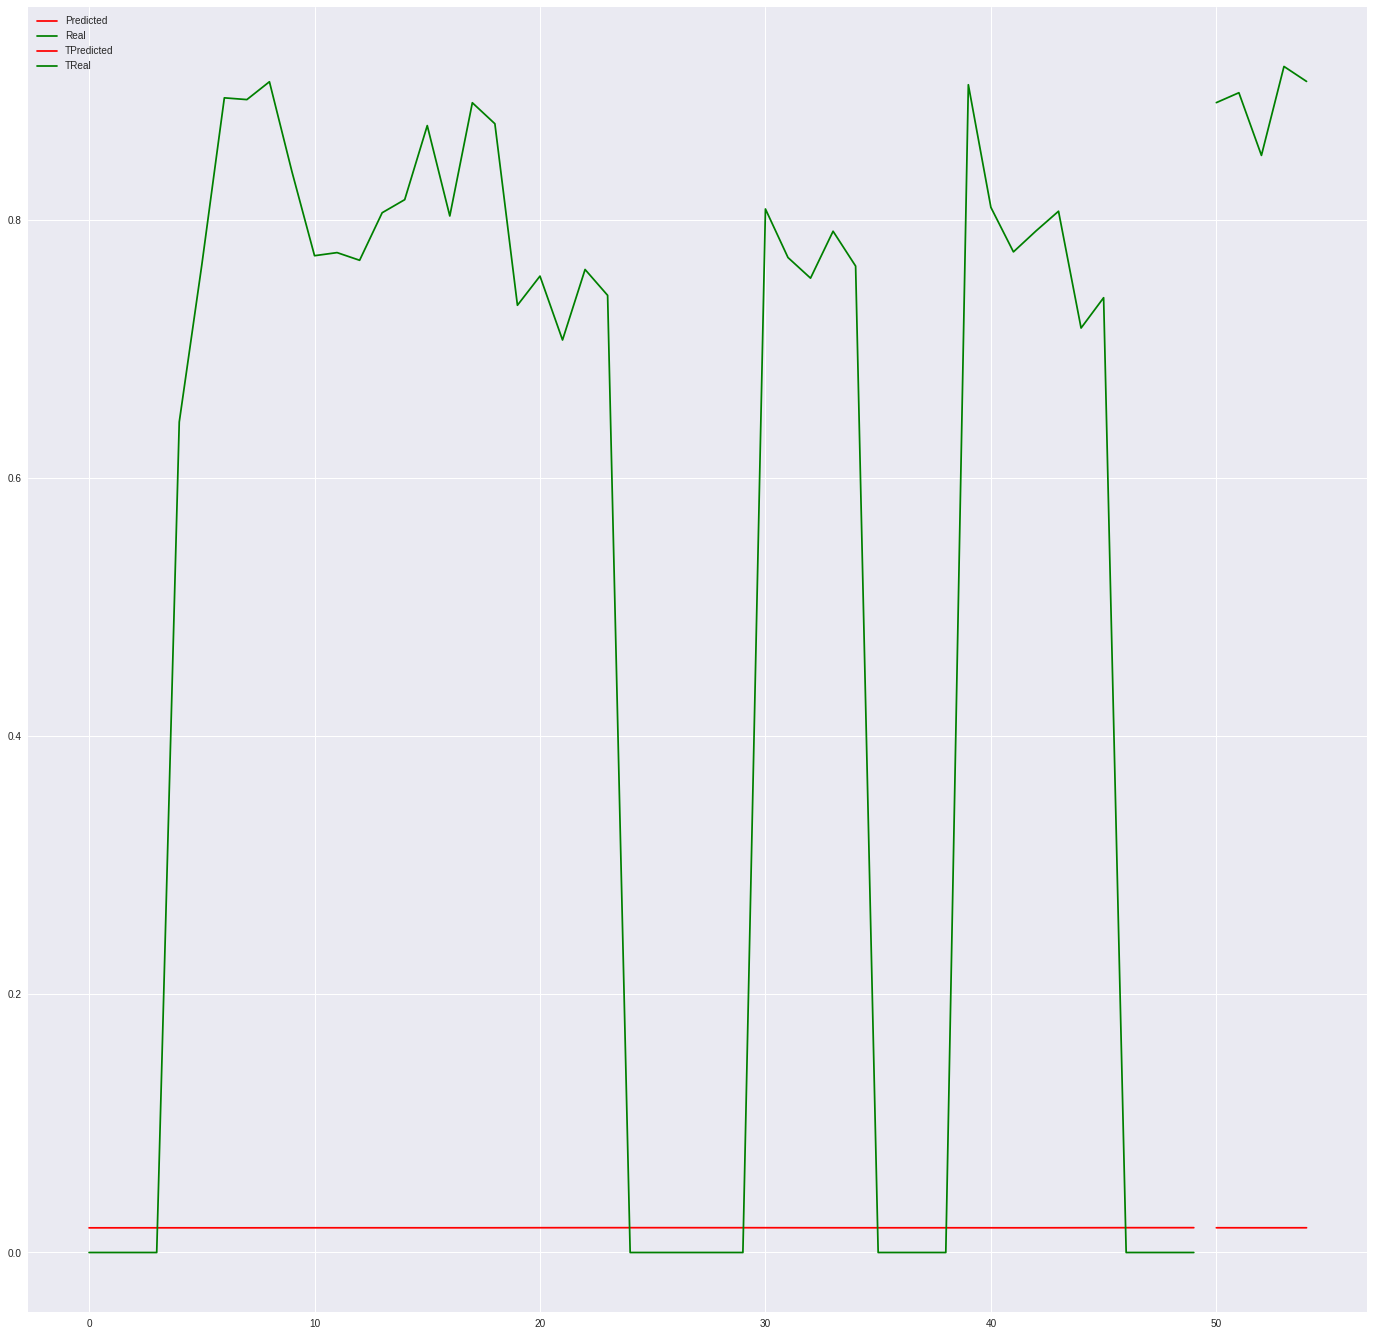

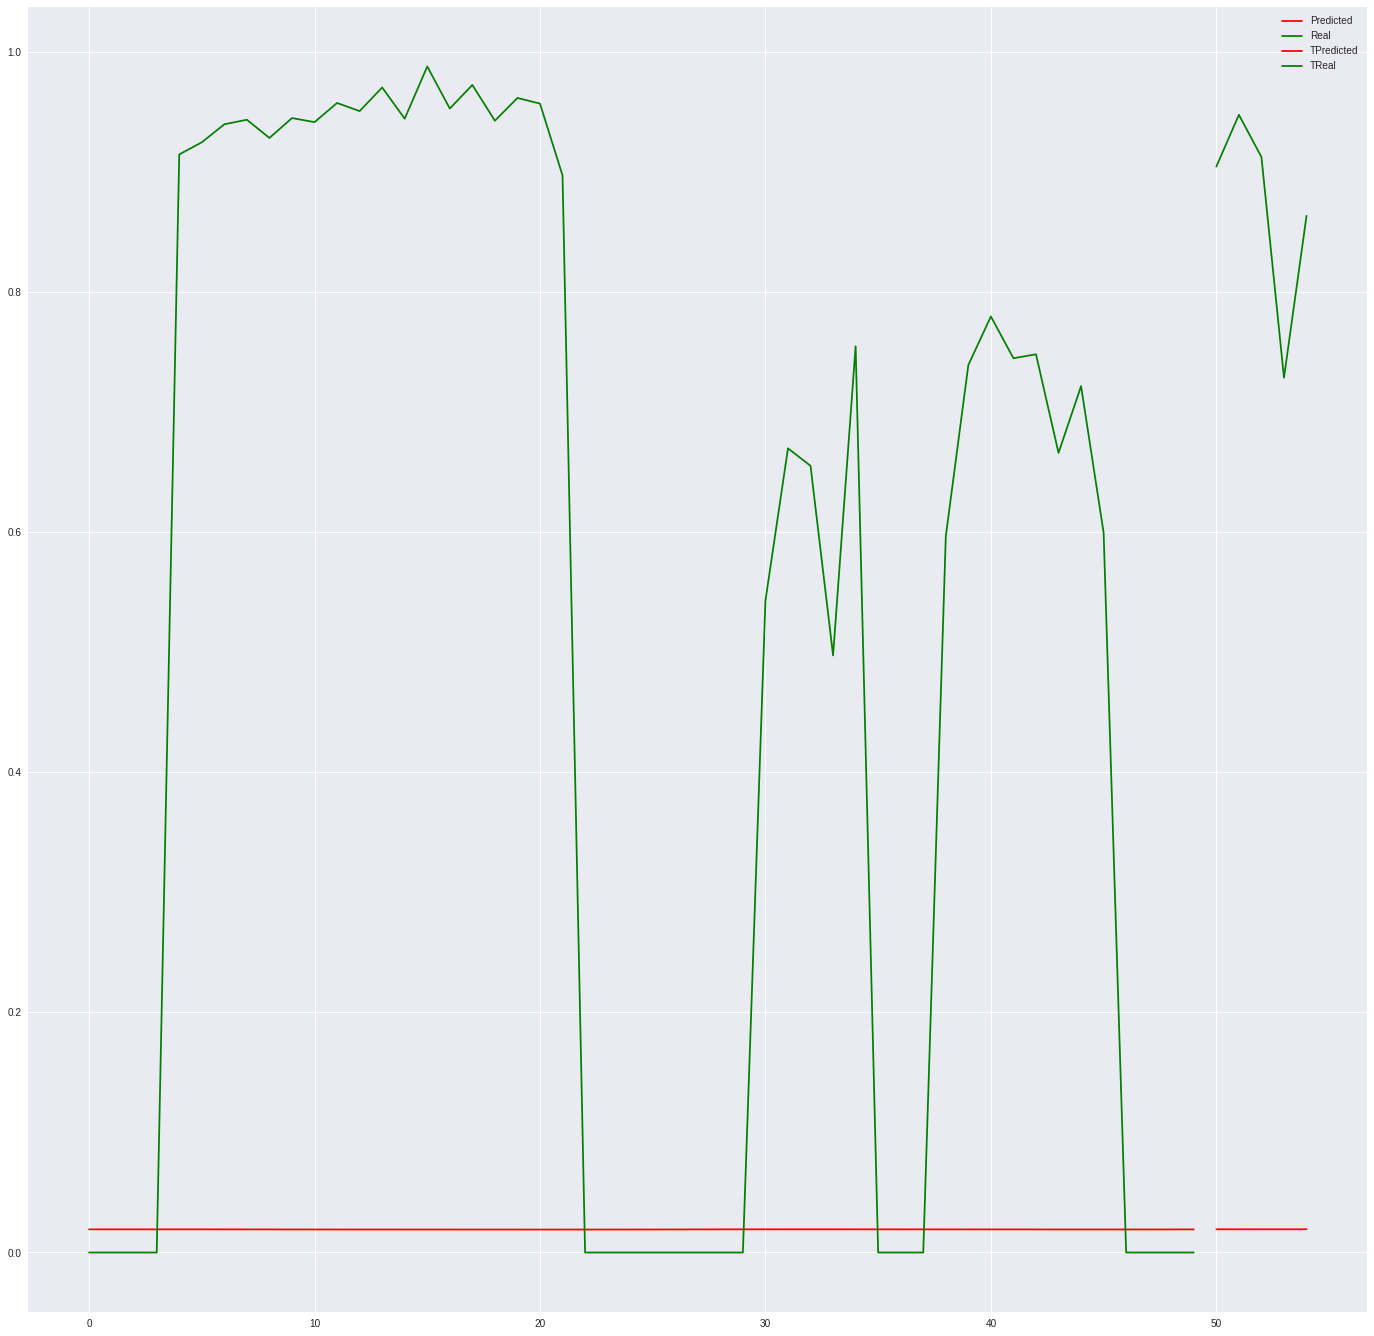

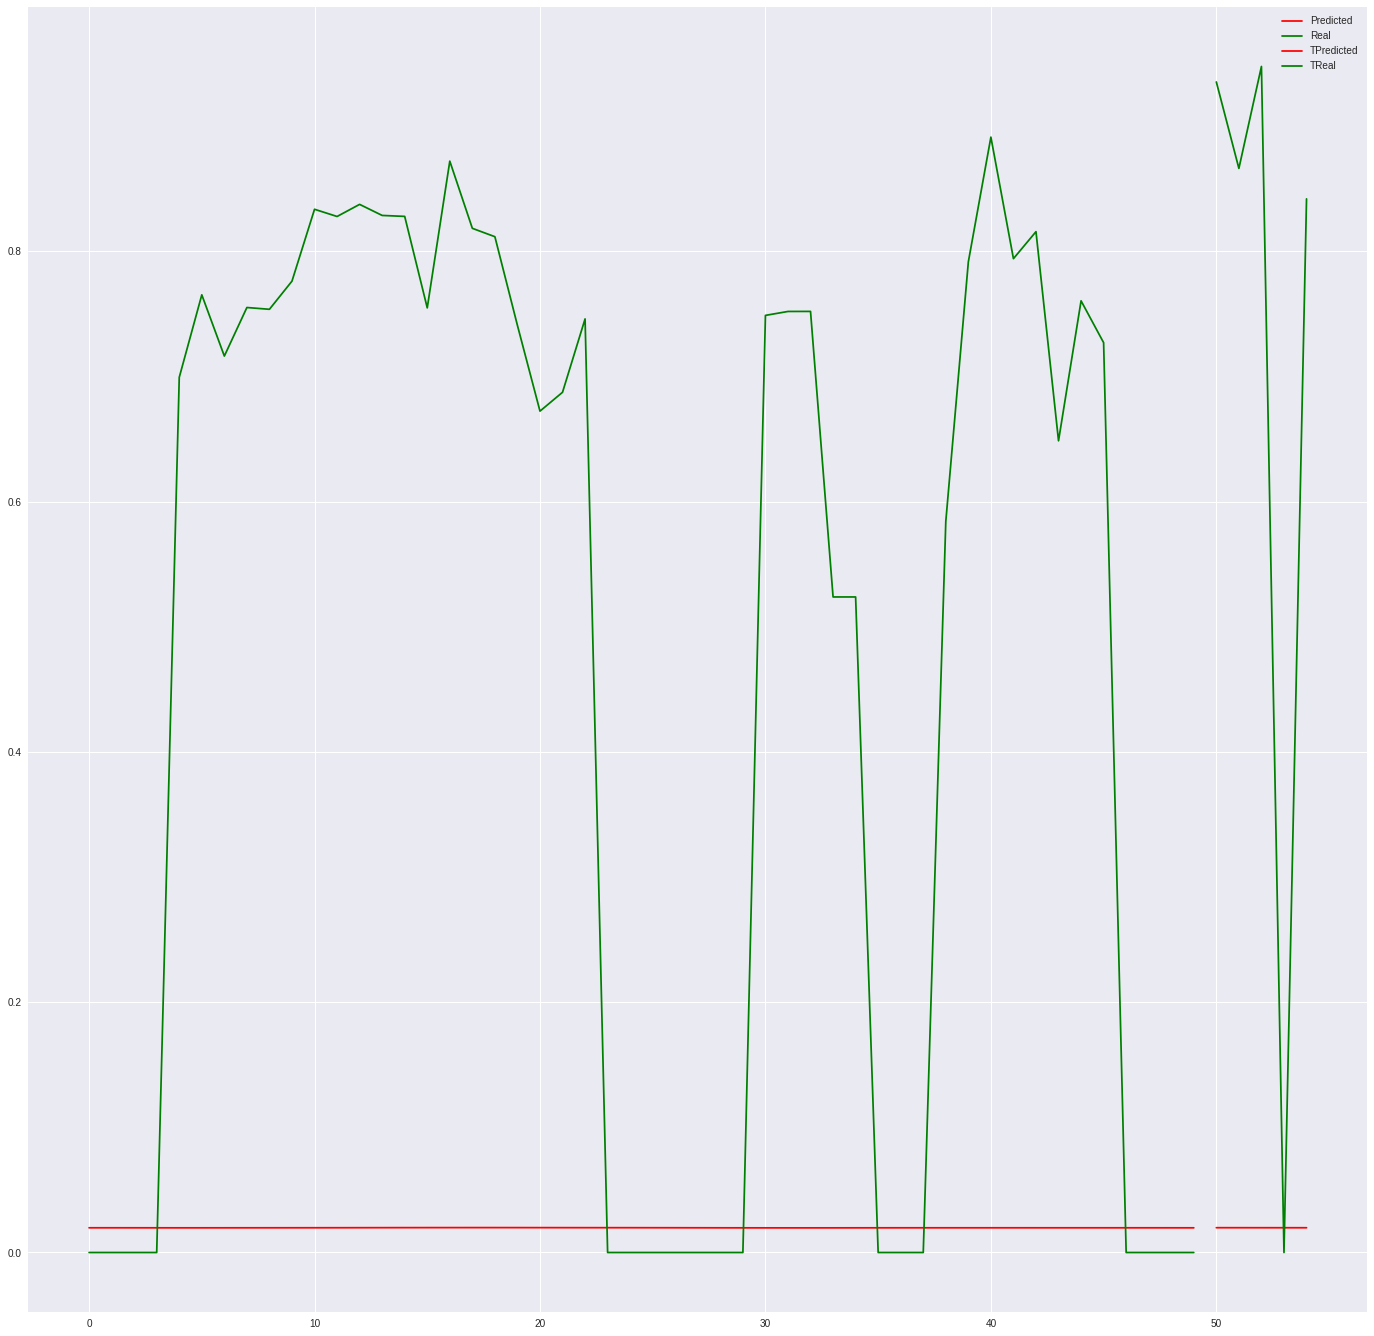

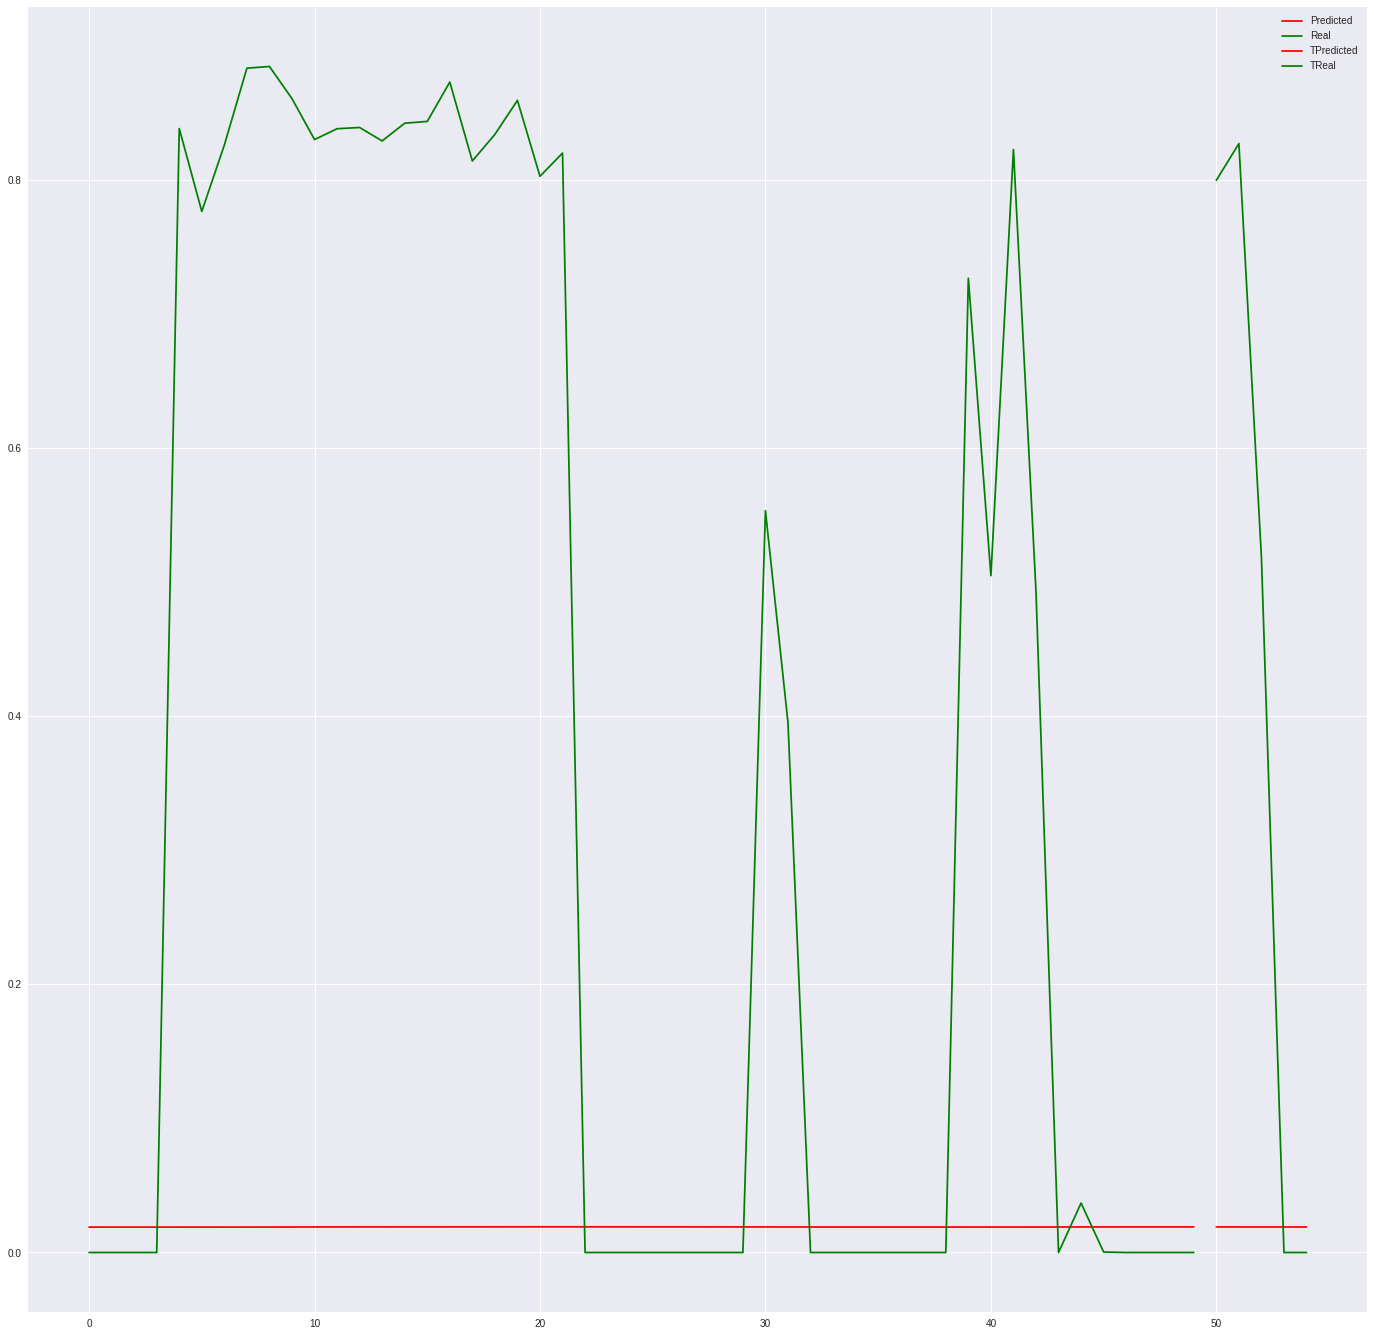

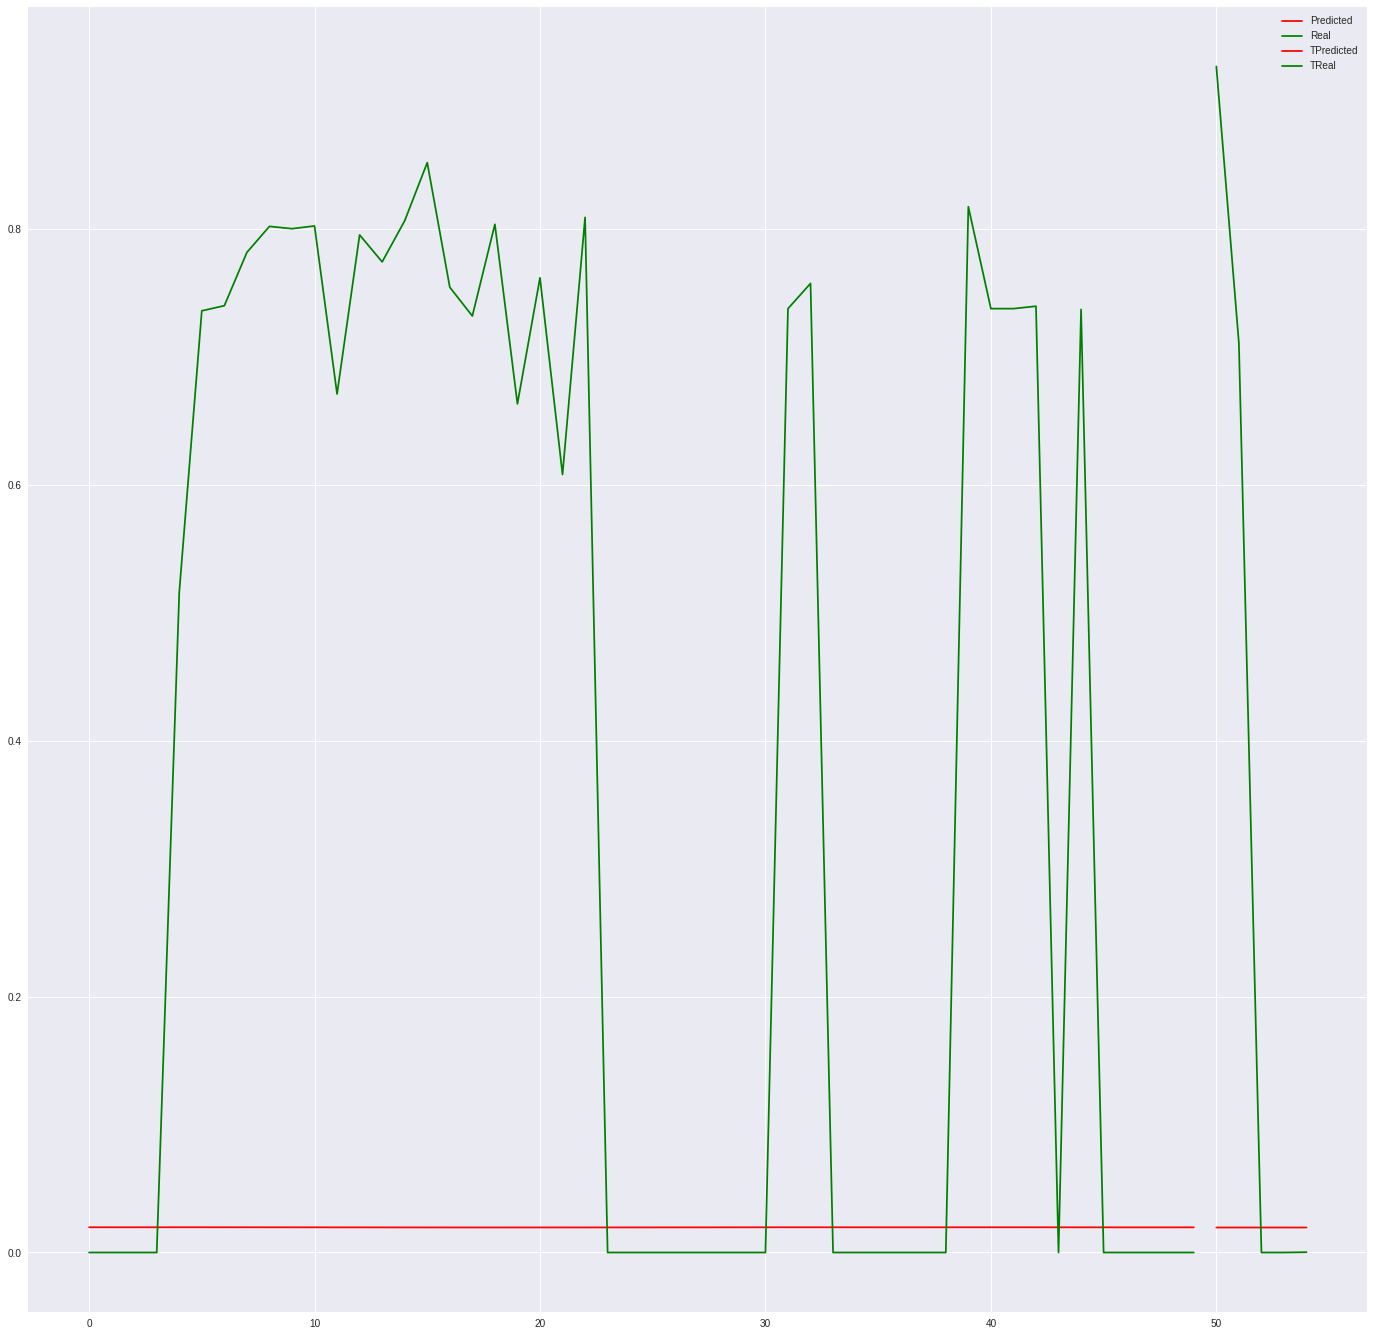

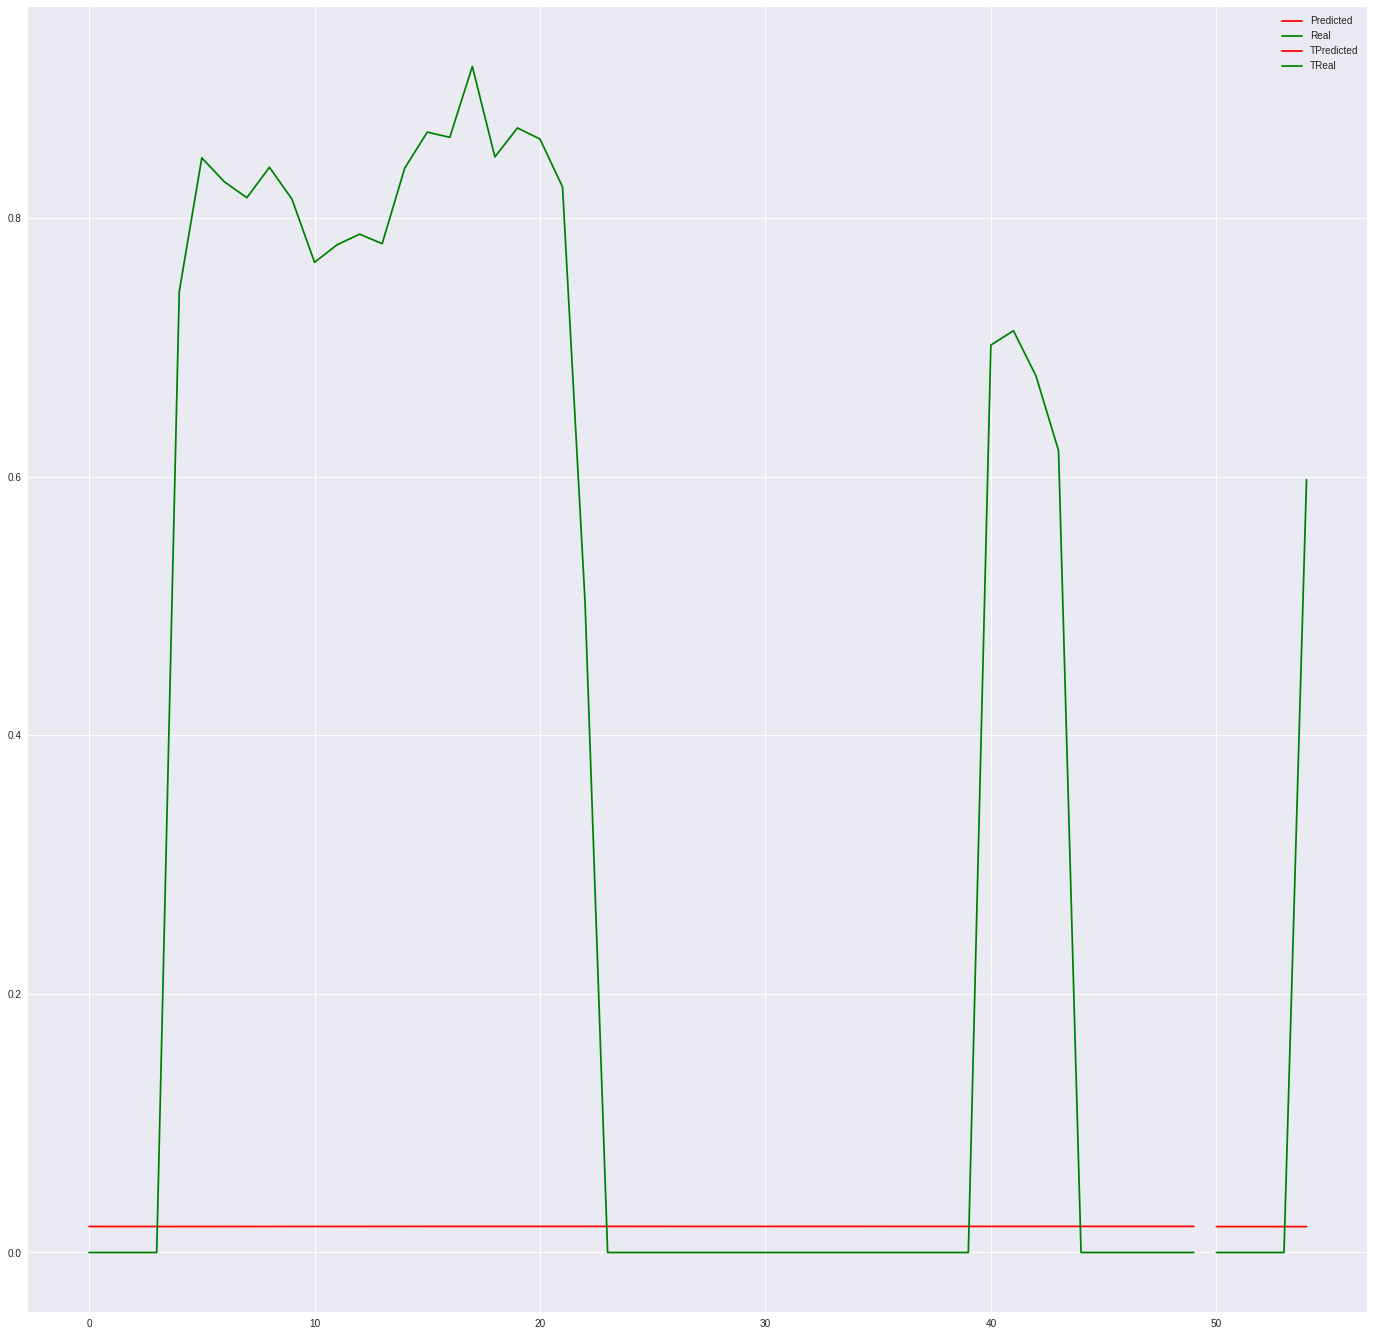

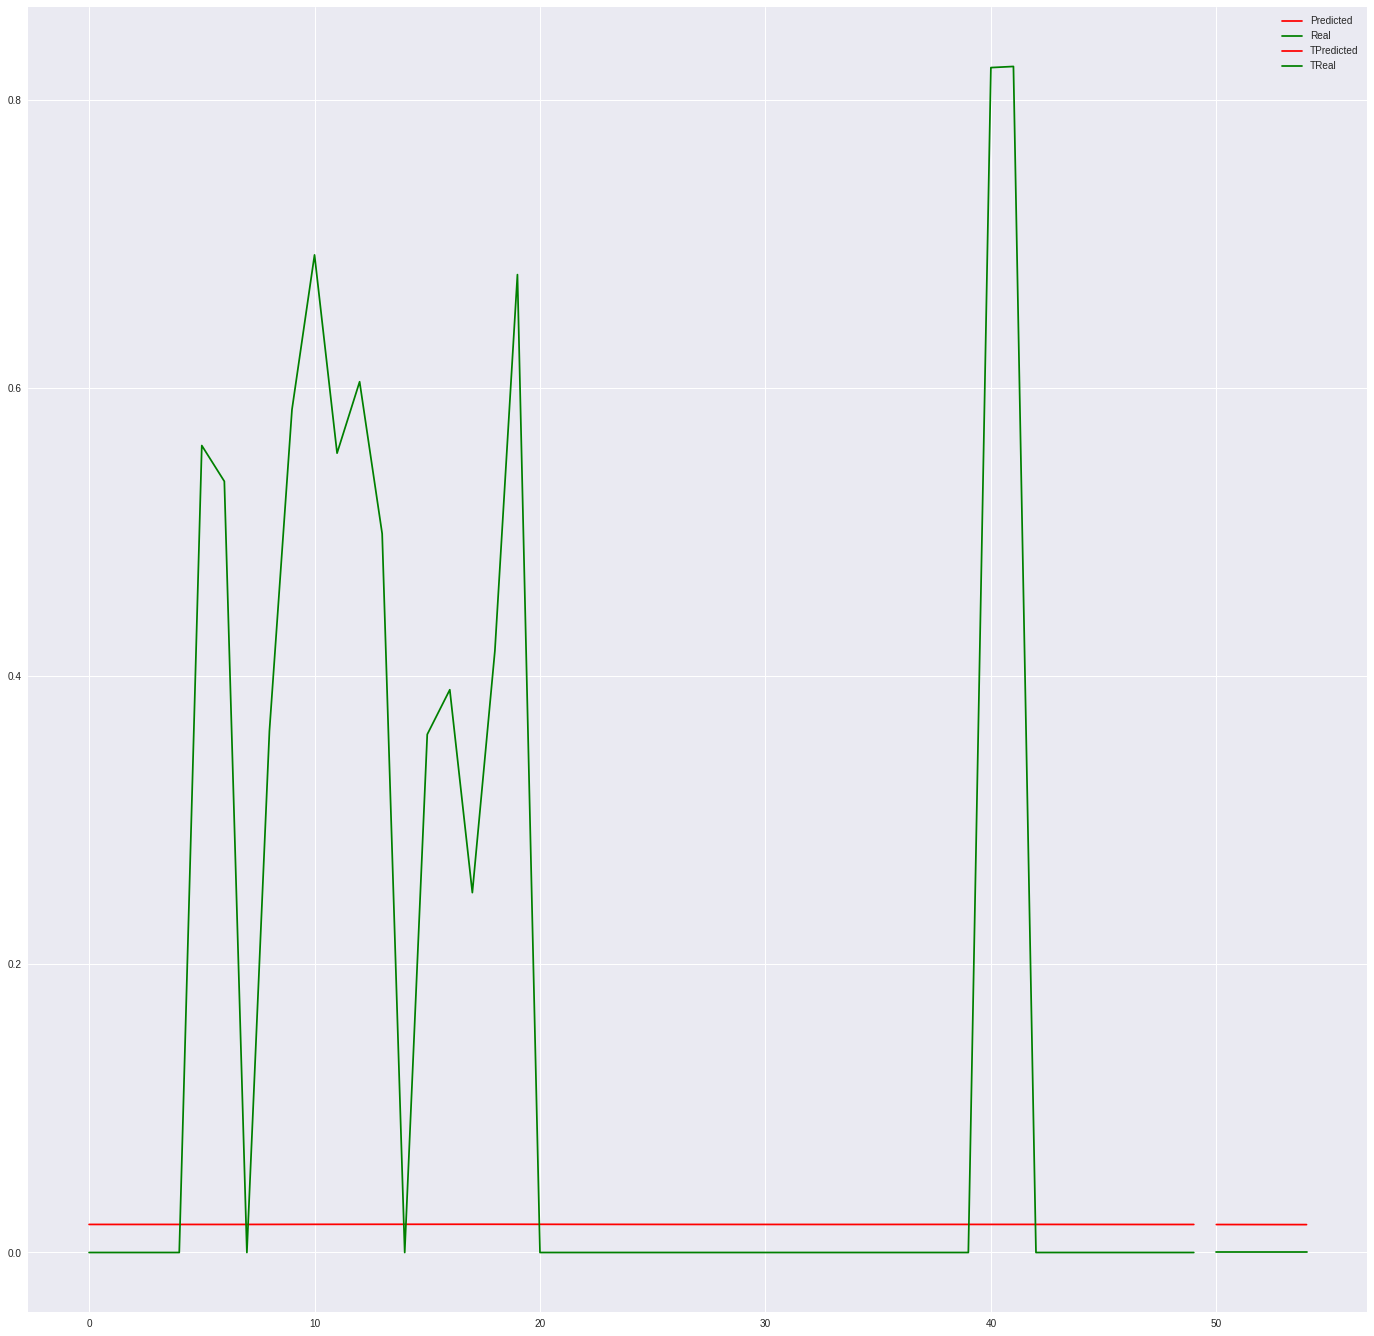

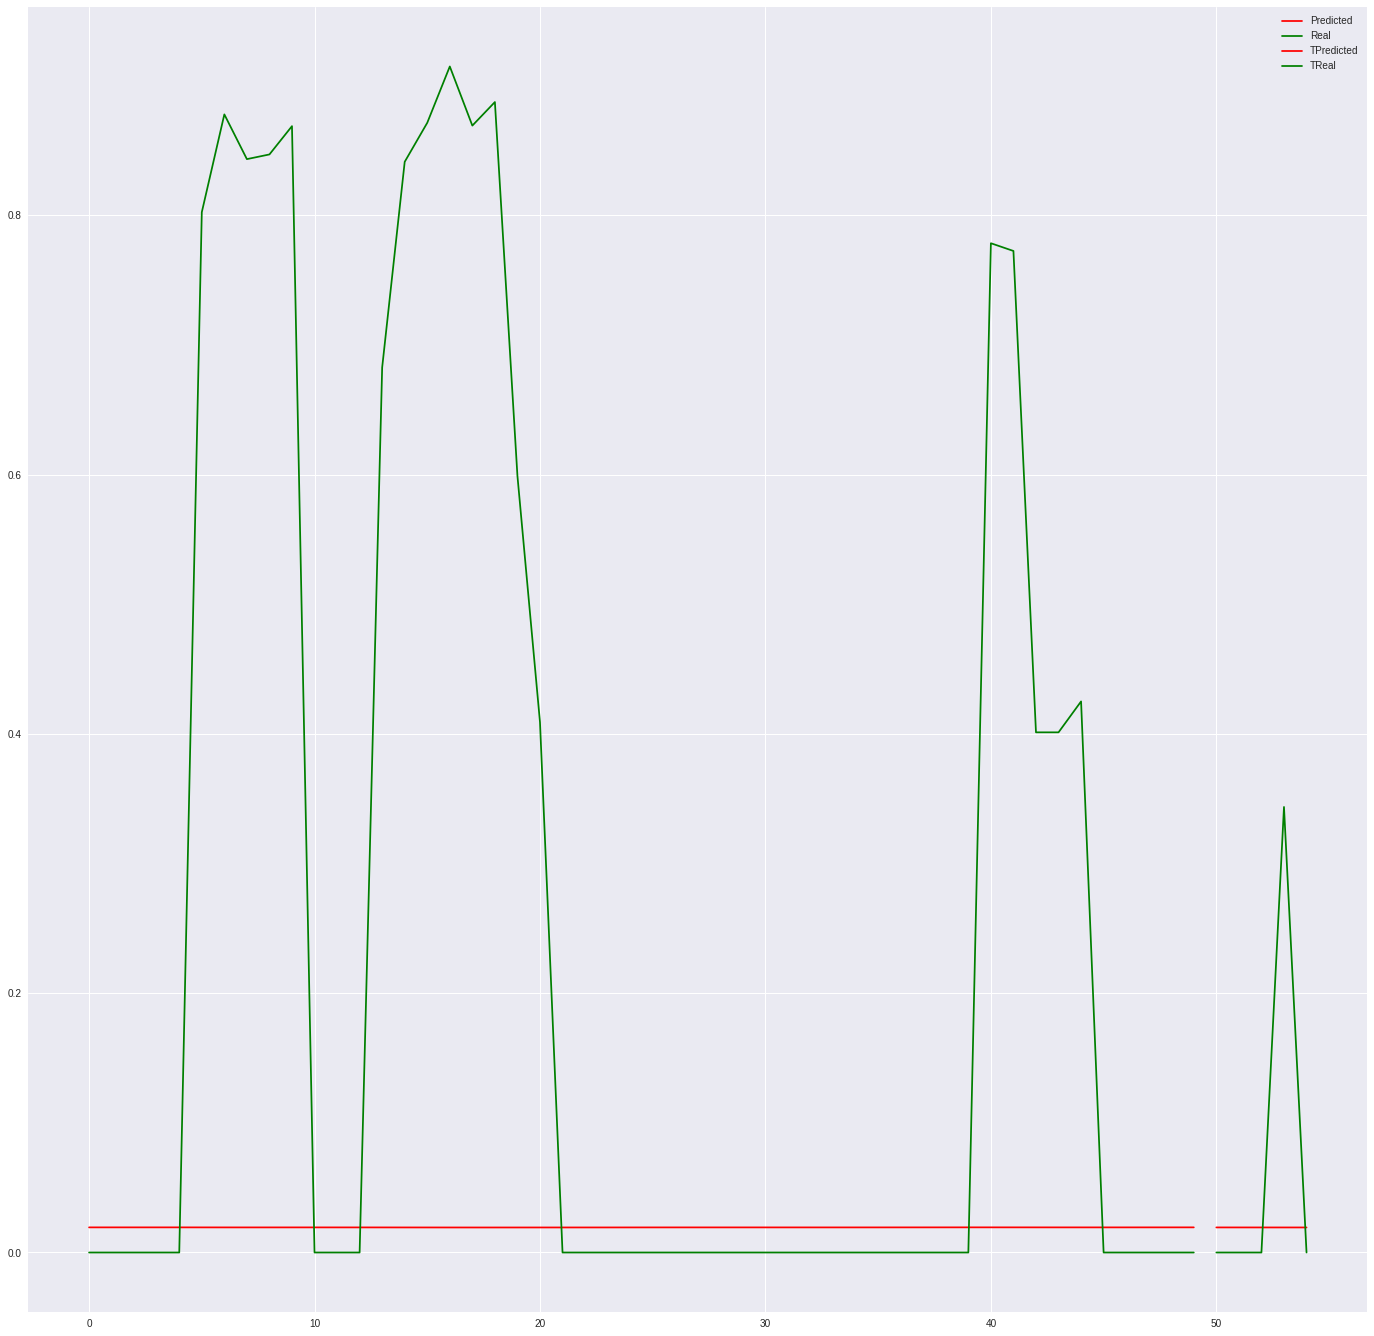

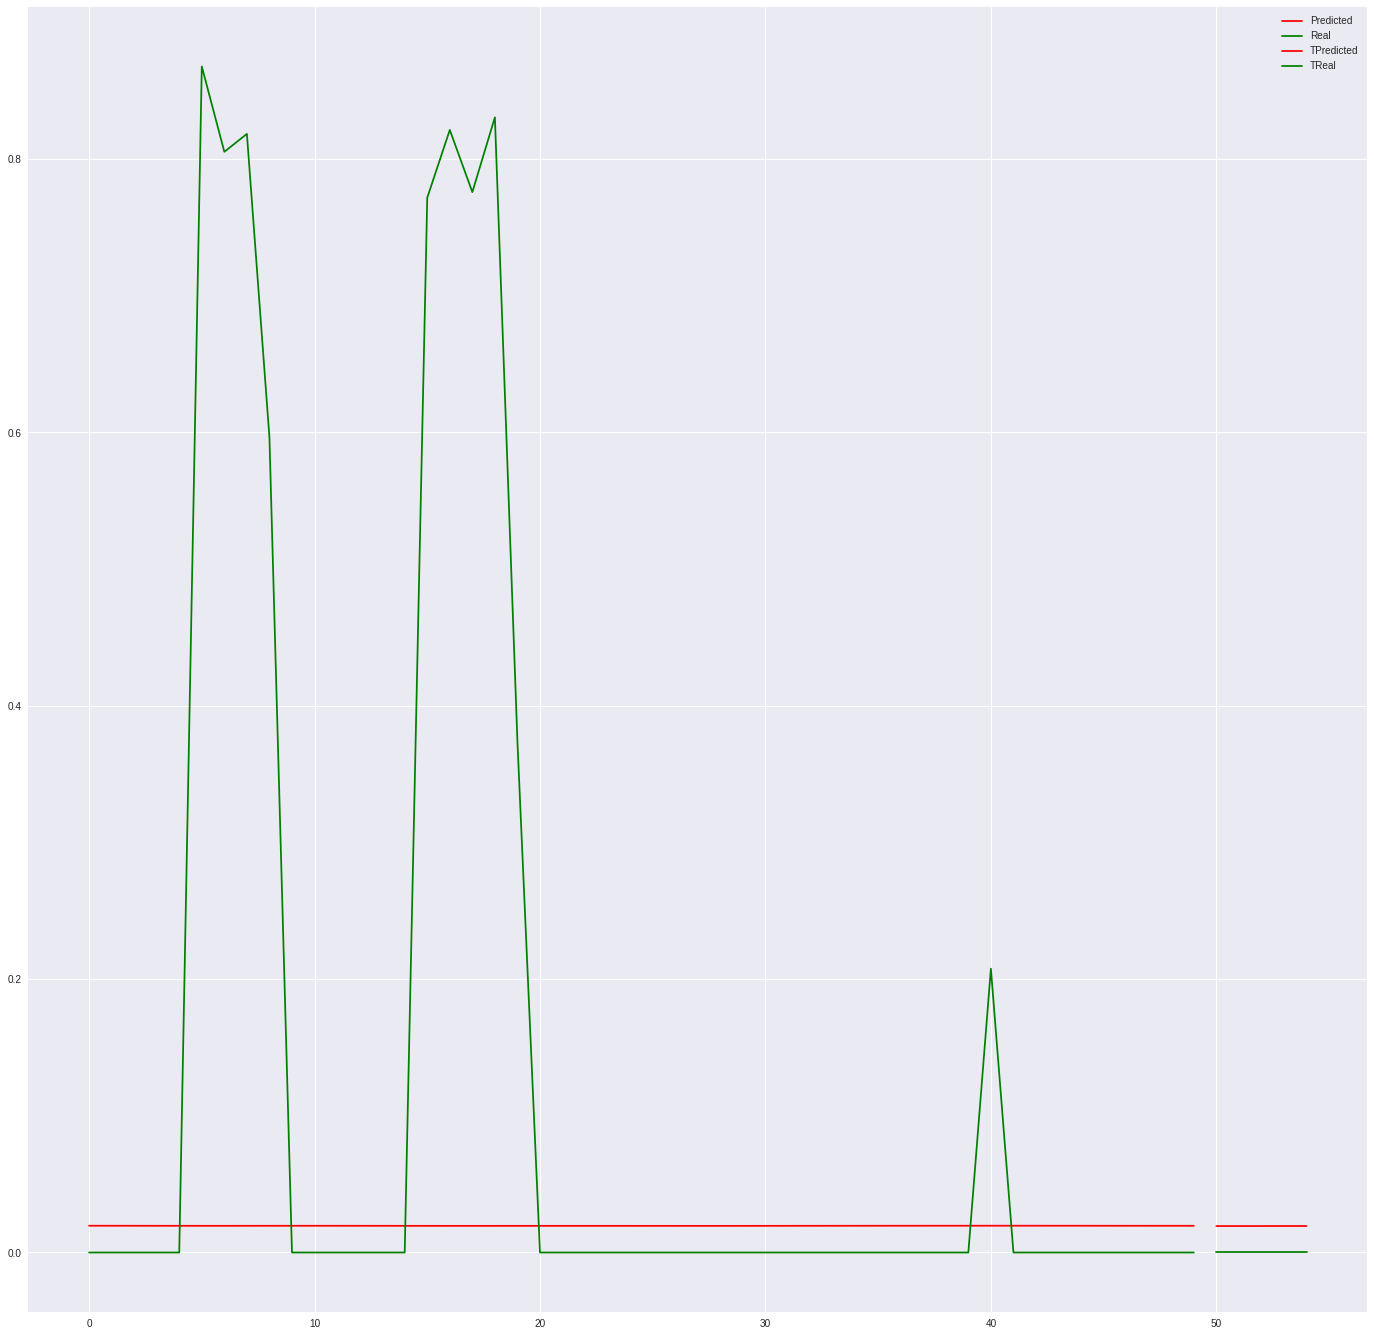

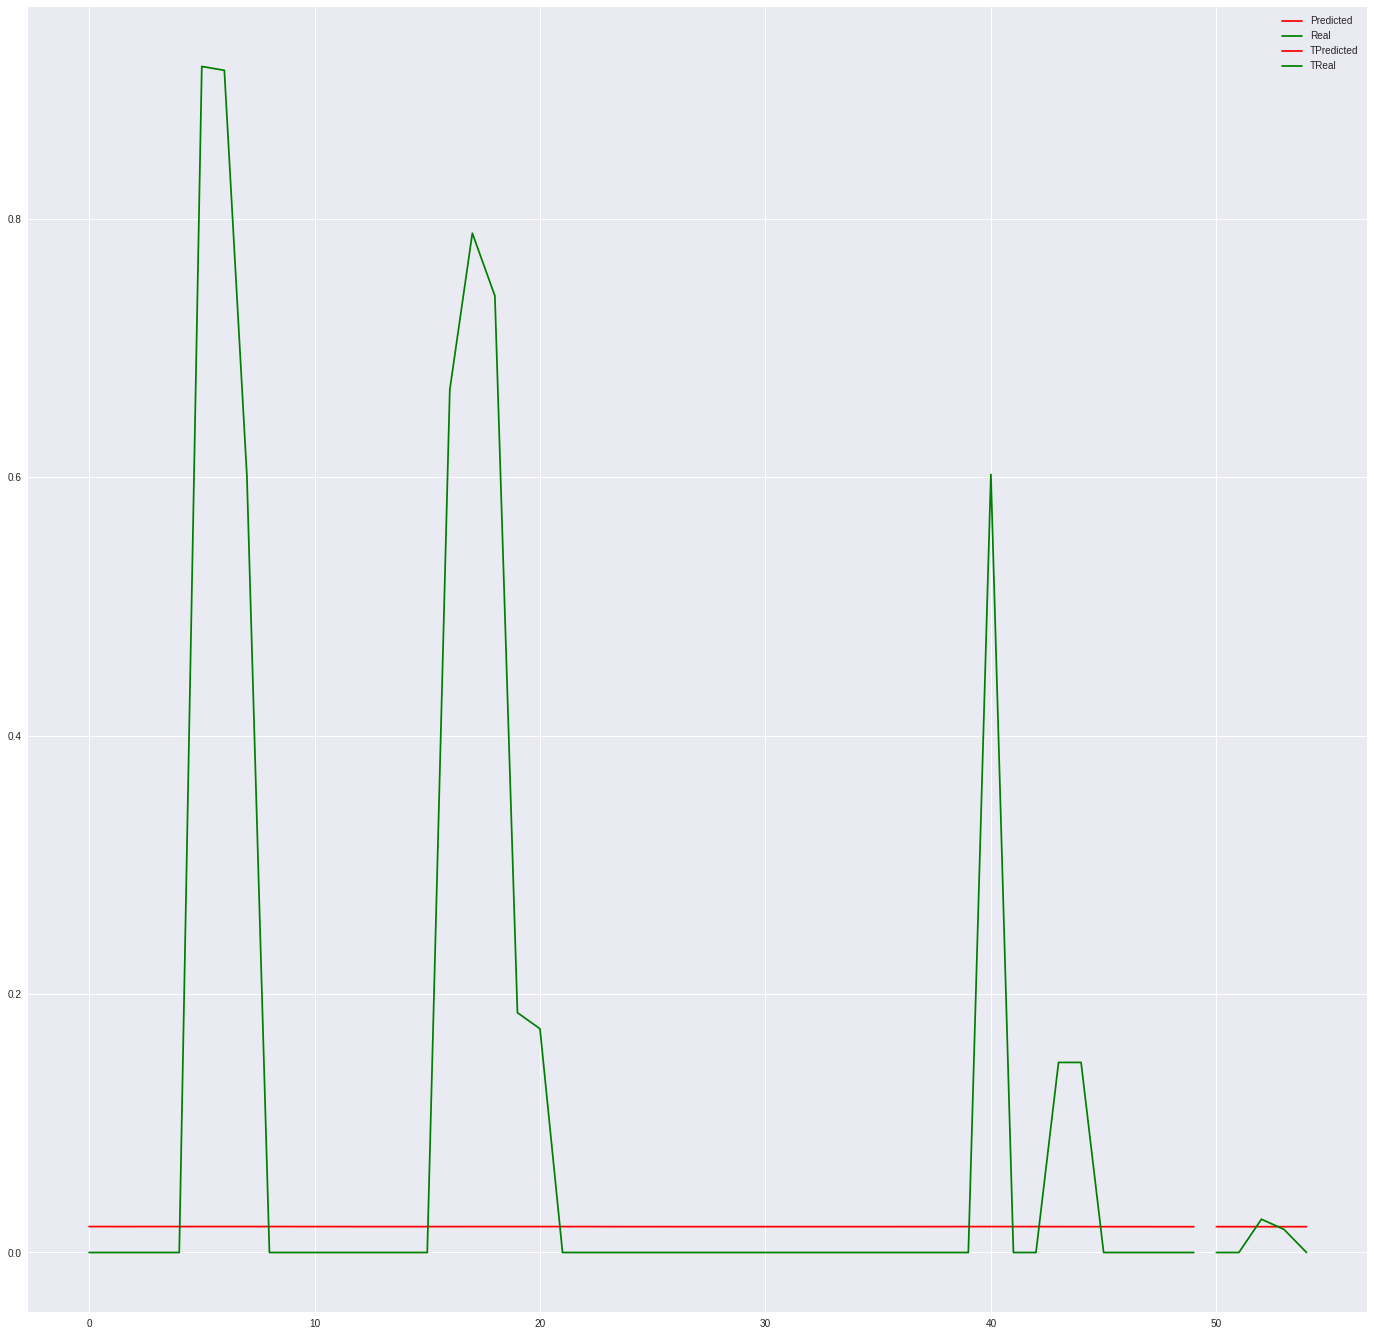

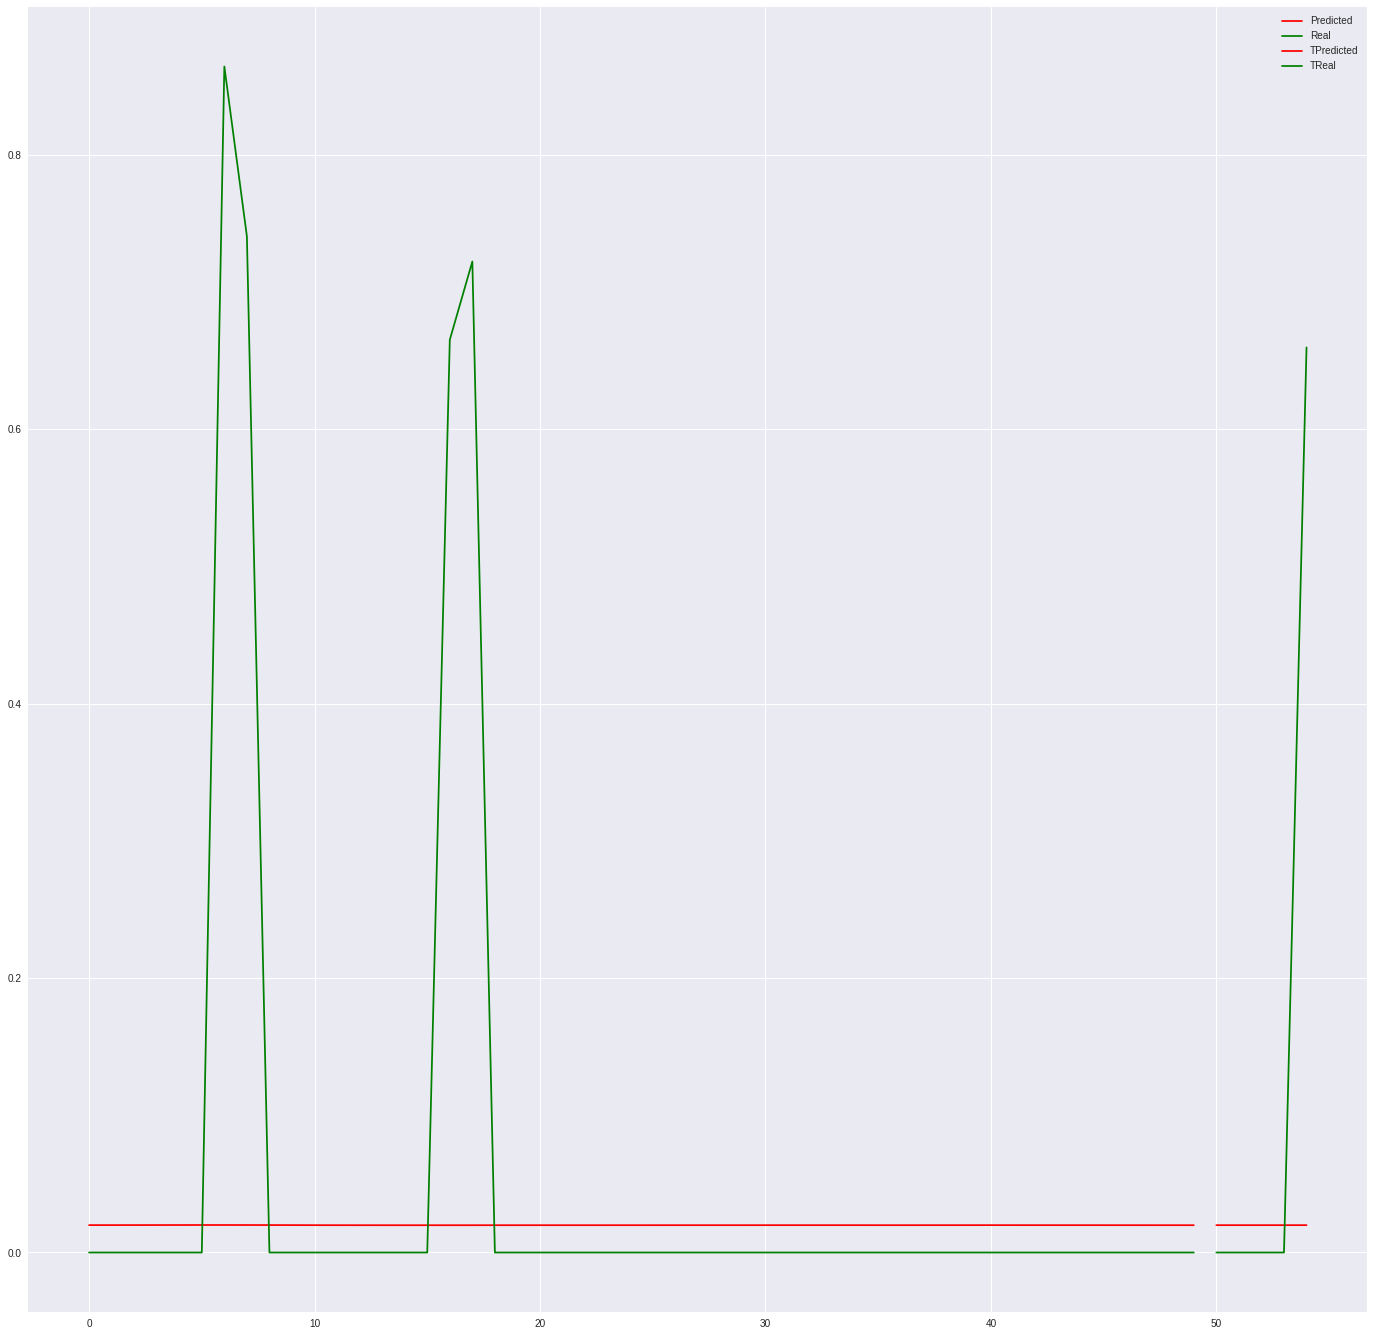

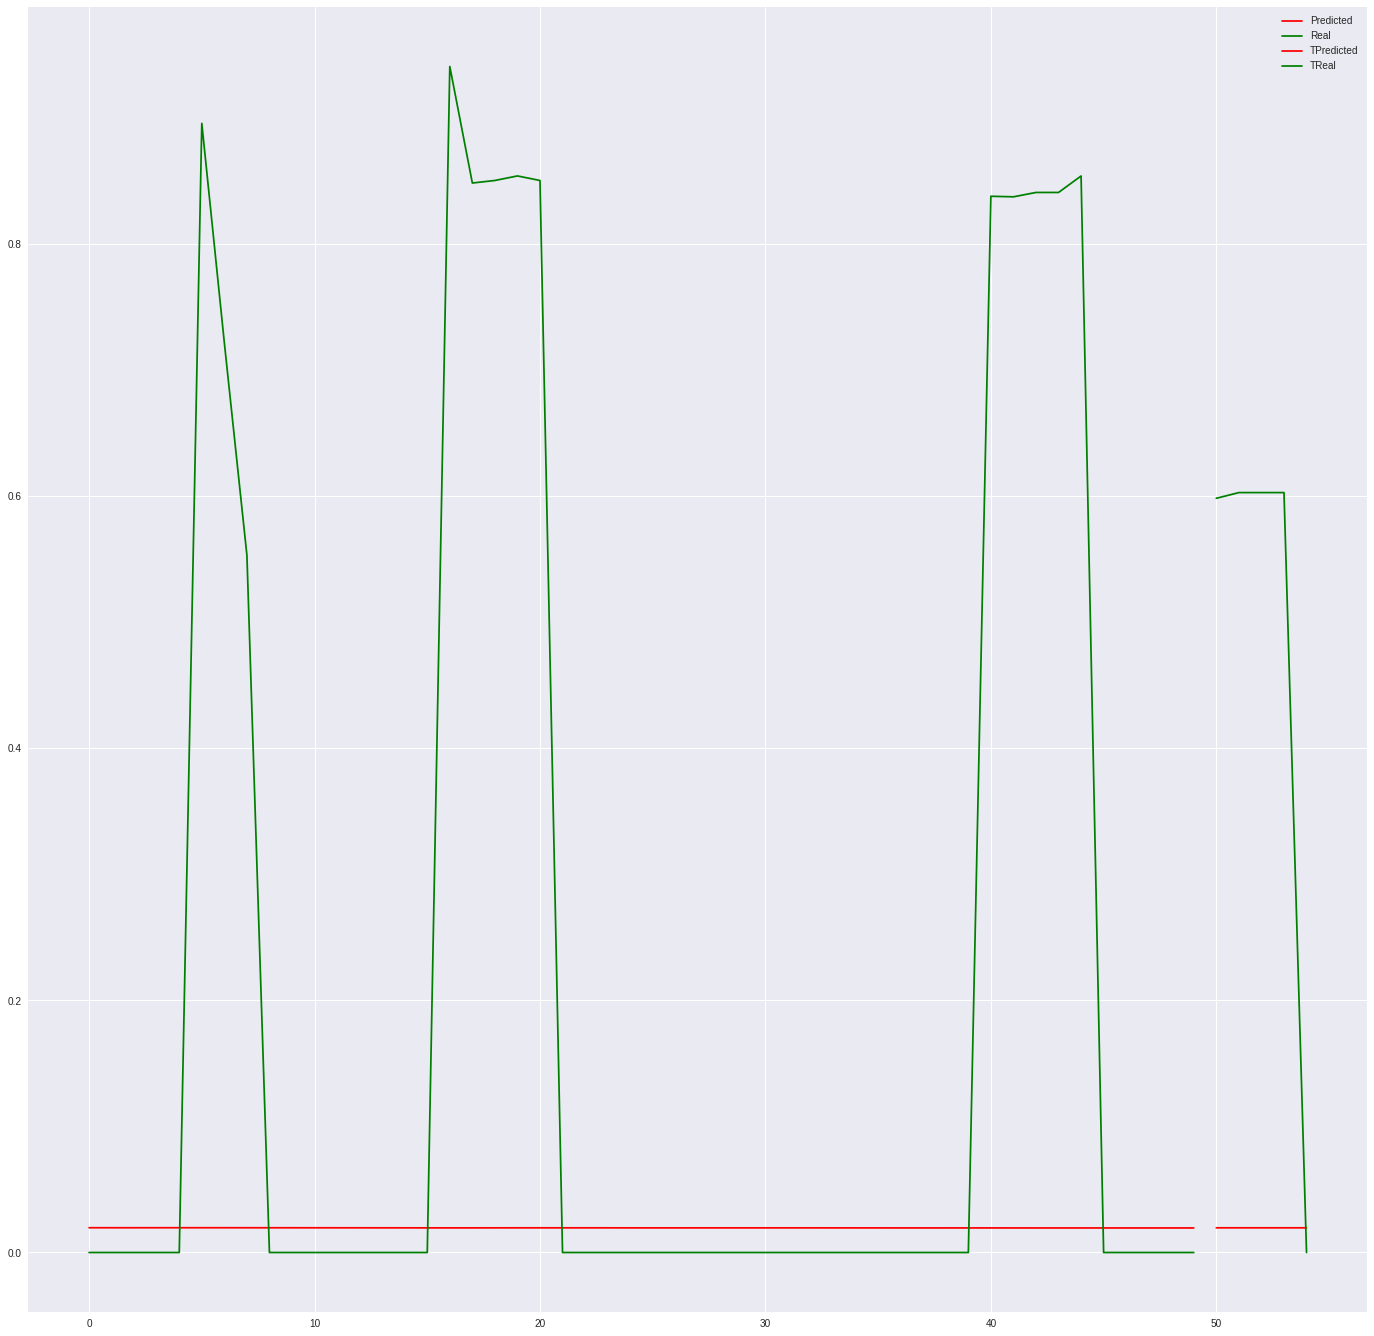

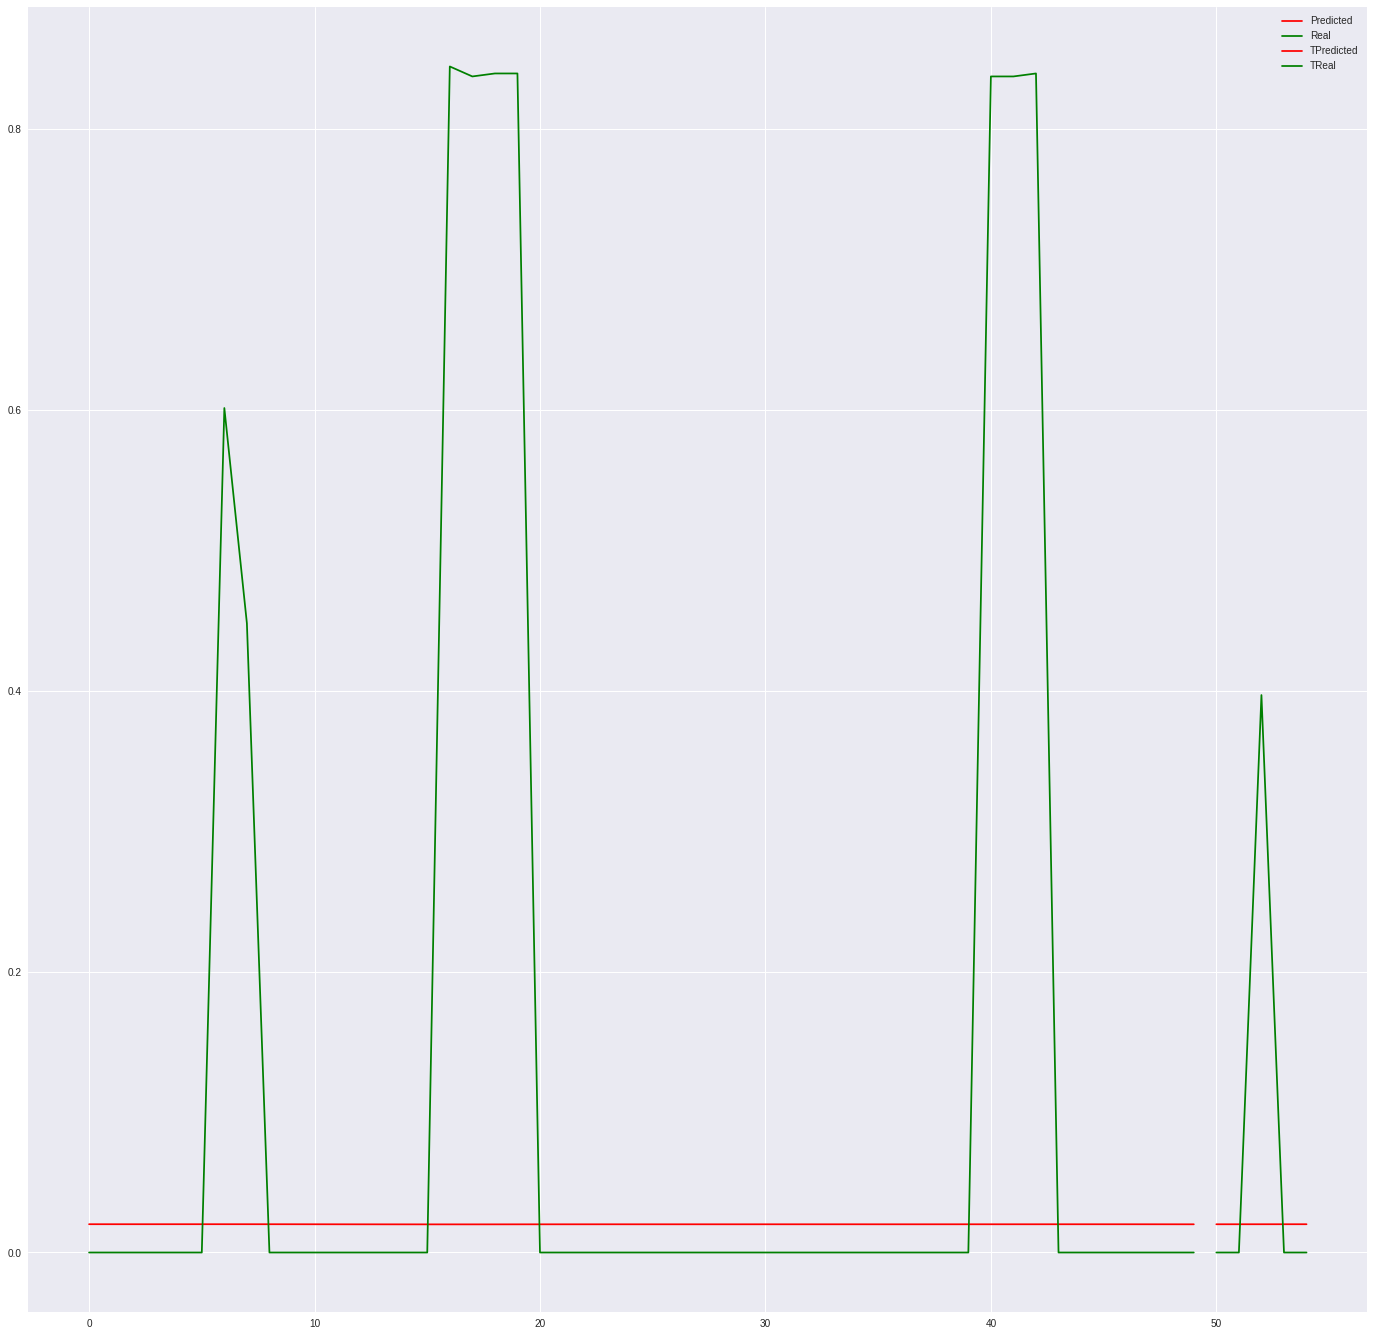

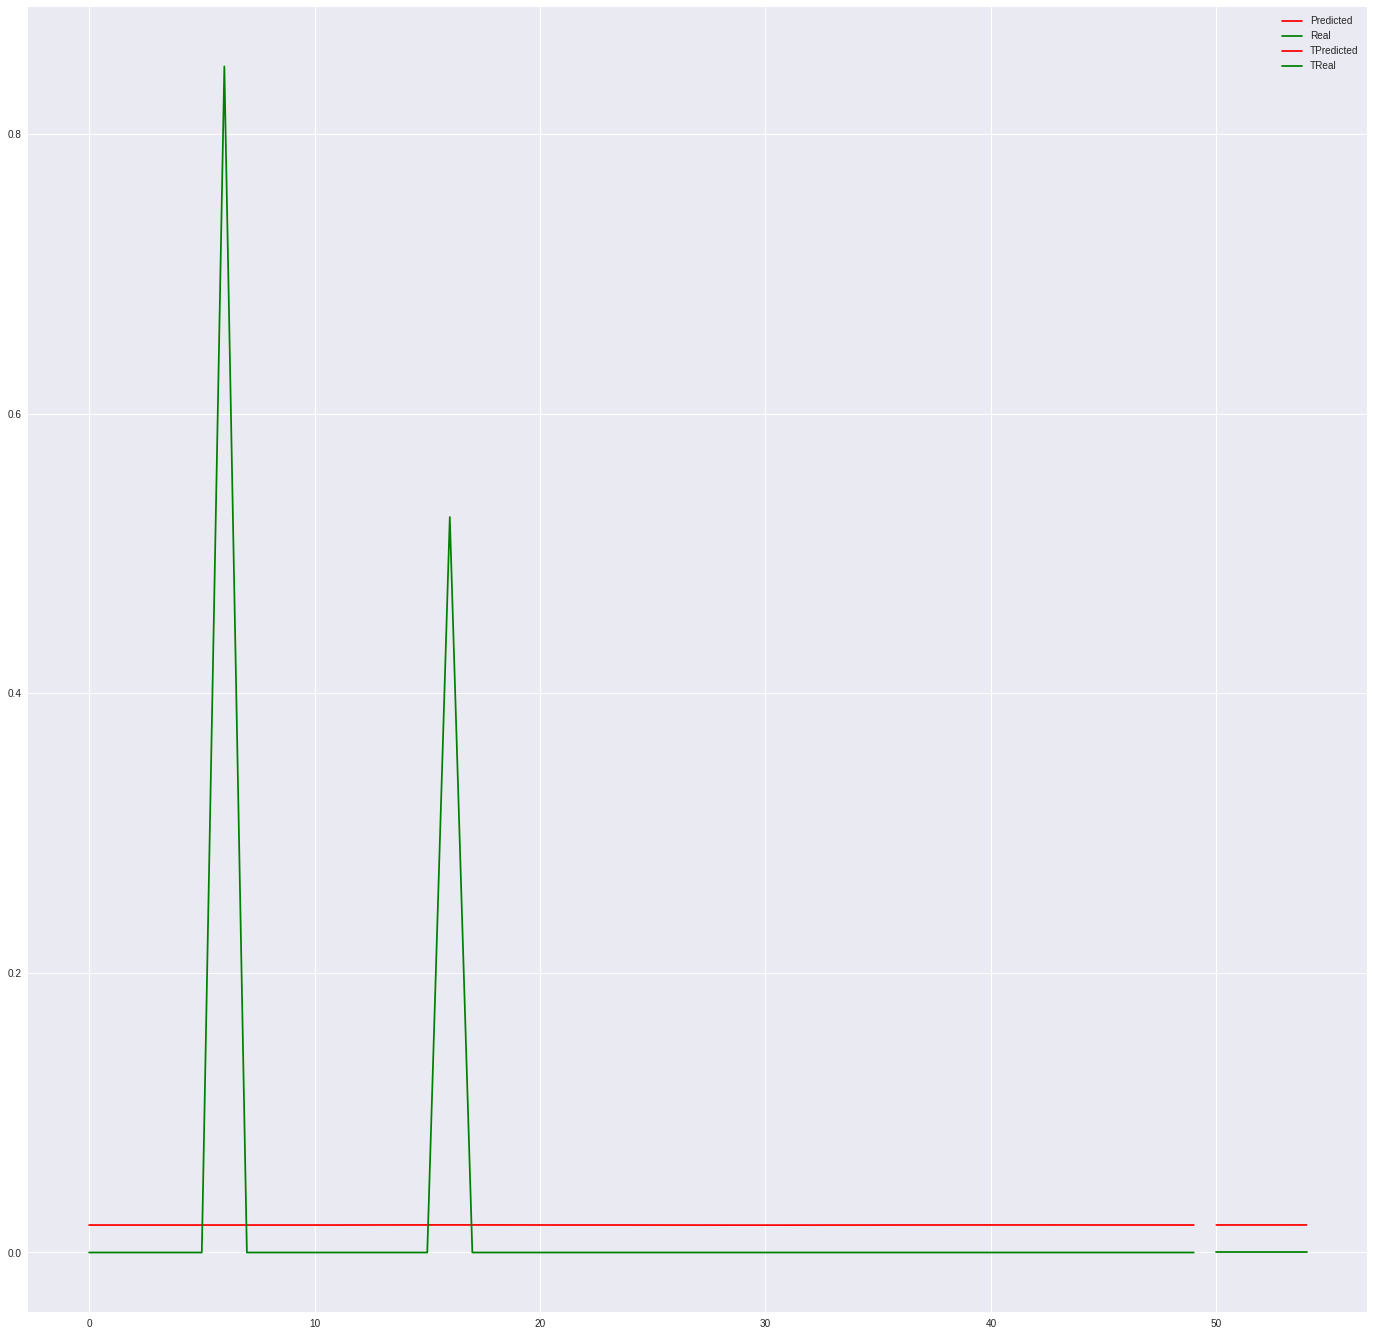

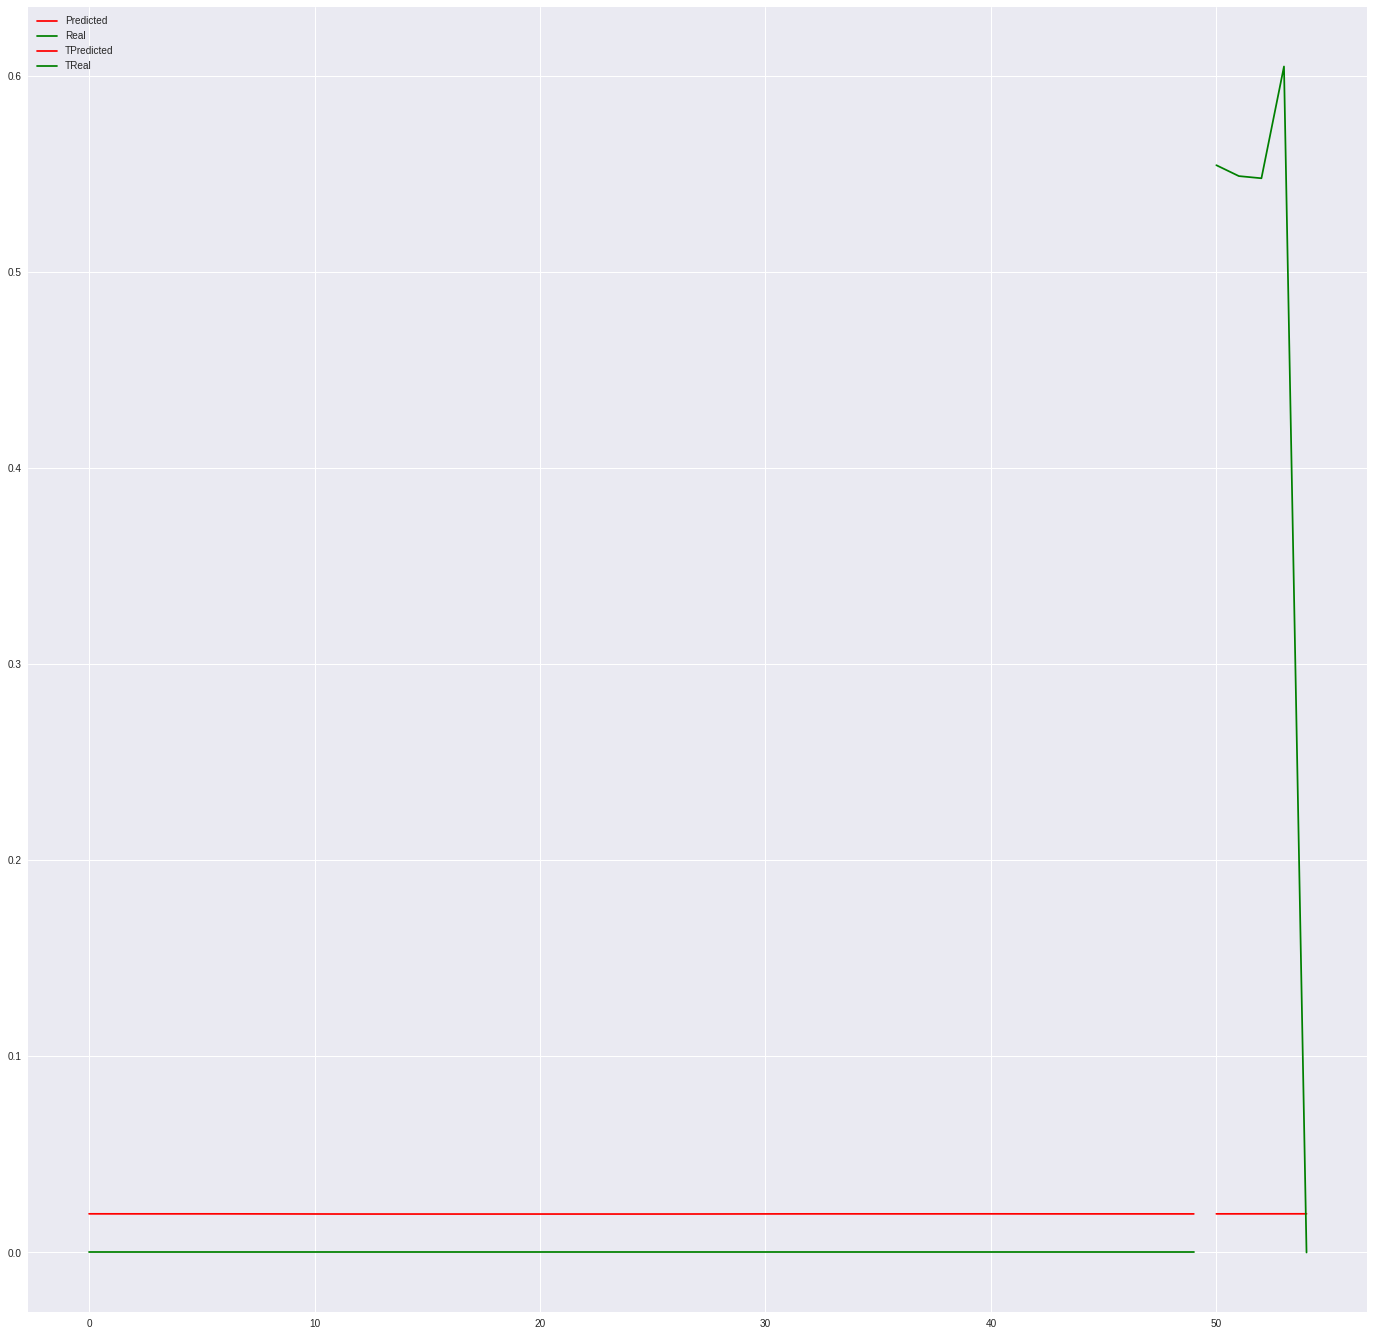

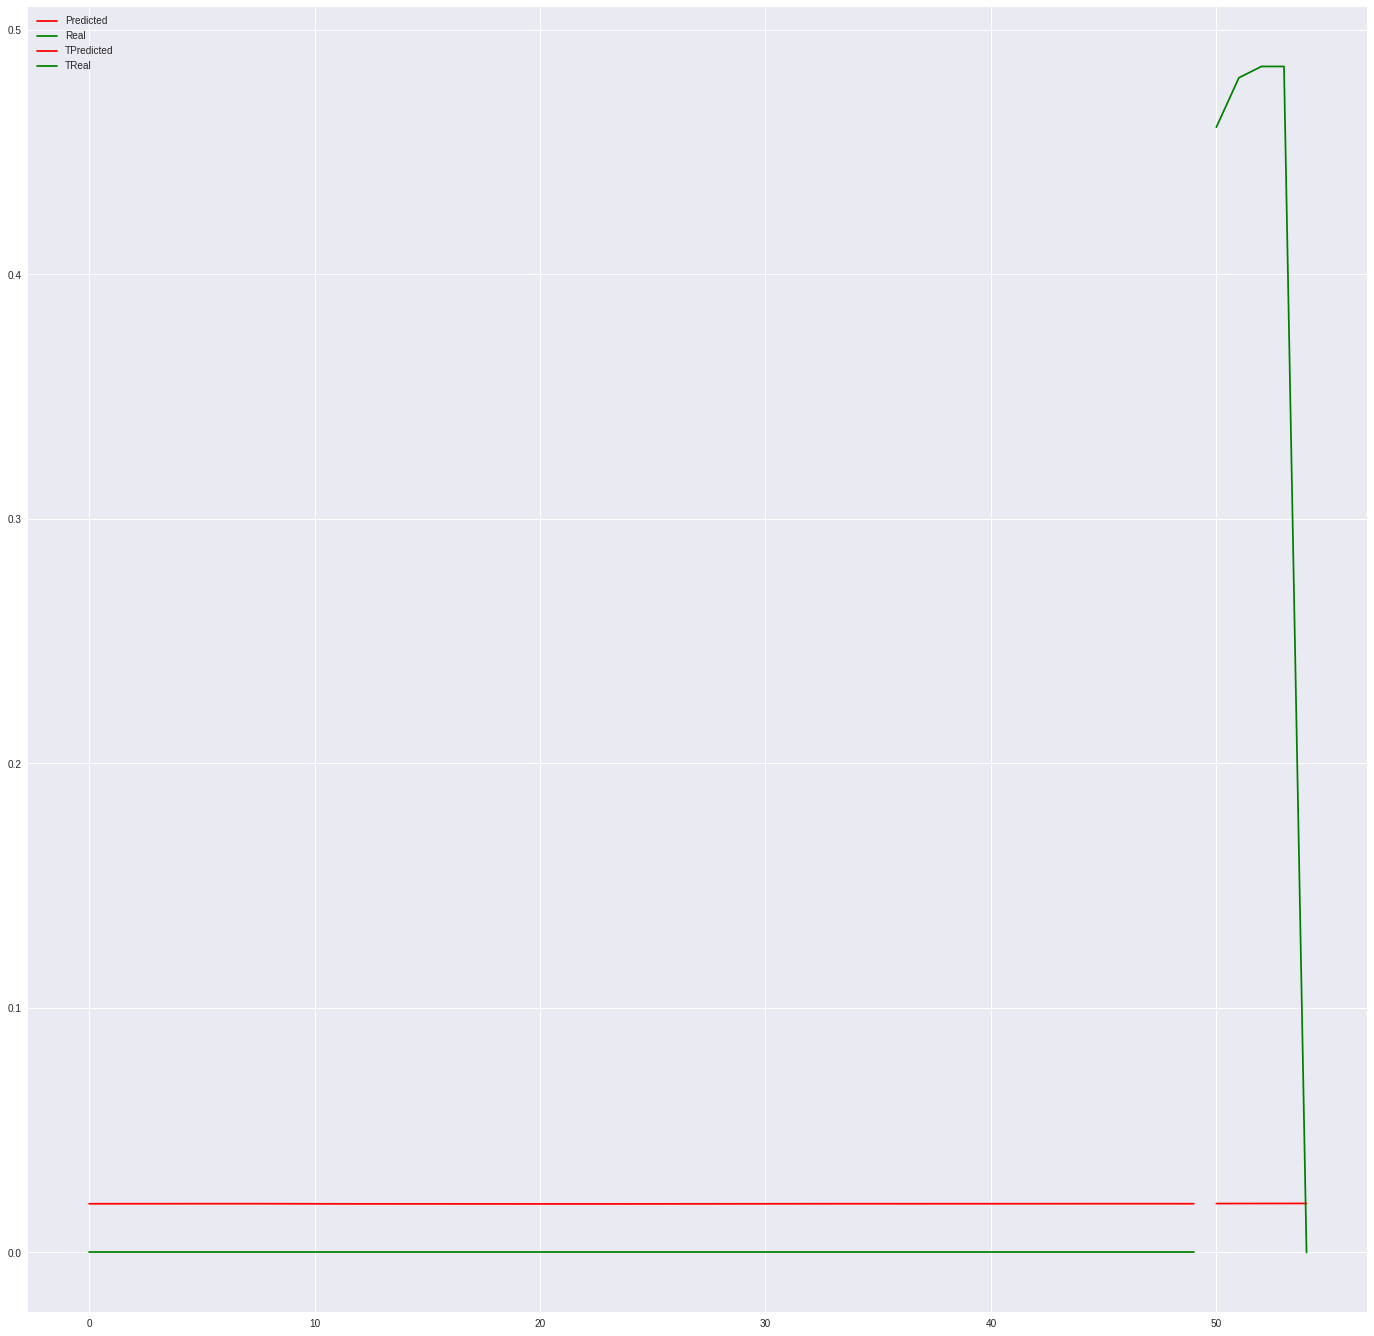

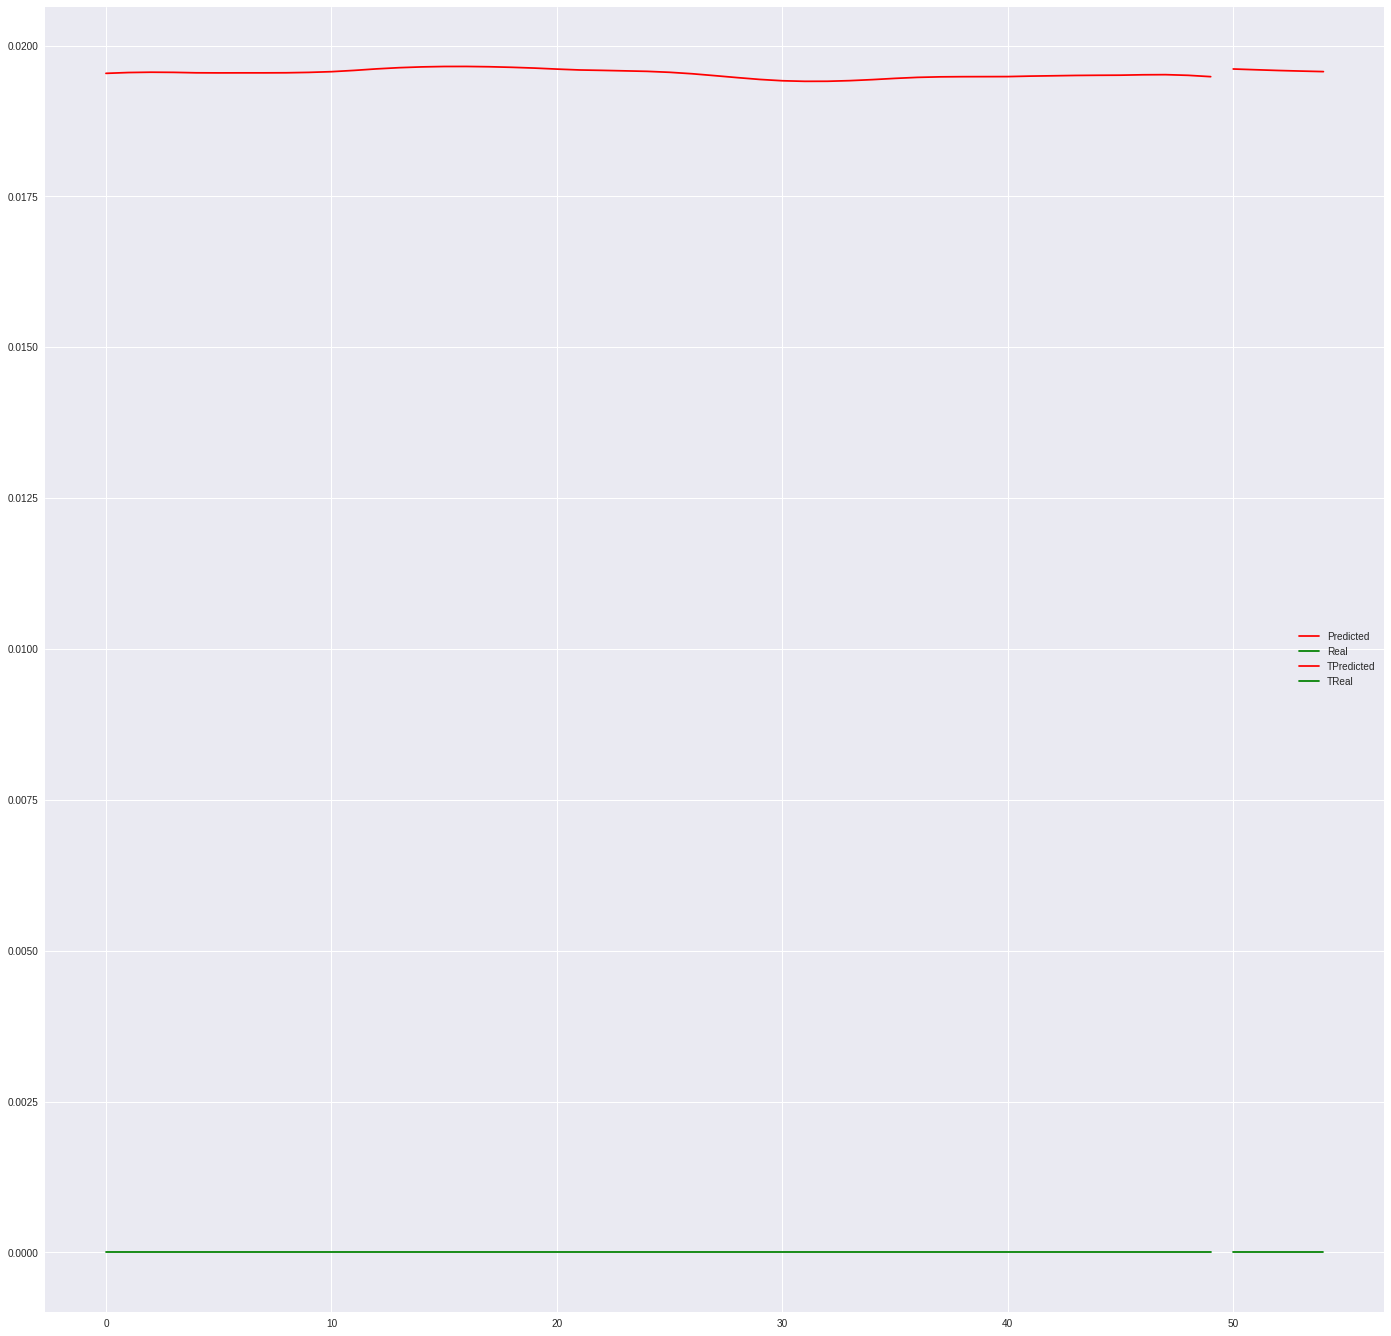

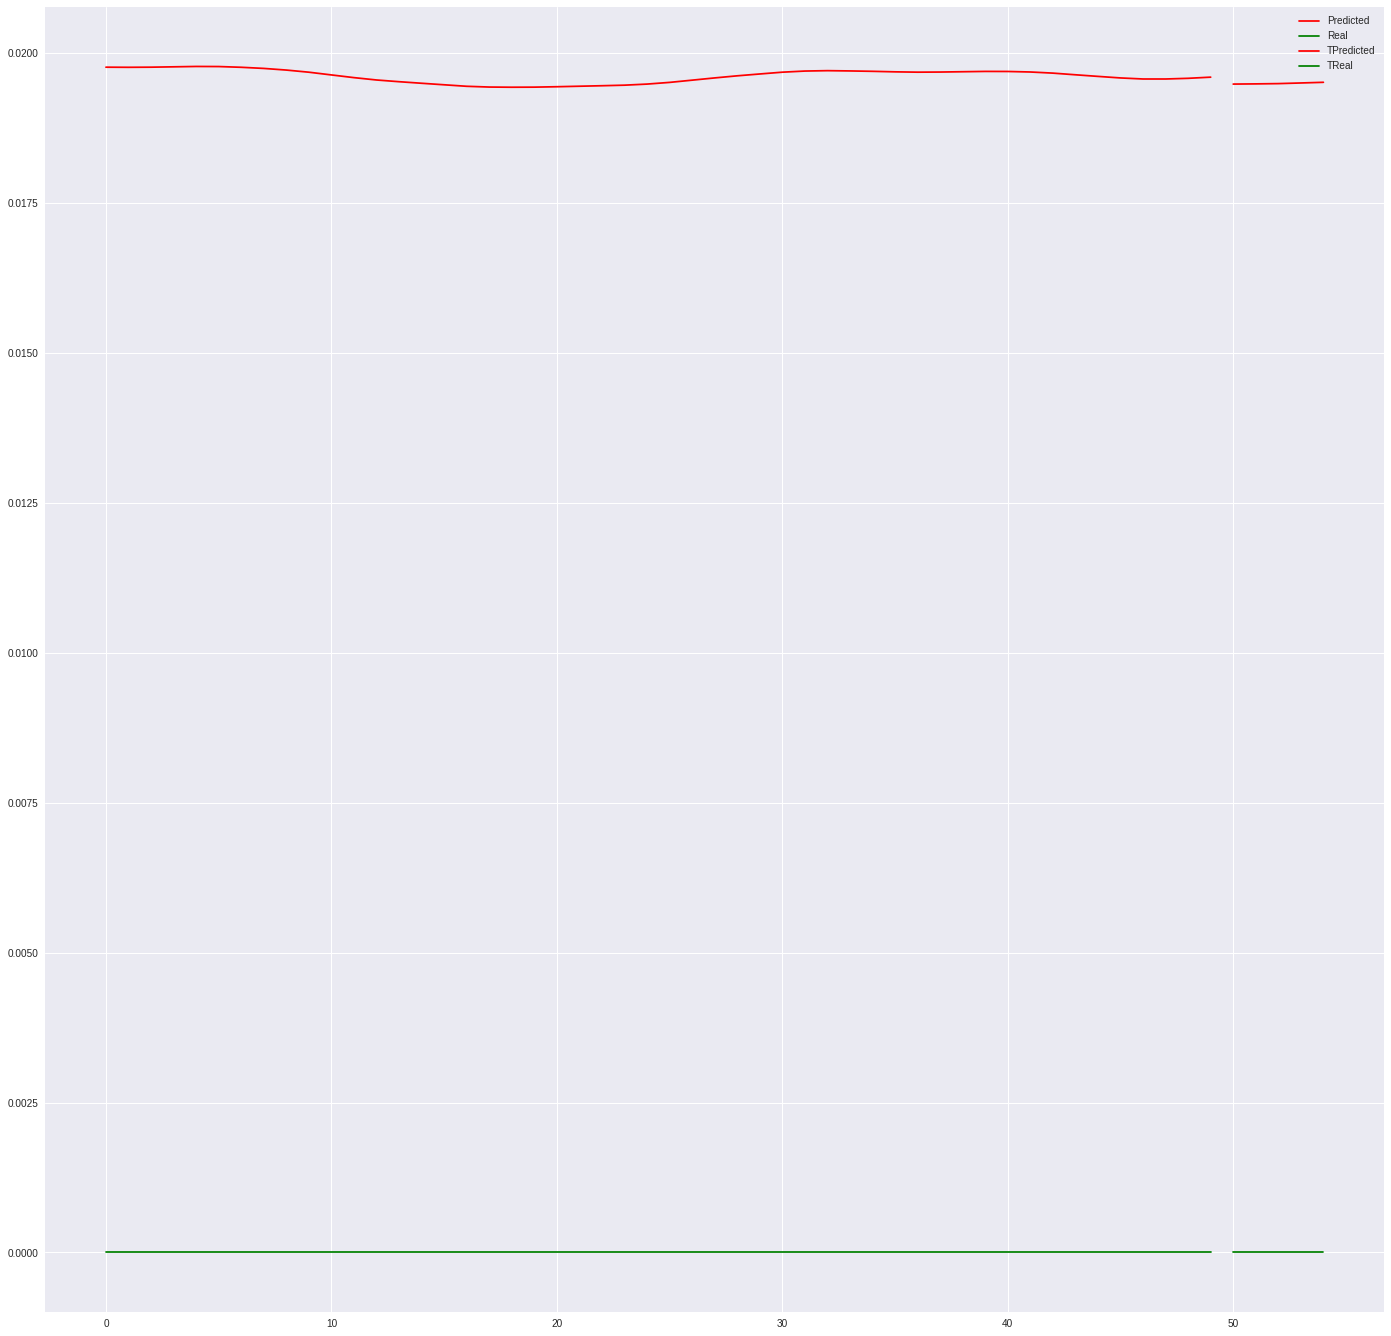

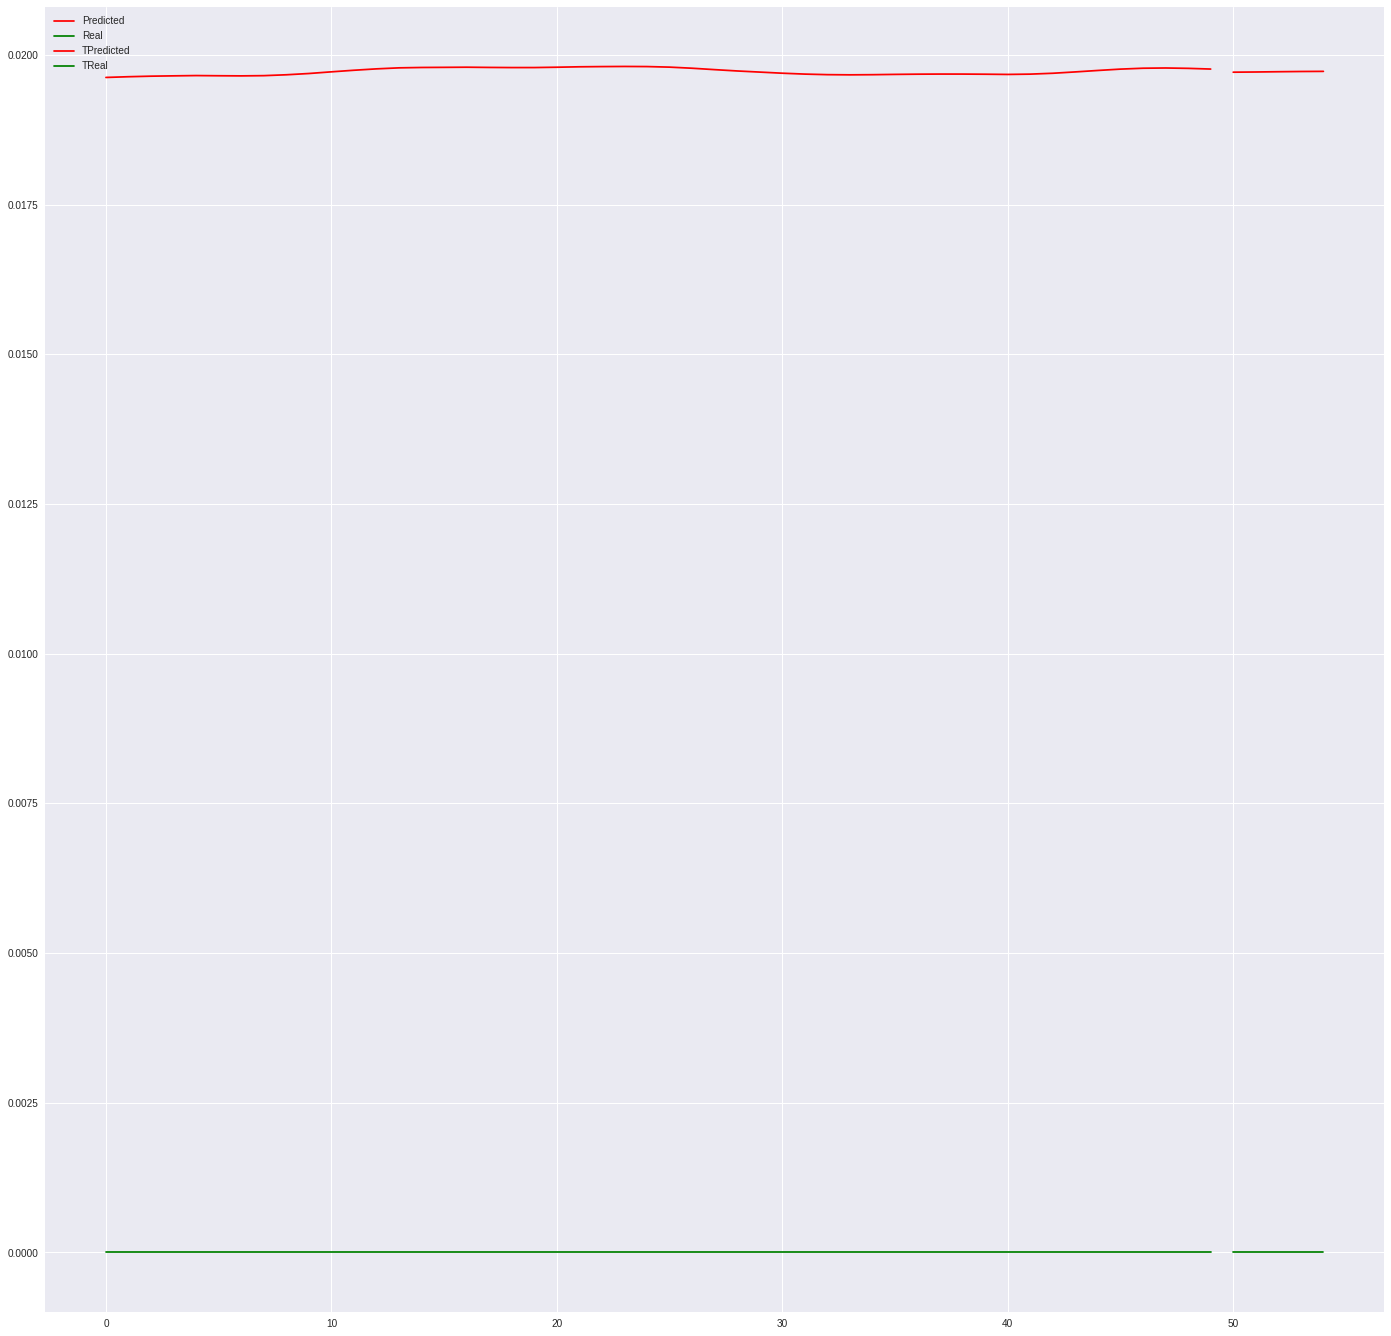

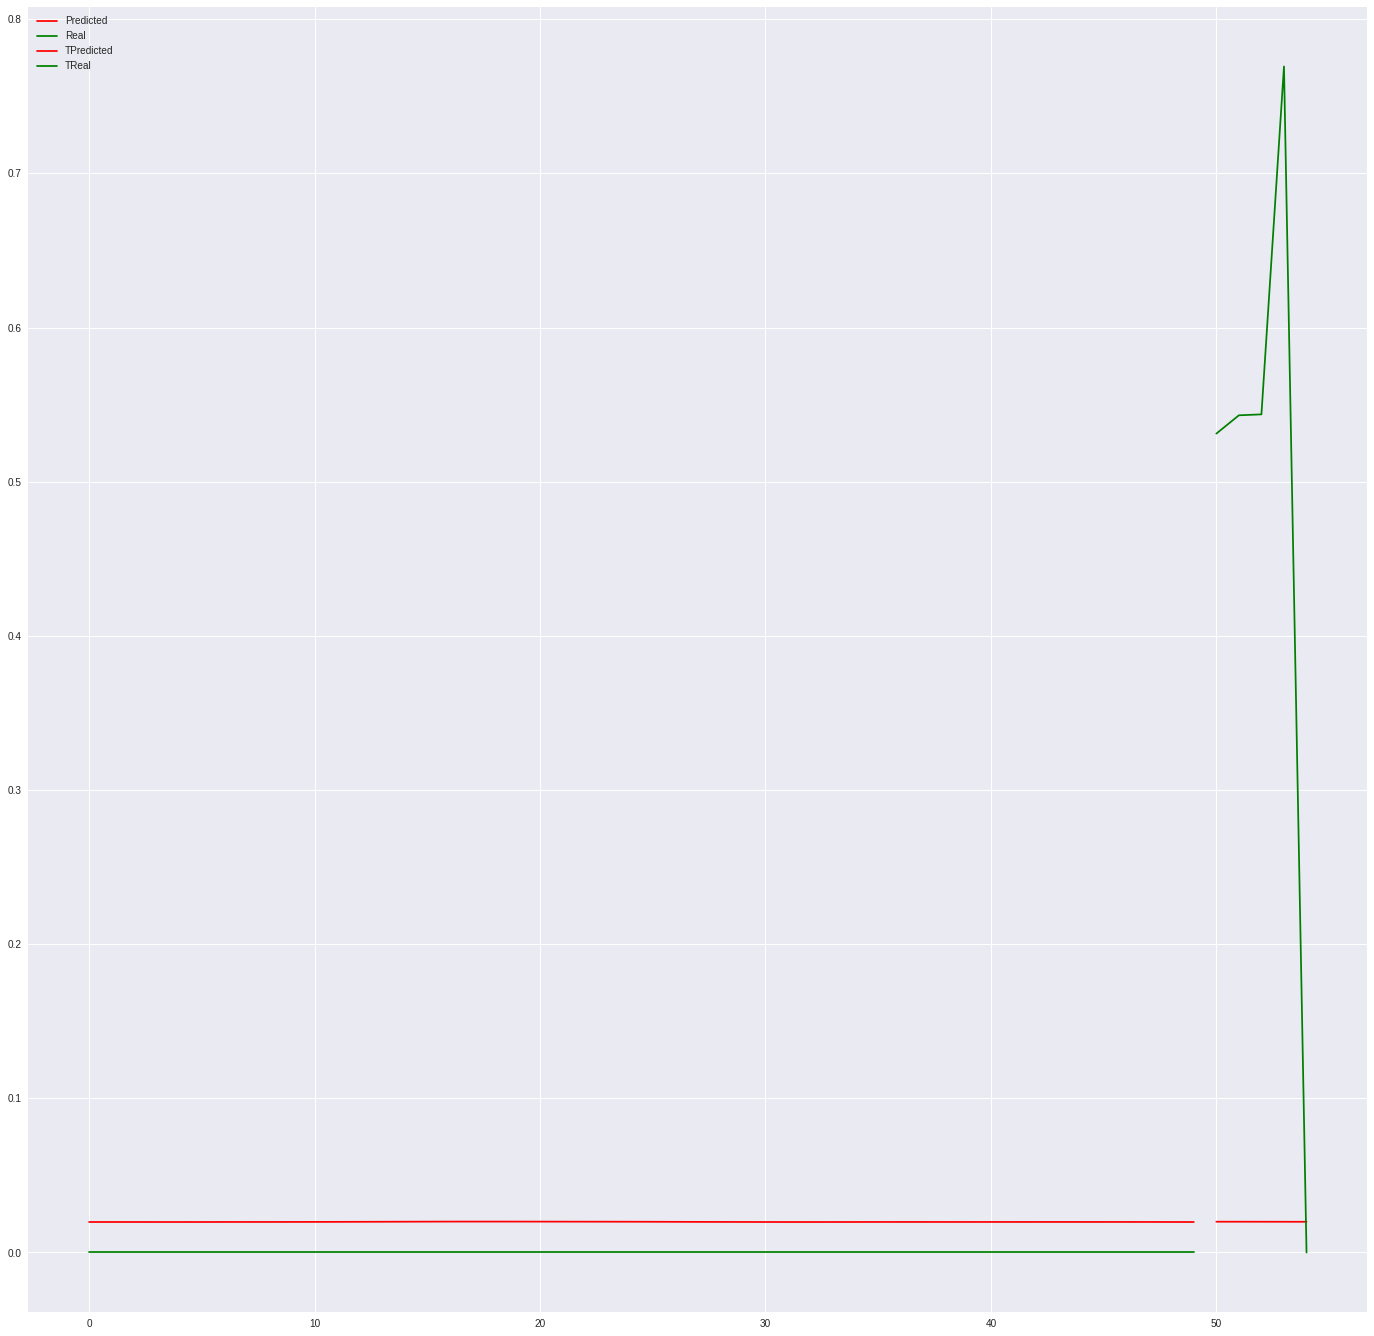

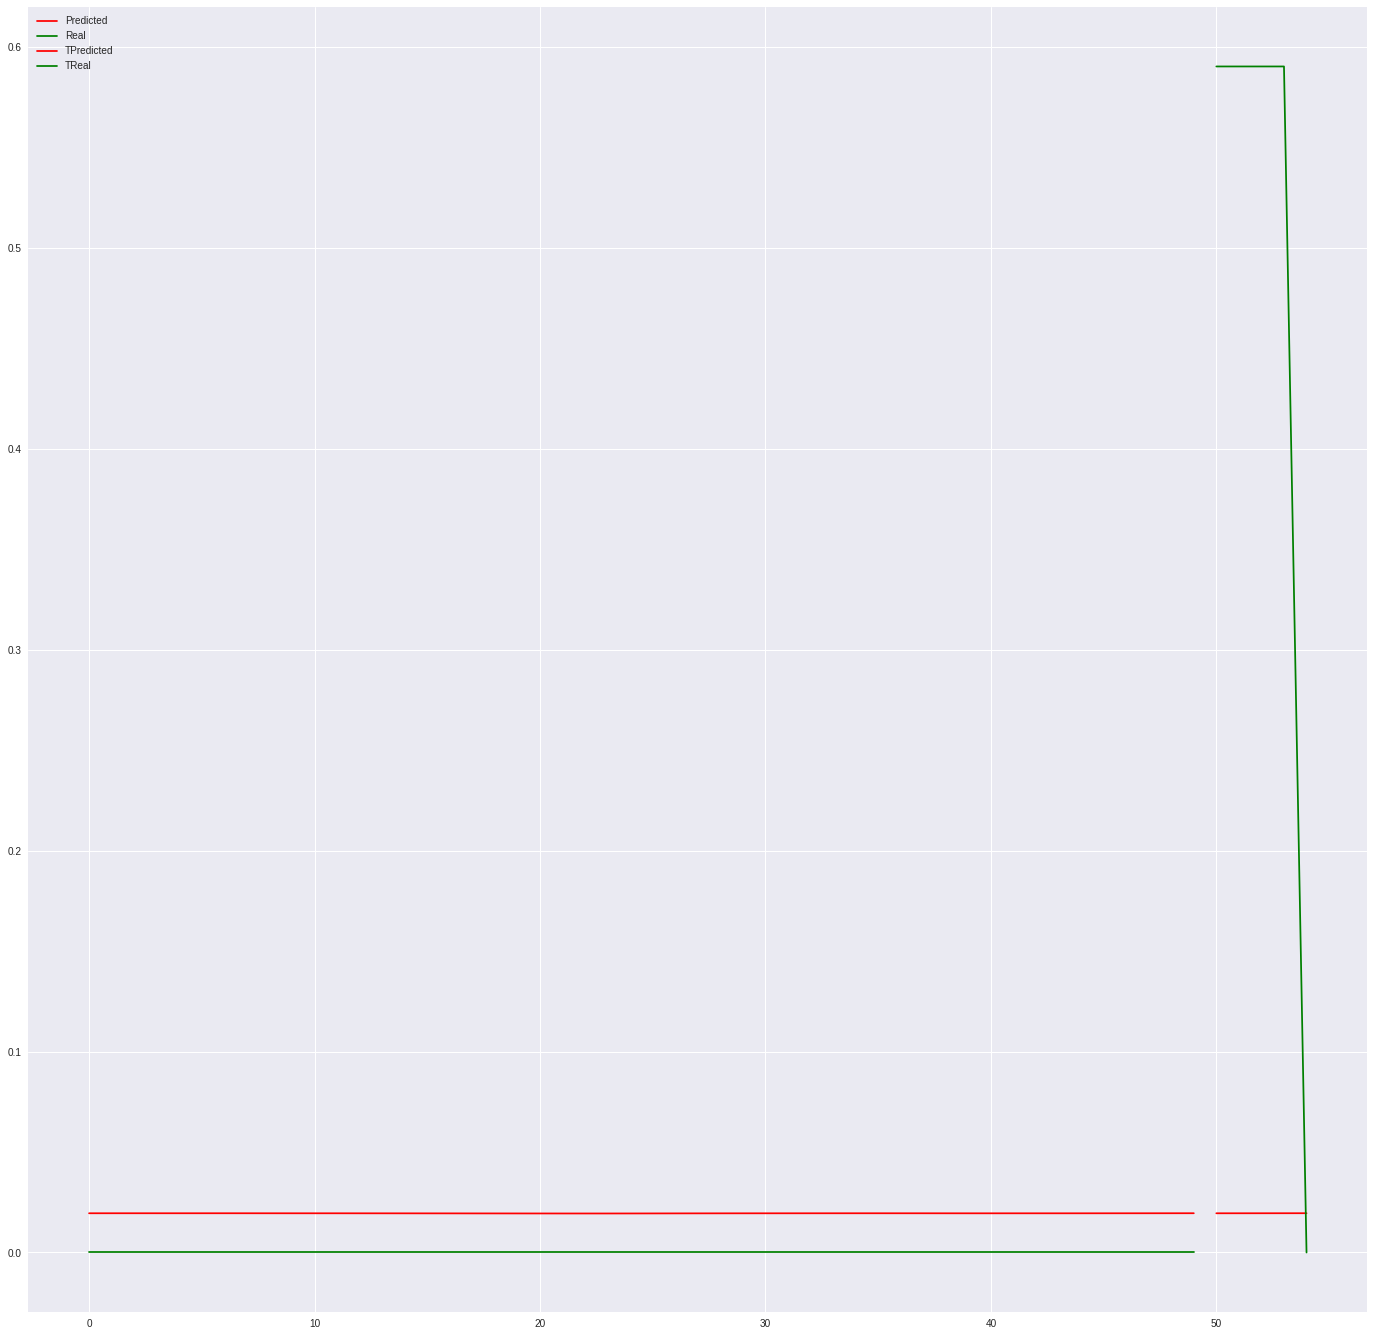

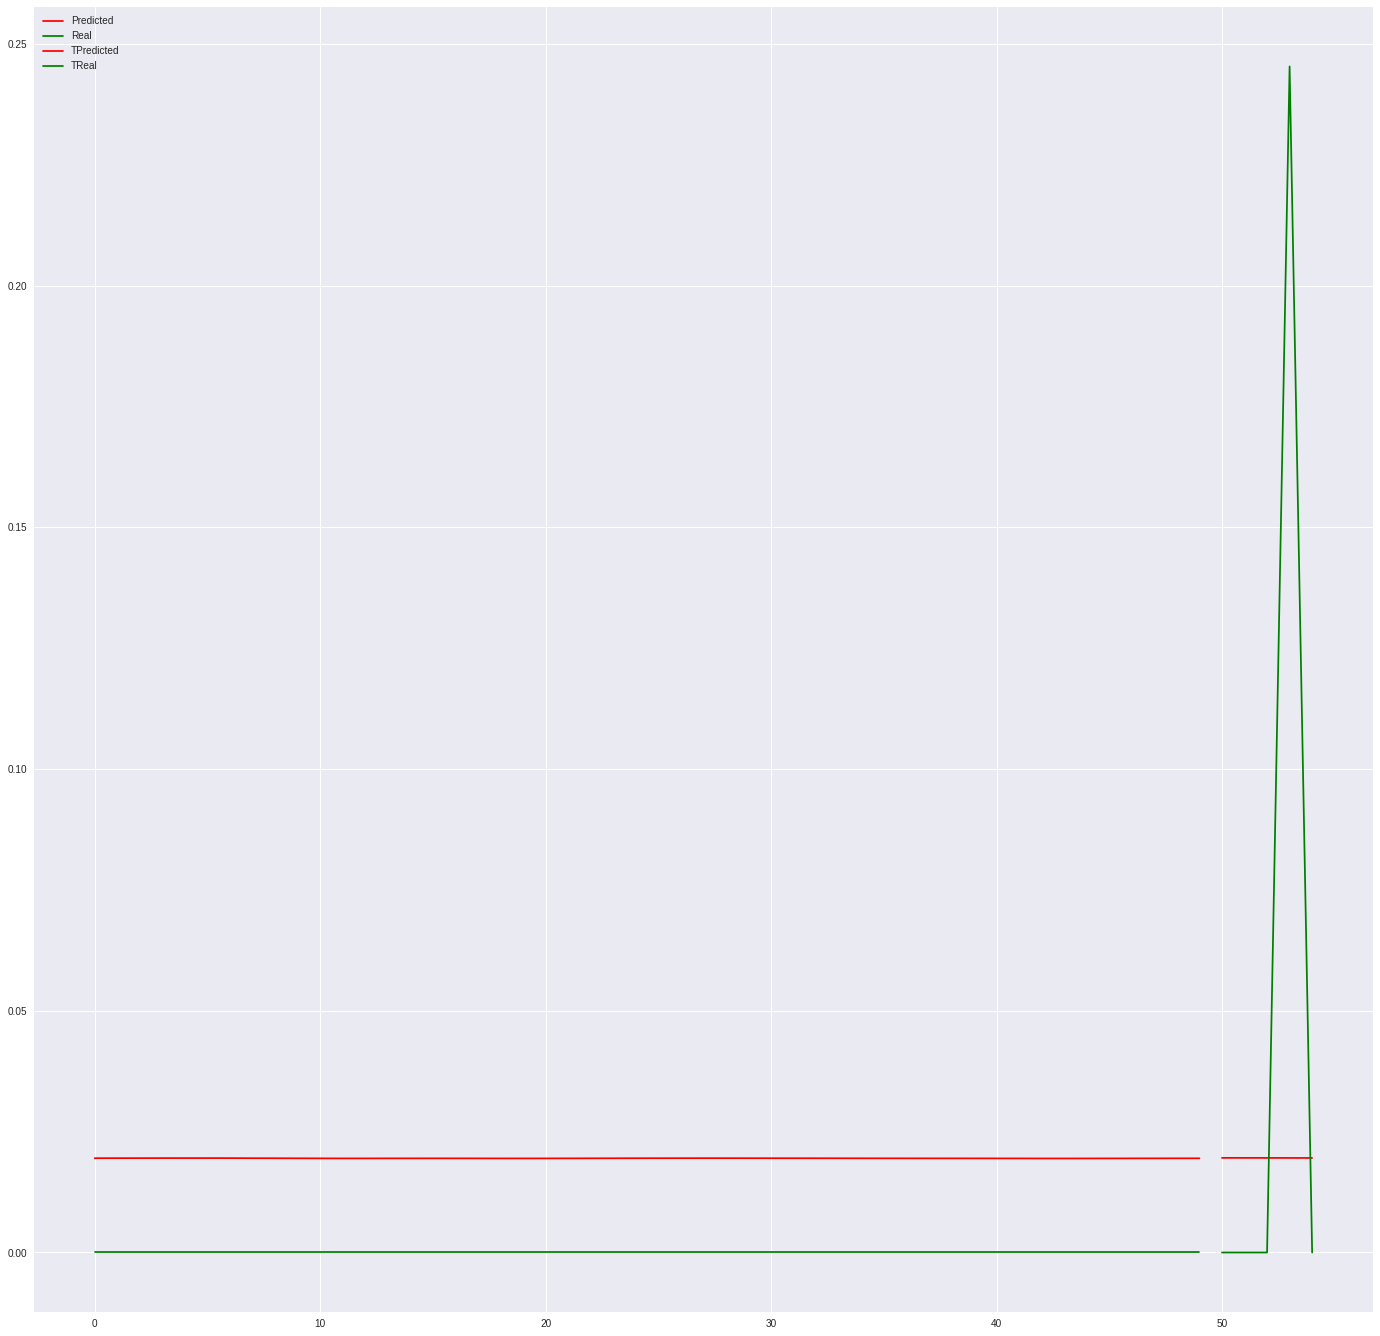

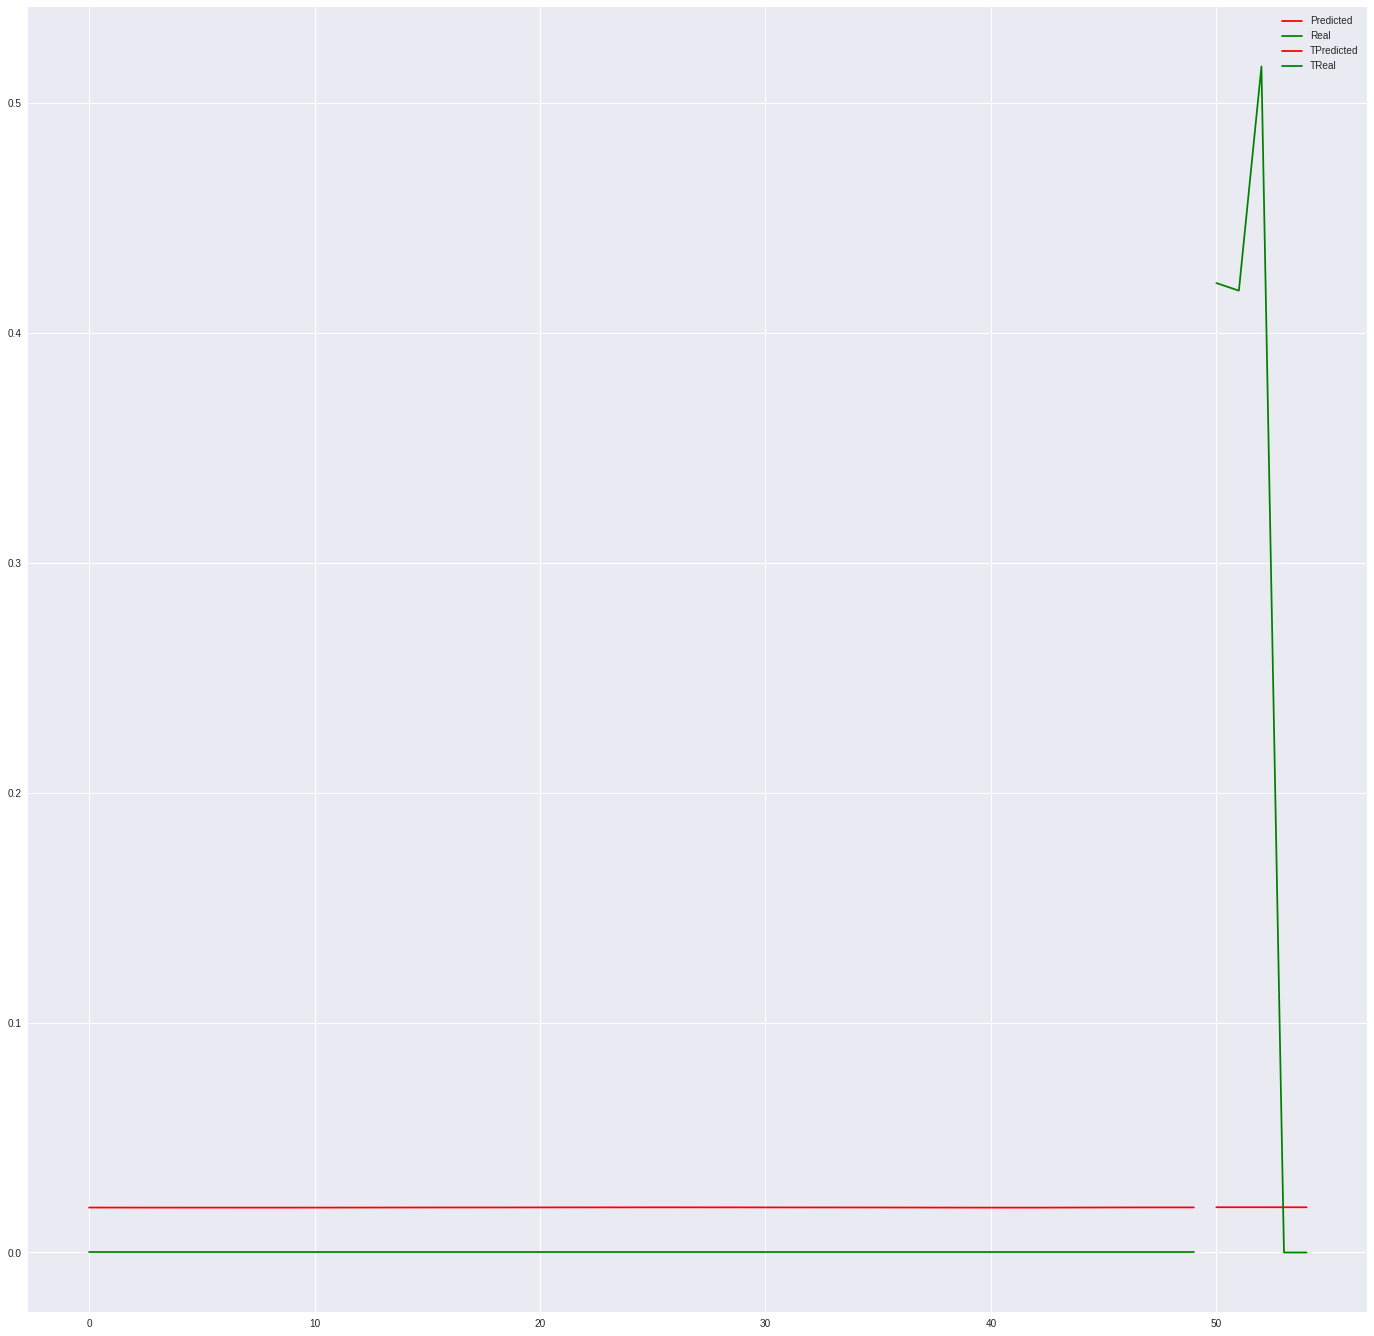

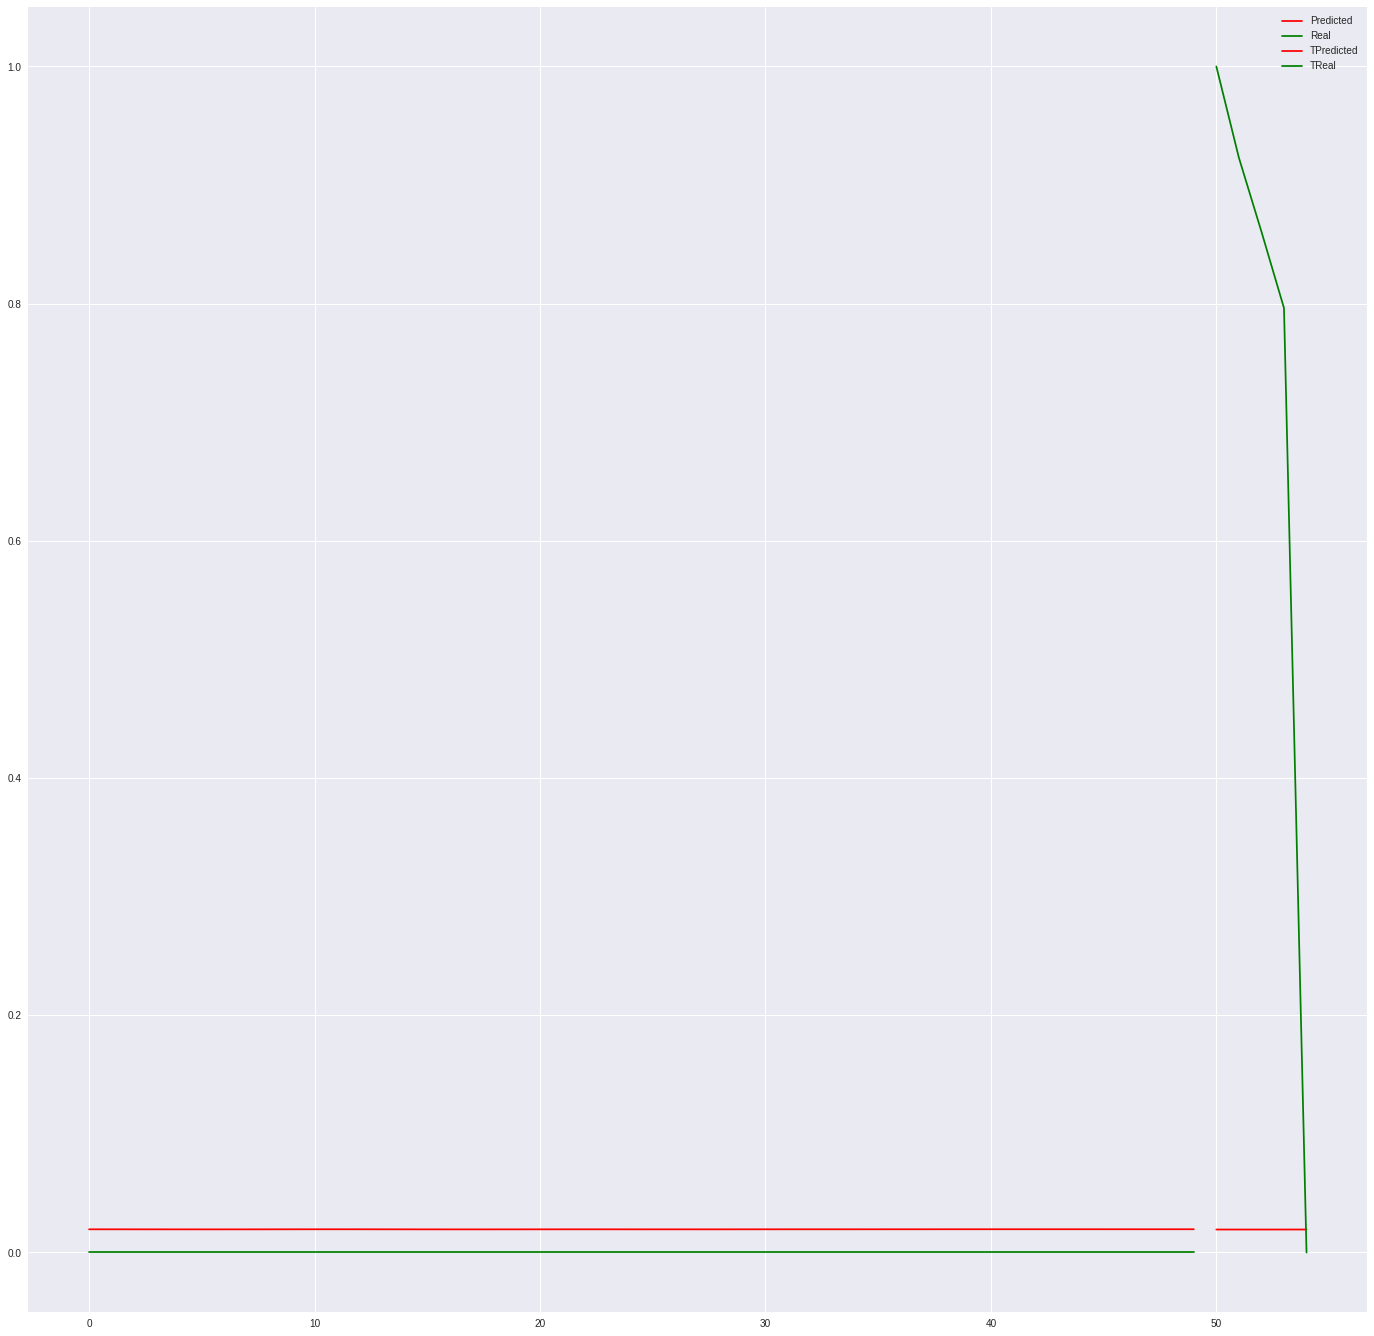

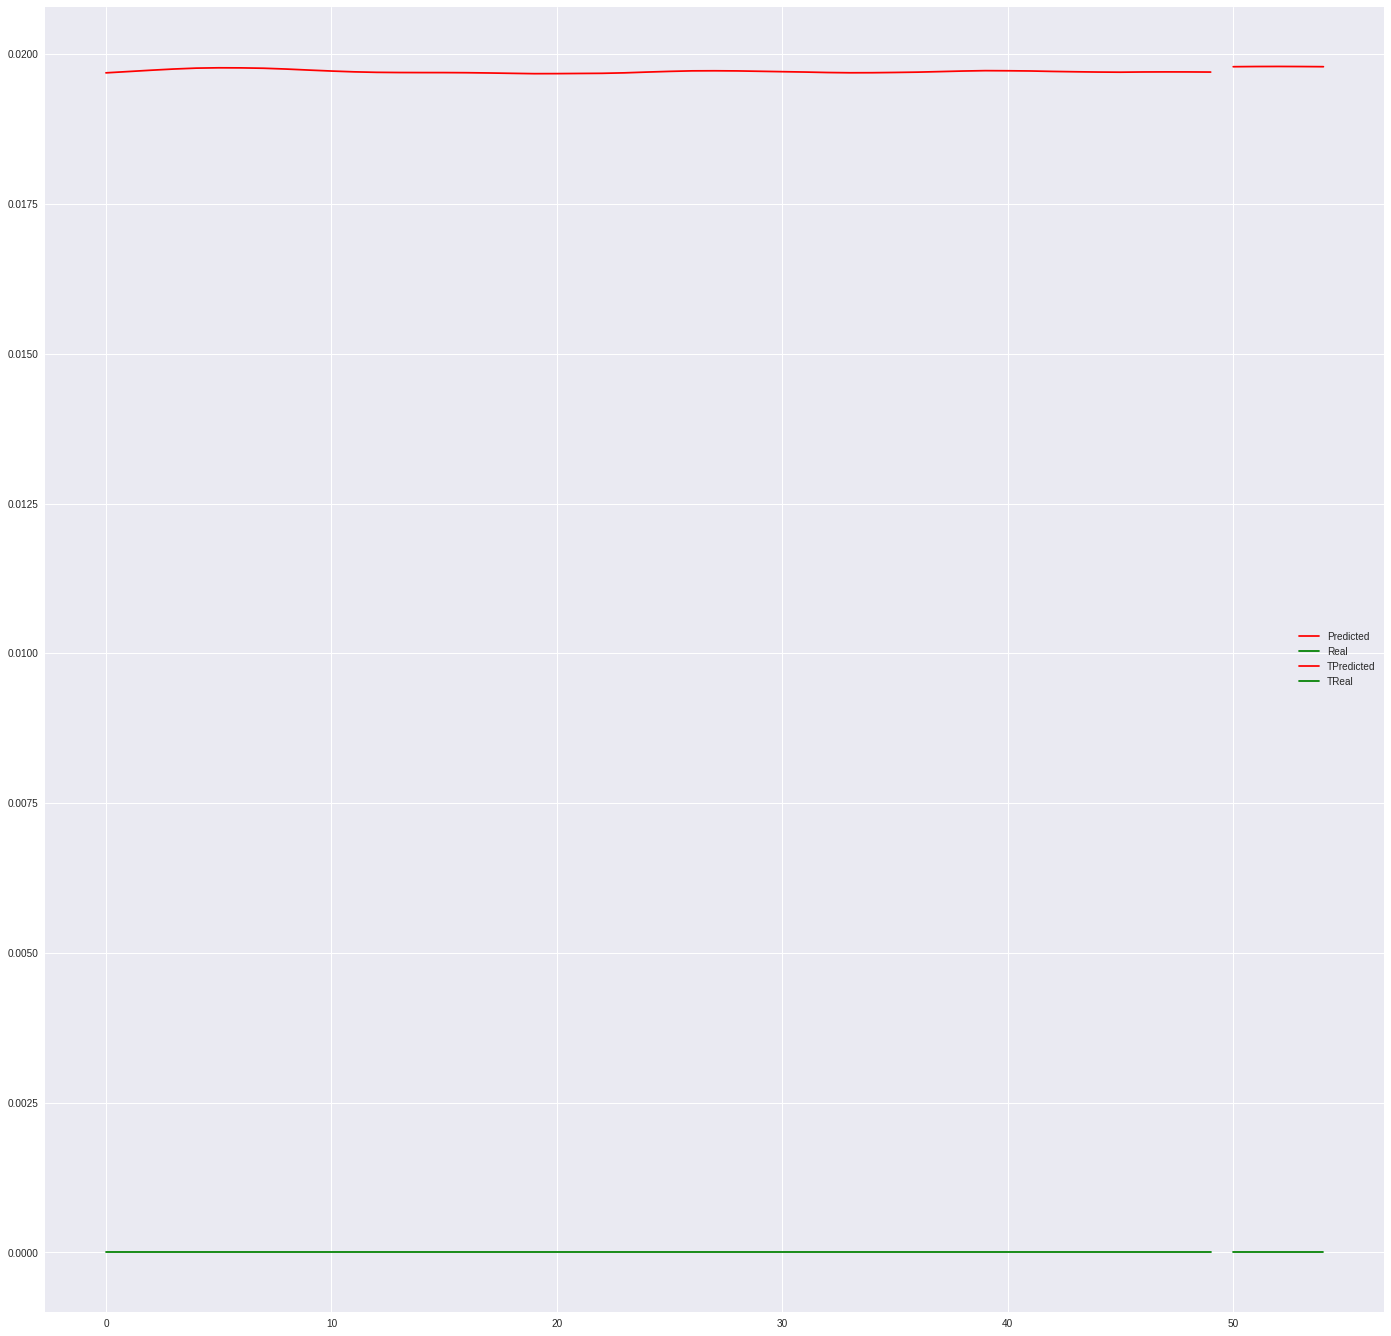

In [0]:
for target_feature in range(y.shape[1]):
    ypt = unwind_y(model1.predict(Xt[:5], verbose=0), target_feature)
    yrt = unwind_y(yt[:5],target_feature)


    yp = unwind_y(model1.predict(X[50:100], verbose=0),target_feature)
    yr = unwind_y(y[50:100],target_feature)


    plt.figure(figsize=(24,24))
    n=100

    multi=False
    if multi:
        for i in range(10):
            plt.plot(yp[i], color= 'red', label="Predicted")
            plt.plot(yr[i], color='green', label="Real")
    else:
        plt.plot(yp, color= 'red', label="Predicted")
        plt.plot(yr, color='green', label="Real")
        plt.plot(range(len(yp),len(yp)+len(ypt)),ypt,color="red", label="TPredicted")
        plt.plot(range(len(yp),len(yp)+len(yrt)),yrt,color="green",  label="TReal")

    #plt.plot(X[50:100,n_steps-1], color='blue', label="Lagged-0")
    #plt.plot(Xt[:5,n_steps-1], color='blue', label="Lagged-0")

    plt.legend()
    plt.show()

In [0]:
from keras.models import model_from_json
save=True
colab=True
if colab:
    model_name="LSTM_multivar_multidim"
else:
    model_name="lstm_models/LSTM_multivar_multidim"
model_weights=model_name+"_weigths.h5"
    
if save:
    # serialize model to JSON
    model_json = model.to_json()
    with open(model_name+".json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(model_weights)
    print("Saved model to disk")
    
    if colab:
        from google.colab import files
        files.download(model_name+".json")
        files.download(model_weights)

# later...


Saved model to disk
